# OU jump 12

In [1]:
import pandas as pd
import numpy as np
import random
from numpy.random import RandomState
from scipy import stats
from scipy.optimize import minimize
import scipy
import os
os.environ['R_HOME'] = '/Library/Frameworks/R.framework/Versions/4.1/Resources/'
import rpy2
from rpy2.robjects.packages import importr
from rpy2.robjects.packages import SignatureTranslatedAnonymousPackage
import datetime
from rpy2.robjects.vectors import FloatVector
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression

real_data_folder = "/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Data/sp500_mixed_period/"
np.random.seed(12001)


# Define the model that generates pair simulations.
yuima = importr("yuima")
n_jumpou_NIG_sim_string = """
n_jumpou_NIG = function(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length){
  
  set.seed(random_seed)
  
  drift = c("mu11*t-mu12*X1", "mu21*t-mu22*X2")
  diffusion = matrix(c("exp(sigma11)", "exp(sigma12)", "exp(sigma21)", "exp(sigma22)"), 2, 2, byrow=TRUE)
  jumpcoef = matrix(c("j11", "j12", "j21", "j22"), 2, 2, byrow=TRUE) 
  
  alpha = alpha
  beta = c(beta1, beta2)
  delta0 = delta0
  mu = c(mu1, mu2)
  Lambda = matrix(c(lambda11, lambda12, lambda21, lambda22), 2, 2, byrow=TRUE)
  
  ou_model = setModel(drift=drift, diffusion=diffusion, jump.coeff=jumpcoef, 
                      measure.type="code",
                      measure=list(df="rNIG(z, alpha, beta, delta0, mu, Lambda)"), 
                      time.variable = "t",
                      state.var=c("X1","X2"), solve.variable=c("X1","X2"))
  newsamp = setSampling(Initial=T0, Terminal=T, n=length)
  
  n_sim_data = data.frame(matrix(nrow=length+1, ncol=2*num_sim))
  for (i in 1:num_sim){
    jumpou_sim = simulate(ou_model, 
                          true.par=list(
                            mu11=mu11, mu12=mu12, mu21=mu21, mu22=mu22, 
                            sigma11=sigma11, sigma12=sigma12, sigma21=sigma21, sigma22=sigma22,
                            j11=j11, j12=j12, j21=j21, j22=j22,
                            alpha=alpha, beta=beta, delta0=delta0, mu=mu, Lambda=Lambda), 
                          xinit=xinit_vec[[i]], sampling=newsamp)
    original_data = jumpou_sim@data@original.data
    one_sim_jumpou = data.frame(original_data[,1], original_data[,2])
    colnames(one_sim_jumpou) = c('series1', 'series2')
    n_sim_data[, (2*i-1):(2*i)] = one_sim_jumpou
  }
  return(n_sim_data)
}
"""

n_jumpou_NIG_sim = SignatureTranslatedAnonymousPackage(n_jumpou_NIG_sim_string, "n_jumpou_NIG_sim")
def n_jumpou_simulation(random_seed, num_sim,
                        mu11, mu12, mu21, mu22, 
                        sigma11, sigma12, sigma21, sigma22,
                        j11, j12, j21, j22,
                        alpha, beta1, beta2, delta0, mu1, mu2, 
                        lambda11, lambda12, lambda21, lambda22,
                        xinit_vec, T0, T, length):

    n_sim_data = pd.DataFrame(
        n_jumpou_NIG_sim.n_jumpou_NIG(random_seed, num_sim,
                                      mu11, mu12, mu21, mu22, 
                                      sigma11, sigma12, sigma21, sigma22,
                                      j11, j12, j21, j22,
                                      alpha, beta1, beta2, delta0, mu1, mu2, 
                                      lambda11, lambda12, lambda21, lambda22,
                                      xinit_vec, T0, T, length)).transpose()
    return n_sim_data


def price_to_log_price(n_price):
    return(np.log(n_price))

def log_price_to_price(n_log_price):
    return(np.exp(n_log_price))

def price_to_return(n_price):
    n_return = pd.DataFrame()
    for i in range(n_price.shape[1]):
        ith_column_price_series = n_price.iloc[:, i]
        n_return = pd.concat([n_return, 100 * (np.log(ith_column_price_series[1:].values) - np.log(ith_column_price_series[:-1]))], axis=1)
    return n_return

def log_price_to_return(n_log_price):
    n_real_return = pd.DataFrame()
    for i in range(n_log_price.shape[1]):
        ith_column_price_series = n_log_price.iloc[:, i]
        n_real_return = pd.concat([n_real_return, 100 * (ith_column_price_series[1:].values - ith_column_price_series[:-1])], axis=1)
    return n_real_return


def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'
    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]
    return corr_coef

def cal_stats(n_return, n_price):
    
    return_series1 = n_return.iloc[:, ::2]
    return_series2 = n_return.iloc[:, 1::2]
    price_series1 = n_price.iloc[:, ::2]
    price_series2 = n_price.iloc[:, 1::2]
    sq_return_series1 = return_series1**2
    sq_return_series2 = return_series2**2

    
    mean1 = return_series1.mean(axis=0).values
    sd1 = return_series1.std(axis=0).values
    skew1 = return_series1.skew(axis=0).values
    kurtosis1 = return_series1.kurtosis(axis=0).values
       
    
    mean2 = return_series2.mean(axis=0).values
    sd2 = return_series2.std(axis=0).values
    skew2 = return_series1.skew(axis=0).values
    kurtosis2 = return_series2.kurtosis(axis=0).values
    
    
    # Autocorrelation of the 2 return series with 3 lags respectively
    autocorr1_lag_1 = return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr1_lag_2 = return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr1_lag_3 = return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr2_lag_1 = return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr2_lag_2 = return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr2_lag_3 = return_series2.apply(lambda x: x.autocorr(lag=3)) 
    
    
    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(int(real_price.shape[1]/2)):
        corr_ts1_lag_0.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_series1.iloc[:, i], return_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_series2.iloc[:, i], return_series1.iloc[:, i], 3))
    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)
    
    
    # Autocorrelation of the 2 squared returns with 3 lags respectively
    autocorr_sqreturn_1_lag_1 = sq_return_series1.apply(lambda x: x.autocorr(lag=1))
    autocorr_sqreturn_1_lag_2 = sq_return_series1.apply(lambda x: x.autocorr(lag=2))
    autocorr_sqreturn_1_lag_3 = sq_return_series1.apply(lambda x: x.autocorr(lag=3))
    autocorr_sqreturn_2_lag_1 = sq_return_series2.apply(lambda x: x.autocorr(lag=1)) 
    autocorr_sqreturn_2_lag_2 = sq_return_series2.apply(lambda x: x.autocorr(lag=2)) 
    autocorr_sqreturn_2_lag_3 = sq_return_series2.apply(lambda x: x.autocorr(lag=3))
    
    
    stats_data = pd.DataFrame([mean1, mean2, sd1, sd2, 
                               skew1, skew2, kurtosis1, kurtosis2, 
                               autocorr1_lag_1, autocorr1_lag_2, autocorr1_lag_3,
                               autocorr2_lag_1, autocorr2_lag_2, autocorr2_lag_3,
                               corr_ts1_lag_0, 
                               corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
                               corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
                               autocorr_sqreturn_1_lag_1, autocorr_sqreturn_1_lag_2, autocorr_sqreturn_1_lag_3,
                               autocorr_sqreturn_2_lag_1, autocorr_sqreturn_2_lag_2, autocorr_sqreturn_2_lag_3])
    stats_data = stats_data.transpose()
    stats_data.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_ts1_lag1', 'return_autocorrelation_ts1_lag2', 'return_autocorrelation_ts1_lag3',
        'return_autocorrelation_ts2_lag1', 'return_autocorrelation_ts2_lag2', 'return_autocorrelation_ts2_lag3',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'sqreturn_autocorrelation_ts1_lag1', 'sqreturn_autocorrelation_ts1_lag2', 'sqreturn_autocorrelation_ts1_lag3',
        'sqreturn_autocorrelation_ts2_lag1', 'sqreturn_autocorrelation_ts2_lag2', 'sqreturn_autocorrelation_ts2_lag3']
    
    return stats_data



def loss_function(params):
    """n_real_stats is a global amount calculated outside the function"""
    params = FloatVector(params)
    print(params)
    moment_loss = pd.DataFrame().reindex_like(real_stats)
    
    n_sim_log_price = n_jumpou_simulation(
        random_seed=int(np.random.randint(low=0, high=980608, size=(1,))), num_sim=num_sim,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=params[16], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[16],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)
    
    n_sim_price = log_price_to_price(n_sim_log_price)
    n_sim_return = price_to_return(n_sim_price)
    n_sim_stats = cal_stats(n_sim_return, n_sim_price)


    moment_loss = (n_real_stats - n_sim_stats)**2
    mse = np.sum(moment_loss)
    
    mse[0] = mse[0]*100 # return_mean1
    mse[1] = mse[1]*100 # return_mean2
    mse[2] = mse[2]*100 # return_sd1
    mse[3] = mse[3]*100 # return_sd2
    mse[4] = mse[4]*100 # return_skew1
    mse[5] = mse[5]*100 # return_skew2    
  #  mse[6] = mse[6] # return_kurtosis1
  #  mse[7] = mse[7] # return_kurtosis2 
    
    sum_mse = np.sum(mse)

    print(mse)
    print(sum_mse)
    print('----------')

    return sum_mse



real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_calibration.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_calibration.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)


xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

n_real_stats = real_stats


#alpha
beta1 = 0
beta2 = 0
#delta0
#mu1
#mu2
#lambda11 = 1
lambda12 = 0
lambda21 = 0
#lambda22 = 1


initial0 = [1, 1, 1, 1,
            -1, -1, -1, -1,
            0.1, 0.1, 0.1, 0.1,
            1, 1,
            1, 1,
            1]

begin_time = datetime.datetime.now()
res = minimize(loss_function, initial0, method='Powell',
               tol=1e-6, options={'disp': True},
               bounds=[(None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (None, None), (None, None), (None, None), (None, None),
                       (0, None), (0, None),
                       (None, None), (None, None), 
                       (0, None)])
print(res.x)

time = datetime.datetime.now() - begin_time
print(time)

params = (res.x)
loss = loss_function((params))
print(loss)

 [1]  1.0  1.0  1.0  1.0 -1.0 -1.0 -1.0 -1.0  0.1  0.1  0.1  0.1  1.0  1.0  1.0
[16]  1.0  1.0

return_mean1                         24242.017906
return_mean2                         22258.630239
return_sd1                           85078.767523
return_sd2                           79344.669750
return_skew1                         31225.023380
return_skew2                         31225.023380
return_kurtosis1                     26193.126086
return_kurtosis2                     52015.253717
return_autocorrelation_ts1_lag1          2.040076
return_autocorrelation_ts1_lag2          2.084855
return_autocorrelation_ts1_lag3          2.105772
return_autocorrelation_ts2_lag1          2.013931
return_autocorrelation_ts2_lag2          1.899905
return_autocorrelation_ts2_lag3          1.882938
return_correlation_ts1_lag_0           121.279839
return_correlation_ts1_lag_1             2.057621
return_correlation_ts1_lag_2             1.825107
return_correlation_ts1_lag_3             2.269112
retu

return_mean1                         20132.801350
return_mean2                         21795.601558
return_sd1                           86159.119049
return_sd2                           80859.275292
return_skew1                         35262.598874
return_skew2                         35262.598874
return_kurtosis1                     26206.723814
return_kurtosis2                     53796.394493
return_autocorrelation_ts1_lag1          2.079125
return_autocorrelation_ts1_lag2          2.529117
return_autocorrelation_ts1_lag3          1.869813
return_autocorrelation_ts2_lag1          1.999369
return_autocorrelation_ts2_lag2          2.347352
return_autocorrelation_ts2_lag3          2.257791
return_correlation_ts1_lag_0           121.240762
return_correlation_ts1_lag_1             1.819152
return_correlation_ts1_lag_2             2.148984
return_correlation_ts1_lag_3             2.497222
return_correlation_ts2_lag_1             2.023139
return_correlation_ts2_lag_2             2.356328


return_mean1                         22179.881102
return_mean2                         21267.513431
return_sd1                           87415.286988
return_sd2                           82482.685360
return_skew1                         45656.881732
return_skew2                         45656.881732
return_kurtosis1                     41790.204947
return_kurtosis2                     70690.050283
return_autocorrelation_ts1_lag1          2.484328
return_autocorrelation_ts1_lag2          2.212093
return_autocorrelation_ts1_lag3          2.176509
return_autocorrelation_ts2_lag1          2.129169
return_autocorrelation_ts2_lag2          2.132369
return_autocorrelation_ts2_lag3          2.138657
return_correlation_ts1_lag_0           121.272905
return_correlation_ts1_lag_1             1.962923
return_correlation_ts1_lag_2             2.006985
return_correlation_ts1_lag_3             2.125271
return_correlation_ts2_lag_1             2.543895
return_correlation_ts2_lag_2             2.461955


return_mean1                         22871.224859
return_mean2                         22267.954952
return_sd1                           85360.914224
return_sd2                           80530.074667
return_skew1                         34819.404148
return_skew2                         34819.404148
return_kurtosis1                     28604.576997
return_kurtosis2                     53979.746314
return_autocorrelation_ts1_lag1          2.597826
return_autocorrelation_ts1_lag2          2.136599
return_autocorrelation_ts1_lag3          2.126354
return_autocorrelation_ts2_lag1          2.230579
return_autocorrelation_ts2_lag2          2.098821
return_autocorrelation_ts2_lag3          2.117525
return_correlation_ts1_lag_0           121.269003
return_correlation_ts1_lag_1             1.983964
return_correlation_ts1_lag_2             1.874722
return_correlation_ts1_lag_3             2.022930
return_correlation_ts2_lag_1             2.505881
return_correlation_ts2_lag_2             2.021114


return_mean1                         22011.473653
return_mean2                         21700.056431
return_sd1                           85332.942273
return_sd2                           79820.036459
return_skew1                         37838.870229
return_skew2                         37838.870229
return_kurtosis1                     34122.958777
return_kurtosis2                     61074.234358
return_autocorrelation_ts1_lag1          2.344563
return_autocorrelation_ts1_lag2          2.661498
return_autocorrelation_ts1_lag3          2.057041
return_autocorrelation_ts2_lag1          2.191194
return_autocorrelation_ts2_lag2          2.375580
return_autocorrelation_ts2_lag3          1.983112
return_correlation_ts1_lag_0           121.270731
return_correlation_ts1_lag_1             2.095658
return_correlation_ts1_lag_2             2.603386
return_correlation_ts1_lag_3             2.376612
return_correlation_ts2_lag_1             2.308416
return_correlation_ts2_lag_2             2.345715


return_mean1                         86823.344212
return_mean2                         22494.946292
return_sd1                           87416.864831
return_sd2                           82082.480419
return_skew1                         36107.800812
return_skew2                         36107.800812
return_kurtosis1                     28432.692297
return_kurtosis2                     54833.276962
return_autocorrelation_ts1_lag1          2.336490
return_autocorrelation_ts1_lag2          2.453269
return_autocorrelation_ts1_lag3          2.090047
return_autocorrelation_ts2_lag1          2.187981
return_autocorrelation_ts2_lag2          1.888458
return_autocorrelation_ts2_lag3          2.234698
return_correlation_ts1_lag_0           120.753888
return_correlation_ts1_lag_1             2.212234
return_correlation_ts1_lag_2             2.103303
return_correlation_ts1_lag_3             2.378968
return_correlation_ts2_lag_1             2.257110
return_correlation_ts2_lag_2             2.097372


return_mean1                         18589.943886
return_mean2                         21498.472157
return_sd1                           88215.577038
return_sd2                           84553.992818
return_skew1                         43249.509976
return_skew2                         43249.509976
return_kurtosis1                     43220.178103
return_kurtosis2                     71996.669604
return_autocorrelation_ts1_lag1          2.250558
return_autocorrelation_ts1_lag2          2.114893
return_autocorrelation_ts1_lag3          1.966500
return_autocorrelation_ts2_lag1          2.171340
return_autocorrelation_ts2_lag2          2.295820
return_autocorrelation_ts2_lag3          2.121054
return_correlation_ts1_lag_0           121.289178
return_correlation_ts1_lag_1             2.185544
return_correlation_ts1_lag_2             2.227811
return_correlation_ts1_lag_3             2.111931
return_correlation_ts2_lag_1             2.153470
return_correlation_ts2_lag_2             2.290440


return_mean1                         16590.545675
return_mean2                         22040.242341
return_sd1                           87966.426192
return_sd2                           83334.256847
return_skew1                         36279.795152
return_skew2                         36279.795152
return_kurtosis1                     29831.172029
return_kurtosis2                     57064.853557
return_autocorrelation_ts1_lag1          2.294977
return_autocorrelation_ts1_lag2          2.008614
return_autocorrelation_ts1_lag3          2.243022
return_autocorrelation_ts2_lag1          2.246942
return_autocorrelation_ts2_lag2          2.040750
return_autocorrelation_ts2_lag3          2.247420
return_correlation_ts1_lag_0           121.261633
return_correlation_ts1_lag_1             2.203039
return_correlation_ts1_lag_2             1.930969
return_correlation_ts1_lag_3             2.112298
return_correlation_ts2_lag_1             2.171258
return_correlation_ts2_lag_2             2.037573


return_mean1                         16520.478897
return_mean2                         22106.348790
return_sd1                           88816.310614
return_sd2                           85515.001259
return_skew1                         49232.679593
return_skew2                         49232.679593
return_kurtosis1                     42162.269751
return_kurtosis2                     70298.074684
return_autocorrelation_ts1_lag1          2.325391
return_autocorrelation_ts1_lag2          1.944885
return_autocorrelation_ts1_lag3          1.769264
return_autocorrelation_ts2_lag1          2.202792
return_autocorrelation_ts2_lag2          1.825751
return_autocorrelation_ts2_lag3          1.985134
return_correlation_ts1_lag_0           121.264441
return_correlation_ts1_lag_1             2.257954
return_correlation_ts1_lag_2             1.689844
return_correlation_ts1_lag_3             2.108945
return_correlation_ts2_lag_1             2.478603
return_correlation_ts2_lag_2             1.987551


return_mean1                         16824.493758
return_mean2                         22141.896487
return_sd1                           86196.566375
return_sd2                           81778.786051
return_skew1                         32118.209392
return_skew2                         32118.209392
return_kurtosis1                     27184.377304
return_kurtosis2                     52677.674314
return_autocorrelation_ts1_lag1          2.134347
return_autocorrelation_ts1_lag2          2.086503
return_autocorrelation_ts1_lag3          2.148822
return_autocorrelation_ts2_lag1          2.134980
return_autocorrelation_ts2_lag2          2.069752
return_autocorrelation_ts2_lag3          2.182076
return_correlation_ts1_lag_0           121.264709
return_correlation_ts1_lag_1             1.865455
return_correlation_ts1_lag_2             2.011854
return_correlation_ts1_lag_3             2.415633
return_correlation_ts2_lag_1             2.297885
return_correlation_ts2_lag_2             1.834826


return_mean1                         15609.623991
return_mean2                         24822.947111
return_sd1                           85740.669687
return_sd2                           81224.002698
return_skew1                         33163.514774
return_skew2                         33163.514774
return_kurtosis1                     25340.516549
return_kurtosis2                     52148.598439
return_autocorrelation_ts1_lag1          1.920839
return_autocorrelation_ts1_lag2          2.202846
return_autocorrelation_ts1_lag3          2.096366
return_autocorrelation_ts2_lag1          1.894730
return_autocorrelation_ts2_lag2          2.062366
return_autocorrelation_ts2_lag3          1.973792
return_correlation_ts1_lag_0           121.296292
return_correlation_ts1_lag_1             1.972697
return_correlation_ts1_lag_2             2.017337
return_correlation_ts1_lag_3             2.294732
return_correlation_ts2_lag_1             1.997172
return_correlation_ts2_lag_2             1.982354


return_mean1                         16616.909248
return_mean2                         26459.027204
return_sd1                           85229.742568
return_sd2                           80928.396910
return_skew1                         30906.456358
return_skew2                         30906.456358
return_kurtosis1                     24966.293977
return_kurtosis2                     52049.977085
return_autocorrelation_ts1_lag1          2.234595
return_autocorrelation_ts1_lag2          2.325227
return_autocorrelation_ts1_lag3          2.108948
return_autocorrelation_ts2_lag1          2.147705
return_autocorrelation_ts2_lag2          2.355822
return_autocorrelation_ts2_lag3          1.756537
return_correlation_ts1_lag_0           121.295758
return_correlation_ts1_lag_1             2.206939
return_correlation_ts1_lag_2             2.095972
return_correlation_ts1_lag_3             2.190372
return_correlation_ts2_lag_1             2.126687
return_correlation_ts2_lag_2             2.278340


return_mean1                         15833.637808
return_mean2                         25853.202640
return_sd1                           86687.457750
return_sd2                           81752.648945
return_skew1                         33577.124168
return_skew2                         33577.124168
return_kurtosis1                     28368.078542
return_kurtosis2                     57749.290282
return_autocorrelation_ts1_lag1          2.465330
return_autocorrelation_ts1_lag2          2.244685
return_autocorrelation_ts1_lag3          2.003262
return_autocorrelation_ts2_lag1          2.378073
return_autocorrelation_ts2_lag2          1.907997
return_autocorrelation_ts2_lag3          1.841148
return_correlation_ts1_lag_0           121.296960
return_correlation_ts1_lag_1             2.085475
return_correlation_ts1_lag_2             1.791497
return_correlation_ts1_lag_3             2.080334
return_correlation_ts2_lag_1             2.222995
return_correlation_ts2_lag_2             2.004083


return_mean1                         15976.712414
return_mean2                         70364.408724
return_sd1                           84623.980938
return_sd2                           79599.376453
return_skew1                         31630.209157
return_skew2                         31630.209157
return_kurtosis1                     25752.486489
return_kurtosis2                     53770.939639
return_autocorrelation_ts1_lag1          2.524635
return_autocorrelation_ts1_lag2          2.255555
return_autocorrelation_ts1_lag3          2.040906
return_autocorrelation_ts2_lag1          1.962299
return_autocorrelation_ts2_lag2          2.129426
return_autocorrelation_ts2_lag3          2.213658
return_correlation_ts1_lag_0           121.015751
return_correlation_ts1_lag_1             1.787791
return_correlation_ts1_lag_2             2.006677
return_correlation_ts1_lag_3             2.301057
return_correlation_ts2_lag_1             2.064565
return_correlation_ts2_lag_2             2.329144


return_mean1                         16799.109471
return_mean2                          1779.847211
return_sd1                           88794.156475
return_sd2                           82421.824052
return_skew1                         53222.527344
return_skew2                         53222.527344
return_kurtosis1                     47899.926106
return_kurtosis2                     74519.702862
return_autocorrelation_ts1_lag1          2.041826
return_autocorrelation_ts1_lag2          2.494015
return_autocorrelation_ts1_lag3          2.376993
return_autocorrelation_ts2_lag1          1.844155
return_autocorrelation_ts2_lag2          2.322184
return_autocorrelation_ts2_lag3          2.030913
return_correlation_ts1_lag_0           120.310552
return_correlation_ts1_lag_1             2.116969
return_correlation_ts1_lag_2             2.230420
return_correlation_ts1_lag_3             2.329561
return_correlation_ts2_lag_1             1.933154
return_correlation_ts2_lag_2             2.285195


return_mean1                         16414.526452
return_mean2                          3848.509464
return_sd1                           84195.741795
return_sd2                           78575.914985
return_skew1                         31807.453864
return_skew2                         31807.453864
return_kurtosis1                     25729.456438
return_kurtosis2                     52608.195709
return_autocorrelation_ts1_lag1          2.515134
return_autocorrelation_ts1_lag2          2.181610
return_autocorrelation_ts1_lag3          2.260957
return_autocorrelation_ts2_lag1          2.251735
return_autocorrelation_ts2_lag2          2.049950
return_autocorrelation_ts2_lag3          2.115006
return_correlation_ts1_lag_0           120.432342
return_correlation_ts1_lag_1             2.164122
return_correlation_ts1_lag_2             1.949320
return_correlation_ts1_lag_3             2.533225
return_correlation_ts2_lag_1             2.440677
return_correlation_ts2_lag_2             1.877458


return_mean1                          17091.267744
return_mean2                           3645.073972
return_sd1                           668066.567758
return_sd2                            79625.920361
return_skew1                          27371.387636
return_skew2                          27371.387636
return_kurtosis1                      25323.812963
return_kurtosis2                      54365.042998
return_autocorrelation_ts1_lag1           2.040113
return_autocorrelation_ts1_lag2           2.135428
return_autocorrelation_ts1_lag3           2.205062
return_autocorrelation_ts2_lag1           2.250047
return_autocorrelation_ts2_lag2           1.952963
return_autocorrelation_ts2_lag3           1.853307
return_correlation_ts1_lag_0             90.930606
return_correlation_ts1_lag_1              1.934377
return_correlation_ts1_lag_2              1.900707
return_correlation_ts1_lag_3              2.300298
return_correlation_ts2_lag_1              2.189299
return_correlation_ts2_lag_2   

return_mean1                         15998.094603
return_mean2                          3915.104096
return_sd1                           24954.640355
return_sd2                           77923.138704
return_skew1                         41391.457143
return_skew2                         41391.457143
return_kurtosis1                     31768.047517
return_kurtosis2                     52737.626761
return_autocorrelation_ts1_lag1          2.071839
return_autocorrelation_ts1_lag2          2.374176
return_autocorrelation_ts1_lag3          1.985485
return_autocorrelation_ts2_lag1          1.886273
return_autocorrelation_ts2_lag2          2.025773
return_autocorrelation_ts2_lag3          2.400668
return_correlation_ts1_lag_0            52.024747
return_correlation_ts1_lag_1             2.062810
return_correlation_ts1_lag_2             2.120001
return_correlation_ts1_lag_3             2.204578
return_correlation_ts2_lag_1             2.009894
return_correlation_ts2_lag_2             2.042764


return_mean1                         15601.403729
return_mean2                          3608.759762
return_sd1                           27185.144851
return_sd2                           80978.841893
return_skew1                         69013.680724
return_skew2                         69013.680724
return_kurtosis1                     61666.619838
return_kurtosis2                     55189.369567
return_autocorrelation_ts1_lag1          2.139006
return_autocorrelation_ts1_lag2          2.352060
return_autocorrelation_ts1_lag3          2.485612
return_autocorrelation_ts2_lag1          2.229646
return_autocorrelation_ts2_lag2          1.950088
return_autocorrelation_ts2_lag3          2.004799
return_correlation_ts1_lag_0            52.830863
return_correlation_ts1_lag_1             2.163130
return_correlation_ts1_lag_2             2.031561
return_correlation_ts1_lag_3             2.464361
return_correlation_ts2_lag_1             2.415348
return_correlation_ts2_lag_2             1.946083


return_mean1                         15998.175835
return_mean2                          3986.398514
return_sd1                           24905.812106
return_sd2                           78946.675050
return_skew1                         40636.668994
return_skew2                         40636.668994
return_kurtosis1                     29791.481327
return_kurtosis2                     53163.585981
return_autocorrelation_ts1_lag1          2.317156
return_autocorrelation_ts1_lag2          2.566379
return_autocorrelation_ts1_lag3          2.029046
return_autocorrelation_ts2_lag1          2.091258
return_autocorrelation_ts2_lag2          2.303080
return_autocorrelation_ts2_lag3          1.798430
return_correlation_ts1_lag_0            52.660906
return_correlation_ts1_lag_1             2.086313
return_correlation_ts1_lag_2             2.220839
return_correlation_ts1_lag_3             2.148426
return_correlation_ts2_lag_1             2.425714
return_correlation_ts2_lag_2             2.155343


return_mean1                          18248.808305
return_mean2                           3985.089844
return_sd1                           576229.445342
return_sd2                            80982.433971
return_skew1                          27970.404636
return_skew2                          27970.404636
return_kurtosis1                      25594.648239
return_kurtosis2                      52442.260970
return_autocorrelation_ts1_lag1           2.157509
return_autocorrelation_ts1_lag2           2.328379
return_autocorrelation_ts1_lag3           2.046203
return_autocorrelation_ts2_lag1           2.146290
return_autocorrelation_ts2_lag2           2.234821
return_autocorrelation_ts2_lag3           2.202251
return_correlation_ts1_lag_0             47.722071
return_correlation_ts1_lag_1              2.015742
return_correlation_ts1_lag_2              2.310431
return_correlation_ts1_lag_3              2.291928
return_correlation_ts2_lag_1              2.315264
return_correlation_ts2_lag_2   

return_mean1                         15888.425506
return_mean2                          3766.954328
return_sd1                           11599.125188
return_sd2                           78893.623608
return_skew1                         83492.857063
return_skew2                         83492.857063
return_kurtosis1                     70706.276091
return_kurtosis2                     56356.753432
return_autocorrelation_ts1_lag1          2.458513
return_autocorrelation_ts1_lag2          2.656062
return_autocorrelation_ts1_lag3          2.130292
return_autocorrelation_ts2_lag1          2.226694
return_autocorrelation_ts2_lag2          2.323164
return_autocorrelation_ts2_lag3          1.832140
return_correlation_ts1_lag_0            53.309395
return_correlation_ts1_lag_1             2.024557
return_correlation_ts1_lag_2             2.227439
return_correlation_ts1_lag_3             2.250162
return_correlation_ts2_lag_1             2.319277
return_correlation_ts2_lag_2             2.226733


return_mean1                         16211.474925
return_mean2                          3818.880581
return_sd1                           24946.534170
return_sd2                           78864.421056
return_skew1                         41834.264893
return_skew2                         41834.264893
return_kurtosis1                     40551.121995
return_kurtosis2                     53251.435819
return_autocorrelation_ts1_lag1          2.267568
return_autocorrelation_ts1_lag2          2.405512
return_autocorrelation_ts1_lag3          2.116641
return_autocorrelation_ts2_lag1          1.975513
return_autocorrelation_ts2_lag2          2.041445
return_autocorrelation_ts2_lag3          1.940298
return_correlation_ts1_lag_0            52.607668
return_correlation_ts1_lag_1             2.047208
return_correlation_ts1_lag_2             2.035916
return_correlation_ts1_lag_3             2.338659
return_correlation_ts2_lag_1             2.079289
return_correlation_ts2_lag_2             2.014605


return_mean1                         16392.677519
return_mean2                          4063.617167
return_sd1                           27086.259690
return_sd2                           81271.226722
return_skew1                         75303.106755
return_skew2                         75303.106755
return_kurtosis1                     80640.897478
return_kurtosis2                     62297.719323
return_autocorrelation_ts1_lag1          2.349118
return_autocorrelation_ts1_lag2          2.178382
return_autocorrelation_ts1_lag3          1.930336
return_autocorrelation_ts2_lag1          1.888813
return_autocorrelation_ts2_lag2          2.090176
return_autocorrelation_ts2_lag3          2.253046
return_correlation_ts1_lag_0            53.466202
return_correlation_ts1_lag_1             1.915628
return_correlation_ts1_lag_2             1.981865
return_correlation_ts1_lag_3             2.327416
return_correlation_ts2_lag_1             2.401588
return_correlation_ts2_lag_2             2.121802


return_mean1                         15680.297072
return_mean2                          3467.888950
return_sd1                           25646.789493
return_sd2                           80623.362809
return_skew1                         53556.261872
return_skew2                         53556.261872
return_kurtosis1                     46112.680501
return_kurtosis2                     56085.837359
return_autocorrelation_ts1_lag1          2.050788
return_autocorrelation_ts1_lag2          2.666446
return_autocorrelation_ts1_lag3          2.394395
return_autocorrelation_ts2_lag1          1.922534
return_autocorrelation_ts2_lag2          2.077038
return_autocorrelation_ts2_lag3          2.183084
return_correlation_ts1_lag_0            53.316201
return_correlation_ts1_lag_1             1.899543
return_correlation_ts1_lag_2             2.197087
return_correlation_ts1_lag_3             2.417980
return_correlation_ts2_lag_1             1.881197
return_correlation_ts2_lag_2             2.221611


return_mean1                         15985.625893
return_mean2                          3850.948322
return_sd1                           25524.178308
return_sd2                           79286.585315
return_skew1                         61132.637767
return_skew2                         61132.637767
return_kurtosis1                     57240.393576
return_kurtosis2                     62179.228804
return_autocorrelation_ts1_lag1          2.380628
return_autocorrelation_ts1_lag2          2.246334
return_autocorrelation_ts1_lag3          2.280761
return_autocorrelation_ts2_lag1          2.370400
return_autocorrelation_ts2_lag2          2.194314
return_autocorrelation_ts2_lag3          1.904528
return_correlation_ts1_lag_0            52.508260
return_correlation_ts1_lag_1             1.962995
return_correlation_ts1_lag_2             1.942773
return_correlation_ts1_lag_3             2.002215
return_correlation_ts2_lag_1             2.185243
return_correlation_ts2_lag_2             2.063534


return_mean1                         16735.695951
return_mean2                          3811.708249
return_sd1                           24504.341852
return_sd2                           22127.172808
return_skew1                         37499.286863
return_skew2                         37499.286863
return_kurtosis1                     32810.893342
return_kurtosis2                     59648.960999
return_autocorrelation_ts1_lag1          2.156323
return_autocorrelation_ts1_lag2          2.308022
return_autocorrelation_ts1_lag3          2.252250
return_autocorrelation_ts2_lag1          1.884090
return_autocorrelation_ts2_lag2          2.041222
return_autocorrelation_ts2_lag3          2.373411
return_correlation_ts1_lag_0           119.542021
return_correlation_ts1_lag_1             1.814288
return_correlation_ts1_lag_2             1.967413
return_correlation_ts1_lag_3             2.368203
return_correlation_ts2_lag_1             2.192961
return_correlation_ts2_lag_2             2.071638


return_mean1                         16192.747531
return_mean2                          3416.141678
return_sd1                           26587.430742
return_sd2                           24760.743570
return_skew1                         52794.318717
return_skew2                         52794.318717
return_kurtosis1                     51998.848133
return_kurtosis2                     82514.582311
return_autocorrelation_ts1_lag1          2.225557
return_autocorrelation_ts1_lag2          2.538598
return_autocorrelation_ts1_lag3          2.084805
return_autocorrelation_ts2_lag1          1.966026
return_autocorrelation_ts2_lag2          2.023054
return_autocorrelation_ts2_lag3          1.910501
return_correlation_ts1_lag_0           119.671236
return_correlation_ts1_lag_1             1.805308
return_correlation_ts1_lag_2             2.086311
return_correlation_ts1_lag_3             2.305213
return_correlation_ts2_lag_1             2.139622
return_correlation_ts2_lag_2             2.191129


return_mean1                         15977.402099
return_mean2                          3404.919273
return_sd1                           25556.955707
return_sd2                           23581.356255
return_skew1                         48528.291984
return_skew2                         48528.291984
return_kurtosis1                     33986.862332
return_kurtosis2                     61581.468734
return_autocorrelation_ts1_lag1          2.090797
return_autocorrelation_ts1_lag2          2.522062
return_autocorrelation_ts1_lag3          2.003333
return_autocorrelation_ts2_lag1          2.177328
return_autocorrelation_ts2_lag2          1.962597
return_autocorrelation_ts2_lag3          2.033578
return_correlation_ts1_lag_0           119.555936
return_correlation_ts1_lag_1             1.847792
return_correlation_ts1_lag_2             1.836657
return_correlation_ts1_lag_3             2.159237
return_correlation_ts2_lag_1             2.068963
return_correlation_ts2_lag_2             2.035609


return_mean1                         16764.232890
return_mean2                          3746.242362
return_sd1                           25712.967048
return_sd2                           24286.531781
return_skew1                         56364.704803
return_skew2                         56364.704803
return_kurtosis1                     52598.508500
return_kurtosis2                     79013.018782
return_autocorrelation_ts1_lag1          2.125687
return_autocorrelation_ts1_lag2          2.413361
return_autocorrelation_ts1_lag3          1.819214
return_autocorrelation_ts2_lag1          2.251056
return_autocorrelation_ts2_lag2          2.030071
return_autocorrelation_ts2_lag3          1.930692
return_correlation_ts1_lag_0           119.515213
return_correlation_ts1_lag_1             2.084379
return_correlation_ts1_lag_2             2.058513
return_correlation_ts1_lag_3             2.327343
return_correlation_ts2_lag_1             2.070952
return_correlation_ts2_lag_2             2.100383


return_mean1                          16413.489100
return_mean2                           3324.007249
return_sd1                            27484.212132
return_sd2                            12032.491244
return_skew1                          79881.115368
return_skew2                          79881.115368
return_kurtosis1                      71718.989495
return_kurtosis2                     228416.213965
return_autocorrelation_ts1_lag1           2.072149
return_autocorrelation_ts1_lag2           2.260965
return_autocorrelation_ts1_lag3           2.216279
return_autocorrelation_ts2_lag1           1.944661
return_autocorrelation_ts2_lag2           2.148054
return_autocorrelation_ts2_lag3           2.014036
return_correlation_ts1_lag_0            112.299623
return_correlation_ts1_lag_1              1.966032
return_correlation_ts1_lag_2              1.913449
return_correlation_ts1_lag_3              2.299835
return_correlation_ts2_lag_1              1.921957
return_correlation_ts2_lag_2   

return_mean1                         16579.687981
return_mean2                          3597.660683
return_sd1                           25652.202701
return_sd2                           21054.574946
return_skew1                         51794.683833
return_skew2                         51794.683833
return_kurtosis1                     38278.716105
return_kurtosis2                     67317.276290
return_autocorrelation_ts1_lag1          2.067343
return_autocorrelation_ts1_lag2          2.335485
return_autocorrelation_ts1_lag3          2.279270
return_autocorrelation_ts2_lag1          1.903195
return_autocorrelation_ts2_lag2          2.042350
return_autocorrelation_ts2_lag3          2.568600
return_correlation_ts1_lag_0           119.508804
return_correlation_ts1_lag_1             1.876308
return_correlation_ts1_lag_2             1.902850
return_correlation_ts1_lag_3             2.431648
return_correlation_ts2_lag_1             2.573018
return_correlation_ts2_lag_2             2.197976


return_mean1                         15370.903663
return_mean2                          3062.402645
return_sd1                           27173.450988
return_sd2                           22187.487684
return_skew1                         66034.356531
return_skew2                         66034.356531
return_kurtosis1                     53869.234616
return_kurtosis2                     87212.772273
return_autocorrelation_ts1_lag1          2.100238
return_autocorrelation_ts1_lag2          2.493105
return_autocorrelation_ts1_lag3          1.784811
return_autocorrelation_ts2_lag1          2.063643
return_autocorrelation_ts2_lag2          1.998124
return_autocorrelation_ts2_lag3          2.013124
return_correlation_ts1_lag_0           119.627692
return_correlation_ts1_lag_1             2.100341
return_correlation_ts1_lag_2             1.880241
return_correlation_ts1_lag_3             2.190393
return_correlation_ts2_lag_1             1.834844
return_correlation_ts2_lag_2             1.970628


return_mean1                          16075.277292
return_mean2                           3416.671510
return_sd1                            27031.548681
return_sd2                            22413.003845
return_skew1                          68504.205513
return_skew2                          68504.205513
return_kurtosis1                      70710.781505
return_kurtosis2                     105475.918262
return_autocorrelation_ts1_lag1           2.188474
return_autocorrelation_ts1_lag2           2.296748
return_autocorrelation_ts1_lag3           2.152816
return_autocorrelation_ts2_lag1           2.211035
return_autocorrelation_ts2_lag2           1.995482
return_autocorrelation_ts2_lag3           2.168038
return_correlation_ts1_lag_0            119.556195
return_correlation_ts1_lag_1              1.855014
return_correlation_ts1_lag_2              1.983665
return_correlation_ts1_lag_3              2.398246
return_correlation_ts2_lag_1              2.336423
return_correlation_ts2_lag_2   

return_mean1                         9.917237e+03
return_mean2                         3.455612e+03
return_sd1                           9.721115e+05
return_sd2                           2.135623e+04
return_skew1                         9.642715e+05
return_skew2                         9.642715e+05
return_kurtosis1                     1.626686e+06
return_kurtosis2                     7.718321e+04
return_autocorrelation_ts1_lag1      1.585156e+00
return_autocorrelation_ts1_lag2      2.274597e+00
return_autocorrelation_ts1_lag3      1.880985e+00
return_autocorrelation_ts2_lag1      1.955880e+00
return_autocorrelation_ts2_lag2      2.031031e+00
return_autocorrelation_ts2_lag3      2.063438e+00
return_correlation_ts1_lag_0         3.363008e+01
return_correlation_ts1_lag_1         1.899455e+00
return_correlation_ts1_lag_2         1.863846e+00
return_correlation_ts1_lag_3         2.316011e+00
return_correlation_ts2_lag_1         2.164370e+00
return_correlation_ts2_lag_2         2.170770e+00


return_mean1                         17060.140880
return_mean2                          3332.481679
return_sd1                           21369.384240
return_sd2                           20976.890363
return_skew1                         33493.624318
return_skew2                         33493.624318
return_kurtosis1                     25442.267789
return_kurtosis2                     63954.998967
return_autocorrelation_ts1_lag1          2.482245
return_autocorrelation_ts1_lag2          2.516983
return_autocorrelation_ts1_lag3          2.229178
return_autocorrelation_ts2_lag1          2.288850
return_autocorrelation_ts2_lag2          2.318524
return_autocorrelation_ts2_lag3          2.170693
return_correlation_ts1_lag_0           109.649464
return_correlation_ts1_lag_1             2.056460
return_correlation_ts1_lag_2             2.152601
return_correlation_ts1_lag_3             2.303684
return_correlation_ts2_lag_1             2.506951
return_correlation_ts2_lag_2             2.182097


return_mean1                          17150.063759
return_mean2                           3404.077303
return_sd1                            22966.104970
return_sd2                            24383.664543
return_skew1                          41495.447149
return_skew2                          41495.447149
return_kurtosis1                      43446.535158
return_kurtosis2                     103335.980584
return_autocorrelation_ts1_lag1           2.297201
return_autocorrelation_ts1_lag2           2.526344
return_autocorrelation_ts1_lag3           2.256945
return_autocorrelation_ts2_lag1           1.884983
return_autocorrelation_ts2_lag2           2.406212
return_autocorrelation_ts2_lag3           2.059579
return_correlation_ts1_lag_0            110.147856
return_correlation_ts1_lag_1              1.851352
return_correlation_ts1_lag_2              2.005543
return_correlation_ts1_lag_3              2.455422
return_correlation_ts2_lag_1              2.176129
return_correlation_ts2_lag_2   

return_mean1                         17112.545768
return_mean2                          3417.038838
return_sd1                           21390.318379
return_sd2                           20353.257927
return_skew1                         37152.917575
return_skew2                         37152.917575
return_kurtosis1                     34413.803547
return_kurtosis2                     71980.647573
return_autocorrelation_ts1_lag1          2.039904
return_autocorrelation_ts1_lag2          2.410334
return_autocorrelation_ts1_lag3          2.195416
return_autocorrelation_ts2_lag1          1.900286
return_autocorrelation_ts2_lag2          1.990473
return_autocorrelation_ts2_lag3          2.356157
return_correlation_ts1_lag_0           108.950290
return_correlation_ts1_lag_1             1.760629
return_correlation_ts1_lag_2             2.070915
return_correlation_ts1_lag_3             2.362328
return_correlation_ts2_lag_1             1.856419
return_correlation_ts2_lag_2             2.044443


return_mean1                         4.803114e+04
return_mean2                         3.459167e+03
return_sd1                           1.904951e+06
return_sd2                           2.093840e+04
return_skew1                         1.119217e+06
return_skew2                         1.119217e+06
return_kurtosis1                     1.886559e+06
return_kurtosis2                     7.809504e+04
return_autocorrelation_ts1_lag1      1.708457e+00
return_autocorrelation_ts1_lag2      2.207830e+00
return_autocorrelation_ts1_lag3      1.659400e+00
return_autocorrelation_ts2_lag1      2.150704e+00
return_autocorrelation_ts2_lag2      2.006832e+00
return_autocorrelation_ts2_lag3      2.500576e+00
return_correlation_ts1_lag_0         3.881158e+01
return_correlation_ts1_lag_1         1.927055e+00
return_correlation_ts1_lag_2         2.019963e+00
return_correlation_ts1_lag_3         2.251385e+00
return_correlation_ts2_lag_1         2.296830e+00
return_correlation_ts2_lag_2         2.202805e+00


return_mean1                         17918.532261
return_mean2                          3359.071780
return_sd1                           19282.113688
return_sd2                           22184.149279
return_skew1                         27618.183368
return_skew2                         27618.183368
return_kurtosis1                     25868.962539
return_kurtosis2                     99143.870434
return_autocorrelation_ts1_lag1          2.195200
return_autocorrelation_ts1_lag2          2.237198
return_autocorrelation_ts1_lag3          2.075705
return_autocorrelation_ts2_lag1          2.133352
return_autocorrelation_ts2_lag2          2.192769
return_autocorrelation_ts2_lag3          2.184903
return_correlation_ts1_lag_0           101.670727
return_correlation_ts1_lag_1             1.891762
return_correlation_ts1_lag_2             2.048667
return_correlation_ts1_lag_3             2.477999
return_correlation_ts2_lag_1             2.390569
return_correlation_ts2_lag_2             2.177463


return_mean1                         18380.471463
return_mean2                          3460.986670
return_sd1                           18598.676081
return_sd2                           20478.366710
return_skew1                         27943.441618
return_skew2                         27943.441618
return_kurtosis1                     25808.062144
return_kurtosis2                     67362.381601
return_autocorrelation_ts1_lag1          2.213105
return_autocorrelation_ts1_lag2          2.450309
return_autocorrelation_ts1_lag3          1.792524
return_autocorrelation_ts2_lag1          1.772789
return_autocorrelation_ts2_lag2          2.091454
return_autocorrelation_ts2_lag3          2.197636
return_correlation_ts1_lag_0            99.846364
return_correlation_ts1_lag_1             1.928495
return_correlation_ts1_lag_2             2.007151
return_correlation_ts1_lag_3             2.247584
return_correlation_ts2_lag_1             2.095954
return_correlation_ts2_lag_2             2.157667


return_mean1                          18475.396849
return_mean2                           3322.061551
return_sd1                            18706.130241
return_sd2                            21689.162041
return_skew1                          26688.312115
return_skew2                          26688.312115
return_kurtosis1                      25841.098091
return_kurtosis2                     107110.155230
return_autocorrelation_ts1_lag1           2.018029
return_autocorrelation_ts1_lag2           2.077264
return_autocorrelation_ts1_lag3           1.856912
return_autocorrelation_ts2_lag1           1.719106
return_autocorrelation_ts2_lag2           1.989210
return_autocorrelation_ts2_lag3           2.149859
return_correlation_ts1_lag_0             96.319248
return_correlation_ts1_lag_1              1.682806
return_correlation_ts1_lag_2              1.823796
return_correlation_ts1_lag_3              2.140186
return_correlation_ts2_lag_1              1.917558
return_correlation_ts2_lag_2   

return_mean1                         18105.486580
return_mean2                          3362.851040
return_sd1                           18585.141042
return_sd2                           19476.837227
return_skew1                         26137.998977
return_skew2                         26137.998977
return_kurtosis1                     25784.044495
return_kurtosis2                     64067.093412
return_autocorrelation_ts1_lag1          2.525036
return_autocorrelation_ts1_lag2          2.268857
return_autocorrelation_ts1_lag3          2.195568
return_autocorrelation_ts2_lag1          2.099370
return_autocorrelation_ts2_lag2          1.918998
return_autocorrelation_ts2_lag3          2.221978
return_correlation_ts1_lag_0            99.352901
return_correlation_ts1_lag_1             1.892490
return_correlation_ts1_lag_2             1.739070
return_correlation_ts1_lag_3             2.253409
return_correlation_ts2_lag_1             2.265563
return_correlation_ts2_lag_2             2.130897


return_mean1                         18330.103194
return_mean2                          3402.119086
return_sd1                           19273.775108
return_sd2                           19205.591587
return_skew1                         26813.546078
return_skew2                         26813.546078
return_kurtosis1                     25824.483853
return_kurtosis2                     54954.262959
return_autocorrelation_ts1_lag1          2.446805
return_autocorrelation_ts1_lag2          2.329020
return_autocorrelation_ts1_lag3          2.105715
return_autocorrelation_ts2_lag1          1.951724
return_autocorrelation_ts2_lag2          1.818182
return_autocorrelation_ts2_lag3          2.066955
return_correlation_ts1_lag_0           100.113374
return_correlation_ts1_lag_1             2.166916
return_correlation_ts1_lag_2             1.781910
return_correlation_ts1_lag_3             2.397170
return_correlation_ts2_lag_1             2.350717
return_correlation_ts2_lag_2             1.964353


return_mean1                          18466.479016
return_mean2                           5169.553975
return_sd1                            18906.197860
return_sd2                            29677.606035
return_skew1                          27830.361426
return_skew2                          27830.361426
return_kurtosis1                      25892.889164
return_kurtosis2                     110921.524184
return_autocorrelation_ts1_lag1           2.285894
return_autocorrelation_ts1_lag2           2.507266
return_autocorrelation_ts1_lag3           2.382301
return_autocorrelation_ts2_lag1           2.042579
return_autocorrelation_ts2_lag2           2.035075
return_autocorrelation_ts2_lag3           2.304672
return_correlation_ts1_lag_0             87.401561
return_correlation_ts1_lag_1              1.976949
return_correlation_ts1_lag_2              1.974508
return_correlation_ts1_lag_3              2.607906
return_correlation_ts2_lag_1              1.813027
return_correlation_ts2_lag_2   

return_mean1                         18688.876114
return_mean2                          3843.661306
return_sd1                           19138.638590
return_sd2                           19102.009841
return_skew1                         28504.447213
return_skew2                         28504.447213
return_kurtosis1                     25786.959433
return_kurtosis2                     57052.812577
return_autocorrelation_ts1_lag1          2.349053
return_autocorrelation_ts1_lag2          2.870057
return_autocorrelation_ts1_lag3          1.699094
return_autocorrelation_ts2_lag1          2.208172
return_autocorrelation_ts2_lag2          2.141726
return_autocorrelation_ts2_lag3          2.007702
return_correlation_ts1_lag_0           103.870643
return_correlation_ts1_lag_1             2.039897
return_correlation_ts1_lag_2             2.351418
return_correlation_ts1_lag_3             2.190924
return_correlation_ts2_lag_1             2.430625
return_correlation_ts2_lag_2             2.265661


return_mean1                         18235.739022
return_mean2                          3623.917266
return_sd1                           18561.280586
return_sd2                           17330.413979
return_skew1                         27851.715010
return_skew2                         27851.715010
return_kurtosis1                     25795.804259
return_kurtosis2                     52719.183768
return_autocorrelation_ts1_lag1          2.021746
return_autocorrelation_ts1_lag2          2.207669
return_autocorrelation_ts1_lag3          2.059754
return_autocorrelation_ts2_lag1          2.005795
return_autocorrelation_ts2_lag2          2.026846
return_autocorrelation_ts2_lag3          1.977770
return_correlation_ts1_lag_0           104.032642
return_correlation_ts1_lag_1             1.857363
return_correlation_ts1_lag_2             2.115156
return_correlation_ts1_lag_3             2.032708
return_correlation_ts2_lag_1             2.335901
return_correlation_ts2_lag_2             1.811772


return_mean1                         18540.043794
return_mean2                          3930.764131
return_sd1                           19232.897297
return_sd2                           18474.294027
return_skew1                         28083.486474
return_skew2                         28083.486474
return_kurtosis1                     25750.895391
return_kurtosis2                     70382.273507
return_autocorrelation_ts1_lag1          2.183870
return_autocorrelation_ts1_lag2          2.710203
return_autocorrelation_ts1_lag3          2.111601
return_autocorrelation_ts2_lag1          1.925826
return_autocorrelation_ts2_lag2          2.107731
return_autocorrelation_ts2_lag3          2.011124
return_correlation_ts1_lag_0           103.387374
return_correlation_ts1_lag_1             2.057303
return_correlation_ts1_lag_2             2.218214
return_correlation_ts1_lag_3             2.372943
return_correlation_ts2_lag_1             2.007162
return_correlation_ts2_lag_2             2.278715


return_mean1                         18281.318743
return_mean2                          3790.295320
return_sd1                           19332.767131
return_sd2                           18840.454136
return_skew1                         26941.934381
return_skew2                         26941.934381
return_kurtosis1                     25768.536599
return_kurtosis2                     76880.150719
return_autocorrelation_ts1_lag1          2.200742
return_autocorrelation_ts1_lag2          2.787276
return_autocorrelation_ts1_lag3          2.168627
return_autocorrelation_ts2_lag1          2.006765
return_autocorrelation_ts2_lag2          2.214868
return_autocorrelation_ts2_lag3          2.217079
return_correlation_ts1_lag_0           103.869088
return_correlation_ts1_lag_1             1.851566
return_correlation_ts1_lag_2             2.223864
return_correlation_ts1_lag_3             2.212331
return_correlation_ts2_lag_1             2.180378
return_correlation_ts2_lag_2             2.089713


return_mean1                         18244.149737
return_mean2                          5916.123688
return_sd1                           18750.631202
return_sd2                           28377.340645
return_skew1                         26372.946012
return_skew2                         26372.946012
return_kurtosis1                     25692.368315
return_kurtosis2                     84487.258442
return_autocorrelation_ts1_lag1          2.175089
return_autocorrelation_ts1_lag2          2.610718
return_autocorrelation_ts1_lag3          2.327714
return_autocorrelation_ts2_lag1          1.973346
return_autocorrelation_ts2_lag2          1.914910
return_autocorrelation_ts2_lag3          2.327694
return_correlation_ts1_lag_0            94.247984
return_correlation_ts1_lag_1             2.042189
return_correlation_ts1_lag_2             1.916408
return_correlation_ts1_lag_3             2.360287
return_correlation_ts2_lag_1             2.065683
return_correlation_ts2_lag_2             2.312425


return_mean1                         18771.714371
return_mean2                          4488.233787
return_sd1                           18661.386689
return_sd2                           15115.703685
return_skew1                         27532.312661
return_skew2                         27532.312661
return_kurtosis1                     25902.768164
return_kurtosis2                     53900.656543
return_autocorrelation_ts1_lag1          1.999020
return_autocorrelation_ts1_lag2          2.734922
return_autocorrelation_ts1_lag3          2.069424
return_autocorrelation_ts2_lag1          2.043614
return_autocorrelation_ts2_lag2          2.168130
return_autocorrelation_ts2_lag3          2.236447
return_correlation_ts1_lag_0           117.232710
return_correlation_ts1_lag_1             1.779643
return_correlation_ts1_lag_2             2.128345
return_correlation_ts1_lag_3             2.257928
return_correlation_ts2_lag_1             2.134866
return_correlation_ts2_lag_2             2.263306


return_mean1                         18471.489093
return_mean2                          4435.494666
return_sd1                           19004.124869
return_sd2                           15131.895076
return_skew1                         27861.023022
return_skew2                         27861.023022
return_kurtosis1                     25831.343756
return_kurtosis2                     53719.526738
return_autocorrelation_ts1_lag1          2.282115
return_autocorrelation_ts1_lag2          2.500965
return_autocorrelation_ts1_lag3          2.165495
return_autocorrelation_ts2_lag1          2.200762
return_autocorrelation_ts2_lag2          1.905831
return_autocorrelation_ts2_lag3          2.221677
return_correlation_ts1_lag_0           117.545069
return_correlation_ts1_lag_1             2.096567
return_correlation_ts1_lag_2             1.845507
return_correlation_ts1_lag_3             2.153790
return_correlation_ts2_lag_1             2.582608
return_correlation_ts2_lag_2             2.120885


return_mean1                         18135.415416
return_mean2                          4151.777745
return_sd1                           18906.493976
return_sd2                           15230.088479
return_skew1                         27991.266057
return_skew2                         27991.266057
return_kurtosis1                     25724.960595
return_kurtosis2                     53663.006098
return_autocorrelation_ts1_lag1          2.404005
return_autocorrelation_ts1_lag2          2.707290
return_autocorrelation_ts1_lag3          1.882300
return_autocorrelation_ts2_lag1          1.896236
return_autocorrelation_ts2_lag2          2.211192
return_autocorrelation_ts2_lag3          2.452749
return_correlation_ts1_lag_0           118.194740
return_correlation_ts1_lag_1             1.995649
return_correlation_ts1_lag_2             2.210106
return_correlation_ts1_lag_3             2.236318
return_correlation_ts2_lag_1             2.320971
return_correlation_ts2_lag_2             2.132284


return_mean1                         18492.792394
return_mean2                          4385.994781
return_sd1                           18544.844488
return_sd2                           14925.754214
return_skew1                         27796.562213
return_skew2                         27796.562213
return_kurtosis1                     25956.384954
return_kurtosis2                     53857.534395
return_autocorrelation_ts1_lag1          2.296632
return_autocorrelation_ts1_lag2          2.551376
return_autocorrelation_ts1_lag3          2.196205
return_autocorrelation_ts2_lag1          2.092851
return_autocorrelation_ts2_lag2          2.268507
return_autocorrelation_ts2_lag3          2.472895
return_correlation_ts1_lag_0           118.539951
return_correlation_ts1_lag_1             2.050720
return_correlation_ts1_lag_2             2.499891
return_correlation_ts1_lag_3             2.166964
return_correlation_ts2_lag_1             2.187028
return_correlation_ts2_lag_2             2.325343


return_mean1                         18132.106519
return_mean2                          4215.458365
return_sd1                           19229.459207
return_sd2                           15351.333598
return_skew1                         27860.591405
return_skew2                         27860.591405
return_kurtosis1                     25881.070779
return_kurtosis2                     54037.303856
return_autocorrelation_ts1_lag1          2.494511
return_autocorrelation_ts1_lag2          2.369149
return_autocorrelation_ts1_lag3          1.992050
return_autocorrelation_ts2_lag1          2.519223
return_autocorrelation_ts2_lag2          2.193002
return_autocorrelation_ts2_lag3          2.118591
return_correlation_ts1_lag_0           118.587614
return_correlation_ts1_lag_1             2.350578
return_correlation_ts1_lag_2             2.361269
return_correlation_ts1_lag_3             2.231020
return_correlation_ts2_lag_1             2.496624
return_correlation_ts2_lag_2             2.105856


return_mean1                         18291.295111
return_mean2                          4411.709823
return_sd1                           18899.579456
return_sd2                           15109.514310
return_skew1                         26916.682362
return_skew2                         26916.682362
return_kurtosis1                     25685.120521
return_kurtosis2                     53727.781915
return_autocorrelation_ts1_lag1          2.426318
return_autocorrelation_ts1_lag2          2.695470
return_autocorrelation_ts1_lag3          2.105755
return_autocorrelation_ts2_lag1          2.082567
return_autocorrelation_ts2_lag2          2.240516
return_autocorrelation_ts2_lag3          2.022497
return_correlation_ts1_lag_0           118.599984
return_correlation_ts1_lag_1             2.069941
return_correlation_ts1_lag_2             2.167429
return_correlation_ts1_lag_3             2.115382
return_correlation_ts2_lag_1             2.367040
return_correlation_ts2_lag_2             2.435411


return_mean1                         19489.113975
return_mean2                          4927.792742
return_sd1                           19198.447197
return_sd2                           15237.176934
return_skew1                         27138.304429
return_skew2                         27138.304429
return_kurtosis1                     25993.213691
return_kurtosis2                     53864.120673
return_autocorrelation_ts1_lag1          2.301321
return_autocorrelation_ts1_lag2          2.567916
return_autocorrelation_ts1_lag3          2.004712
return_autocorrelation_ts2_lag1          1.875002
return_autocorrelation_ts2_lag2          2.261244
return_autocorrelation_ts2_lag3          1.934114
return_correlation_ts1_lag_0           118.446227
return_correlation_ts1_lag_1             1.679952
return_correlation_ts1_lag_2             2.063213
return_correlation_ts1_lag_3             2.161428
return_correlation_ts2_lag_1             2.158993
return_correlation_ts2_lag_2             2.096059


return_mean1                         18265.097459
return_mean2                          4375.962574
return_sd1                           18556.940957
return_sd2                           14835.133242
return_skew1                         27595.216469
return_skew2                         27595.216469
return_kurtosis1                     25860.591529
return_kurtosis2                     53952.699008
return_autocorrelation_ts1_lag1          2.401524
return_autocorrelation_ts1_lag2          2.662658
return_autocorrelation_ts1_lag3          2.153488
return_autocorrelation_ts2_lag1          2.071135
return_autocorrelation_ts2_lag2          2.162852
return_autocorrelation_ts2_lag3          2.113082
return_correlation_ts1_lag_0           118.373658
return_correlation_ts1_lag_1             2.074826
return_correlation_ts1_lag_2             1.978543
return_correlation_ts1_lag_3             2.204592
return_correlation_ts2_lag_1             2.238827
return_correlation_ts2_lag_2             1.981397


return_mean1                         18801.623247
return_mean2                          4587.305828
return_sd1                           18990.132220
return_sd2                           15462.778049
return_skew1                         27027.575536
return_skew2                         27027.575536
return_kurtosis1                     25916.918203
return_kurtosis2                     53770.126197
return_autocorrelation_ts1_lag1          2.201689
return_autocorrelation_ts1_lag2          2.420013
return_autocorrelation_ts1_lag3          1.995457
return_autocorrelation_ts2_lag1          2.022945
return_autocorrelation_ts2_lag2          2.030033
return_autocorrelation_ts2_lag3          2.453231
return_correlation_ts1_lag_0           118.389336
return_correlation_ts1_lag_1             2.096928
return_correlation_ts1_lag_2             2.113690
return_correlation_ts1_lag_3             2.249373
return_correlation_ts2_lag_1             1.963742
return_correlation_ts2_lag_2             1.826762


return_mean1                         18565.215492
return_mean2                          4509.798235
return_sd1                           18973.189369
return_sd2                           15152.890562
return_skew1                         27639.979696
return_skew2                         27639.979696
return_kurtosis1                     25993.298375
return_kurtosis2                     53798.228428
return_autocorrelation_ts1_lag1          2.389934
return_autocorrelation_ts1_lag2          2.311679
return_autocorrelation_ts1_lag3          2.062054
return_autocorrelation_ts2_lag1          1.999324
return_autocorrelation_ts2_lag2          2.127960
return_autocorrelation_ts2_lag3          1.902140
return_correlation_ts1_lag_0           118.463966
return_correlation_ts1_lag_1             1.891159
return_correlation_ts1_lag_2             1.931569
return_correlation_ts1_lag_3             2.069852
return_correlation_ts2_lag_1             2.253916
return_correlation_ts2_lag_2             2.321332


return_mean1                         18711.937754
return_mean2                          4518.295359
return_sd1                           18748.238075
return_sd2                           15196.233998
return_skew1                         27250.548434
return_skew2                         27250.548434
return_kurtosis1                     25917.088607
return_kurtosis2                     53773.816984
return_autocorrelation_ts1_lag1          2.414474
return_autocorrelation_ts1_lag2          2.462848
return_autocorrelation_ts1_lag3          1.935153
return_autocorrelation_ts2_lag1          2.004756
return_autocorrelation_ts2_lag2          2.027407
return_autocorrelation_ts2_lag3          1.927370
return_correlation_ts1_lag_0           118.433179
return_correlation_ts1_lag_1             1.894217
return_correlation_ts1_lag_2             2.046299
return_correlation_ts1_lag_3             1.995319
return_correlation_ts2_lag_1             2.342469
return_correlation_ts2_lag_2             2.052009


return_mean1                         18718.759697
return_mean2                          4232.823979
return_sd1                           18633.600617
return_sd2                           15284.632719
return_skew1                         27267.481582
return_skew2                         27267.481582
return_kurtosis1                     25797.946720
return_kurtosis2                     53930.788282
return_autocorrelation_ts1_lag1          2.350292
return_autocorrelation_ts1_lag2          2.645897
return_autocorrelation_ts1_lag3          2.278011
return_autocorrelation_ts2_lag1          2.156670
return_autocorrelation_ts2_lag2          2.501298
return_autocorrelation_ts2_lag3          2.245357
return_correlation_ts1_lag_0           118.324578
return_correlation_ts1_lag_1             1.984088
return_correlation_ts1_lag_2             2.214082
return_correlation_ts1_lag_3             2.428104
return_correlation_ts2_lag_1             2.359085
return_correlation_ts2_lag_2             2.292564


return_mean1                         18367.068079
return_mean2                          3964.357617
return_sd1                           19328.473609
return_sd2                           15545.755961
return_skew1                         28136.017531
return_skew2                         28136.017531
return_kurtosis1                     25805.185146
return_kurtosis2                     53743.149858
return_autocorrelation_ts1_lag1          2.260915
return_autocorrelation_ts1_lag2          2.554436
return_autocorrelation_ts1_lag3          2.043210
return_autocorrelation_ts2_lag1          1.929453
return_autocorrelation_ts2_lag2          2.244694
return_autocorrelation_ts2_lag3          2.172666
return_correlation_ts1_lag_0           118.447362
return_correlation_ts1_lag_1             2.053141
return_correlation_ts1_lag_2             2.229800
return_correlation_ts1_lag_3             1.994709
return_correlation_ts2_lag_1             2.347726
return_correlation_ts2_lag_2             1.881328


return_mean1                         18271.747204
return_mean2                          4066.594258
return_sd1                           18719.524122
return_sd2                           15157.545632
return_skew1                         27686.691616
return_skew2                         27686.691616
return_kurtosis1                     25703.909324
return_kurtosis2                     53594.018293
return_autocorrelation_ts1_lag1          2.247779
return_autocorrelation_ts1_lag2          2.526857
return_autocorrelation_ts1_lag3          2.231214
return_autocorrelation_ts2_lag1          2.204107
return_autocorrelation_ts2_lag2          2.003677
return_autocorrelation_ts2_lag3          2.171539
return_correlation_ts1_lag_0           118.382341
return_correlation_ts1_lag_1             2.045325
return_correlation_ts1_lag_2             2.197217
return_correlation_ts1_lag_3             2.488968
return_correlation_ts2_lag_1             2.153375
return_correlation_ts2_lag_2             2.137115


return_mean1                         18561.171855
return_mean2                          4096.410445
return_sd1                           18991.296440
return_sd2                           15254.493609
return_skew1                         28249.737047
return_skew2                         28249.737047
return_kurtosis1                     25825.448135
return_kurtosis2                     53798.675246
return_autocorrelation_ts1_lag1          2.121636
return_autocorrelation_ts1_lag2          2.179743
return_autocorrelation_ts1_lag3          1.954861
return_autocorrelation_ts2_lag1          2.293100
return_autocorrelation_ts2_lag2          2.216042
return_autocorrelation_ts2_lag3          1.792688
return_correlation_ts1_lag_0           118.385143
return_correlation_ts1_lag_1             2.300400
return_correlation_ts1_lag_2             2.067317
return_correlation_ts1_lag_3             2.189685
return_correlation_ts2_lag_1             2.087159
return_correlation_ts2_lag_2             2.105634


return_mean1                         19236.197634
return_mean2                          4108.706534
return_sd1                           18674.200582
return_sd2                           14880.907823
return_skew1                         27173.629994
return_skew2                         27173.629994
return_kurtosis1                     25691.214334
return_kurtosis2                     54117.635654
return_autocorrelation_ts1_lag1          2.387069
return_autocorrelation_ts1_lag2          2.254188
return_autocorrelation_ts1_lag3          2.180213
return_autocorrelation_ts2_lag1          2.232641
return_autocorrelation_ts2_lag2          1.989359
return_autocorrelation_ts2_lag3          2.242472
return_correlation_ts1_lag_0           118.320279
return_correlation_ts1_lag_1             1.901715
return_correlation_ts1_lag_2             1.798706
return_correlation_ts1_lag_3             2.289493
return_correlation_ts2_lag_1             2.168894
return_correlation_ts2_lag_2             1.929380


return_mean1                         19172.103486
return_mean2                          4102.766033
return_sd1                           18325.789185
return_sd2                           14578.556747
return_skew1                         27019.506353
return_skew2                         27019.506353
return_kurtosis1                     25799.453299
return_kurtosis2                     53911.626461
return_autocorrelation_ts1_lag1          2.259964
return_autocorrelation_ts1_lag2          2.701698
return_autocorrelation_ts1_lag3          2.256363
return_autocorrelation_ts2_lag1          2.048278
return_autocorrelation_ts2_lag2          2.360429
return_autocorrelation_ts2_lag3          2.068062
return_correlation_ts1_lag_0           118.281805
return_correlation_ts1_lag_1             1.952131
return_correlation_ts1_lag_2             2.554152
return_correlation_ts1_lag_3             2.486978
return_correlation_ts2_lag_1             2.354868
return_correlation_ts2_lag_2             2.310232


return_mean1                         19022.212690
return_mean2                          3998.969828
return_sd1                           19271.365383
return_sd2                           15632.104978
return_skew1                         27507.369413
return_skew2                         27507.369413
return_kurtosis1                     25837.186452
return_kurtosis2                     53951.607518
return_autocorrelation_ts1_lag1          2.185587
return_autocorrelation_ts1_lag2          2.428922
return_autocorrelation_ts1_lag3          2.634800
return_autocorrelation_ts2_lag1          1.973422
return_autocorrelation_ts2_lag2          2.293324
return_autocorrelation_ts2_lag3          2.202319
return_correlation_ts1_lag_0           118.310333
return_correlation_ts1_lag_1             1.919146
return_correlation_ts1_lag_2             2.001985
return_correlation_ts1_lag_3             2.687858
return_correlation_ts2_lag_1             2.308258
return_correlation_ts2_lag_2             2.011075


return_mean1                         19157.486592
return_mean2                          4198.161468
return_sd1                           19087.795396
return_sd2                           15133.027419
return_skew1                         27936.546740
return_skew2                         27936.546740
return_kurtosis1                     25787.859434
return_kurtosis2                     53518.375514
return_autocorrelation_ts1_lag1          2.139964
return_autocorrelation_ts1_lag2          2.097882
return_autocorrelation_ts1_lag3          2.485778
return_autocorrelation_ts2_lag1          2.099135
return_autocorrelation_ts2_lag2          2.189973
return_autocorrelation_ts2_lag3          2.231235
return_correlation_ts1_lag_0           117.869248
return_correlation_ts1_lag_1             1.988652
return_correlation_ts1_lag_2             1.894689
return_correlation_ts1_lag_3             2.708977
return_correlation_ts2_lag_1             2.214182
return_correlation_ts2_lag_2             1.977568


return_mean1                         19398.208866
return_mean2                          4350.237920
return_sd1                           18607.809845
return_sd2                           15018.220943
return_skew1                         28495.631180
return_skew2                         28495.631180
return_kurtosis1                     25709.834457
return_kurtosis2                     53728.903214
return_autocorrelation_ts1_lag1          2.513349
return_autocorrelation_ts1_lag2          2.654470
return_autocorrelation_ts1_lag3          2.027011
return_autocorrelation_ts2_lag1          2.159217
return_autocorrelation_ts2_lag2          2.053652
return_autocorrelation_ts2_lag3          2.094540
return_correlation_ts1_lag_0           117.802929
return_correlation_ts1_lag_1             1.929130
return_correlation_ts1_lag_2             2.199385
return_correlation_ts1_lag_3             2.141719
return_correlation_ts2_lag_1             2.681910
return_correlation_ts2_lag_2             2.168195


return_mean1                         19611.466066
return_mean2                          4458.737293
return_sd1                           18929.261604
return_sd2                           15367.711786
return_skew1                         28448.915847
return_skew2                         28448.915847
return_kurtosis1                     25860.309406
return_kurtosis2                     53780.340544
return_autocorrelation_ts1_lag1          2.287866
return_autocorrelation_ts1_lag2          2.348781
return_autocorrelation_ts1_lag3          2.077301
return_autocorrelation_ts2_lag1          2.083665
return_autocorrelation_ts2_lag2          2.129816
return_autocorrelation_ts2_lag3          2.089196
return_correlation_ts1_lag_0           117.719905
return_correlation_ts1_lag_1             2.357659
return_correlation_ts1_lag_2             2.090240
return_correlation_ts1_lag_3             2.095278
return_correlation_ts2_lag_1             2.220967
return_correlation_ts2_lag_2             2.235326


return_mean1                         18961.982389
return_mean2                          4058.125297
return_sd1                           18733.586861
return_sd2                           15054.510385
return_skew1                         26720.154033
return_skew2                         26720.154033
return_kurtosis1                     25735.012089
return_kurtosis2                     53611.305434
return_autocorrelation_ts1_lag1          2.506669
return_autocorrelation_ts1_lag2          2.506307
return_autocorrelation_ts1_lag3          1.958395
return_autocorrelation_ts2_lag1          2.105859
return_autocorrelation_ts2_lag2          2.253722
return_autocorrelation_ts2_lag3          2.025184
return_correlation_ts1_lag_0           117.933536
return_correlation_ts1_lag_1             2.085769
return_correlation_ts1_lag_2             2.027632
return_correlation_ts1_lag_3             2.302075
return_correlation_ts2_lag_1             2.495947
return_correlation_ts2_lag_2             2.310445


return_mean1                         13278.166347
return_mean2                          4099.393028
return_sd1                           19455.210916
return_sd2                           15156.744164
return_skew1                         27379.552724
return_skew2                         27379.552724
return_kurtosis1                     25963.315902
return_kurtosis2                     53845.248746
return_autocorrelation_ts1_lag1          2.404161
return_autocorrelation_ts1_lag2          2.754903
return_autocorrelation_ts1_lag3          2.142479
return_autocorrelation_ts2_lag1          1.857091
return_autocorrelation_ts2_lag2          1.907879
return_autocorrelation_ts2_lag3          2.310248
return_correlation_ts1_lag_0           116.525583
return_correlation_ts1_lag_1             1.777340
return_correlation_ts1_lag_2             2.227920
return_correlation_ts1_lag_3             2.267316
return_correlation_ts2_lag_1             1.825170
return_correlation_ts2_lag_2             1.917746


return_mean1                          2995.385681
return_mean2                          4204.235091
return_sd1                           24768.128650
return_sd2                           15508.925288
return_skew1                         27048.437179
return_skew2                         27048.437179
return_kurtosis1                     25842.963239
return_kurtosis2                     53831.191567
return_autocorrelation_ts1_lag1          6.939499
return_autocorrelation_ts1_lag2          8.004857
return_autocorrelation_ts1_lag3          5.282429
return_autocorrelation_ts2_lag1          2.179945
return_autocorrelation_ts2_lag2          2.091277
return_autocorrelation_ts2_lag3          2.128048
return_correlation_ts1_lag_0           102.159676
return_correlation_ts1_lag_1             2.082629
return_correlation_ts1_lag_2             1.984579
return_correlation_ts1_lag_3             2.294617
return_correlation_ts2_lag_1             2.284185
return_correlation_ts2_lag_2             2.183247


return_mean1                          1254.652955
return_mean2                          3926.726165
return_sd1                           22882.158825
return_sd2                           15198.225399
return_skew1                         26973.023210
return_skew2                         26973.023210
return_kurtosis1                     25875.083669
return_kurtosis2                     53603.469195
return_autocorrelation_ts1_lag1          4.878151
return_autocorrelation_ts1_lag2          6.065641
return_autocorrelation_ts1_lag3          3.706661
return_autocorrelation_ts2_lag1          1.871497
return_autocorrelation_ts2_lag2          1.956314
return_autocorrelation_ts2_lag3          2.189220
return_correlation_ts1_lag_0           106.363972
return_correlation_ts1_lag_1             2.112654
return_correlation_ts1_lag_2             1.830584
return_correlation_ts1_lag_3             2.219521
return_correlation_ts2_lag_1             2.323469
return_correlation_ts2_lag_2             2.171548


return_mean1                          1433.679526
return_mean2                          4067.125629
return_sd1                           23572.122626
return_sd2                           15489.426588
return_skew1                         26689.449343
return_skew2                         26689.449343
return_kurtosis1                     25747.425419
return_kurtosis2                     53845.734721
return_autocorrelation_ts1_lag1          5.049091
return_autocorrelation_ts1_lag2          5.674957
return_autocorrelation_ts1_lag3          3.615080
return_autocorrelation_ts2_lag1          1.891643
return_autocorrelation_ts2_lag2          2.047537
return_autocorrelation_ts2_lag3          2.183657
return_correlation_ts1_lag_0           106.500217
return_correlation_ts1_lag_1             1.792307
return_correlation_ts1_lag_2             1.857149
return_correlation_ts1_lag_3             2.086125
return_correlation_ts2_lag_1             2.294370
return_correlation_ts2_lag_2             2.162916


return_mean1                         21505.882286
return_mean2                          4076.648367
return_sd1                           22334.754976
return_sd2                           15376.249816
return_skew1                         27400.645829
return_skew2                         27400.645829
return_kurtosis1                     25975.780509
return_kurtosis2                     53909.979528
return_autocorrelation_ts1_lag1          4.497892
return_autocorrelation_ts1_lag2          5.066689
return_autocorrelation_ts1_lag3          3.933893
return_autocorrelation_ts2_lag1          2.052172
return_autocorrelation_ts2_lag2          1.720356
return_autocorrelation_ts2_lag3          2.258348
return_correlation_ts1_lag_0           107.360544
return_correlation_ts1_lag_1             2.124381
return_correlation_ts1_lag_2             2.098000
return_correlation_ts1_lag_3             2.171435
return_correlation_ts2_lag_1             2.225609
return_correlation_ts2_lag_2             1.900092


return_mean1                          3088.729111
return_mean2                          3926.373170
return_sd1                           24533.732568
return_sd2                           15502.282809
return_skew1                         27341.361098
return_skew2                         27341.361098
return_kurtosis1                     26146.479831
return_kurtosis2                     53853.848632
return_autocorrelation_ts1_lag1          6.473592
return_autocorrelation_ts1_lag2          7.131415
return_autocorrelation_ts1_lag3          4.665573
return_autocorrelation_ts2_lag1          1.957896
return_autocorrelation_ts2_lag2          2.225850
return_autocorrelation_ts2_lag3          2.151057
return_correlation_ts1_lag_0           103.287073
return_correlation_ts1_lag_1             1.830826
return_correlation_ts1_lag_2             2.100104
return_correlation_ts1_lag_3             2.495846
return_correlation_ts2_lag_1             2.388065
return_correlation_ts2_lag_2             2.177866


return_mean1                          2898.445998
return_mean2                          4053.666461
return_sd1                           23816.611076
return_sd2                           14917.115724
return_skew1                         26675.276811
return_skew2                         26675.276811
return_kurtosis1                     25805.118924
return_kurtosis2                     53631.106857
return_autocorrelation_ts1_lag1          7.105216
return_autocorrelation_ts1_lag2          7.343557
return_autocorrelation_ts1_lag3          4.770713
return_autocorrelation_ts2_lag1          2.145479
return_autocorrelation_ts2_lag2          2.118906
return_autocorrelation_ts2_lag3          2.197579
return_correlation_ts1_lag_0           103.594176
return_correlation_ts1_lag_1             2.099179
return_correlation_ts1_lag_2             1.892710
return_correlation_ts1_lag_3             2.291939
return_correlation_ts2_lag_1             2.617356
return_correlation_ts2_lag_2             2.042760


return_mean1                          3032.576904
return_mean2                          4154.610039
return_sd1                           24188.465328
return_sd2                           15203.909923
return_skew1                         27088.049917
return_skew2                         27088.049917
return_kurtosis1                     26104.677118
return_kurtosis2                     54091.016006
return_autocorrelation_ts1_lag1          6.031578
return_autocorrelation_ts1_lag2          6.576454
return_autocorrelation_ts1_lag3          3.859750
return_autocorrelation_ts2_lag1          1.974626
return_autocorrelation_ts2_lag2          2.114176
return_autocorrelation_ts2_lag3          1.922541
return_correlation_ts1_lag_0           103.420812
return_correlation_ts1_lag_1             2.066628
return_correlation_ts1_lag_2             2.142802
return_correlation_ts1_lag_3             1.986696
return_correlation_ts2_lag_1             1.984054
return_correlation_ts2_lag_2             2.250729


return_mean1                          2702.159757
return_mean2                          1265.539278
return_sd1                           24118.702331
return_sd2                           16235.556733
return_skew1                         27169.854324
return_skew2                         27169.854324
return_kurtosis1                     25880.702964
return_kurtosis2                     53683.568694
return_autocorrelation_ts1_lag1          6.191963
return_autocorrelation_ts1_lag2          7.187994
return_autocorrelation_ts1_lag3          5.112685
return_autocorrelation_ts2_lag1          2.521372
return_autocorrelation_ts2_lag2          2.450985
return_autocorrelation_ts2_lag3          2.320862
return_correlation_ts1_lag_0           112.946355
return_correlation_ts1_lag_1             2.486673
return_correlation_ts1_lag_2             2.702356
return_correlation_ts1_lag_3             2.699266
return_correlation_ts2_lag_1             3.061924
return_correlation_ts2_lag_2             3.010656


return_mean1                          2852.261549
return_mean2                           967.420638
return_sd1                           23972.751087
return_sd2                           15520.117597
return_skew1                         27570.489602
return_skew2                         27570.489602
return_kurtosis1                     25742.328275
return_kurtosis2                     53856.754762
return_autocorrelation_ts1_lag1          6.500182
return_autocorrelation_ts1_lag2          6.977003
return_autocorrelation_ts1_lag3          4.530550
return_autocorrelation_ts2_lag1          2.121758
return_autocorrelation_ts2_lag2          2.092133
return_autocorrelation_ts2_lag3          2.059021
return_correlation_ts1_lag_0           110.800339
return_correlation_ts1_lag_1             2.335940
return_correlation_ts1_lag_2             2.197233
return_correlation_ts1_lag_3             2.309750
return_correlation_ts2_lag_1             2.818680
return_correlation_ts2_lag_2             3.111861


return_mean1                          2955.544468
return_mean2                           938.969603
return_sd1                           24005.787522
return_sd2                           15335.222352
return_skew1                         26977.553636
return_skew2                         26977.553636
return_kurtosis1                     25966.142960
return_kurtosis2                     53859.416770
return_autocorrelation_ts1_lag1          6.452950
return_autocorrelation_ts1_lag2          7.186070
return_autocorrelation_ts1_lag3          4.296011
return_autocorrelation_ts2_lag1          2.192657
return_autocorrelation_ts2_lag2          2.471162
return_autocorrelation_ts2_lag3          1.973206
return_correlation_ts1_lag_0           110.282561
return_correlation_ts1_lag_1             2.506746
return_correlation_ts1_lag_2             2.530637
return_correlation_ts1_lag_3             2.246525
return_correlation_ts2_lag_1             2.829971
return_correlation_ts2_lag_2             2.597985


return_mean1                          3008.647218
return_mean2                           977.739304
return_sd1                           24282.309644
return_sd2                           15461.853842
return_skew1                         27936.479303
return_skew2                         27936.479303
return_kurtosis1                     25541.574123
return_kurtosis2                     53777.065700
return_autocorrelation_ts1_lag1          6.052402
return_autocorrelation_ts1_lag2          6.857447
return_autocorrelation_ts1_lag3          4.629211
return_autocorrelation_ts2_lag1          1.957462
return_autocorrelation_ts2_lag2          2.137526
return_autocorrelation_ts2_lag3          2.272892
return_correlation_ts1_lag_0           110.322281
return_correlation_ts1_lag_1             2.184937
return_correlation_ts1_lag_2             2.357592
return_correlation_ts1_lag_3             2.469083
return_correlation_ts2_lag_1             2.512255
return_correlation_ts2_lag_2             2.519013


return_mean1                          3019.610689
return_mean2                           940.262800
return_sd1                           23203.213381
return_sd2                           15421.485936
return_skew1                         27909.694696
return_skew2                         27909.694696
return_kurtosis1                     25987.375388
return_kurtosis2                     53922.934225
return_autocorrelation_ts1_lag1          6.353821
return_autocorrelation_ts1_lag2          7.479495
return_autocorrelation_ts1_lag3          4.601812
return_autocorrelation_ts2_lag1          2.434236
return_autocorrelation_ts2_lag2          2.177455
return_autocorrelation_ts2_lag3          2.039998
return_correlation_ts1_lag_0           110.131908
return_correlation_ts1_lag_1             2.355672
return_correlation_ts1_lag_2             2.336790
return_correlation_ts1_lag_3             2.134915
return_correlation_ts2_lag_1             2.587519
return_correlation_ts2_lag_2             2.770932


return_mean1                          2900.658584
return_mean2                          1572.364180
return_sd1                           24045.595115
return_sd2                           15723.649409
return_skew1                         27090.307816
return_skew2                         27090.307816
return_kurtosis1                     25772.497520
return_kurtosis2                     53878.478525
return_autocorrelation_ts1_lag1          6.087864
return_autocorrelation_ts1_lag2          6.914146
return_autocorrelation_ts1_lag3          4.437207
return_autocorrelation_ts2_lag1          2.119690
return_autocorrelation_ts2_lag2          2.304455
return_autocorrelation_ts2_lag3          2.176392
return_correlation_ts1_lag_0           110.665677
return_correlation_ts1_lag_1             2.148439
return_correlation_ts1_lag_2             2.549014
return_correlation_ts1_lag_3             2.209063
return_correlation_ts2_lag_1             2.581343
return_correlation_ts2_lag_2             2.447068


return_mean1                          2842.519417
return_mean2                          1348.825596
return_sd1                           23686.464903
return_sd2                           15370.264971
return_skew1                         27624.346248
return_skew2                         27624.346248
return_kurtosis1                     26010.086268
return_kurtosis2                     53934.453603
return_autocorrelation_ts1_lag1          5.761629
return_autocorrelation_ts1_lag2          7.224667
return_autocorrelation_ts1_lag3          4.517995
return_autocorrelation_ts2_lag1          2.174515
return_autocorrelation_ts2_lag2          1.982950
return_autocorrelation_ts2_lag3          1.942673
return_correlation_ts1_lag_0           110.713960
return_correlation_ts1_lag_1             2.200567
return_correlation_ts1_lag_2             2.363556
return_correlation_ts1_lag_3             2.663759
return_correlation_ts2_lag_1             2.632369
return_correlation_ts2_lag_2             2.668175


return_mean1                          2982.726865
return_mean2                          1476.107137
return_sd1                           23885.223867
return_sd2                           15995.146849
return_skew1                         27562.116129
return_skew2                         27562.116129
return_kurtosis1                     25867.728775
return_kurtosis2                     53807.942136
return_autocorrelation_ts1_lag1          6.457397
return_autocorrelation_ts1_lag2          7.289545
return_autocorrelation_ts1_lag3          4.705162
return_autocorrelation_ts2_lag1          2.402452
return_autocorrelation_ts2_lag2          2.072592
return_autocorrelation_ts2_lag3          2.510481
return_correlation_ts1_lag_0           110.612665
return_correlation_ts1_lag_1             2.416613
return_correlation_ts1_lag_2             2.281674
return_correlation_ts1_lag_3             2.697139
return_correlation_ts2_lag_1             2.583533
return_correlation_ts2_lag_2             2.541272


return_mean1                          2910.927608
return_mean2                          1406.996267
return_sd1                           23843.955030
return_sd2                           15825.878019
return_skew1                         27203.393563
return_skew2                         27203.393563
return_kurtosis1                     25955.898042
return_kurtosis2                     53825.941640
return_autocorrelation_ts1_lag1          5.579424
return_autocorrelation_ts1_lag2          6.807528
return_autocorrelation_ts1_lag3          4.335897
return_autocorrelation_ts2_lag1          1.954480
return_autocorrelation_ts2_lag2          2.065104
return_autocorrelation_ts2_lag3          2.059767
return_correlation_ts1_lag_0           110.653277
return_correlation_ts1_lag_1             1.774500
return_correlation_ts1_lag_2             2.452609
return_correlation_ts1_lag_3             2.171831
return_correlation_ts2_lag_1             2.455396
return_correlation_ts2_lag_2             2.481809


return_mean1                          2731.123713
return_mean2                          1351.682597
return_sd1                           24279.186990
return_sd2                           16083.439977
return_skew1                         27638.759735
return_skew2                         27638.759735
return_kurtosis1                     25892.693268
return_kurtosis2                     53783.930890
return_autocorrelation_ts1_lag1          6.094568
return_autocorrelation_ts1_lag2          7.132112
return_autocorrelation_ts1_lag3          4.365241
return_autocorrelation_ts2_lag1          2.300249
return_autocorrelation_ts2_lag2          2.293171
return_autocorrelation_ts2_lag3          2.117368
return_correlation_ts1_lag_0           110.374170
return_correlation_ts1_lag_1             2.314730
return_correlation_ts1_lag_2             2.454699
return_correlation_ts1_lag_3             2.506815
return_correlation_ts2_lag_1             2.718784
return_correlation_ts2_lag_2             2.580048


return_mean1                          2817.208155
return_mean2                          1383.576257
return_sd1                           22941.260772
return_sd2                           15258.387936
return_skew1                         27632.388923
return_skew2                         27632.388923
return_kurtosis1                     25795.526953
return_kurtosis2                     53815.580864
return_autocorrelation_ts1_lag1          6.238069
return_autocorrelation_ts1_lag2          7.171405
return_autocorrelation_ts1_lag3          4.644206
return_autocorrelation_ts2_lag1          2.114694
return_autocorrelation_ts2_lag2          2.049921
return_autocorrelation_ts2_lag3          2.053868
return_correlation_ts1_lag_0           110.146367
return_correlation_ts1_lag_1             2.242582
return_correlation_ts1_lag_2             2.532956
return_correlation_ts1_lag_3             2.458764
return_correlation_ts2_lag_1             2.937401
return_correlation_ts2_lag_2             2.899140


return_mean1                          2869.354975
return_mean2                          1403.434890
return_sd1                           24042.805059
return_sd2                           15928.818456
return_skew1                         27194.552855
return_skew2                         27194.552855
return_kurtosis1                     25877.529248
return_kurtosis2                     53822.747000
return_autocorrelation_ts1_lag1          5.831407
return_autocorrelation_ts1_lag2          6.502680
return_autocorrelation_ts1_lag3          4.891739
return_autocorrelation_ts2_lag1          2.078885
return_autocorrelation_ts2_lag2          2.078575
return_autocorrelation_ts2_lag3          2.247697
return_correlation_ts1_lag_0           110.281082
return_correlation_ts1_lag_1             2.180680
return_correlation_ts1_lag_2             2.332689
return_correlation_ts1_lag_3             2.457314
return_correlation_ts2_lag_1             2.559825
return_correlation_ts2_lag_2             2.530077


return_mean1                          2716.322564
return_mean2                          1439.020400
return_sd1                           16810.545589
return_sd2                           15236.556372
return_skew1                         25111.216235
return_skew2                         25111.216235
return_kurtosis1                     27465.444474
return_kurtosis2                     53999.415190
return_autocorrelation_ts1_lag1        150.779575
return_autocorrelation_ts1_lag2        157.362125
return_autocorrelation_ts1_lag3        139.196132
return_autocorrelation_ts2_lag1          2.270564
return_autocorrelation_ts2_lag2          2.252008
return_autocorrelation_ts2_lag3          1.964290
return_correlation_ts1_lag_0            22.984221
return_correlation_ts1_lag_1             4.122030
return_correlation_ts1_lag_2             4.667394
return_correlation_ts1_lag_3             3.866147
return_correlation_ts2_lag_1             4.401017
return_correlation_ts2_lag_2             5.208700


return_mean1                          2783.074340
return_mean2                          1364.052219
return_sd1                            6311.594111
return_sd2                           15520.744200
return_skew1                         26660.222138
return_skew2                         26660.222138
return_kurtosis1                     26200.897023
return_kurtosis2                     53987.002471
return_autocorrelation_ts1_lag1         27.328706
return_autocorrelation_ts1_lag2         28.572174
return_autocorrelation_ts1_lag3         22.564124
return_autocorrelation_ts2_lag1          2.083098
return_autocorrelation_ts2_lag2          2.046689
return_autocorrelation_ts2_lag3          2.025968
return_correlation_ts1_lag_0            85.120795
return_correlation_ts1_lag_1             2.903135
return_correlation_ts1_lag_2             2.881539
return_correlation_ts1_lag_3             2.723461
return_correlation_ts2_lag_1             3.088492
return_correlation_ts2_lag_2             3.214877


return_mean1                          2752.969346
return_mean2                          1366.494181
return_sd1                            6379.041678
return_sd2                           15834.374604
return_skew1                         25761.703992
return_skew2                         25761.703992
return_kurtosis1                     26051.766881
return_kurtosis2                     53722.831771
return_autocorrelation_ts1_lag1         27.246425
return_autocorrelation_ts1_lag2         29.775562
return_autocorrelation_ts1_lag3         23.234841
return_autocorrelation_ts2_lag1          1.784716
return_autocorrelation_ts2_lag2          2.370924
return_autocorrelation_ts2_lag3          2.258770
return_correlation_ts1_lag_0            85.205907
return_correlation_ts1_lag_1             2.902921
return_correlation_ts1_lag_2             3.350718
return_correlation_ts1_lag_3             3.157479
return_correlation_ts2_lag_1             3.042567
return_correlation_ts2_lag_2             3.785539


return_mean1                          2806.603680
return_mean2                          1395.106236
return_sd1                            6365.921547
return_sd2                           15979.554700
return_skew1                         26323.714252
return_skew2                         26323.714252
return_kurtosis1                     26117.110024
return_kurtosis2                     53937.428101
return_autocorrelation_ts1_lag1         27.080504
return_autocorrelation_ts1_lag2         29.087311
return_autocorrelation_ts1_lag3         22.346639
return_autocorrelation_ts2_lag1          2.189460
return_autocorrelation_ts2_lag2          2.182450
return_autocorrelation_ts2_lag3          2.158480
return_correlation_ts1_lag_0            84.591957
return_correlation_ts1_lag_1             2.865426
return_correlation_ts1_lag_2             2.761348
return_correlation_ts1_lag_3             2.862232
return_correlation_ts2_lag_1             3.096182
return_correlation_ts2_lag_2             3.405073


return_mean1                          2838.338186
return_mean2                          1479.764284
return_sd1                            6296.613231
return_sd2                           15419.835082
return_skew1                         27700.999794
return_skew2                         27700.999794
return_kurtosis1                     26186.052220
return_kurtosis2                     53771.704277
return_autocorrelation_ts1_lag1         28.545131
return_autocorrelation_ts1_lag2         29.692555
return_autocorrelation_ts1_lag3         23.269139
return_autocorrelation_ts2_lag1          2.086159
return_autocorrelation_ts2_lag2          2.469189
return_autocorrelation_ts2_lag3          2.100105
return_correlation_ts1_lag_0            84.821126
return_correlation_ts1_lag_1             2.938631
return_correlation_ts1_lag_2             3.154717
return_correlation_ts1_lag_3             2.606067
return_correlation_ts2_lag_1             3.252695
return_correlation_ts2_lag_2             3.430560


return_mean1                          2860.571754
return_mean2                          1525.241848
return_sd1                            6347.068182
return_sd2                           15805.035210
return_skew1                         26645.891779
return_skew2                         26645.891779
return_kurtosis1                     26079.193407
return_kurtosis2                     53625.569535
return_autocorrelation_ts1_lag1         27.659330
return_autocorrelation_ts1_lag2         29.985753
return_autocorrelation_ts1_lag3         22.903375
return_autocorrelation_ts2_lag1          1.996943
return_autocorrelation_ts2_lag2          2.270363
return_autocorrelation_ts2_lag3          2.102149
return_correlation_ts1_lag_0            84.515287
return_correlation_ts1_lag_1             2.654264
return_correlation_ts1_lag_2             2.963644
return_correlation_ts1_lag_3             2.666054
return_correlation_ts2_lag_1             2.944578
return_correlation_ts2_lag_2             3.280256


return_mean1                          2842.080502
return_mean2                          1510.025656
return_sd1                            6308.244089
return_sd2                           15873.264141
return_skew1                         25970.189270
return_skew2                         25970.189270
return_kurtosis1                     26121.918658
return_kurtosis2                     53906.839947
return_autocorrelation_ts1_lag1         28.413032
return_autocorrelation_ts1_lag2         31.210552
return_autocorrelation_ts1_lag3         23.775690
return_autocorrelation_ts2_lag1          2.558130
return_autocorrelation_ts2_lag2          2.489928
return_autocorrelation_ts2_lag3          2.262936
return_correlation_ts1_lag_0            84.499878
return_correlation_ts1_lag_1             3.138017
return_correlation_ts1_lag_2             3.542897
return_correlation_ts1_lag_3             3.000384
return_correlation_ts2_lag_1             3.431912
return_correlation_ts2_lag_2             4.148427


return_mean1                          2802.585218
return_mean2                          1535.961960
return_sd1                            6562.308067
return_sd2                           15603.825464
return_skew1                         26619.810604
return_skew2                         26619.810604
return_kurtosis1                     26112.103559
return_kurtosis2                     53735.360152
return_autocorrelation_ts1_lag1         27.214489
return_autocorrelation_ts1_lag2         29.242101
return_autocorrelation_ts1_lag3         22.703917
return_autocorrelation_ts2_lag1          2.060829
return_autocorrelation_ts2_lag2          2.048975
return_autocorrelation_ts2_lag3          2.189513
return_correlation_ts1_lag_0            85.021015
return_correlation_ts1_lag_1             2.666290
return_correlation_ts1_lag_2             2.803975
return_correlation_ts1_lag_3             2.954387
return_correlation_ts2_lag_1             2.850955
return_correlation_ts2_lag_2             3.226918


return_mean1                          2763.583753
return_mean2                          1268.645733
return_sd1                            6227.756877
return_sd2                           15906.203407
return_skew1                         25598.147037
return_skew2                         25598.147037
return_kurtosis1                     26172.204838
return_kurtosis2                     53725.174134
return_autocorrelation_ts1_lag1         28.067944
return_autocorrelation_ts1_lag2         30.032061
return_autocorrelation_ts1_lag3         23.518397
return_autocorrelation_ts2_lag1          2.322931
return_autocorrelation_ts2_lag2          2.403787
return_autocorrelation_ts2_lag3          2.152444
return_correlation_ts1_lag_0            84.703020
return_correlation_ts1_lag_1             3.070164
return_correlation_ts1_lag_2             3.520456
return_correlation_ts1_lag_3             2.730514
return_correlation_ts2_lag_1             3.366403
return_correlation_ts2_lag_2             3.544552


return_mean1                          2733.352740
return_mean2                          1100.029609
return_sd1                            6189.368572
return_sd2                           12350.997917
return_skew1                         26006.851341
return_skew2                         26006.851341
return_kurtosis1                     26004.976830
return_kurtosis2                     53461.787572
return_autocorrelation_ts1_lag1         27.820255
return_autocorrelation_ts1_lag2         30.332450
return_autocorrelation_ts1_lag3         22.834473
return_autocorrelation_ts2_lag1          3.004410
return_autocorrelation_ts2_lag2          2.978550
return_autocorrelation_ts2_lag3          2.480509
return_correlation_ts1_lag_0            92.544538
return_correlation_ts1_lag_1             5.121261
return_correlation_ts1_lag_2             5.504784
return_correlation_ts1_lag_3             4.625107
return_correlation_ts2_lag_1             5.497940
return_correlation_ts2_lag_2             6.207334


return_mean1                          2700.732374
return_mean2                          1124.205739
return_sd1                            6175.528481
return_sd2                            8327.217375
return_skew1                         26414.794171
return_skew2                         26414.794171
return_kurtosis1                     26140.432335
return_kurtosis2                     53880.934274
return_autocorrelation_ts1_lag1         26.990882
return_autocorrelation_ts1_lag2         29.843685
return_autocorrelation_ts1_lag3         23.039789
return_autocorrelation_ts2_lag1          2.294049
return_autocorrelation_ts2_lag2          2.676648
return_autocorrelation_ts2_lag3          2.452831
return_correlation_ts1_lag_0            90.485279
return_correlation_ts1_lag_1             3.902487
return_correlation_ts1_lag_2             4.273603
return_correlation_ts1_lag_3             3.728046
return_correlation_ts2_lag_1             4.044729
return_correlation_ts2_lag_2             4.793809


return_mean1                          2786.592650
return_mean2                          1247.681156
return_sd1                            6484.848825
return_sd2                            8063.295928
return_skew1                         26076.856248
return_skew2                         26076.856248
return_kurtosis1                     26040.133378
return_kurtosis2                     53942.937828
return_autocorrelation_ts1_lag1         27.860222
return_autocorrelation_ts1_lag2         30.248565
return_autocorrelation_ts1_lag3         23.812658
return_autocorrelation_ts2_lag1          2.407349
return_autocorrelation_ts2_lag2          2.584678
return_autocorrelation_ts2_lag3          2.064838
return_correlation_ts1_lag_0            89.679712
return_correlation_ts1_lag_1             4.220609
return_correlation_ts1_lag_2             4.350406
return_correlation_ts1_lag_3             3.752447
return_correlation_ts2_lag_1             4.614322
return_correlation_ts2_lag_2             4.661535


return_mean1                          2774.941963
return_mean2                          1163.002542
return_sd1                            6214.134077
return_sd2                            8098.398647
return_skew1                         25592.736153
return_skew2                         25592.736153
return_kurtosis1                     26207.441397
return_kurtosis2                     53934.843318
return_autocorrelation_ts1_lag1         27.551769
return_autocorrelation_ts1_lag2         29.977339
return_autocorrelation_ts1_lag3         23.111475
return_autocorrelation_ts2_lag1          2.308089
return_autocorrelation_ts2_lag2          2.459680
return_autocorrelation_ts2_lag3          2.425087
return_correlation_ts1_lag_0            90.107039
return_correlation_ts1_lag_1             3.901943
return_correlation_ts1_lag_2             4.228153
return_correlation_ts1_lag_3             3.625093
return_correlation_ts2_lag_1             4.130600
return_correlation_ts2_lag_2             4.776122


return_mean1                          11035.378158
return_mean2                           1201.602550
return_sd1                           171862.735768
return_sd2                             8052.346307
return_skew1                         530776.043316
return_skew2                         530776.043316
return_kurtosis1                     741513.211133
return_kurtosis2                      53682.254231
return_autocorrelation_ts1_lag1           3.874717
return_autocorrelation_ts1_lag2           4.911369
return_autocorrelation_ts1_lag3           3.085272
return_autocorrelation_ts2_lag1           2.550534
return_autocorrelation_ts2_lag2           2.494401
return_autocorrelation_ts2_lag3           2.467863
return_correlation_ts1_lag_0             13.997806
return_correlation_ts1_lag_1              2.574710
return_correlation_ts1_lag_2              2.950999
return_correlation_ts1_lag_3              2.945663
return_correlation_ts2_lag_1              2.840578
return_correlation_ts2_lag_2   

return_mean1                          3035.015314
return_mean2                          1321.878274
return_sd1                            6335.301492
return_sd2                            8088.940572
return_skew1                         26835.563512
return_skew2                         26835.563512
return_kurtosis1                     26077.854684
return_kurtosis2                     53850.043815
return_autocorrelation_ts1_lag1         27.241882
return_autocorrelation_ts1_lag2         30.902250
return_autocorrelation_ts1_lag3         23.026525
return_autocorrelation_ts2_lag1          2.214839
return_autocorrelation_ts2_lag2          2.642866
return_autocorrelation_ts2_lag3          2.221940
return_correlation_ts1_lag_0            82.935569
return_correlation_ts1_lag_1             3.760576
return_correlation_ts1_lag_2             4.518967
return_correlation_ts1_lag_3             3.779712
return_correlation_ts2_lag_1             4.072013
return_correlation_ts2_lag_2             5.018158


return_mean1                          2937.178125
return_mean2                          1216.070752
return_sd1                            6329.766207
return_sd2                            8086.425312
return_skew1                         26042.605852
return_skew2                         26042.605852
return_kurtosis1                     26190.048771
return_kurtosis2                     53544.294449
return_autocorrelation_ts1_lag1         27.306437
return_autocorrelation_ts1_lag2         29.283812
return_autocorrelation_ts1_lag3         22.937261
return_autocorrelation_ts2_lag1          2.173290
return_autocorrelation_ts2_lag2          2.300255
return_autocorrelation_ts2_lag3          2.184855
return_correlation_ts1_lag_0            86.611335
return_correlation_ts1_lag_1             3.404035
return_correlation_ts1_lag_2             3.951398
return_correlation_ts1_lag_3             3.365230
return_correlation_ts2_lag_1             4.030700
return_correlation_ts2_lag_2             4.479345


return_mean1                          2920.175829
return_mean2                          1276.882268
return_sd1                            6177.850922
return_sd2                            8206.849415
return_skew1                         26342.640573
return_skew2                         26342.640573
return_kurtosis1                     26085.981110
return_kurtosis2                     53676.583946
return_autocorrelation_ts1_lag1         29.493240
return_autocorrelation_ts1_lag2         31.272556
return_autocorrelation_ts1_lag3         24.204505
return_autocorrelation_ts2_lag1          2.769130
return_autocorrelation_ts2_lag2          2.515625
return_autocorrelation_ts2_lag3          2.614080
return_correlation_ts1_lag_0            86.707297
return_correlation_ts1_lag_1             4.580173
return_correlation_ts1_lag_2             4.583052
return_correlation_ts1_lag_3             4.044730
return_correlation_ts2_lag_1             4.970050
return_correlation_ts2_lag_2             5.140545


return_mean1                          2868.325557
return_mean2                          1241.416374
return_sd1                            6314.109348
return_sd2                            8397.445468
return_skew1                         26176.786833
return_skew2                         26176.786833
return_kurtosis1                     26004.032919
return_kurtosis2                     53508.628148
return_autocorrelation_ts1_lag1         27.838607
return_autocorrelation_ts1_lag2         29.556439
return_autocorrelation_ts1_lag3         22.980774
return_autocorrelation_ts2_lag1          2.321992
return_autocorrelation_ts2_lag2          2.112291
return_autocorrelation_ts2_lag3          2.112016
return_correlation_ts1_lag_0            86.066775
return_correlation_ts1_lag_1             4.146945
return_correlation_ts1_lag_2             4.247293
return_correlation_ts1_lag_3             3.518798
return_correlation_ts2_lag_1             4.243184
return_correlation_ts2_lag_2             4.534098


return_mean1                           2418.242504
return_mean2                           1191.165886
return_sd1                            10682.221461
return_sd2                             8308.178060
return_skew1                         182665.459929
return_skew2                         182665.459929
return_kurtosis1                     207244.216634
return_kurtosis2                      53894.925129
return_autocorrelation_ts1_lag1           9.185524
return_autocorrelation_ts1_lag2          10.975819
return_autocorrelation_ts1_lag3           7.353626
return_autocorrelation_ts2_lag1           1.968356
return_autocorrelation_ts2_lag2           2.731064
return_autocorrelation_ts2_lag3           2.141146
return_correlation_ts1_lag_0             49.325932
return_correlation_ts1_lag_1              2.977310
return_correlation_ts1_lag_2              3.258480
return_correlation_ts1_lag_3              2.955822
return_correlation_ts2_lag_1              3.360463
return_correlation_ts2_lag_2   

return_mean1                          3068.421724
return_mean2                          1107.740920
return_sd1                            6161.060370
return_sd2                            7972.559736
return_skew1                         25559.352820
return_skew2                         25559.352820
return_kurtosis1                     26178.430255
return_kurtosis2                     53898.890542
return_autocorrelation_ts1_lag1         27.146722
return_autocorrelation_ts1_lag2         29.681194
return_autocorrelation_ts1_lag3         22.753031
return_autocorrelation_ts2_lag1          2.133769
return_autocorrelation_ts2_lag2          2.342379
return_autocorrelation_ts2_lag3          2.113304
return_correlation_ts1_lag_0            85.817753
return_correlation_ts1_lag_1             3.475669
return_correlation_ts1_lag_2             4.087742
return_correlation_ts1_lag_3             3.558903
return_correlation_ts2_lag_1             3.908679
return_correlation_ts2_lag_2             4.401773


return_mean1                          3362.310116
return_mean2                          1367.262465
return_sd1                            6146.499676
return_sd2                            8173.788258
return_skew1                         26359.160220
return_skew2                         26359.160220
return_kurtosis1                     26016.327562
return_kurtosis2                     53726.299411
return_autocorrelation_ts1_lag1         27.324435
return_autocorrelation_ts1_lag2         30.023194
return_autocorrelation_ts1_lag3         22.310065
return_autocorrelation_ts2_lag1          2.222792
return_autocorrelation_ts2_lag2          2.453346
return_autocorrelation_ts2_lag3          2.330915
return_correlation_ts1_lag_0            84.364780
return_correlation_ts1_lag_1             3.666896
return_correlation_ts1_lag_2             3.841650
return_correlation_ts1_lag_3             3.196897
return_correlation_ts2_lag_1             4.068624
return_correlation_ts2_lag_2             4.457058


return_mean1                          3221.009075
return_mean2                          1251.535318
return_sd1                            6406.894264
return_sd2                            8270.863908
return_skew1                         26279.383030
return_skew2                         26279.383030
return_kurtosis1                     25913.011609
return_kurtosis2                     53754.755792
return_autocorrelation_ts1_lag1         28.220542
return_autocorrelation_ts1_lag2         30.689229
return_autocorrelation_ts1_lag3         23.623473
return_autocorrelation_ts2_lag1          2.388418
return_autocorrelation_ts2_lag2          2.740977
return_autocorrelation_ts2_lag3          2.110948
return_correlation_ts1_lag_0            85.783594
return_correlation_ts1_lag_1             4.034853
return_correlation_ts1_lag_2             4.419349
return_correlation_ts1_lag_3             3.918033
return_correlation_ts2_lag_1             4.266573
return_correlation_ts2_lag_2             4.965344


return_mean1                         3.201808e+03
return_mean2                         6.172005e+04
return_sd1                           6.234124e+03
return_sd2                           1.704555e+06
return_skew1                         2.687226e+04
return_skew2                         2.687226e+04
return_kurtosis1                     2.609889e+04
return_kurtosis2                     9.069344e+05
return_autocorrelation_ts1_lag1      2.822991e+01
return_autocorrelation_ts1_lag2      3.008979e+01
return_autocorrelation_ts1_lag3      2.378672e+01
return_autocorrelation_ts2_lag1      1.632324e+00
return_autocorrelation_ts2_lag2      2.061350e+00
return_autocorrelation_ts2_lag3      2.257518e+00
return_correlation_ts1_lag_0         1.041106e+01
return_correlation_ts1_lag_1         2.137653e+00
return_correlation_ts1_lag_2         2.524778e+00
return_correlation_ts1_lag_3         2.364730e+00
return_correlation_ts2_lag_1         2.324912e+00
return_correlation_ts2_lag_2         2.681492e+00


return_mean1                          3260.441774
return_mean2                          1843.751140
return_sd1                            6287.303441
return_sd2                            8144.111656
return_skew1                         27214.397961
return_skew2                         27214.397961
return_kurtosis1                     26083.453146
return_kurtosis2                     53794.552772
return_autocorrelation_ts1_lag1         26.964471
return_autocorrelation_ts1_lag2         29.665243
return_autocorrelation_ts1_lag3         21.924365
return_autocorrelation_ts2_lag1          2.199474
return_autocorrelation_ts2_lag2          2.449438
return_autocorrelation_ts2_lag3          2.458110
return_correlation_ts1_lag_0            89.957508
return_correlation_ts1_lag_1             3.666263
return_correlation_ts1_lag_2             3.923951
return_correlation_ts1_lag_3             3.362152
return_correlation_ts2_lag_1             3.921606
return_correlation_ts2_lag_2             4.714512


return_mean1                          3157.158344
return_mean2                          1235.802145
return_sd1                            6260.693542
return_sd2                            8253.197735
return_skew1                         26231.132786
return_skew2                         26231.132786
return_kurtosis1                     25997.676326
return_kurtosis2                     53677.709692
return_autocorrelation_ts1_lag1         28.472431
return_autocorrelation_ts1_lag2         31.481481
return_autocorrelation_ts1_lag3         23.403678
return_autocorrelation_ts2_lag1          2.428413
return_autocorrelation_ts2_lag2          2.673155
return_autocorrelation_ts2_lag3          2.163955
return_correlation_ts1_lag_0            86.181372
return_correlation_ts1_lag_1             3.830432
return_correlation_ts1_lag_2             4.884017
return_correlation_ts1_lag_3             3.807534
return_correlation_ts2_lag_1             4.363063
return_correlation_ts2_lag_2             5.090140


return_mean1                          3115.567165
return_mean2                          1238.545801
return_sd1                            6405.713915
return_sd2                            8176.345131
return_skew1                         26540.609883
return_skew2                         26540.609883
return_kurtosis1                     26106.485683
return_kurtosis2                     53811.897343
return_autocorrelation_ts1_lag1         28.561298
return_autocorrelation_ts1_lag2         30.615609
return_autocorrelation_ts1_lag3         23.139963
return_autocorrelation_ts2_lag1          2.657473
return_autocorrelation_ts2_lag2          2.542140
return_autocorrelation_ts2_lag3          2.278516
return_correlation_ts1_lag_0            86.786901
return_correlation_ts1_lag_1             4.420803
return_correlation_ts1_lag_2             4.557613
return_correlation_ts1_lag_3             3.739082
return_correlation_ts2_lag_1             4.808294
return_correlation_ts2_lag_2             4.991249


return_mean1                          3221.876933
return_mean2                          1306.236127
return_sd1                            6224.750861
return_sd2                            8239.307349
return_skew1                         26766.315318
return_skew2                         26766.315318
return_kurtosis1                     26036.239205
return_kurtosis2                     53985.398541
return_autocorrelation_ts1_lag1         28.472117
return_autocorrelation_ts1_lag2         30.510879
return_autocorrelation_ts1_lag3         23.062948
return_autocorrelation_ts2_lag1          2.796365
return_autocorrelation_ts2_lag2          2.450157
return_autocorrelation_ts2_lag3          2.326318
return_correlation_ts1_lag_0            86.427815
return_correlation_ts1_lag_1             4.061227
return_correlation_ts1_lag_2             4.148325
return_correlation_ts1_lag_3             3.655925
return_correlation_ts2_lag_1             4.707963
return_correlation_ts2_lag_2             4.545729


return_mean1                          3147.012026
return_mean2                          1071.841557
return_sd1                            6164.994135
return_sd2                            8097.132279
return_skew1                         26145.433609
return_skew2                         26145.433609
return_kurtosis1                     26004.388641
return_kurtosis2                     57102.031658
return_autocorrelation_ts1_lag1         28.454213
return_autocorrelation_ts1_lag2         31.144113
return_autocorrelation_ts1_lag3         23.845607
return_autocorrelation_ts2_lag1          2.299250
return_autocorrelation_ts2_lag2          2.668898
return_autocorrelation_ts2_lag3          2.401346
return_correlation_ts1_lag_0            64.780509
return_correlation_ts1_lag_1             3.298563
return_correlation_ts1_lag_2             3.854226
return_correlation_ts1_lag_3             3.417954
return_correlation_ts2_lag_1             3.873216
return_correlation_ts2_lag_2             4.324388


return_mean1                          3160.444640
return_mean2                           807.852305
return_sd1                            6201.857114
return_sd2                            8113.000690
return_skew1                         25968.913698
return_skew2                         25968.913698
return_kurtosis1                     26106.168249
return_kurtosis2                     53928.900708
return_autocorrelation_ts1_lag1         28.763156
return_autocorrelation_ts1_lag2         30.142421
return_autocorrelation_ts1_lag3         24.411349
return_autocorrelation_ts2_lag1          2.478769
return_autocorrelation_ts2_lag2          2.030786
return_autocorrelation_ts2_lag3          2.692778
return_correlation_ts1_lag_0            82.637967
return_correlation_ts1_lag_1             4.290446
return_correlation_ts1_lag_2             3.741207
return_correlation_ts1_lag_3             3.871926
return_correlation_ts2_lag_1             4.334226
return_correlation_ts2_lag_2             4.501264


return_mean1                          3173.219813
return_mean2                           811.374686
return_sd1                            6147.486715
return_sd2                            8090.021600
return_skew1                         26138.939284
return_skew2                         26138.939284
return_kurtosis1                     26121.568651
return_kurtosis2                     53695.278841
return_autocorrelation_ts1_lag1         28.052770
return_autocorrelation_ts1_lag2         28.830348
return_autocorrelation_ts1_lag3         23.125059
return_autocorrelation_ts2_lag1          2.437966
return_autocorrelation_ts2_lag2          2.612739
return_autocorrelation_ts2_lag3          2.323336
return_correlation_ts1_lag_0            81.928446
return_correlation_ts1_lag_1             4.152474
return_correlation_ts1_lag_2             3.838730
return_correlation_ts1_lag_3             3.655923
return_correlation_ts2_lag_1             4.343731
return_correlation_ts2_lag_2             4.189049


return_mean1                          3174.642688
return_mean2                           822.275618
return_sd1                            6277.820485
return_sd2                            8001.478220
return_skew1                         26859.116551
return_skew2                         26859.116551
return_kurtosis1                     26056.280942
return_kurtosis2                     53319.718179
return_autocorrelation_ts1_lag1         27.639822
return_autocorrelation_ts1_lag2         30.662924
return_autocorrelation_ts1_lag3         22.846577
return_autocorrelation_ts2_lag1          2.118699
return_autocorrelation_ts2_lag2          2.223203
return_autocorrelation_ts2_lag3          2.237073
return_correlation_ts1_lag_0            82.404528
return_correlation_ts1_lag_1             3.689365
return_correlation_ts1_lag_2             4.024447
return_correlation_ts1_lag_3             3.228572
return_correlation_ts2_lag_1             3.911500
return_correlation_ts2_lag_2             4.404438


return_mean1                          3251.528714
return_mean2                           838.695327
return_sd1                            6162.154965
return_sd2                            8150.869445
return_skew1                         26725.576824
return_skew2                         26725.576824
return_kurtosis1                     26060.590217
return_kurtosis2                     53894.654024
return_autocorrelation_ts1_lag1         27.776589
return_autocorrelation_ts1_lag2         29.921444
return_autocorrelation_ts1_lag3         23.716709
return_autocorrelation_ts2_lag1          2.378785
return_autocorrelation_ts2_lag2          2.452406
return_autocorrelation_ts2_lag3          2.567426
return_correlation_ts1_lag_0            83.119248
return_correlation_ts1_lag_1             3.731551
return_correlation_ts1_lag_2             3.938403
return_correlation_ts1_lag_3             3.895062
return_correlation_ts2_lag_1             4.036717
return_correlation_ts2_lag_2             4.836987


return_mean1                          3148.754921
return_mean2                           826.716760
return_sd1                            6206.282614
return_sd2                            8048.278495
return_skew1                         26455.705890
return_skew2                         26455.705890
return_kurtosis1                     26241.544729
return_kurtosis2                     53694.638665
return_autocorrelation_ts1_lag1         27.840806
return_autocorrelation_ts1_lag2         30.836547
return_autocorrelation_ts1_lag3         22.829033
return_autocorrelation_ts2_lag1          2.254762
return_autocorrelation_ts2_lag2          2.746278
return_autocorrelation_ts2_lag3          2.508324
return_correlation_ts1_lag_0            82.471278
return_correlation_ts1_lag_1             3.644398
return_correlation_ts1_lag_2             4.039926
return_correlation_ts1_lag_3             3.567444
return_correlation_ts2_lag_1             4.183525
return_correlation_ts2_lag_2             4.746334


return_mean1                          3238.314029
return_mean2                           880.287341
return_sd1                            6096.113741
return_sd2                            7853.310504
return_skew1                         27223.191377
return_skew2                         27223.191377
return_kurtosis1                     25993.646256
return_kurtosis2                     53559.823595
return_autocorrelation_ts1_lag1         27.845339
return_autocorrelation_ts1_lag2         30.105239
return_autocorrelation_ts1_lag3         23.155439
return_autocorrelation_ts2_lag1          2.314385
return_autocorrelation_ts2_lag2          2.511496
return_autocorrelation_ts2_lag3          2.303811
return_correlation_ts1_lag_0            82.186510
return_correlation_ts1_lag_1             3.821701
return_correlation_ts1_lag_2             4.130072
return_correlation_ts1_lag_3             3.598632
return_correlation_ts2_lag_1             3.974018
return_correlation_ts2_lag_2             4.486908


return_mean1                          3148.052384
return_mean2                           804.058915
return_sd1                            6286.253324
return_sd2                            8060.610573
return_skew1                         26480.383645
return_skew2                         26480.383645
return_kurtosis1                     26059.282742
return_kurtosis2                     53669.646812
return_autocorrelation_ts1_lag1         27.068541
return_autocorrelation_ts1_lag2         29.098477
return_autocorrelation_ts1_lag3         22.892540
return_autocorrelation_ts2_lag1          2.270162
return_autocorrelation_ts2_lag2          2.494437
return_autocorrelation_ts2_lag3          2.316476
return_correlation_ts1_lag_0            82.202908
return_correlation_ts1_lag_1             3.767328
return_correlation_ts1_lag_2             3.879072
return_correlation_ts1_lag_3             3.304247
return_correlation_ts2_lag_1             3.995799
return_correlation_ts2_lag_2             4.378034


return_mean1                          3215.153729
return_mean2                           869.110111
return_sd1                            6371.434141
return_sd2                            7963.353531
return_skew1                         26585.158128
return_skew2                         26585.158128
return_kurtosis1                     26181.426982
return_kurtosis2                     53790.452658
return_autocorrelation_ts1_lag1         28.629783
return_autocorrelation_ts1_lag2         30.470356
return_autocorrelation_ts1_lag3         24.117036
return_autocorrelation_ts2_lag1          2.203932
return_autocorrelation_ts2_lag2          2.517017
return_autocorrelation_ts2_lag3          2.214662
return_correlation_ts1_lag_0            82.402297
return_correlation_ts1_lag_1             3.817176
return_correlation_ts1_lag_2             4.142058
return_correlation_ts1_lag_3             3.509222
return_correlation_ts2_lag_1             4.465092
return_correlation_ts2_lag_2             4.929773


return_mean1                          3166.645652
return_mean2                           874.152206
return_sd1                            6475.677269
return_sd2                            8290.934472
return_skew1                         26299.601141
return_skew2                         26299.601141
return_kurtosis1                     26141.005429
return_kurtosis2                     53024.162763
return_autocorrelation_ts1_lag1         28.155355
return_autocorrelation_ts1_lag2         29.936563
return_autocorrelation_ts1_lag3         22.837147
return_autocorrelation_ts2_lag1          2.470376
return_autocorrelation_ts2_lag2          2.365109
return_autocorrelation_ts2_lag3          2.204298
return_correlation_ts1_lag_0            79.333760
return_correlation_ts1_lag_1             3.851233
return_correlation_ts1_lag_2             4.146844
return_correlation_ts1_lag_3             3.395606
return_correlation_ts2_lag_1             4.407186
return_correlation_ts2_lag_2             4.433976


return_mean1                          3159.100166
return_mean2                           865.747938
return_sd1                            6130.217684
return_sd2                            8263.385444
return_skew1                         26898.590037
return_skew2                         26898.590037
return_kurtosis1                     26355.980782
return_kurtosis2                     53572.812228
return_autocorrelation_ts1_lag1         28.835205
return_autocorrelation_ts1_lag2         30.881333
return_autocorrelation_ts1_lag3         23.527059
return_autocorrelation_ts2_lag1          2.475103
return_autocorrelation_ts2_lag2          2.325680
return_autocorrelation_ts2_lag3          2.410459
return_correlation_ts1_lag_0            80.650085
return_correlation_ts1_lag_1             3.761685
return_correlation_ts1_lag_2             4.176079
return_correlation_ts1_lag_3             3.665638
return_correlation_ts2_lag_1             4.591641
return_correlation_ts2_lag_2             4.488612


return_mean1                          3168.373855
return_mean2                           865.474547
return_sd1                            6266.663031
return_sd2                            8044.210489
return_skew1                         26466.857520
return_skew2                         26466.857520
return_kurtosis1                     25980.102347
return_kurtosis2                     53540.141584
return_autocorrelation_ts1_lag1         26.922889
return_autocorrelation_ts1_lag2         30.201518
return_autocorrelation_ts1_lag3         21.952777
return_autocorrelation_ts2_lag1          2.471196
return_autocorrelation_ts2_lag2          2.592447
return_autocorrelation_ts2_lag3          2.229948
return_correlation_ts1_lag_0            81.149625
return_correlation_ts1_lag_1             3.762719
return_correlation_ts1_lag_2             4.480806
return_correlation_ts1_lag_3             3.413331
return_correlation_ts2_lag_1             3.728552
return_correlation_ts2_lag_2             4.720081


return_mean1                          3196.709580
return_mean2                           869.231197
return_sd1                            6354.985355
return_sd2                            8109.471560
return_skew1                         27071.288715
return_skew2                         27071.288715
return_kurtosis1                     26103.134669
return_kurtosis2                     53356.541604
return_autocorrelation_ts1_lag1         27.429025
return_autocorrelation_ts1_lag2         29.542827
return_autocorrelation_ts1_lag3         22.373046
return_autocorrelation_ts2_lag1          2.553711
return_autocorrelation_ts2_lag2          2.397401
return_autocorrelation_ts2_lag3          1.875367
return_correlation_ts1_lag_0            80.890958
return_correlation_ts1_lag_1             3.685074
return_correlation_ts1_lag_2             4.121186
return_correlation_ts1_lag_3             3.170783
return_correlation_ts2_lag_1             4.367389
return_correlation_ts2_lag_2             4.345037


return_mean1                          3212.921416
return_mean2                           871.821195
return_sd1                            6260.856435
return_sd2                            8174.672794
return_skew1                         26462.257152
return_skew2                         26462.257152
return_kurtosis1                     26153.372691
return_kurtosis2                     53433.310993
return_autocorrelation_ts1_lag1         28.902334
return_autocorrelation_ts1_lag2         31.393116
return_autocorrelation_ts1_lag3         23.927385
return_autocorrelation_ts2_lag1          2.584372
return_autocorrelation_ts2_lag2          2.404296
return_autocorrelation_ts2_lag3          2.285913
return_correlation_ts1_lag_0            81.668268
return_correlation_ts1_lag_1             4.311462
return_correlation_ts1_lag_2             4.287580
return_correlation_ts1_lag_3             3.849622
return_correlation_ts2_lag_1             4.150000
return_correlation_ts2_lag_2             4.858200


return_mean1                          3166.260604
return_mean2                           774.323098
return_sd1                            6289.493785
return_sd2                            8123.661594
return_skew1                         26380.174363
return_skew2                         26380.174363
return_kurtosis1                     25926.446697
return_kurtosis2                     53562.661860
return_autocorrelation_ts1_lag1         28.131736
return_autocorrelation_ts1_lag2         29.543670
return_autocorrelation_ts1_lag3         23.040072
return_autocorrelation_ts2_lag1          2.369110
return_autocorrelation_ts2_lag2          2.261937
return_autocorrelation_ts2_lag3          2.376012
return_correlation_ts1_lag_0            82.025853
return_correlation_ts1_lag_1             3.724367
return_correlation_ts1_lag_2             3.657582
return_correlation_ts1_lag_3             3.697831
return_correlation_ts2_lag_1             4.314572
return_correlation_ts2_lag_2             4.608039


return_mean1                          3068.444091
return_mean2                           791.664156
return_sd1                            6149.543886
return_sd2                            8020.456201
return_skew1                         26269.692631
return_skew2                         26269.692631
return_kurtosis1                     25875.309332
return_kurtosis2                     53911.642993
return_autocorrelation_ts1_lag1         28.578650
return_autocorrelation_ts1_lag2         30.451514
return_autocorrelation_ts1_lag3         23.039012
return_autocorrelation_ts2_lag1          2.347439
return_autocorrelation_ts2_lag2          2.478193
return_autocorrelation_ts2_lag3          2.170808
return_correlation_ts1_lag_0            81.370968
return_correlation_ts1_lag_1             3.963444
return_correlation_ts1_lag_2             4.106560
return_correlation_ts1_lag_3             3.280004
return_correlation_ts2_lag_1             4.422547
return_correlation_ts2_lag_2             4.410649


return_mean1                          3130.274661
return_mean2                           815.034377
return_sd1                            6467.430679
return_sd2                            8299.538991
return_skew1                         26418.443286
return_skew2                         26418.443286
return_kurtosis1                     26000.325919
return_kurtosis2                     53673.748179
return_autocorrelation_ts1_lag1         27.776499
return_autocorrelation_ts1_lag2         31.359873
return_autocorrelation_ts1_lag3         24.706235
return_autocorrelation_ts2_lag1          2.040480
return_autocorrelation_ts2_lag2          2.368142
return_autocorrelation_ts2_lag3          2.372149
return_correlation_ts1_lag_0            81.548203
return_correlation_ts1_lag_1             3.386986
return_correlation_ts1_lag_2             4.442165
return_correlation_ts1_lag_3             3.798539
return_correlation_ts2_lag_1             3.629567
return_correlation_ts2_lag_2             4.475475


return_mean1                          3214.453845
return_mean2                           826.519093
return_sd1                            6291.240652
return_sd2                            8206.950788
return_skew1                         26993.042836
return_skew2                         26993.042836
return_kurtosis1                     26032.132005
return_kurtosis2                     53803.067596
return_autocorrelation_ts1_lag1         28.514537
return_autocorrelation_ts1_lag2         31.282652
return_autocorrelation_ts1_lag3         23.508303
return_autocorrelation_ts2_lag1          2.225274
return_autocorrelation_ts2_lag2          2.610035
return_autocorrelation_ts2_lag3          2.260647
return_correlation_ts1_lag_0            80.972574
return_correlation_ts1_lag_1             3.875589
return_correlation_ts1_lag_2             4.442683
return_correlation_ts1_lag_3             3.785771
return_correlation_ts2_lag_1             4.241209
return_correlation_ts2_lag_2             4.979258


return_mean1                          2946.477491
return_mean2                           996.978940
return_sd1                            6561.585060
return_sd2                            7983.154395
return_skew1                         26215.345621
return_skew2                         26215.345621
return_kurtosis1                     26031.303815
return_kurtosis2                     52243.500168
return_autocorrelation_ts1_lag1         27.971912
return_autocorrelation_ts1_lag2         30.610589
return_autocorrelation_ts1_lag3         23.363411
return_autocorrelation_ts2_lag1          2.296790
return_autocorrelation_ts2_lag2          2.531653
return_autocorrelation_ts2_lag3          2.233876
return_correlation_ts1_lag_0            81.224579
return_correlation_ts1_lag_1             3.972385
return_correlation_ts1_lag_2             4.142358
return_correlation_ts1_lag_3             3.722916
return_correlation_ts2_lag_1             4.143528
return_correlation_ts2_lag_2             4.725102


return_mean1                          3018.180962
return_mean2                           967.805685
return_sd1                            6078.165220
return_sd2                            8117.390854
return_skew1                         26695.611325
return_skew2                         26695.611325
return_kurtosis1                     26174.259332
return_kurtosis2                     53949.193555
return_autocorrelation_ts1_lag1         28.161623
return_autocorrelation_ts1_lag2         30.499567
return_autocorrelation_ts1_lag3         22.739697
return_autocorrelation_ts2_lag1          2.303989
return_autocorrelation_ts2_lag2          2.712612
return_autocorrelation_ts2_lag3          2.392604
return_correlation_ts1_lag_0            81.319499
return_correlation_ts1_lag_1             3.701080
return_correlation_ts1_lag_2             4.307290
return_correlation_ts1_lag_3             3.361261
return_correlation_ts2_lag_1             4.609108
return_correlation_ts2_lag_2             4.471233


return_mean1                          2899.445161
return_mean2                           825.890579
return_sd1                            6184.255987
return_sd2                            8031.005915
return_skew1                         26521.061198
return_skew2                         26521.061198
return_kurtosis1                     26034.427529
return_kurtosis2                     53906.556922
return_autocorrelation_ts1_lag1         27.481422
return_autocorrelation_ts1_lag2         29.561547
return_autocorrelation_ts1_lag3         22.288112
return_autocorrelation_ts2_lag1          2.346263
return_autocorrelation_ts2_lag2          2.397551
return_autocorrelation_ts2_lag3          2.023214
return_correlation_ts1_lag_0            82.344523
return_correlation_ts1_lag_1             3.890082
return_correlation_ts1_lag_2             4.091127
return_correlation_ts1_lag_3             3.416212
return_correlation_ts2_lag_1             4.211260
return_correlation_ts2_lag_2             4.528946


return_mean1                          2995.519592
return_mean2                          1032.301609
return_sd1                            6398.016441
return_sd2                            7979.469155
return_skew1                         27024.527952
return_skew2                         27024.527952
return_kurtosis1                     26153.806184
return_kurtosis2                     53531.264135
return_autocorrelation_ts1_lag1         28.529121
return_autocorrelation_ts1_lag2         30.245942
return_autocorrelation_ts1_lag3         23.378332
return_autocorrelation_ts2_lag1          2.389924
return_autocorrelation_ts2_lag2          2.429865
return_autocorrelation_ts2_lag3          2.144387
return_correlation_ts1_lag_0            82.572713
return_correlation_ts1_lag_1             3.965737
return_correlation_ts1_lag_2             4.215238
return_correlation_ts1_lag_3             3.643032
return_correlation_ts2_lag_1             4.507479
return_correlation_ts2_lag_2             4.686858


return_mean1                          3007.191625
return_mean2                           942.476205
return_sd1                            6536.148168
return_sd2                            8250.206889
return_skew1                         26962.423998
return_skew2                         26962.423998
return_kurtosis1                     25956.379727
return_kurtosis2                     53557.723963
return_autocorrelation_ts1_lag1         27.577293
return_autocorrelation_ts1_lag2         31.070203
return_autocorrelation_ts1_lag3         23.706509
return_autocorrelation_ts2_lag1          2.406265
return_autocorrelation_ts2_lag2          2.134347
return_autocorrelation_ts2_lag3          2.401207
return_correlation_ts1_lag_0            81.811778
return_correlation_ts1_lag_1             3.922522
return_correlation_ts1_lag_2             4.213573
return_correlation_ts1_lag_3             3.941014
return_correlation_ts2_lag_1             4.295376
return_correlation_ts2_lag_2             4.701501


return_mean1                          2899.944785
return_mean2                           944.022872
return_sd1                            6394.254580
return_sd2                            8216.542686
return_skew1                         26011.633288
return_skew2                         26011.633288
return_kurtosis1                     26043.538736
return_kurtosis2                     53034.449537
return_autocorrelation_ts1_lag1         28.492733
return_autocorrelation_ts1_lag2         30.174504
return_autocorrelation_ts1_lag3         23.806390
return_autocorrelation_ts2_lag1          2.619997
return_autocorrelation_ts2_lag2          2.423720
return_autocorrelation_ts2_lag3          2.284124
return_correlation_ts1_lag_0            81.993199
return_correlation_ts1_lag_1             3.812119
return_correlation_ts1_lag_2             4.301695
return_correlation_ts1_lag_3             3.661874
return_correlation_ts2_lag_1             4.443233
return_correlation_ts2_lag_2             4.422998


return_mean1                          2957.005594
return_mean2                           851.791406
return_sd1                            6138.490008
return_sd2                            8314.978228
return_skew1                         26533.635228
return_skew2                         26533.635228
return_kurtosis1                     25958.478972
return_kurtosis2                     53872.585487
return_autocorrelation_ts1_lag1         27.540081
return_autocorrelation_ts1_lag2         29.152710
return_autocorrelation_ts1_lag3         22.653130
return_autocorrelation_ts2_lag1          2.373482
return_autocorrelation_ts2_lag2          2.177406
return_autocorrelation_ts2_lag3          2.147501
return_correlation_ts1_lag_0            81.809841
return_correlation_ts1_lag_1             3.612222
return_correlation_ts1_lag_2             3.919306
return_correlation_ts1_lag_3             3.429650
return_correlation_ts2_lag_1             4.136108
return_correlation_ts2_lag_2             4.295086


return_mean1                          4083.962643
return_mean2                           975.308170
return_sd1                            6327.325103
return_sd2                           14422.098083
return_skew1                         26574.248762
return_skew2                         26574.248762
return_kurtosis1                     26814.592100
return_kurtosis2                     52502.670298
return_autocorrelation_ts1_lag1        139.950832
return_autocorrelation_ts1_lag2        145.742628
return_autocorrelation_ts1_lag3        129.804001
return_autocorrelation_ts2_lag1          6.773195
return_autocorrelation_ts2_lag2          7.440615
return_autocorrelation_ts2_lag3          5.669005
return_correlation_ts1_lag_0            35.807371
return_correlation_ts1_lag_1            24.252865
return_correlation_ts1_lag_2            25.918865
return_correlation_ts1_lag_3            22.855033
return_correlation_ts2_lag_1            25.339000
return_correlation_ts2_lag_2            26.598218


return_mean1                          1486.687101
return_mean2                           985.350943
return_sd1                            6003.151655
return_sd2                            8162.397636
return_skew1                         26128.874378
return_skew2                         26128.874378
return_kurtosis1                     26178.268200
return_kurtosis2                     53820.879872
return_autocorrelation_ts1_lag1         37.395181
return_autocorrelation_ts1_lag2         39.525932
return_autocorrelation_ts1_lag3         30.895340
return_autocorrelation_ts2_lag1          1.994806
return_autocorrelation_ts2_lag2          2.374058
return_autocorrelation_ts2_lag3          2.470066
return_correlation_ts1_lag_0            75.228398
return_correlation_ts1_lag_1             4.173259
return_correlation_ts1_lag_2             4.675731
return_correlation_ts1_lag_3             3.658166
return_correlation_ts2_lag_1             4.444693
return_correlation_ts2_lag_2             4.930017


return_mean1                          1721.234440
return_mean2                           910.665833
return_sd1                            6021.638452
return_sd2                            8097.574322
return_skew1                         25859.668827
return_skew2                         25859.668827
return_kurtosis1                     26019.125239
return_kurtosis2                     53690.905579
return_autocorrelation_ts1_lag1         33.629443
return_autocorrelation_ts1_lag2         35.935564
return_autocorrelation_ts1_lag3         27.924775
return_autocorrelation_ts2_lag1          2.181585
return_autocorrelation_ts2_lag2          2.386259
return_autocorrelation_ts2_lag3          2.357561
return_correlation_ts1_lag_0            77.785402
return_correlation_ts1_lag_1             3.959153
return_correlation_ts1_lag_2             4.073057
return_correlation_ts1_lag_3             3.599183
return_correlation_ts2_lag_1             4.302358
return_correlation_ts2_lag_2             4.804465


return_mean1                          1698.404770
return_mean2                           925.558061
return_sd1                            6202.265285
return_sd2                            8593.657469
return_skew1                         25775.018589
return_skew2                         25775.018589
return_kurtosis1                     26034.241887
return_kurtosis2                     53756.349048
return_autocorrelation_ts1_lag1         33.978945
return_autocorrelation_ts1_lag2         36.842023
return_autocorrelation_ts1_lag3         28.492768
return_autocorrelation_ts2_lag1          2.453234
return_autocorrelation_ts2_lag2          2.466962
return_autocorrelation_ts2_lag3          2.445593
return_correlation_ts1_lag_0            76.043518
return_correlation_ts1_lag_1             4.114698
return_correlation_ts1_lag_2             4.541890
return_correlation_ts1_lag_3             3.718103
return_correlation_ts2_lag_1             4.458568
return_correlation_ts2_lag_2             4.822931


return_mean1                          1750.696211
return_mean2                           928.509276
return_sd1                            6258.671144
return_sd2                            8159.253236
return_skew1                         26344.737839
return_skew2                         26344.737839
return_kurtosis1                     26153.748116
return_kurtosis2                     53292.591141
return_autocorrelation_ts1_lag1         34.301535
return_autocorrelation_ts1_lag2         36.396183
return_autocorrelation_ts1_lag3         28.809834
return_autocorrelation_ts2_lag1          2.280488
return_autocorrelation_ts2_lag2          2.575107
return_autocorrelation_ts2_lag3          2.083360
return_correlation_ts1_lag_0            76.424828
return_correlation_ts1_lag_1             4.175068
return_correlation_ts1_lag_2             4.411241
return_correlation_ts1_lag_3             3.961479
return_correlation_ts2_lag_1             4.397814
return_correlation_ts2_lag_2             4.828564


return_mean1                          2097.812663
return_mean2                           974.952164
return_sd1                            6037.153048
return_sd2                            8159.894943
return_skew1                         26295.103080
return_skew2                         26295.103080
return_kurtosis1                     26059.964542
return_kurtosis2                     53739.864276
return_autocorrelation_ts1_lag1         34.891351
return_autocorrelation_ts1_lag2         36.696280
return_autocorrelation_ts1_lag3         29.693615
return_autocorrelation_ts2_lag1          2.189380
return_autocorrelation_ts2_lag2          2.266056
return_autocorrelation_ts2_lag3          2.143107
return_correlation_ts1_lag_0            76.347583
return_correlation_ts1_lag_1             3.899042
return_correlation_ts1_lag_2             4.112516
return_correlation_ts1_lag_3             3.943409
return_correlation_ts2_lag_1             4.171198
return_correlation_ts2_lag_2             4.639238


return_mean1                          1581.282462
return_mean2                          1001.626261
return_sd1                            6045.217756
return_sd2                            8171.667639
return_skew1                         26447.769746
return_skew2                         26447.769746
return_kurtosis1                     26163.857037
return_kurtosis2                     53740.701874
return_autocorrelation_ts1_lag1         33.066000
return_autocorrelation_ts1_lag2         34.631895
return_autocorrelation_ts1_lag3         27.804378
return_autocorrelation_ts2_lag1          2.701072
return_autocorrelation_ts2_lag2          2.534341
return_autocorrelation_ts2_lag3          2.500474
return_correlation_ts1_lag_0            78.111181
return_correlation_ts1_lag_1             4.341098
return_correlation_ts1_lag_2             4.305351
return_correlation_ts1_lag_3             4.009897
return_correlation_ts2_lag_1             4.751496
return_correlation_ts2_lag_2             4.787504


return_mean1                          1562.067715
return_mean2                           907.312785
return_sd1                            6142.387596
return_sd2                            8179.684935
return_skew1                         26309.292406
return_skew2                         26309.292406
return_kurtosis1                     26180.495219
return_kurtosis2                     53543.876958
return_autocorrelation_ts1_lag1         32.270646
return_autocorrelation_ts1_lag2         35.093092
return_autocorrelation_ts1_lag3         27.351445
return_autocorrelation_ts2_lag1          2.083123
return_autocorrelation_ts2_lag2          2.608581
return_autocorrelation_ts2_lag3          2.389114
return_correlation_ts1_lag_0            78.841369
return_correlation_ts1_lag_1             3.802425
return_correlation_ts1_lag_2             4.313948
return_correlation_ts1_lag_3             3.797417
return_correlation_ts2_lag_1             4.358641
return_correlation_ts2_lag_2             4.813977


return_mean1                          1610.770684
return_mean2                          1012.809595
return_sd1                            6035.363313
return_sd2                            8058.676826
return_skew1                         25731.245855
return_skew2                         25731.245855
return_kurtosis1                     25925.772965
return_kurtosis2                     53516.549779
return_autocorrelation_ts1_lag1         31.720406
return_autocorrelation_ts1_lag2         34.381433
return_autocorrelation_ts1_lag3         26.903713
return_autocorrelation_ts2_lag1          2.515410
return_autocorrelation_ts2_lag2          2.408753
return_autocorrelation_ts2_lag3          2.205517
return_correlation_ts1_lag_0            77.043135
return_correlation_ts1_lag_1             3.888348
return_correlation_ts1_lag_2             4.470803
return_correlation_ts1_lag_3             3.934576
return_correlation_ts2_lag_1             4.183611
return_correlation_ts2_lag_2             4.537329


return_mean1                          1505.199582
return_mean2                           929.195256
return_sd1                            6063.657496
return_sd2                            8110.664009
return_skew1                         26032.204233
return_skew2                         26032.204233
return_kurtosis1                     26101.088848
return_kurtosis2                     53310.951400
return_autocorrelation_ts1_lag1         32.845978
return_autocorrelation_ts1_lag2         34.997642
return_autocorrelation_ts1_lag3         27.659329
return_autocorrelation_ts2_lag1          2.362093
return_autocorrelation_ts2_lag2          2.319120
return_autocorrelation_ts2_lag3          2.721710
return_correlation_ts1_lag_0            78.298393
return_correlation_ts1_lag_1             3.841545
return_correlation_ts1_lag_2             4.075127
return_correlation_ts1_lag_3             4.140554
return_correlation_ts2_lag_1             4.705199
return_correlation_ts2_lag_2             4.570387


return_mean1                          1558.848559
return_mean2                          1438.914604
return_sd1                            6174.744836
return_sd2                            7890.686835
return_skew1                         26728.601614
return_skew2                         26728.601614
return_kurtosis1                     26299.580780
return_kurtosis2                     53282.187692
return_autocorrelation_ts1_lag1         33.106852
return_autocorrelation_ts1_lag2         35.303145
return_autocorrelation_ts1_lag3         27.098183
return_autocorrelation_ts2_lag1          2.107093
return_autocorrelation_ts2_lag2          2.500157
return_autocorrelation_ts2_lag3          2.121765
return_correlation_ts1_lag_0            75.339777
return_correlation_ts1_lag_1             3.443973
return_correlation_ts1_lag_2             3.747378
return_correlation_ts1_lag_3             3.228402
return_correlation_ts2_lag_1             3.691834
return_correlation_ts2_lag_2             4.318172


return_mean1                          1578.549801
return_mean2                          2031.649898
return_sd1                            6087.143837
return_sd2                            8188.336202
return_skew1                         25994.394811
return_skew2                         25994.394811
return_kurtosis1                     26130.761392
return_kurtosis2                     53764.143287
return_autocorrelation_ts1_lag1         33.148926
return_autocorrelation_ts1_lag2         34.828590
return_autocorrelation_ts1_lag3         28.498039
return_autocorrelation_ts2_lag1          2.317970
return_autocorrelation_ts2_lag2          2.303708
return_autocorrelation_ts2_lag3          2.292570
return_correlation_ts1_lag_0            72.524572
return_correlation_ts1_lag_1             3.073547
return_correlation_ts1_lag_2             3.335599
return_correlation_ts1_lag_3             3.289321
return_correlation_ts2_lag_1             3.382184
return_correlation_ts2_lag_2             3.278056


return_mean1                          1526.961026
return_mean2                          2187.415845
return_sd1                            5954.084361
return_sd2                            7926.224368
return_skew1                         25503.958525
return_skew2                         25503.958525
return_kurtosis1                     26124.483690
return_kurtosis2                     53264.200091
return_autocorrelation_ts1_lag1         32.762013
return_autocorrelation_ts1_lag2         35.663762
return_autocorrelation_ts1_lag3         27.420421
return_autocorrelation_ts2_lag1          2.052385
return_autocorrelation_ts2_lag2          2.411021
return_autocorrelation_ts2_lag3          1.843807
return_correlation_ts1_lag_0            71.719788
return_correlation_ts1_lag_1             2.884208
return_correlation_ts1_lag_2             3.181102
return_correlation_ts1_lag_3             2.578244
return_correlation_ts2_lag_1             3.321105
return_correlation_ts2_lag_2             3.746357


return_mean1                          1595.377422
return_mean2                          1942.471317
return_sd1                            6153.272925
return_sd2                            8133.361628
return_skew1                         26743.801446
return_skew2                         26743.801446
return_kurtosis1                     26174.639035
return_kurtosis2                     53733.372779
return_autocorrelation_ts1_lag1         32.623718
return_autocorrelation_ts1_lag2         34.812603
return_autocorrelation_ts1_lag3         27.235684
return_autocorrelation_ts2_lag1          2.233801
return_autocorrelation_ts2_lag2          2.355830
return_autocorrelation_ts2_lag3          2.354752
return_correlation_ts1_lag_0            73.211154
return_correlation_ts1_lag_1             2.894151
return_correlation_ts1_lag_2             3.217324
return_correlation_ts1_lag_3             3.026600
return_correlation_ts2_lag_1             3.379251
return_correlation_ts2_lag_2             3.663587


return_mean1                          1538.245895
return_mean2                          1602.106495
return_sd1                            6164.035574
return_sd2                            8081.081172
return_skew1                         26113.114911
return_skew2                         26113.114911
return_kurtosis1                     26095.642946
return_kurtosis2                     53645.511366
return_autocorrelation_ts1_lag1         33.050882
return_autocorrelation_ts1_lag2         34.662595
return_autocorrelation_ts1_lag3         28.125505
return_autocorrelation_ts2_lag1          2.155725
return_autocorrelation_ts2_lag2          2.281960
return_autocorrelation_ts2_lag3          1.800694
return_correlation_ts1_lag_0            72.211502
return_correlation_ts1_lag_1             3.149347
return_correlation_ts1_lag_2             3.104543
return_correlation_ts1_lag_3             2.919814
return_correlation_ts2_lag_1             3.170146
return_correlation_ts2_lag_2             3.476574


return_mean1                          1510.016483
return_mean2                          1934.459826
return_sd1                            6055.851684
return_sd2                            8158.700849
return_skew1                         26514.121717
return_skew2                         26514.121717
return_kurtosis1                     25976.170403
return_kurtosis2                     53996.770094
return_autocorrelation_ts1_lag1         31.785588
return_autocorrelation_ts1_lag2         34.713470
return_autocorrelation_ts1_lag3         26.945419
return_autocorrelation_ts2_lag1          1.997583
return_autocorrelation_ts2_lag2          2.207640
return_autocorrelation_ts2_lag3          2.133673
return_correlation_ts1_lag_0            73.191509
return_correlation_ts1_lag_1             2.867722
return_correlation_ts1_lag_2             2.998500
return_correlation_ts1_lag_3             2.478373
return_correlation_ts2_lag_1             2.906181
return_correlation_ts2_lag_2             3.711179


return_mean1                          1649.699756
return_mean2                          2015.777109
return_sd1                            5919.945941
return_sd2                            8157.430188
return_skew1                         26571.090371
return_skew2                         26571.090371
return_kurtosis1                     26007.349249
return_kurtosis2                     53662.291170
return_autocorrelation_ts1_lag1         32.893381
return_autocorrelation_ts1_lag2         35.142750
return_autocorrelation_ts1_lag3         26.939169
return_autocorrelation_ts2_lag1          2.334100
return_autocorrelation_ts2_lag2          2.236826
return_autocorrelation_ts2_lag3          2.436245
return_correlation_ts1_lag_0            72.702744
return_correlation_ts1_lag_1             3.006204
return_correlation_ts1_lag_2             3.314069
return_correlation_ts1_lag_3             2.873078
return_correlation_ts2_lag_1             3.588545
return_correlation_ts2_lag_2             3.482101


return_mean1                          1566.668414
return_mean2                          2044.714050
return_sd1                            6036.634908
return_sd2                            8375.322439
return_skew1                         26486.535769
return_skew2                         26486.535769
return_kurtosis1                     26028.598737
return_kurtosis2                     53605.121390
return_autocorrelation_ts1_lag1         32.409377
return_autocorrelation_ts1_lag2         34.362735
return_autocorrelation_ts1_lag3         27.971658
return_autocorrelation_ts2_lag1          2.441943
return_autocorrelation_ts2_lag2          2.183672
return_autocorrelation_ts2_lag3          2.023032
return_correlation_ts1_lag_0            73.375501
return_correlation_ts1_lag_1             2.989354
return_correlation_ts1_lag_2             2.867090
return_correlation_ts1_lag_3             3.075948
return_correlation_ts2_lag_1             3.564142
return_correlation_ts2_lag_2             3.300969


return_mean1                          1532.438138
return_mean2                          2093.852556
return_sd1                            6200.647356
return_sd2                            8167.674190
return_skew1                         27088.339870
return_skew2                         27088.339870
return_kurtosis1                     25995.084890
return_kurtosis2                     53545.890791
return_autocorrelation_ts1_lag1         33.680808
return_autocorrelation_ts1_lag2         36.165451
return_autocorrelation_ts1_lag3         28.115446
return_autocorrelation_ts2_lag1          1.996760
return_autocorrelation_ts2_lag2          2.153664
return_autocorrelation_ts2_lag3          2.176452
return_correlation_ts1_lag_0            72.909743
return_correlation_ts1_lag_1             3.069183
return_correlation_ts1_lag_2             3.208165
return_correlation_ts1_lag_3             2.978887
return_correlation_ts2_lag_1             3.501277
return_correlation_ts2_lag_2             3.682930


return_mean1                          1575.865090
return_mean2                          2103.639266
return_sd1                            6137.055930
return_sd2                            8176.541313
return_skew1                         27332.974506
return_skew2                         27332.974506
return_kurtosis1                     26140.522773
return_kurtosis2                     53662.638514
return_autocorrelation_ts1_lag1         32.986112
return_autocorrelation_ts1_lag2         35.334733
return_autocorrelation_ts1_lag3         28.008918
return_autocorrelation_ts2_lag1          2.192481
return_autocorrelation_ts2_lag2          2.318727
return_autocorrelation_ts2_lag3          2.311761
return_correlation_ts1_lag_0            72.367289
return_correlation_ts1_lag_1             3.101370
return_correlation_ts1_lag_2             3.083326
return_correlation_ts1_lag_3             3.213086
return_correlation_ts2_lag_1             3.390048
return_correlation_ts2_lag_2             3.396431


return_mean1                          1521.972708
return_mean2                          2018.218697
return_sd1                            6068.167297
return_sd2                            8257.502920
return_skew1                         27240.706554
return_skew2                         27240.706554
return_kurtosis1                     26051.844096
return_kurtosis2                     53726.952092
return_autocorrelation_ts1_lag1         33.059361
return_autocorrelation_ts1_lag2         34.916743
return_autocorrelation_ts1_lag3         27.807066
return_autocorrelation_ts2_lag1          2.249805
return_autocorrelation_ts2_lag2          2.647011
return_autocorrelation_ts2_lag3          1.973462
return_correlation_ts1_lag_0            72.272039
return_correlation_ts1_lag_1             3.111493
return_correlation_ts1_lag_2             3.347190
return_correlation_ts1_lag_3             2.820612
return_correlation_ts2_lag_1             3.303291
return_correlation_ts2_lag_2             3.584796


return_mean1                          1600.398023
return_mean2                          2030.488380
return_sd1                            6020.479128
return_sd2                            8191.059457
return_skew1                         27088.476713
return_skew2                         27088.476713
return_kurtosis1                     26113.327491
return_kurtosis2                     53636.490260
return_autocorrelation_ts1_lag1         32.854632
return_autocorrelation_ts1_lag2         35.205119
return_autocorrelation_ts1_lag3         27.016924
return_autocorrelation_ts2_lag1          2.019115
return_autocorrelation_ts2_lag2          2.383584
return_autocorrelation_ts2_lag3          2.073633
return_correlation_ts1_lag_0            73.072551
return_correlation_ts1_lag_1             3.097873
return_correlation_ts1_lag_2             3.262146
return_correlation_ts1_lag_3             2.592345
return_correlation_ts2_lag_1             3.288228
return_correlation_ts2_lag_2             3.358659


return_mean1                          1581.995998
return_mean2                          2054.766041
return_sd1                            6124.859905
return_sd2                            7991.279414
return_skew1                         25867.515946
return_skew2                         25867.515946
return_kurtosis1                     26072.478342
return_kurtosis2                     53506.527299
return_autocorrelation_ts1_lag1         32.563887
return_autocorrelation_ts1_lag2         35.798232
return_autocorrelation_ts1_lag3         27.103621
return_autocorrelation_ts2_lag1          1.898317
return_autocorrelation_ts2_lag2          2.041672
return_autocorrelation_ts2_lag3          2.250323
return_correlation_ts1_lag_0            72.380795
return_correlation_ts1_lag_1             2.564641
return_correlation_ts1_lag_2             3.167432
return_correlation_ts1_lag_3             2.776930
return_correlation_ts2_lag_1             3.231382
return_correlation_ts2_lag_2             3.679508


return_mean1                          1610.956489
return_mean2                          1997.276632
return_sd1                            6096.545494
return_sd2                            7934.406059
return_skew1                         26161.399365
return_skew2                         26161.399365
return_kurtosis1                     25993.614452
return_kurtosis2                     53529.308864
return_autocorrelation_ts1_lag1         32.766334
return_autocorrelation_ts1_lag2         35.759262
return_autocorrelation_ts1_lag3         27.073483
return_autocorrelation_ts2_lag1          2.370467
return_autocorrelation_ts2_lag2          2.206919
return_autocorrelation_ts2_lag3          1.913604
return_correlation_ts1_lag_0            72.511232
return_correlation_ts1_lag_1             2.973680
return_correlation_ts1_lag_2             3.350834
return_correlation_ts1_lag_3             2.750834
return_correlation_ts2_lag_1             3.686148
return_correlation_ts2_lag_2             3.909098


return_mean1                          1643.695307
return_mean2                          2094.193337
return_sd1                            5965.330137
return_sd2                            7974.179674
return_skew1                         25985.979895
return_skew2                         25985.979895
return_kurtosis1                     25854.670025
return_kurtosis2                     53598.938630
return_autocorrelation_ts1_lag1         32.862146
return_autocorrelation_ts1_lag2         34.973988
return_autocorrelation_ts1_lag3         27.324626
return_autocorrelation_ts2_lag1          2.169058
return_autocorrelation_ts2_lag2          2.060012
return_autocorrelation_ts2_lag3          2.120984
return_correlation_ts1_lag_0            72.433823
return_correlation_ts1_lag_1             3.030291
return_correlation_ts1_lag_2             2.816746
return_correlation_ts1_lag_3             3.171611
return_correlation_ts2_lag_1             3.329172
return_correlation_ts2_lag_2             3.608587


return_mean1                          1708.191239
return_mean2                          2232.795430
return_sd1                            6204.331960
return_sd2                            8252.074278
return_skew1                         26326.026573
return_skew2                         26326.026573
return_kurtosis1                     25980.091680
return_kurtosis2                     54086.590791
return_autocorrelation_ts1_lag1         32.663707
return_autocorrelation_ts1_lag2         35.755180
return_autocorrelation_ts1_lag3         27.817495
return_autocorrelation_ts2_lag1          1.977598
return_autocorrelation_ts2_lag2          2.422565
return_autocorrelation_ts2_lag3          2.293176
return_correlation_ts1_lag_0            71.948228
return_correlation_ts1_lag_1             2.868148
return_correlation_ts1_lag_2             3.139878
return_correlation_ts1_lag_3             3.339384
return_correlation_ts2_lag_1             3.539472
return_correlation_ts2_lag_2             3.479100


return_mean1                          1646.561356
return_mean2                          2101.061423
return_sd1                            6856.573165
return_sd2                            7949.637359
return_skew1                         27093.015388
return_skew2                         27093.015388
return_kurtosis1                     26182.142772
return_kurtosis2                     53036.005521
return_autocorrelation_ts1_lag1         44.696047
return_autocorrelation_ts1_lag2         48.403928
return_autocorrelation_ts1_lag3         38.864622
return_autocorrelation_ts2_lag1          2.029679
return_autocorrelation_ts2_lag2          2.229779
return_autocorrelation_ts2_lag3          1.936521
return_correlation_ts1_lag_0            63.023275
return_correlation_ts1_lag_1             3.204054
return_correlation_ts1_lag_2             3.920366
return_correlation_ts1_lag_3             3.040737
return_correlation_ts2_lag_1             3.694183
return_correlation_ts2_lag_2             3.760268


return_mean1                          1563.107041
return_mean2                          2018.726502
return_sd1                            6068.732743
return_sd2                            8316.354608
return_skew1                         25343.504015
return_skew2                         25343.504015
return_kurtosis1                     25973.666850
return_kurtosis2                     53554.032287
return_autocorrelation_ts1_lag1         30.224168
return_autocorrelation_ts1_lag2         32.771491
return_autocorrelation_ts1_lag3         26.012089
return_autocorrelation_ts2_lag1          2.376513
return_autocorrelation_ts2_lag2          2.240825
return_autocorrelation_ts2_lag3          2.234567
return_correlation_ts1_lag_0            74.784976
return_correlation_ts1_lag_1             3.025603
return_correlation_ts1_lag_2             3.191089
return_correlation_ts1_lag_3             3.260753
return_correlation_ts2_lag_1             3.288778
return_correlation_ts2_lag_2             3.716841


return_mean1                          1655.721805
return_mean2                          2113.096940
return_sd1                            6118.190596
return_sd2                            8297.298396
return_skew1                         26433.818435
return_skew2                         26433.818435
return_kurtosis1                     26083.678217
return_kurtosis2                     53531.092307
return_autocorrelation_ts1_lag1         30.019946
return_autocorrelation_ts1_lag2         32.805426
return_autocorrelation_ts1_lag3         25.255694
return_autocorrelation_ts2_lag1          2.409782
return_autocorrelation_ts2_lag2          2.227295
return_autocorrelation_ts2_lag3          1.956604
return_correlation_ts1_lag_0            74.659533
return_correlation_ts1_lag_1             2.803173
return_correlation_ts1_lag_2             3.466766
return_correlation_ts1_lag_3             2.663500
return_correlation_ts2_lag_1             3.318337
return_correlation_ts2_lag_2             3.756691


return_mean1                          1576.431899
return_mean2                          2028.529249
return_sd1                            6074.899255
return_sd2                            8209.485463
return_skew1                         26880.064926
return_skew2                         26880.064926
return_kurtosis1                     25946.865646
return_kurtosis2                     53609.440423
return_autocorrelation_ts1_lag1         29.960639
return_autocorrelation_ts1_lag2         32.842791
return_autocorrelation_ts1_lag3         25.149137
return_autocorrelation_ts2_lag1          2.027613
return_autocorrelation_ts2_lag2          2.223783
return_autocorrelation_ts2_lag3          2.320987
return_correlation_ts1_lag_0            74.457047
return_correlation_ts1_lag_1             2.923150
return_correlation_ts1_lag_2             3.255084
return_correlation_ts1_lag_3             2.782921
return_correlation_ts2_lag_1             3.217733
return_correlation_ts2_lag_2             3.777509


return_mean1                          1545.957964
return_mean2                          1966.027063
return_sd1                            6027.410329
return_sd2                            8291.491919
return_skew1                         26757.964056
return_skew2                         26757.964056
return_kurtosis1                     26127.951633
return_kurtosis2                     53318.708460
return_autocorrelation_ts1_lag1         29.598850
return_autocorrelation_ts1_lag2         31.628877
return_autocorrelation_ts1_lag3         25.775293
return_autocorrelation_ts2_lag1          2.043349
return_autocorrelation_ts2_lag2          1.814681
return_autocorrelation_ts2_lag3          2.093963
return_correlation_ts1_lag_0            74.623709
return_correlation_ts1_lag_1             3.013521
return_correlation_ts1_lag_2             3.009409
return_correlation_ts1_lag_3             3.009947
return_correlation_ts2_lag_1             3.175577
return_correlation_ts2_lag_2             3.110159


return_mean1                          1631.407462
return_mean2                          2072.878788
return_sd1                            5934.358578
return_sd2                            7774.793454
return_skew1                         26574.249387
return_skew2                         26574.249387
return_kurtosis1                     26192.448488
return_kurtosis2                     53656.331492
return_autocorrelation_ts1_lag1         29.451853
return_autocorrelation_ts1_lag2         32.340837
return_autocorrelation_ts1_lag3         24.996392
return_autocorrelation_ts2_lag1          2.053839
return_autocorrelation_ts2_lag2          1.967443
return_autocorrelation_ts2_lag3          2.270014
return_correlation_ts1_lag_0            59.415592
return_correlation_ts1_lag_1             2.951866
return_correlation_ts1_lag_2             2.819648
return_correlation_ts1_lag_3             2.829472
return_correlation_ts2_lag_1             2.875535
return_correlation_ts2_lag_2             3.324679


return_mean1                          1552.854968
return_mean2                          1913.756818
return_sd1                            6089.069530
return_sd2                            7695.689618
return_skew1                         26474.119264
return_skew2                         26474.119264
return_kurtosis1                     26101.119169
return_kurtosis2                     53747.447825
return_autocorrelation_ts1_lag1         28.791203
return_autocorrelation_ts1_lag2         31.509783
return_autocorrelation_ts1_lag3         23.569524
return_autocorrelation_ts2_lag1          2.176864
return_autocorrelation_ts2_lag2          2.261354
return_autocorrelation_ts2_lag3          1.929200
return_correlation_ts1_lag_0            52.978815
return_correlation_ts1_lag_1             2.566791
return_correlation_ts1_lag_2             2.872300
return_correlation_ts1_lag_3             2.467649
return_correlation_ts2_lag_1             3.167539
return_correlation_ts2_lag_2             3.229929


return_mean1                          1631.852178
return_mean2                          2176.492835
return_sd1                            5860.257593
return_sd2                            7913.875839
return_skew1                         26957.736428
return_skew2                         26957.736428
return_kurtosis1                     26113.050498
return_kurtosis2                     53845.662491
return_autocorrelation_ts1_lag1         29.306536
return_autocorrelation_ts1_lag2         31.534354
return_autocorrelation_ts1_lag3         24.993474
return_autocorrelation_ts2_lag1          2.363996
return_autocorrelation_ts2_lag2          2.304442
return_autocorrelation_ts2_lag3          2.060972
return_correlation_ts1_lag_0            52.115004
return_correlation_ts1_lag_1             2.948792
return_correlation_ts1_lag_2             2.991640
return_correlation_ts1_lag_3             2.885914
return_correlation_ts2_lag_1             3.056227
return_correlation_ts2_lag_2             3.415937


return_mean1                           1614.571357
return_mean2                           3204.633252
return_sd1                             6106.152447
return_sd2                           168061.109583
return_skew1                          26167.224828
return_skew2                          26167.224828
return_kurtosis1                      25874.953711
return_kurtosis2                      53864.432220
return_autocorrelation_ts1_lag1          30.384406
return_autocorrelation_ts1_lag2          32.497745
return_autocorrelation_ts1_lag3          24.902382
return_autocorrelation_ts2_lag1           2.300801
return_autocorrelation_ts2_lag2           2.101748
return_autocorrelation_ts2_lag3           2.218910
return_correlation_ts1_lag_0             66.970383
return_correlation_ts1_lag_1              2.141446
return_correlation_ts1_lag_2              2.310845
return_correlation_ts1_lag_3              2.217882
return_correlation_ts2_lag_1              2.409727
return_correlation_ts2_lag_2   

return_mean1                          1619.654419
return_mean2                          2233.441643
return_sd1                            5845.824476
return_sd2                            9477.995617
return_skew1                         26216.440774
return_skew2                         26216.440774
return_kurtosis1                     26047.930863
return_kurtosis2                     53655.305792
return_autocorrelation_ts1_lag1         30.051584
return_autocorrelation_ts1_lag2         33.206673
return_autocorrelation_ts1_lag3         24.737497
return_autocorrelation_ts2_lag1          2.086254
return_autocorrelation_ts2_lag2          2.388981
return_autocorrelation_ts2_lag3          2.050325
return_correlation_ts1_lag_0            56.910631
return_correlation_ts1_lag_1             2.792826
return_correlation_ts1_lag_2             3.214534
return_correlation_ts1_lag_3             2.482755
return_correlation_ts2_lag_1             2.899002
return_correlation_ts2_lag_2             3.346621


return_mean1                          1589.918900
return_mean2                          2064.783144
return_sd1                            6000.462034
return_sd2                            7775.511222
return_skew1                         26295.075491
return_skew2                         26295.075491
return_kurtosis1                     26125.652874
return_kurtosis2                     53849.201751
return_autocorrelation_ts1_lag1         29.667393
return_autocorrelation_ts1_lag2         33.109847
return_autocorrelation_ts1_lag3         24.652540
return_autocorrelation_ts2_lag1          2.156439
return_autocorrelation_ts2_lag2          2.469117
return_autocorrelation_ts2_lag3          2.051687
return_correlation_ts1_lag_0            52.163297
return_correlation_ts1_lag_1             2.720743
return_correlation_ts1_lag_2             3.121693
return_correlation_ts1_lag_3             2.354784
return_correlation_ts2_lag_1             3.135112
return_correlation_ts2_lag_2             3.469359


return_mean1                          1570.820073
return_mean2                          1959.215256
return_sd1                            6161.458794
return_sd2                            7838.047856
return_skew1                         27255.182660
return_skew2                         27255.182660
return_kurtosis1                     26036.549135
return_kurtosis2                     53693.551719
return_autocorrelation_ts1_lag1         29.802253
return_autocorrelation_ts1_lag2         32.188240
return_autocorrelation_ts1_lag3         24.791631
return_autocorrelation_ts2_lag1          2.252367
return_autocorrelation_ts2_lag2          2.271835
return_autocorrelation_ts2_lag3          2.403490
return_correlation_ts1_lag_0            52.090007
return_correlation_ts1_lag_1             2.774385
return_correlation_ts1_lag_2             2.833846
return_correlation_ts1_lag_3             2.562912
return_correlation_ts2_lag_1             2.705610
return_correlation_ts2_lag_2             3.168190


return_mean1                          1574.661433
return_mean2                          2162.843258
return_sd1                            5956.538221
return_sd2                            7758.730382
return_skew1                         25727.775436
return_skew2                         25727.775436
return_kurtosis1                     25969.044889
return_kurtosis2                     53621.815805
return_autocorrelation_ts1_lag1         30.590851
return_autocorrelation_ts1_lag2         32.353123
return_autocorrelation_ts1_lag3         25.458404
return_autocorrelation_ts2_lag1          2.187690
return_autocorrelation_ts2_lag2          1.929510
return_autocorrelation_ts2_lag3          1.971562
return_correlation_ts1_lag_0            52.968884
return_correlation_ts1_lag_1             2.584421
return_correlation_ts1_lag_2             2.574314
return_correlation_ts1_lag_3             2.455811
return_correlation_ts2_lag_1             3.030216
return_correlation_ts2_lag_2             3.131074


return_mean1                          1592.755085
return_mean2                          2125.322174
return_sd1                            6158.533328
return_sd2                            7558.498559
return_skew1                         25531.135002
return_skew2                         25531.135002
return_kurtosis1                     26076.253875
return_kurtosis2                     53843.336010
return_autocorrelation_ts1_lag1         32.301763
return_autocorrelation_ts1_lag2         32.945114
return_autocorrelation_ts1_lag3         25.756288
return_autocorrelation_ts2_lag1          2.412792
return_autocorrelation_ts2_lag2          2.339698
return_autocorrelation_ts2_lag3          2.400901
return_correlation_ts1_lag_0            52.286489
return_correlation_ts1_lag_1             3.281936
return_correlation_ts1_lag_2             3.068190
return_correlation_ts1_lag_3             3.032077
return_correlation_ts2_lag_1             3.345143
return_correlation_ts2_lag_2             3.555546


return_mean1                           2479.372541
return_mean2                           2114.529786
return_sd1                            60132.862411
return_sd2                             7643.656453
return_skew1                         347855.159396
return_skew2                         347855.159396
return_kurtosis1                     451666.039001
return_kurtosis2                      53741.353489
return_autocorrelation_ts1_lag1           5.342098
return_autocorrelation_ts1_lag2           6.360337
return_autocorrelation_ts1_lag3           3.817523
return_autocorrelation_ts2_lag1           2.304529
return_autocorrelation_ts2_lag2           2.370660
return_autocorrelation_ts2_lag3           1.844122
return_correlation_ts1_lag_0             19.514055
return_correlation_ts1_lag_1              2.125542
return_correlation_ts1_lag_2              2.258647
return_correlation_ts1_lag_3              2.206042
return_correlation_ts2_lag_1              2.346516
return_correlation_ts2_lag_2   

return_mean1                          1645.555338
return_mean2                          2153.190022
return_sd1                            6147.327545
return_sd2                            7873.328325
return_skew1                         26794.611225
return_skew2                         26794.611225
return_kurtosis1                     25901.947163
return_kurtosis2                     53784.619882
return_autocorrelation_ts1_lag1         30.132765
return_autocorrelation_ts1_lag2         32.806858
return_autocorrelation_ts1_lag3         25.786381
return_autocorrelation_ts2_lag1          2.056207
return_autocorrelation_ts2_lag2          2.587748
return_autocorrelation_ts2_lag3          2.103171
return_correlation_ts1_lag_0            51.554109
return_correlation_ts1_lag_1             2.921609
return_correlation_ts1_lag_2             3.407243
return_correlation_ts1_lag_3             2.976851
return_correlation_ts2_lag_1             3.126960
return_correlation_ts2_lag_2             3.347794


return_mean1                          1582.515910
return_mean2                          2203.028944
return_sd1                            6010.685817
return_sd2                            7800.560818
return_skew1                         26105.215368
return_skew2                         26105.215368
return_kurtosis1                     26060.647157
return_kurtosis2                     53876.325754
return_autocorrelation_ts1_lag1         30.940135
return_autocorrelation_ts1_lag2         32.815410
return_autocorrelation_ts1_lag3         25.710645
return_autocorrelation_ts2_lag1          2.096819
return_autocorrelation_ts2_lag2          2.267555
return_autocorrelation_ts2_lag3          2.223819
return_correlation_ts1_lag_0            53.305020
return_correlation_ts1_lag_1             2.940849
return_correlation_ts1_lag_2             3.135285
return_correlation_ts1_lag_3             2.912602
return_correlation_ts2_lag_1             3.000445
return_correlation_ts2_lag_2             3.455837


return_mean1                          1593.826255
return_mean2                          2040.664486
return_sd1                            6081.059368
return_sd2                            7654.580788
return_skew1                         26859.818793
return_skew2                         26859.818793
return_kurtosis1                     25928.288585
return_kurtosis2                     53852.842278
return_autocorrelation_ts1_lag1         29.834518
return_autocorrelation_ts1_lag2         31.658114
return_autocorrelation_ts1_lag3         25.588342
return_autocorrelation_ts2_lag1          1.978464
return_autocorrelation_ts2_lag2          2.271873
return_autocorrelation_ts2_lag3          2.196378
return_correlation_ts1_lag_0            52.612042
return_correlation_ts1_lag_1             2.921038
return_correlation_ts1_lag_2             2.855381
return_correlation_ts1_lag_3             2.834083
return_correlation_ts2_lag_1             3.121257
return_correlation_ts2_lag_2             2.996496


return_mean1                          37749.733481
return_mean2                           2099.218393
return_sd1                           411823.628197
return_sd2                             7669.566615
return_skew1                         589990.471118
return_skew2                         589990.471118
return_kurtosis1                     880000.233152
return_kurtosis2                      53867.295761
return_autocorrelation_ts1_lag1           4.398891
return_autocorrelation_ts1_lag2           4.592234
return_autocorrelation_ts1_lag3           2.781390
return_autocorrelation_ts2_lag1           1.959039
return_autocorrelation_ts2_lag2           2.494535
return_autocorrelation_ts2_lag3           1.970650
return_correlation_ts1_lag_0             16.627338
return_correlation_ts1_lag_1              2.221488
return_correlation_ts1_lag_2              2.415869
return_correlation_ts1_lag_3              2.163953
return_correlation_ts2_lag_1              2.466079
return_correlation_ts2_lag_2   

return_mean1                          1492.661346
return_mean2                          2188.324547
return_sd1                            6126.648295
return_sd2                            7755.564442
return_skew1                         27729.862052
return_skew2                         27729.862052
return_kurtosis1                     25847.713556
return_kurtosis2                     53567.170453
return_autocorrelation_ts1_lag1         25.904133
return_autocorrelation_ts1_lag2         27.531240
return_autocorrelation_ts1_lag3         20.251982
return_autocorrelation_ts2_lag1          2.048381
return_autocorrelation_ts2_lag2          2.153880
return_autocorrelation_ts2_lag3          2.333364
return_correlation_ts1_lag_0            55.607842
return_correlation_ts1_lag_1             2.633771
return_correlation_ts1_lag_2             2.928541
return_correlation_ts1_lag_3             2.473342
return_correlation_ts2_lag_1             2.941358
return_correlation_ts2_lag_2             3.201519


return_mean1                          1558.008327
return_mean2                          2288.502639
return_sd1                            5991.010907
return_sd2                            7778.014697
return_skew1                         26425.718070
return_skew2                         26425.718070
return_kurtosis1                     26053.331287
return_kurtosis2                     53590.824134
return_autocorrelation_ts1_lag1         29.453401
return_autocorrelation_ts1_lag2         32.809298
return_autocorrelation_ts1_lag3         24.237151
return_autocorrelation_ts2_lag1          2.445426
return_autocorrelation_ts2_lag2          2.269352
return_autocorrelation_ts2_lag3          2.006244
return_correlation_ts1_lag_0            54.971735
return_correlation_ts1_lag_1             3.043011
return_correlation_ts1_lag_2             2.986504
return_correlation_ts1_lag_3             2.742572
return_correlation_ts2_lag_1             3.337006
return_correlation_ts2_lag_2             3.594893


return_mean1                          1611.697916
return_mean2                          2157.947139
return_sd1                            6220.895101
return_sd2                            7870.228537
return_skew1                         26060.295560
return_skew2                         26060.295560
return_kurtosis1                     26086.117946
return_kurtosis2                     53844.881405
return_autocorrelation_ts1_lag1         29.796341
return_autocorrelation_ts1_lag2         33.353321
return_autocorrelation_ts1_lag3         24.573967
return_autocorrelation_ts2_lag1          2.255225
return_autocorrelation_ts2_lag2          2.359736
return_autocorrelation_ts2_lag3          1.892800
return_correlation_ts1_lag_0            54.938352
return_correlation_ts1_lag_1             2.662579
return_correlation_ts1_lag_2             3.190225
return_correlation_ts1_lag_3             2.491417
return_correlation_ts2_lag_1             3.178278
return_correlation_ts2_lag_2             3.766400


return_mean1                          1522.887683
return_mean2                          1934.183029
return_sd1                            6185.639002
return_sd2                            7662.349501
return_skew1                         25966.205020
return_skew2                         25966.205020
return_kurtosis1                     26030.972358
return_kurtosis2                     53910.466988
return_autocorrelation_ts1_lag1         30.108262
return_autocorrelation_ts1_lag2         32.726654
return_autocorrelation_ts1_lag3         24.554504
return_autocorrelation_ts2_lag1          2.190384
return_autocorrelation_ts2_lag2          2.474652
return_autocorrelation_ts2_lag3          2.380758
return_correlation_ts1_lag_0            54.235377
return_correlation_ts1_lag_1             2.899491
return_correlation_ts1_lag_2             3.325816
return_correlation_ts1_lag_3             2.728543
return_correlation_ts2_lag_1             3.248687
return_correlation_ts2_lag_2             3.302047


return_mean1                          1508.403780
return_mean2                          2031.901586
return_sd1                            6109.425167
return_sd2                            7860.454912
return_skew1                         27056.471031
return_skew2                         27056.471031
return_kurtosis1                     25967.899191
return_kurtosis2                     53780.687562
return_autocorrelation_ts1_lag1         29.597725
return_autocorrelation_ts1_lag2         32.329507
return_autocorrelation_ts1_lag3         25.444328
return_autocorrelation_ts2_lag1          2.059282
return_autocorrelation_ts2_lag2          2.336056
return_autocorrelation_ts2_lag3          2.009743
return_correlation_ts1_lag_0            53.462567
return_correlation_ts1_lag_1             2.740536
return_correlation_ts1_lag_2             3.251327
return_correlation_ts1_lag_3             2.807412
return_correlation_ts2_lag_1             3.220966
return_correlation_ts2_lag_2             3.267968


return_mean1                           1541.072585
return_mean2                           6204.219882
return_sd1                             6008.232271
return_sd2                            32049.265499
return_skew1                          25505.881233
return_skew2                          25505.881233
return_kurtosis1                      26076.828873
return_kurtosis2                     238960.046494
return_autocorrelation_ts1_lag1          29.311731
return_autocorrelation_ts1_lag2          31.808055
return_autocorrelation_ts1_lag3          25.128764
return_autocorrelation_ts2_lag1           2.111407
return_autocorrelation_ts2_lag2           1.991580
return_autocorrelation_ts2_lag3           1.901340
return_correlation_ts1_lag_0             33.293346
return_correlation_ts1_lag_1              2.681184
return_correlation_ts1_lag_2              2.644970
return_correlation_ts1_lag_3              2.411774
return_correlation_ts2_lag_1              2.788063
return_correlation_ts2_lag_2   

return_mean1                          1516.875083
return_mean2                          3029.467774
return_sd1                            6020.084703
return_sd2                            7940.167930
return_skew1                         26085.235363
return_skew2                         26085.235363
return_kurtosis1                     26027.521160
return_kurtosis2                     53313.726873
return_autocorrelation_ts1_lag1         29.908091
return_autocorrelation_ts1_lag2         32.485679
return_autocorrelation_ts1_lag3         24.824852
return_autocorrelation_ts2_lag1          2.102549
return_autocorrelation_ts2_lag2          2.324789
return_autocorrelation_ts2_lag3          2.177323
return_correlation_ts1_lag_0            58.436000
return_correlation_ts1_lag_1             2.620556
return_correlation_ts1_lag_2             2.820989
return_correlation_ts1_lag_3             2.431188
return_correlation_ts2_lag_1             3.143493
return_correlation_ts2_lag_2             3.496797


return_mean1                          1530.073812
return_mean2                          2887.556147
return_sd1                            6095.331979
return_sd2                            7749.160478
return_skew1                         27098.847820
return_skew2                         27098.847820
return_kurtosis1                     26029.068983
return_kurtosis2                     53029.514045
return_autocorrelation_ts1_lag1         29.993622
return_autocorrelation_ts1_lag2         32.395883
return_autocorrelation_ts1_lag3         24.329499
return_autocorrelation_ts2_lag1          1.933173
return_autocorrelation_ts2_lag2          2.212532
return_autocorrelation_ts2_lag3          2.198765
return_correlation_ts1_lag_0            58.593677
return_correlation_ts1_lag_1             2.992384
return_correlation_ts1_lag_2             2.998255
return_correlation_ts1_lag_3             2.743402
return_correlation_ts2_lag_1             3.144530
return_correlation_ts2_lag_2             3.375891


return_mean1                           1470.418604
return_mean2                          12291.140733
return_sd1                             6012.383332
return_sd2                            87112.930964
return_skew1                          26294.578228
return_skew2                          26294.578228
return_kurtosis1                      25960.737159
return_kurtosis2                     353206.771615
return_autocorrelation_ts1_lag1          29.951781
return_autocorrelation_ts1_lag2          31.821881
return_autocorrelation_ts1_lag3          24.055997
return_autocorrelation_ts2_lag1           2.049516
return_autocorrelation_ts2_lag2           2.130900
return_autocorrelation_ts2_lag3           1.999752
return_correlation_ts1_lag_0             12.695159
return_correlation_ts1_lag_1              2.020723
return_correlation_ts1_lag_2              2.216514
return_correlation_ts1_lag_3              2.531721
return_correlation_ts2_lag_1              2.084439
return_correlation_ts2_lag_2   

return_mean1                          1492.901976
return_mean2                          2850.966302
return_sd1                            6204.454825
return_sd2                            7912.600351
return_skew1                         26129.952659
return_skew2                         26129.952659
return_kurtosis1                     26047.304480
return_kurtosis2                     53218.894276
return_autocorrelation_ts1_lag1         29.028754
return_autocorrelation_ts1_lag2         30.886472
return_autocorrelation_ts1_lag3         25.105221
return_autocorrelation_ts2_lag1          2.376679
return_autocorrelation_ts2_lag2          2.078206
return_autocorrelation_ts2_lag3          2.318250
return_correlation_ts1_lag_0            59.118415
return_correlation_ts1_lag_1             2.878752
return_correlation_ts1_lag_2             2.796449
return_correlation_ts1_lag_3             2.747735
return_correlation_ts2_lag_1             3.159557
return_correlation_ts2_lag_2             3.036047


return_mean1                          1571.085406
return_mean2                          3077.067608
return_sd1                            6230.374984
return_sd2                            7589.351432
return_skew1                         26626.268299
return_skew2                         26626.268299
return_kurtosis1                     26174.969512
return_kurtosis2                     53328.452761
return_autocorrelation_ts1_lag1         28.569684
return_autocorrelation_ts1_lag2         32.825476
return_autocorrelation_ts1_lag3         24.754279
return_autocorrelation_ts2_lag1          1.983148
return_autocorrelation_ts2_lag2          2.119014
return_autocorrelation_ts2_lag3          2.191716
return_correlation_ts1_lag_0            59.605244
return_correlation_ts1_lag_1             2.678335
return_correlation_ts1_lag_2             3.105032
return_correlation_ts1_lag_3             2.759126
return_correlation_ts2_lag_1             2.911686
return_correlation_ts2_lag_2             3.549111


return_mean1                          1531.266063
return_mean2                          2951.745861
return_sd1                            6122.313348
return_sd2                            7691.955320
return_skew1                         26290.362840
return_skew2                         26290.362840
return_kurtosis1                     26080.968282
return_kurtosis2                     53459.506337
return_autocorrelation_ts1_lag1         29.505822
return_autocorrelation_ts1_lag2         31.887162
return_autocorrelation_ts1_lag3         24.885366
return_autocorrelation_ts2_lag1          2.383918
return_autocorrelation_ts2_lag2          2.508144
return_autocorrelation_ts2_lag3          2.076046
return_correlation_ts1_lag_0            59.003322
return_correlation_ts1_lag_1             2.797725
return_correlation_ts1_lag_2             3.281677
return_correlation_ts1_lag_3             2.936866
return_correlation_ts2_lag_1             3.154009
return_correlation_ts2_lag_2             3.396400


return_mean1                          1480.794434
return_mean2                          2955.972490
return_sd1                            6205.085071
return_sd2                            7932.178149
return_skew1                         26882.044469
return_skew2                         26882.044469
return_kurtosis1                     26005.441283
return_kurtosis2                     53343.459118
return_autocorrelation_ts1_lag1         31.089559
return_autocorrelation_ts1_lag2         32.754044
return_autocorrelation_ts1_lag3         25.560675
return_autocorrelation_ts2_lag1          2.045198
return_autocorrelation_ts2_lag2          2.146415
return_autocorrelation_ts2_lag3          2.023234
return_correlation_ts1_lag_0            59.270294
return_correlation_ts1_lag_1             2.926327
return_correlation_ts1_lag_2             3.092038
return_correlation_ts1_lag_3             2.748646
return_correlation_ts2_lag_1             3.238403
return_correlation_ts2_lag_2             3.485811


return_mean1                          1536.392386
return_mean2                          2901.052442
return_sd1                            6038.777204
return_sd2                            7739.403953
return_skew1                         26988.838229
return_skew2                         26988.838229
return_kurtosis1                     26065.332649
return_kurtosis2                     53649.077948
return_autocorrelation_ts1_lag1         30.249010
return_autocorrelation_ts1_lag2         32.696967
return_autocorrelation_ts1_lag3         25.945522
return_autocorrelation_ts2_lag1          2.107644
return_autocorrelation_ts2_lag2          2.440680
return_autocorrelation_ts2_lag3          2.370152
return_correlation_ts1_lag_0            59.040337
return_correlation_ts1_lag_1             3.069866
return_correlation_ts1_lag_2             3.189780
return_correlation_ts1_lag_3             2.760505
return_correlation_ts2_lag_1             3.240297
return_correlation_ts2_lag_2             3.611006


return_mean1                          1546.254608
return_mean2                          2998.180624
return_sd1                            6045.996859
return_sd2                            7918.506418
return_skew1                         26921.692768
return_skew2                         26921.692768
return_kurtosis1                     26070.717552
return_kurtosis2                     53136.007515
return_autocorrelation_ts1_lag1         29.138720
return_autocorrelation_ts1_lag2         32.765217
return_autocorrelation_ts1_lag3         24.878368
return_autocorrelation_ts2_lag1          1.814987
return_autocorrelation_ts2_lag2          2.176561
return_autocorrelation_ts2_lag3          2.240370
return_correlation_ts1_lag_0            59.100786
return_correlation_ts1_lag_1             2.670822
return_correlation_ts1_lag_2             2.931404
return_correlation_ts1_lag_3             2.651615
return_correlation_ts2_lag_1             2.777953
return_correlation_ts2_lag_2             3.279604


return_mean1                          1571.103462
return_mean2                          3142.892523
return_sd1                            5912.042551
return_sd2                            7650.407698
return_skew1                         25533.706549
return_skew2                         25533.706549
return_kurtosis1                     26184.000949
return_kurtosis2                     53895.585102
return_autocorrelation_ts1_lag1         29.281672
return_autocorrelation_ts1_lag2         31.626068
return_autocorrelation_ts1_lag3         24.872043
return_autocorrelation_ts2_lag1          2.071692
return_autocorrelation_ts2_lag2          2.028063
return_autocorrelation_ts2_lag3          2.272717
return_correlation_ts1_lag_0            58.491967
return_correlation_ts1_lag_1             2.633412
return_correlation_ts1_lag_2             2.695978
return_correlation_ts1_lag_3             2.951222
return_correlation_ts2_lag_1             2.979304
return_correlation_ts2_lag_2             3.178677


return_mean1                          1517.231248
return_mean2                          3168.935448
return_sd1                            6121.621218
return_sd2                            7628.145466
return_skew1                         26619.969115
return_skew2                         26619.969115
return_kurtosis1                     26204.802041
return_kurtosis2                     51399.816571
return_autocorrelation_ts1_lag1         29.854047
return_autocorrelation_ts1_lag2         31.446250
return_autocorrelation_ts1_lag3         24.669605
return_autocorrelation_ts2_lag1          2.152540
return_autocorrelation_ts2_lag2          2.037664
return_autocorrelation_ts2_lag3          2.348021
return_correlation_ts1_lag_0            59.866424
return_correlation_ts1_lag_1             3.159415
return_correlation_ts1_lag_2             2.820973
return_correlation_ts1_lag_3             2.811937
return_correlation_ts2_lag_1             3.285766
return_correlation_ts2_lag_2             2.961301


return_mean1                          1502.829759
return_mean2                          3057.955072
return_sd1                            6000.209903
return_sd2                            7727.749063
return_skew1                         26794.349689
return_skew2                         26794.349689
return_kurtosis1                     26200.145858
return_kurtosis2                     54485.367311
return_autocorrelation_ts1_lag1         29.178943
return_autocorrelation_ts1_lag2         32.138937
return_autocorrelation_ts1_lag3         24.494383
return_autocorrelation_ts2_lag1          2.126164
return_autocorrelation_ts2_lag2          2.270616
return_autocorrelation_ts2_lag3          2.160394
return_correlation_ts1_lag_0            58.943453
return_correlation_ts1_lag_1             2.921707
return_correlation_ts1_lag_2             2.865597
return_correlation_ts1_lag_3             2.733881
return_correlation_ts2_lag_1             2.891956
return_correlation_ts2_lag_2             3.467026


return_mean1                          1498.812525
return_mean2                          3041.944655
return_sd1                            6003.109572
return_sd2                            7691.508488
return_skew1                         26828.892564
return_skew2                         26828.892564
return_kurtosis1                     26051.674946
return_kurtosis2                     53051.110867
return_autocorrelation_ts1_lag1         28.737019
return_autocorrelation_ts1_lag2         31.109343
return_autocorrelation_ts1_lag3         24.867102
return_autocorrelation_ts2_lag1          2.303029
return_autocorrelation_ts2_lag2          2.008994
return_autocorrelation_ts2_lag3          2.647818
return_correlation_ts1_lag_0            58.986212
return_correlation_ts1_lag_1             2.605504
return_correlation_ts1_lag_2             2.881969
return_correlation_ts1_lag_3             2.664447
return_correlation_ts2_lag_1             3.113258
return_correlation_ts2_lag_2             3.302470


return_mean1                          1431.662138
return_mean2                          2983.078301
return_sd1                            6091.810555
return_sd2                            7662.916769
return_skew1                         26176.338041
return_skew2                         26176.338041
return_kurtosis1                     26025.421343
return_kurtosis2                     53176.002922
return_autocorrelation_ts1_lag1         29.765413
return_autocorrelation_ts1_lag2         32.095756
return_autocorrelation_ts1_lag3         24.232874
return_autocorrelation_ts2_lag1          2.318564
return_autocorrelation_ts2_lag2          2.434560
return_autocorrelation_ts2_lag3          2.091623
return_correlation_ts1_lag_0            58.699728
return_correlation_ts1_lag_1             2.716775
return_correlation_ts1_lag_2             3.083916
return_correlation_ts1_lag_3             2.719855
return_correlation_ts2_lag_1             3.129025
return_correlation_ts2_lag_2             3.618262


return_mean1                          1507.266359
return_mean2                          2975.069529
return_sd1                            6091.684723
return_sd2                            7947.567310
return_skew1                         26014.399045
return_skew2                         26014.399045
return_kurtosis1                     25967.982860
return_kurtosis2                     53412.928761
return_autocorrelation_ts1_lag1         30.369134
return_autocorrelation_ts1_lag2         31.154603
return_autocorrelation_ts1_lag3         24.614449
return_autocorrelation_ts2_lag1          2.405638
return_autocorrelation_ts2_lag2          2.124206
return_autocorrelation_ts2_lag3          1.851798
return_correlation_ts1_lag_0            59.204808
return_correlation_ts1_lag_1             3.033713
return_correlation_ts1_lag_2             2.731639
return_correlation_ts1_lag_3             2.625317
return_correlation_ts2_lag_1             3.256428
return_correlation_ts2_lag_2             3.110596


return_mean1                          1438.232708
return_mean2                          3065.818055
return_sd1                            6055.969746
return_sd2                            7812.891639
return_skew1                         25802.015069
return_skew2                         25802.015069
return_kurtosis1                     25988.592902
return_kurtosis2                     53203.665987
return_autocorrelation_ts1_lag1         29.879857
return_autocorrelation_ts1_lag2         31.527411
return_autocorrelation_ts1_lag3         24.581880
return_autocorrelation_ts2_lag1          2.224905
return_autocorrelation_ts2_lag2          2.255030
return_autocorrelation_ts2_lag3          1.986902
return_correlation_ts1_lag_0            59.507497
return_correlation_ts1_lag_1             2.857414
return_correlation_ts1_lag_2             3.001610
return_correlation_ts1_lag_3             2.755822
return_correlation_ts2_lag_1             3.166725
return_correlation_ts2_lag_2             3.160617


return_mean1                          1614.864122
return_mean2                          2924.308580
return_sd1                            5996.120915
return_sd2                            7935.581383
return_skew1                         26173.825564
return_skew2                         26173.825564
return_kurtosis1                     26063.697392
return_kurtosis2                     53745.353479
return_autocorrelation_ts1_lag1         29.318363
return_autocorrelation_ts1_lag2         32.162262
return_autocorrelation_ts1_lag3         24.866839
return_autocorrelation_ts2_lag1          2.271057
return_autocorrelation_ts2_lag2          2.438195
return_autocorrelation_ts2_lag3          2.284710
return_correlation_ts1_lag_0            59.415605
return_correlation_ts1_lag_1             3.139813
return_correlation_ts1_lag_2             3.294454
return_correlation_ts1_lag_3             2.868941
return_correlation_ts2_lag_1             3.399079
return_correlation_ts2_lag_2             3.742500


return_mean1                          1505.251568
return_mean2                          2798.798661
return_sd1                            6028.493686
return_sd2                            7709.772373
return_skew1                         26208.615646
return_skew2                         26208.615646
return_kurtosis1                     26113.518414
return_kurtosis2                     52525.639946
return_autocorrelation_ts1_lag1         29.149601
return_autocorrelation_ts1_lag2         30.499486
return_autocorrelation_ts1_lag3         24.456996
return_autocorrelation_ts2_lag1          1.998012
return_autocorrelation_ts2_lag2          2.014998
return_autocorrelation_ts2_lag3          1.882409
return_correlation_ts1_lag_0            58.820666
return_correlation_ts1_lag_1             2.841288
return_correlation_ts1_lag_2             2.819885
return_correlation_ts1_lag_3             2.630625
return_correlation_ts2_lag_1             3.073635
return_correlation_ts2_lag_2             3.012318


return_mean1                          1527.736705
return_mean2                          3025.092304
return_sd1                            5977.175481
return_sd2                            7905.584638
return_skew1                         25679.328724
return_skew2                         25679.328724
return_kurtosis1                     26162.825116
return_kurtosis2                     53498.077896
return_autocorrelation_ts1_lag1         28.525716
return_autocorrelation_ts1_lag2         31.562012
return_autocorrelation_ts1_lag3         24.254231
return_autocorrelation_ts2_lag1          2.293959
return_autocorrelation_ts2_lag2          2.182116
return_autocorrelation_ts2_lag3          2.063507
return_correlation_ts1_lag_0            58.890282
return_correlation_ts1_lag_1             2.663658
return_correlation_ts1_lag_2             2.919457
return_correlation_ts1_lag_3             2.733454
return_correlation_ts2_lag_1             2.942906
return_correlation_ts2_lag_2             3.570810


return_mean1                          1592.072833
return_mean2                          2836.063770
return_sd1                            6012.867976
return_sd2                            7800.229681
return_skew1                         26451.347608
return_skew2                         26451.347608
return_kurtosis1                     26065.700750
return_kurtosis2                     53104.282526
return_autocorrelation_ts1_lag1         29.936027
return_autocorrelation_ts1_lag2         31.755800
return_autocorrelation_ts1_lag3         24.913380
return_autocorrelation_ts2_lag1          2.481934
return_autocorrelation_ts2_lag2          2.183060
return_autocorrelation_ts2_lag3          2.324315
return_correlation_ts1_lag_0            59.705557
return_correlation_ts1_lag_1             3.094678
return_correlation_ts1_lag_2             3.323582
return_correlation_ts1_lag_3             2.810819
return_correlation_ts2_lag_1             3.308577
return_correlation_ts2_lag_2             3.397102


return_mean1                          1499.743610
return_mean2                          2944.397599
return_sd1                            5957.589765
return_sd2                            7800.898804
return_skew1                         26036.007562
return_skew2                         26036.007562
return_kurtosis1                     26174.411412
return_kurtosis2                     53110.046554
return_autocorrelation_ts1_lag1         29.528334
return_autocorrelation_ts1_lag2         32.685339
return_autocorrelation_ts1_lag3         26.125636
return_autocorrelation_ts2_lag1          2.191672
return_autocorrelation_ts2_lag2          2.192517
return_autocorrelation_ts2_lag3          1.934421
return_correlation_ts1_lag_0            58.804210
return_correlation_ts1_lag_1             2.848780
return_correlation_ts1_lag_2             3.084120
return_correlation_ts1_lag_3             3.035864
return_correlation_ts2_lag_1             3.156341
return_correlation_ts2_lag_2             3.291030


return_mean1                          1437.411822
return_mean2                          3173.454363
return_sd1                            6016.468698
return_sd2                            7863.773411
return_skew1                         26079.068460
return_skew2                         26079.068460
return_kurtosis1                     26145.157153
return_kurtosis2                     53228.113031
return_autocorrelation_ts1_lag1         29.885496
return_autocorrelation_ts1_lag2         32.243933
return_autocorrelation_ts1_lag3         24.881877
return_autocorrelation_ts2_lag1          2.194613
return_autocorrelation_ts2_lag2          2.124643
return_autocorrelation_ts2_lag3          1.969188
return_correlation_ts1_lag_0            59.325381
return_correlation_ts1_lag_1             2.838145
return_correlation_ts1_lag_2             2.932755
return_correlation_ts1_lag_3             2.590672
return_correlation_ts2_lag_1             3.066057
return_correlation_ts2_lag_2             3.199503


return_mean1                          1530.064868
return_mean2                          3524.022464
return_sd1                            5982.600582
return_sd2                            7687.497234
return_skew1                         26559.433733
return_skew2                         26559.433733
return_kurtosis1                     26007.245913
return_kurtosis2                     53390.193138
return_autocorrelation_ts1_lag1         29.285504
return_autocorrelation_ts1_lag2         31.452982
return_autocorrelation_ts1_lag3         23.775310
return_autocorrelation_ts2_lag1          2.197837
return_autocorrelation_ts2_lag2          2.130010
return_autocorrelation_ts2_lag3          2.358103
return_correlation_ts1_lag_0            59.479066
return_correlation_ts1_lag_1             2.555390
return_correlation_ts1_lag_2             2.938109
return_correlation_ts1_lag_3             2.656659
return_correlation_ts2_lag_1             3.103386
return_correlation_ts2_lag_2             2.905469


return_mean1                          1512.978070
return_mean2                          3645.273305
return_sd1                            6061.464737
return_sd2                            7999.791755
return_skew1                         26585.684058
return_skew2                         26585.684058
return_kurtosis1                     26066.072996
return_kurtosis2                     53400.898440
return_autocorrelation_ts1_lag1         30.290022
return_autocorrelation_ts1_lag2         32.769475
return_autocorrelation_ts1_lag3         24.725768
return_autocorrelation_ts2_lag1          2.294033
return_autocorrelation_ts2_lag2          2.259187
return_autocorrelation_ts2_lag3          2.426002
return_correlation_ts1_lag_0            59.751466
return_correlation_ts1_lag_1             3.165780
return_correlation_ts1_lag_2             3.337769
return_correlation_ts1_lag_3             2.871679
return_correlation_ts2_lag_1             3.350422
return_correlation_ts2_lag_2             3.460299


return_mean1                          1472.613581
return_mean2                          3394.182893
return_sd1                            5941.560042
return_sd2                            7897.979889
return_skew1                         26891.134051
return_skew2                         26891.134051
return_kurtosis1                     26138.807624
return_kurtosis2                     53494.043046
return_autocorrelation_ts1_lag1         28.940905
return_autocorrelation_ts1_lag2         31.624974
return_autocorrelation_ts1_lag3         25.261936
return_autocorrelation_ts2_lag1          2.081267
return_autocorrelation_ts2_lag2          2.358127
return_autocorrelation_ts2_lag3          2.205194
return_correlation_ts1_lag_0            59.200594
return_correlation_ts1_lag_1             2.626566
return_correlation_ts1_lag_2             2.909392
return_correlation_ts1_lag_3             2.951555
return_correlation_ts2_lag_1             2.949960
return_correlation_ts2_lag_2             3.363935


return_mean1                          1563.508664
return_mean2                          3532.927614
return_sd1                            5951.409941
return_sd2                            8014.779217
return_skew1                         26119.863026
return_skew2                         26119.863026
return_kurtosis1                     26125.902644
return_kurtosis2                     53191.074628
return_autocorrelation_ts1_lag1         29.547439
return_autocorrelation_ts1_lag2         30.865856
return_autocorrelation_ts1_lag3         24.962068
return_autocorrelation_ts2_lag1          1.860061
return_autocorrelation_ts2_lag2          2.030280
return_autocorrelation_ts2_lag3          2.119763
return_correlation_ts1_lag_0            59.747730
return_correlation_ts1_lag_1             2.809520
return_correlation_ts1_lag_2             2.708159
return_correlation_ts1_lag_3             3.164022
return_correlation_ts2_lag_1             2.919414
return_correlation_ts2_lag_2             3.030259


return_mean1                          1496.934103
return_mean2                          3521.418002
return_sd1                            6180.964305
return_sd2                            8042.946743
return_skew1                         26400.268748
return_skew2                         26400.268748
return_kurtosis1                     26020.893243
return_kurtosis2                     54660.780925
return_autocorrelation_ts1_lag1         29.485751
return_autocorrelation_ts1_lag2         32.282506
return_autocorrelation_ts1_lag3         24.583987
return_autocorrelation_ts2_lag1          2.010727
return_autocorrelation_ts2_lag2          2.307676
return_autocorrelation_ts2_lag3          2.079633
return_correlation_ts1_lag_0            59.527010
return_correlation_ts1_lag_1             2.804319
return_correlation_ts1_lag_2             3.233060
return_correlation_ts1_lag_3             3.053003
return_correlation_ts2_lag_1             3.183889
return_correlation_ts2_lag_2             3.274506


return_mean1                          1430.668775
return_mean2                          3350.376264
return_sd1                            6064.172349
return_sd2                            7864.109561
return_skew1                         26232.592198
return_skew2                         26232.592198
return_kurtosis1                     25470.648190
return_kurtosis2                     52093.003057
return_autocorrelation_ts1_lag1         28.698983
return_autocorrelation_ts1_lag2         31.187124
return_autocorrelation_ts1_lag3         24.387210
return_autocorrelation_ts2_lag1          2.364284
return_autocorrelation_ts2_lag2          2.428798
return_autocorrelation_ts2_lag3          2.371212
return_correlation_ts1_lag_0            59.909356
return_correlation_ts1_lag_1             2.715534
return_correlation_ts1_lag_2             3.112126
return_correlation_ts1_lag_3             2.921683
return_correlation_ts2_lag_1             2.819488
return_correlation_ts2_lag_2             3.297027


return_mean1                          1477.843388
return_mean2                          3429.361455
return_sd1                            6083.395417
return_sd2                            8098.191910
return_skew1                         25918.392573
return_skew2                         25918.392573
return_kurtosis1                     26113.458784
return_kurtosis2                     52713.110474
return_autocorrelation_ts1_lag1         28.982719
return_autocorrelation_ts1_lag2         32.619777
return_autocorrelation_ts1_lag3         24.303644
return_autocorrelation_ts2_lag1          2.109111
return_autocorrelation_ts2_lag2          2.211053
return_autocorrelation_ts2_lag3          1.989408
return_correlation_ts1_lag_0            60.131122
return_correlation_ts1_lag_1             2.684706
return_correlation_ts1_lag_2             3.148450
return_correlation_ts1_lag_3             2.517850
return_correlation_ts2_lag_1             3.036616
return_correlation_ts2_lag_2             3.455052


return_mean1                          1554.381335
return_mean2                          3458.246169
return_sd1                            6048.640185
return_sd2                            7723.914120
return_skew1                         26045.292992
return_skew2                         26045.292992
return_kurtosis1                     26086.320177
return_kurtosis2                     52849.850586
return_autocorrelation_ts1_lag1         29.563741
return_autocorrelation_ts1_lag2         32.390196
return_autocorrelation_ts1_lag3         24.424820
return_autocorrelation_ts2_lag1          2.235407
return_autocorrelation_ts2_lag2          2.391848
return_autocorrelation_ts2_lag3          2.249634
return_correlation_ts1_lag_0            60.096212
return_correlation_ts1_lag_1             2.890577
return_correlation_ts1_lag_2             3.515600
return_correlation_ts1_lag_3             2.821818
return_correlation_ts2_lag_1             3.320210
return_correlation_ts2_lag_2             3.410874


return_mean1                          4333.643093
return_mean2                          3470.898291
return_sd1                            5975.725035
return_sd2                            8031.212683
return_skew1                         25681.901771
return_skew2                         25681.901771
return_kurtosis1                     26121.889748
return_kurtosis2                     53641.778916
return_autocorrelation_ts1_lag1         44.925063
return_autocorrelation_ts1_lag2         48.435801
return_autocorrelation_ts1_lag3         38.603349
return_autocorrelation_ts2_lag1          2.088749
return_autocorrelation_ts2_lag2          2.136733
return_autocorrelation_ts2_lag3          1.868562
return_correlation_ts1_lag_0            51.991078
return_correlation_ts1_lag_1             2.736229
return_correlation_ts1_lag_2             3.455567
return_correlation_ts1_lag_3             2.806340
return_correlation_ts2_lag_1             2.903636
return_correlation_ts2_lag_2             3.897409


return_mean1                          2352.271774
return_mean2                          3407.486187
return_sd1                            6029.706006
return_sd2                            8101.128699
return_skew1                         26547.967402
return_skew2                         26547.967402
return_kurtosis1                     26008.548702
return_kurtosis2                     52966.984761
return_autocorrelation_ts1_lag1         38.022696
return_autocorrelation_ts1_lag2         40.568508
return_autocorrelation_ts1_lag3         32.536458
return_autocorrelation_ts2_lag1          2.296869
return_autocorrelation_ts2_lag2          2.324085
return_autocorrelation_ts2_lag3          1.950769
return_correlation_ts1_lag_0            54.604640
return_correlation_ts1_lag_1             3.073954
return_correlation_ts1_lag_2             3.284934
return_correlation_ts1_lag_3             3.112887
return_correlation_ts2_lag_1             3.391601
return_correlation_ts2_lag_2             3.397403


return_mean1                          2356.603962
return_mean2                          3421.898129
return_sd1                            5784.562440
return_sd2                            7945.789924
return_skew1                         25570.275277
return_skew2                         25570.275277
return_kurtosis1                     26111.276656
return_kurtosis2                     52444.547345
return_autocorrelation_ts1_lag1         38.015359
return_autocorrelation_ts1_lag2         41.059045
return_autocorrelation_ts1_lag3         33.072178
return_autocorrelation_ts2_lag1          2.323201
return_autocorrelation_ts2_lag2          2.329745
return_autocorrelation_ts2_lag3          2.242894
return_correlation_ts1_lag_0            55.544046
return_correlation_ts1_lag_1             3.234424
return_correlation_ts1_lag_2             3.251843
return_correlation_ts1_lag_3             3.138014
return_correlation_ts2_lag_1             3.429914
return_correlation_ts2_lag_2             3.679490


return_mean1                          2438.238115
return_mean2                          3470.308381
return_sd1                            6065.063873
return_sd2                            8111.327024
return_skew1                         25825.239181
return_skew2                         25825.239181
return_kurtosis1                     26077.166028
return_kurtosis2                     53475.376845
return_autocorrelation_ts1_lag1         39.074328
return_autocorrelation_ts1_lag2         41.447011
return_autocorrelation_ts1_lag3         32.798702
return_autocorrelation_ts2_lag1          2.562332
return_autocorrelation_ts2_lag2          2.500562
return_autocorrelation_ts2_lag3          2.188435
return_correlation_ts1_lag_0            54.150855
return_correlation_ts1_lag_1             3.220274
return_correlation_ts1_lag_2             3.135364
return_correlation_ts1_lag_3             3.191161
return_correlation_ts2_lag_1             3.435636
return_correlation_ts2_lag_2             3.789518


return_mean1                          2351.097790
return_mean2                          3433.931943
return_sd1                            5948.540520
return_sd2                            8143.516321
return_skew1                         26615.524066
return_skew2                         26615.524066
return_kurtosis1                     26070.644056
return_kurtosis2                     53157.656291
return_autocorrelation_ts1_lag1         38.449320
return_autocorrelation_ts1_lag2         41.399571
return_autocorrelation_ts1_lag3         32.255493
return_autocorrelation_ts2_lag1          2.070912
return_autocorrelation_ts2_lag2          2.227126
return_autocorrelation_ts2_lag3          1.992628
return_correlation_ts1_lag_0            54.734280
return_correlation_ts1_lag_1             3.048296
return_correlation_ts1_lag_2             3.138315
return_correlation_ts1_lag_3             2.928976
return_correlation_ts2_lag_1             3.440924
return_correlation_ts2_lag_2             3.830070


return_mean1                          1729.838561
return_mean2                          3750.005641
return_sd1                            6093.015214
return_sd2                            8160.338746
return_skew1                         26203.909043
return_skew2                         26203.909043
return_kurtosis1                     26160.780001
return_kurtosis2                     56228.433652
return_autocorrelation_ts1_lag1         42.860863
return_autocorrelation_ts1_lag2         46.246349
return_autocorrelation_ts1_lag3         36.659966
return_autocorrelation_ts2_lag1          2.217880
return_autocorrelation_ts2_lag2          2.277228
return_autocorrelation_ts2_lag3          2.102114
return_correlation_ts1_lag_0            52.311947
return_correlation_ts1_lag_1             3.072312
return_correlation_ts1_lag_2             3.492090
return_correlation_ts1_lag_3             2.943604
return_correlation_ts2_lag_1             3.435797
return_correlation_ts2_lag_2             3.636113


return_mean1                          1880.169337
return_mean2                          3671.869953
return_sd1                            6516.162265
return_sd2                            8007.961654
return_skew1                         25758.434665
return_skew2                         25758.434665
return_kurtosis1                     26061.695734
return_kurtosis2                     53193.519317
return_autocorrelation_ts1_lag1         42.319221
return_autocorrelation_ts1_lag2         45.880779
return_autocorrelation_ts1_lag3         36.615399
return_autocorrelation_ts2_lag1          1.826309
return_autocorrelation_ts2_lag2          2.052895
return_autocorrelation_ts2_lag3          2.138375
return_correlation_ts1_lag_0            51.615210
return_correlation_ts1_lag_1             2.803712
return_correlation_ts1_lag_2             3.154550
return_correlation_ts1_lag_3             2.895191
return_correlation_ts2_lag_1             3.193058
return_correlation_ts2_lag_2             3.448147


return_mean1                          1770.586927
return_mean2                          3696.235635
return_sd1                            6217.905290
return_sd2                            7908.253821
return_skew1                         26342.700205
return_skew2                         26342.700205
return_kurtosis1                     26251.400840
return_kurtosis2                     53252.567690
return_autocorrelation_ts1_lag1         42.412870
return_autocorrelation_ts1_lag2         45.418964
return_autocorrelation_ts1_lag3         36.498376
return_autocorrelation_ts2_lag1          2.199837
return_autocorrelation_ts2_lag2          2.488122
return_autocorrelation_ts2_lag3          1.945407
return_correlation_ts1_lag_0            52.406308
return_correlation_ts1_lag_1             2.892830
return_correlation_ts1_lag_2             3.149273
return_correlation_ts1_lag_3             2.633364
return_correlation_ts2_lag_1             3.375106
return_correlation_ts2_lag_2             3.701338


return_mean1                          1805.389285
return_mean2                          1361.711008
return_sd1                            6031.292845
return_sd2                            7727.212328
return_skew1                         26005.634530
return_skew2                         26005.634530
return_kurtosis1                     26137.623765
return_kurtosis2                     52824.120040
return_autocorrelation_ts1_lag1         42.574606
return_autocorrelation_ts1_lag2         46.573493
return_autocorrelation_ts1_lag3         36.735678
return_autocorrelation_ts2_lag1          2.368094
return_autocorrelation_ts2_lag2          2.338301
return_autocorrelation_ts2_lag3          2.143250
return_correlation_ts1_lag_0            58.624528
return_correlation_ts1_lag_1             4.021527
return_correlation_ts1_lag_2             4.670161
return_correlation_ts1_lag_3             3.943255
return_correlation_ts2_lag_1             4.721721
return_correlation_ts2_lag_2             5.026284


return_mean1                          1735.036498
return_mean2                           793.699923
return_sd1                            6247.521630
return_sd2                            7904.734767
return_skew1                         25951.148355
return_skew2                         25951.148355
return_kurtosis1                     26189.678960
return_kurtosis2                     52321.009993
return_autocorrelation_ts1_lag1         44.263469
return_autocorrelation_ts1_lag2         46.959280
return_autocorrelation_ts1_lag3         37.798193
return_autocorrelation_ts2_lag1          2.827099
return_autocorrelation_ts2_lag2          2.775901
return_autocorrelation_ts2_lag3          2.442169
return_correlation_ts1_lag_0            62.210410
return_correlation_ts1_lag_1             6.065810
return_correlation_ts1_lag_2             6.131185
return_correlation_ts1_lag_3             5.195085
return_correlation_ts2_lag_1             6.356638
return_correlation_ts2_lag_2             6.644023


return_mean1                          1752.009159
return_mean2                           842.671899
return_sd1                            6491.240481
return_sd2                            7966.144177
return_skew1                         25198.038805
return_skew2                         25198.038805
return_kurtosis1                     26340.759345
return_kurtosis2                     53237.547747
return_autocorrelation_ts1_lag1         43.369463
return_autocorrelation_ts1_lag2         46.515294
return_autocorrelation_ts1_lag3         37.297647
return_autocorrelation_ts2_lag1          2.703929
return_autocorrelation_ts2_lag2          3.017181
return_autocorrelation_ts2_lag3          2.228214
return_correlation_ts1_lag_0            61.655558
return_correlation_ts1_lag_1             5.263458
return_correlation_ts1_lag_2             5.746987
return_correlation_ts1_lag_3             4.804820
return_correlation_ts2_lag_1             5.537947
return_correlation_ts2_lag_2             6.421740


return_mean1                          1741.920394
return_mean2                           843.639450
return_sd1                            6256.554376
return_sd2                            7807.765825
return_skew1                         26505.339278
return_skew2                         26505.339278
return_kurtosis1                     26216.638617
return_kurtosis2                     52537.861870
return_autocorrelation_ts1_lag1         44.313467
return_autocorrelation_ts1_lag2         47.223796
return_autocorrelation_ts1_lag3         38.225177
return_autocorrelation_ts2_lag1          2.641158
return_autocorrelation_ts2_lag2          2.773679
return_autocorrelation_ts2_lag3          2.372473
return_correlation_ts1_lag_0            61.785208
return_correlation_ts1_lag_1             5.381334
return_correlation_ts1_lag_2             5.741785
return_correlation_ts1_lag_3             5.020296
return_correlation_ts2_lag_1             5.911168
return_correlation_ts2_lag_2             6.437663


return_mean1                          1801.794499
return_mean2                         29391.606225
return_sd1                            6367.876348
return_sd2                            8379.215348
return_skew1                         25807.840853
return_skew2                         25807.840853
return_kurtosis1                     26062.142140
return_kurtosis2                     53272.362547
return_autocorrelation_ts1_lag1         42.749478
return_autocorrelation_ts1_lag2         45.627986
return_autocorrelation_ts1_lag3         37.201860
return_autocorrelation_ts2_lag1          3.106263
return_autocorrelation_ts2_lag2          3.158495
return_autocorrelation_ts2_lag3          2.786904
return_correlation_ts1_lag_0            65.651254
return_correlation_ts1_lag_1             6.327238
return_correlation_ts1_lag_2             6.742119
return_correlation_ts1_lag_3             5.957916
return_correlation_ts2_lag_1             7.098599
return_correlation_ts2_lag_2             7.576319


return_mean1                          1722.110867
return_mean2                           771.223626
return_sd1                            6193.679960
return_sd2                            7883.900395
return_skew1                         24819.005452
return_skew2                         24819.005452
return_kurtosis1                     26054.006405
return_kurtosis2                     53524.230309
return_autocorrelation_ts1_lag1         43.153261
return_autocorrelation_ts1_lag2         45.760499
return_autocorrelation_ts1_lag3         37.349055
return_autocorrelation_ts2_lag1          2.378303
return_autocorrelation_ts2_lag2          2.298952
return_autocorrelation_ts2_lag3          2.224700
return_correlation_ts1_lag_0            61.600257
return_correlation_ts1_lag_1             5.053422
return_correlation_ts1_lag_2             5.364549
return_correlation_ts1_lag_3             4.664662
return_correlation_ts2_lag_1             5.581248
return_correlation_ts2_lag_2             5.464103


return_mean1                          1754.747058
return_mean2                           843.026607
return_sd1                            6235.714908
return_sd2                            7958.349179
return_skew1                         25896.589363
return_skew2                         25896.589363
return_kurtosis1                     26191.764509
return_kurtosis2                     53179.255749
return_autocorrelation_ts1_lag1         43.420060
return_autocorrelation_ts1_lag2         48.310797
return_autocorrelation_ts1_lag3         37.393863
return_autocorrelation_ts2_lag1          2.538853
return_autocorrelation_ts2_lag2          2.928459
return_autocorrelation_ts2_lag3          2.438549
return_correlation_ts1_lag_0            61.085374
return_correlation_ts1_lag_1             5.200131
return_correlation_ts1_lag_2             6.079509
return_correlation_ts1_lag_3             5.137315
return_correlation_ts2_lag_1             5.579803
return_correlation_ts2_lag_2             6.464173


return_mean1                          1748.379348
return_mean2                           874.044602
return_sd1                            6133.494891
return_sd2                            8017.228025
return_skew1                         26363.857598
return_skew2                         26363.857598
return_kurtosis1                     26251.063625
return_kurtosis2                     53837.569057
return_autocorrelation_ts1_lag1         43.087756
return_autocorrelation_ts1_lag2         46.601476
return_autocorrelation_ts1_lag3         36.482716
return_autocorrelation_ts2_lag1          2.510278
return_autocorrelation_ts2_lag2          2.586152
return_autocorrelation_ts2_lag3          2.148828
return_correlation_ts1_lag_0            60.507647
return_correlation_ts1_lag_1             4.811541
return_correlation_ts1_lag_2             5.241558
return_correlation_ts1_lag_3             4.069028
return_correlation_ts2_lag_1             5.317414
return_correlation_ts2_lag_2             5.922012


return_mean1                          1689.098634
return_mean2                           848.679701
return_sd1                            6213.400165
return_sd2                            7764.758527
return_skew1                         25612.806489
return_skew2                         25612.806489
return_kurtosis1                     25936.974416
return_kurtosis2                     53131.634293
return_autocorrelation_ts1_lag1         43.489647
return_autocorrelation_ts1_lag2         47.699513
return_autocorrelation_ts1_lag3         37.046427
return_autocorrelation_ts2_lag1          2.269669
return_autocorrelation_ts2_lag2          2.749519
return_autocorrelation_ts2_lag3          2.351061
return_correlation_ts1_lag_0            61.367738
return_correlation_ts1_lag_1             5.147618
return_correlation_ts1_lag_2             5.674984
return_correlation_ts1_lag_3             4.613335
return_correlation_ts2_lag_1             5.419628
return_correlation_ts2_lag_2             6.486591


return_mean1                          1753.621688
return_mean2                           918.829808
return_sd1                            6096.965512
return_sd2                            7853.923720
return_skew1                         26287.267011
return_skew2                         26287.267011
return_kurtosis1                     26058.962213
return_kurtosis2                     52989.198602
return_autocorrelation_ts1_lag1         42.842157
return_autocorrelation_ts1_lag2         45.720636
return_autocorrelation_ts1_lag3         36.565025
return_autocorrelation_ts2_lag1          2.433792
return_autocorrelation_ts2_lag2          2.443034
return_autocorrelation_ts2_lag3          2.337504
return_correlation_ts1_lag_0            60.958820
return_correlation_ts1_lag_1             4.589120
return_correlation_ts1_lag_2             5.216358
return_correlation_ts1_lag_3             4.027153
return_correlation_ts2_lag_1             5.094611
return_correlation_ts2_lag_2             5.581694


return_mean1                          1766.650829
return_mean2                           966.809363
return_sd1                            6325.909990
return_sd2                            7965.440411
return_skew1                         25538.537154
return_skew2                         25538.537154
return_kurtosis1                     26099.427427
return_kurtosis2                     52612.661049
return_autocorrelation_ts1_lag1         44.299900
return_autocorrelation_ts1_lag2         46.389134
return_autocorrelation_ts1_lag3         37.992797
return_autocorrelation_ts2_lag1          2.613014
return_autocorrelation_ts2_lag2          2.570182
return_autocorrelation_ts2_lag3          2.755835
return_correlation_ts1_lag_0            62.340370
return_correlation_ts1_lag_1             5.374368
return_correlation_ts1_lag_2             5.210174
return_correlation_ts1_lag_3             5.087940
return_correlation_ts2_lag_1             5.828926
return_correlation_ts2_lag_2             6.159488


return_mean1                          1761.168835
return_mean2                           934.970054
return_sd1                            6154.106709
return_sd2                            8011.587049
return_skew1                         25493.360018
return_skew2                         25493.360018
return_kurtosis1                     26271.697718
return_kurtosis2                     52969.685904
return_autocorrelation_ts1_lag1         43.664433
return_autocorrelation_ts1_lag2         46.492646
return_autocorrelation_ts1_lag3         37.407110
return_autocorrelation_ts2_lag1          2.191138
return_autocorrelation_ts2_lag2          2.839789
return_autocorrelation_ts2_lag3          2.420889
return_correlation_ts1_lag_0            61.517963
return_correlation_ts1_lag_1             5.204765
return_correlation_ts1_lag_2             5.561918
return_correlation_ts1_lag_3             4.878410
return_correlation_ts2_lag_1             5.343747
return_correlation_ts2_lag_2             6.057042


return_mean1                          1796.346403
return_mean2                           928.458830
return_sd1                            6259.385935
return_sd2                            7843.069571
return_skew1                         25843.463166
return_skew2                         25843.463166
return_kurtosis1                     26128.834099
return_kurtosis2                     52993.579793
return_autocorrelation_ts1_lag1         43.166896
return_autocorrelation_ts1_lag2         45.689719
return_autocorrelation_ts1_lag3         36.726688
return_autocorrelation_ts2_lag1          2.462323
return_autocorrelation_ts2_lag2          2.497464
return_autocorrelation_ts2_lag3          2.296946
return_correlation_ts1_lag_0            61.686734
return_correlation_ts1_lag_1             4.952033
return_correlation_ts1_lag_2             5.160503
return_correlation_ts1_lag_3             4.563455
return_correlation_ts2_lag_1             5.469475
return_correlation_ts2_lag_2             5.955965


return_mean1                          1745.109133
return_mean2                           969.136260
return_sd1                            6119.643406
return_sd2                            7604.778001
return_skew1                         26096.937869
return_skew2                         26096.937869
return_kurtosis1                     26231.317204
return_kurtosis2                     53665.596262
return_autocorrelation_ts1_lag1         57.359422
return_autocorrelation_ts1_lag2         60.328503
return_autocorrelation_ts1_lag3         50.584938
return_autocorrelation_ts2_lag1          2.335641
return_autocorrelation_ts2_lag2          2.383947
return_autocorrelation_ts2_lag3          2.261053
return_correlation_ts1_lag_0            55.310809
return_correlation_ts1_lag_1             5.387248
return_correlation_ts1_lag_2             5.366251
return_correlation_ts1_lag_3             4.949126
return_correlation_ts2_lag_1             5.926042
return_correlation_ts2_lag_2             6.261533


return_mean1                          1734.107954
return_mean2                           851.750801
return_sd1                            6211.098065
return_sd2                            8335.892737
return_skew1                         25871.989018
return_skew2                         25871.989018
return_kurtosis1                     26196.675604
return_kurtosis2                     52982.742283
return_autocorrelation_ts1_lag1         53.691753
return_autocorrelation_ts1_lag2         56.201928
return_autocorrelation_ts1_lag3         45.957209
return_autocorrelation_ts2_lag1          2.691006
return_autocorrelation_ts2_lag2          2.641250
return_autocorrelation_ts2_lag3          2.538224
return_correlation_ts1_lag_0            57.333344
return_correlation_ts1_lag_1             5.638389
return_correlation_ts1_lag_2             5.595570
return_correlation_ts1_lag_3             4.832695
return_correlation_ts2_lag_1             5.873228
return_correlation_ts2_lag_2             6.046008


return_mean1                          1715.925128
return_mean2                           926.638677
return_sd1                            5945.834715
return_sd2                            7868.090389
return_skew1                         26716.311046
return_skew2                         26716.311046
return_kurtosis1                     26068.964377
return_kurtosis2                     53322.181232
return_autocorrelation_ts1_lag1         54.466349
return_autocorrelation_ts1_lag2         57.319376
return_autocorrelation_ts1_lag3         46.526992
return_autocorrelation_ts2_lag1          2.528168
return_autocorrelation_ts2_lag2          2.373576
return_autocorrelation_ts2_lag3          2.306022
return_correlation_ts1_lag_0            57.578032
return_correlation_ts1_lag_1             5.917805
return_correlation_ts1_lag_2             5.683392
return_correlation_ts1_lag_3             4.736253
return_correlation_ts2_lag_1             6.144854
return_correlation_ts2_lag_2             6.155752


return_mean1                          1741.025121
return_mean2                          1137.230240
return_sd1                            6095.215400
return_sd2                           35136.692931
return_skew1                         25763.968476
return_skew2                         25763.968476
return_kurtosis1                     26188.007061
return_kurtosis2                     53656.962982
return_autocorrelation_ts1_lag1         52.304044
return_autocorrelation_ts1_lag2         55.353991
return_autocorrelation_ts1_lag3         46.036995
return_autocorrelation_ts2_lag1          2.284834
return_autocorrelation_ts2_lag2          2.185850
return_autocorrelation_ts2_lag3          2.231581
return_correlation_ts1_lag_0            16.748794
return_correlation_ts1_lag_1             3.424475
return_correlation_ts1_lag_2             3.556274
return_correlation_ts1_lag_3             3.357823
return_correlation_ts2_lag_1             4.367759
return_correlation_ts2_lag_2             3.954902


return_mean1                          1680.263239
return_mean2                           804.634411
return_sd1                            6227.973746
return_sd2                            7634.642244
return_skew1                         25061.737575
return_skew2                         25061.737575
return_kurtosis1                     26289.828297
return_kurtosis2                     52680.724366
return_autocorrelation_ts1_lag1         52.748253
return_autocorrelation_ts1_lag2         55.958694
return_autocorrelation_ts1_lag3         45.623588
return_autocorrelation_ts2_lag1          2.590490
return_autocorrelation_ts2_lag2          2.779807
return_autocorrelation_ts2_lag3          2.471069
return_correlation_ts1_lag_0            73.912556
return_correlation_ts1_lag_1             6.174247
return_correlation_ts1_lag_2             6.365737
return_correlation_ts1_lag_3             5.395214
return_correlation_ts2_lag_1             6.717350
return_correlation_ts2_lag_2             7.449032


return_mean1                          1739.623388
return_mean2                           756.674276
return_sd1                            5988.430326
return_sd2                            7713.403588
return_skew1                         25222.516874
return_skew2                         25222.516874
return_kurtosis1                     26326.178644
return_kurtosis2                     53049.831588
return_autocorrelation_ts1_lag1         53.680336
return_autocorrelation_ts1_lag2         56.920238
return_autocorrelation_ts1_lag3         46.346535
return_autocorrelation_ts2_lag1          2.613417
return_autocorrelation_ts2_lag2          2.689410
return_autocorrelation_ts2_lag3          2.373184
return_correlation_ts1_lag_0            73.653879
return_correlation_ts1_lag_1             6.108113
return_correlation_ts1_lag_2             6.733551
return_correlation_ts1_lag_3             5.480462
return_correlation_ts2_lag_1             6.646061
return_correlation_ts2_lag_2             7.229555


return_mean1                          1770.226237
return_mean2                           833.725609
return_sd1                            6126.920508
return_sd2                            7747.186165
return_skew1                         25369.260096
return_skew2                         25369.260096
return_kurtosis1                     26242.874017
return_kurtosis2                     53979.016453
return_autocorrelation_ts1_lag1         52.099050
return_autocorrelation_ts1_lag2         55.333486
return_autocorrelation_ts1_lag3         45.434354
return_autocorrelation_ts2_lag1          2.543287
return_autocorrelation_ts2_lag2          2.748331
return_autocorrelation_ts2_lag3          2.475440
return_correlation_ts1_lag_0            73.726835
return_correlation_ts1_lag_1             5.882841
return_correlation_ts1_lag_2             6.190891
return_correlation_ts1_lag_3             5.173240
return_correlation_ts2_lag_1             6.103967
return_correlation_ts2_lag_2             7.018459


return_mean1                          1705.419150
return_mean2                           675.085616
return_sd1                            6161.249150
return_sd2                           31360.946901
return_skew1                         25801.672151
return_skew2                         25801.672151
return_kurtosis1                     26092.132035
return_kurtosis2                     90447.139447
return_autocorrelation_ts1_lag1         52.944006
return_autocorrelation_ts1_lag2         56.573183
return_autocorrelation_ts1_lag3         47.058415
return_autocorrelation_ts2_lag1         15.175484
return_autocorrelation_ts2_lag2         15.637651
return_autocorrelation_ts2_lag3         12.943458
return_correlation_ts1_lag_0            43.221938
return_correlation_ts1_lag_1            25.162408
return_correlation_ts1_lag_2            26.179078
return_correlation_ts1_lag_3            22.693542
return_correlation_ts2_lag_1            25.630217
return_correlation_ts2_lag_2            27.444689


return_mean1                          1719.889528
return_mean2                           931.520933
return_sd1                            6140.423814
return_sd2                            8893.323221
return_skew1                         25664.583488
return_skew2                         25664.583488
return_kurtosis1                     26198.934468
return_kurtosis2                     53354.927602
return_autocorrelation_ts1_lag1         52.777611
return_autocorrelation_ts1_lag2         56.172593
return_autocorrelation_ts1_lag3         45.519311
return_autocorrelation_ts2_lag1          2.461440
return_autocorrelation_ts2_lag2          2.475904
return_autocorrelation_ts2_lag3          2.537765
return_correlation_ts1_lag_0            72.039015
return_correlation_ts1_lag_1             5.149125
return_correlation_ts1_lag_2             5.473544
return_correlation_ts1_lag_3             4.557275
return_correlation_ts2_lag_1             5.474149
return_correlation_ts2_lag_2             6.272662


return_mean1                          1701.315216
return_mean2                           870.354952
return_sd1                            6172.006193
return_sd2                            7839.129691
return_skew1                         26428.043440
return_skew2                         26428.043440
return_kurtosis1                     26082.745755
return_kurtosis2                     53946.518940
return_autocorrelation_ts1_lag1         54.123831
return_autocorrelation_ts1_lag2         57.149204
return_autocorrelation_ts1_lag3         47.256073
return_autocorrelation_ts2_lag1          3.127818
return_autocorrelation_ts2_lag2          2.599486
return_autocorrelation_ts2_lag3          2.522045
return_correlation_ts1_lag_0            73.450717
return_correlation_ts1_lag_1             6.329424
return_correlation_ts1_lag_2             6.395649
return_correlation_ts1_lag_3             5.583507
return_correlation_ts2_lag_1             6.829768
return_correlation_ts2_lag_2             6.924810


return_mean1                          1766.234255
return_mean2                           847.298169
return_sd1                            6118.324847
return_sd2                            8152.043439
return_skew1                         26043.789255
return_skew2                         26043.789255
return_kurtosis1                     26211.932473
return_kurtosis2                     53194.989330
return_autocorrelation_ts1_lag1         53.570082
return_autocorrelation_ts1_lag2         56.207076
return_autocorrelation_ts1_lag3         47.248767
return_autocorrelation_ts2_lag1          2.664633
return_autocorrelation_ts2_lag2          2.772996
return_autocorrelation_ts2_lag3          2.443015
return_correlation_ts1_lag_0            73.246992
return_correlation_ts1_lag_1             5.686819
return_correlation_ts1_lag_2             5.453191
return_correlation_ts1_lag_3             5.431758
return_correlation_ts2_lag_1             6.184515
return_correlation_ts2_lag_2             6.391638


return_mean1                         1.192119e+04
return_mean2                         8.643839e+02
return_sd1                           1.895557e+06
return_sd2                           7.494209e+03
return_skew1                         6.483492e+05
return_skew2                         6.483492e+05
return_kurtosis1                     9.191157e+05
return_kurtosis2                     5.295087e+04
return_autocorrelation_ts1_lag1      1.977761e+00
return_autocorrelation_ts1_lag2      2.096573e+00
return_autocorrelation_ts1_lag3      1.786679e+00
return_autocorrelation_ts2_lag1      2.680551e+00
return_autocorrelation_ts2_lag2      2.465880e+00
return_autocorrelation_ts2_lag3      2.409024e+00
return_correlation_ts1_lag_0         4.980248e+01
return_correlation_ts1_lag_1         1.941724e+00
return_correlation_ts1_lag_2         2.088692e+00
return_correlation_ts1_lag_3         2.195027e+00
return_correlation_ts2_lag_1         2.204874e+00
return_correlation_ts2_lag_2         2.338703e+00


return_mean1                          1890.669476
return_mean2                           865.340626
return_sd1                            7664.865221
return_sd2                            7834.622221
return_skew1                         47652.049749
return_skew2                         47652.049749
return_kurtosis1                     36507.342897
return_kurtosis2                     52800.368775
return_autocorrelation_ts1_lag1         36.522408
return_autocorrelation_ts1_lag2         39.532653
return_autocorrelation_ts1_lag3         30.572389
return_autocorrelation_ts2_lag1          2.609964
return_autocorrelation_ts2_lag2          2.811651
return_autocorrelation_ts2_lag3          2.274044
return_correlation_ts1_lag_0            70.427807
return_correlation_ts1_lag_1             4.729416
return_correlation_ts1_lag_2             5.279463
return_correlation_ts1_lag_3             4.252282
return_correlation_ts2_lag_1             5.098500
return_correlation_ts2_lag_2             6.142044


return_mean1                          1710.042179
return_mean2                           832.822295
return_sd1                            6112.891936
return_sd2                            7737.076771
return_skew1                         26071.246904
return_skew2                         26071.246904
return_kurtosis1                     26314.760818
return_kurtosis2                     52765.693859
return_autocorrelation_ts1_lag1         55.242536
return_autocorrelation_ts1_lag2         58.426775
return_autocorrelation_ts1_lag3         47.389245
return_autocorrelation_ts2_lag1          2.443732
return_autocorrelation_ts2_lag2          2.475095
return_autocorrelation_ts2_lag3          2.266528
return_correlation_ts1_lag_0            65.191788
return_correlation_ts1_lag_1             5.452129
return_correlation_ts1_lag_2             5.963059
return_correlation_ts1_lag_3             4.792172
return_correlation_ts2_lag_1             5.967051
return_correlation_ts2_lag_2             6.726034


return_mean1                          1711.039318
return_mean2                           914.197175
return_sd1                            6160.179636
return_sd2                            7666.052648
return_skew1                         25280.643568
return_skew2                         25280.643568
return_kurtosis1                     26411.791261
return_kurtosis2                     53292.152155
return_autocorrelation_ts1_lag1         55.113040
return_autocorrelation_ts1_lag2         59.750874
return_autocorrelation_ts1_lag3         48.496987
return_autocorrelation_ts2_lag1          2.636159
return_autocorrelation_ts2_lag2          2.870439
return_autocorrelation_ts2_lag3          2.517975
return_correlation_ts1_lag_0            68.363620
return_correlation_ts1_lag_1             5.474904
return_correlation_ts1_lag_2             6.376054
return_correlation_ts1_lag_3             5.203410
return_correlation_ts2_lag_1             5.991321
return_correlation_ts2_lag_2             7.163165


return_mean1                          1719.026570
return_mean2                           924.742181
return_sd1                            6102.379244
return_sd2                            7677.569037
return_skew1                         25685.074724
return_skew2                         25685.074724
return_kurtosis1                     26289.958493
return_kurtosis2                     52976.051776
return_autocorrelation_ts1_lag1         54.340637
return_autocorrelation_ts1_lag2         57.995193
return_autocorrelation_ts1_lag3         47.529757
return_autocorrelation_ts2_lag1          2.540353
return_autocorrelation_ts2_lag2          2.560335
return_autocorrelation_ts2_lag3          2.437852
return_correlation_ts1_lag_0            68.164536
return_correlation_ts1_lag_1             5.319550
return_correlation_ts1_lag_2             5.995600
return_correlation_ts1_lag_3             5.539197
return_correlation_ts2_lag_1             6.105749
return_correlation_ts2_lag_2             6.971992


return_mean1                          1768.804840
return_mean2                           872.217739
return_sd1                            6008.628484
return_sd2                            8091.063965
return_skew1                         24706.208696
return_skew2                         24706.208696
return_kurtosis1                     26250.622083
return_kurtosis2                     52984.140334
return_autocorrelation_ts1_lag1         55.544234
return_autocorrelation_ts1_lag2         57.837556
return_autocorrelation_ts1_lag3         47.736729
return_autocorrelation_ts2_lag1          2.499168
return_autocorrelation_ts2_lag2          2.641996
return_autocorrelation_ts2_lag3          2.267563
return_correlation_ts1_lag_0            68.045127
return_correlation_ts1_lag_1             5.721939
return_correlation_ts1_lag_2             6.023408
return_correlation_ts1_lag_3             5.274327
return_correlation_ts2_lag_1             6.623826
return_correlation_ts2_lag_2             6.659081


return_mean1                           2668.024684
return_mean2                            883.487293
return_sd1                           270636.403992
return_sd2                             7650.792481
return_skew1                         502449.765649
return_skew2                         502449.765649
return_kurtosis1                     632804.948390
return_kurtosis2                      52126.706757
return_autocorrelation_ts1_lag1           4.179388
return_autocorrelation_ts1_lag2           4.830342
return_autocorrelation_ts1_lag3           3.325671
return_autocorrelation_ts2_lag1           2.463290
return_autocorrelation_ts2_lag2           2.377452
return_autocorrelation_ts2_lag3           2.368457
return_correlation_ts1_lag_0             14.568643
return_correlation_ts1_lag_1              2.832476
return_correlation_ts1_lag_2              3.011860
return_correlation_ts1_lag_3              2.640676
return_correlation_ts2_lag_1              2.899188
return_correlation_ts2_lag_2   

return_mean1                          1714.069876
return_mean2                           780.826943
return_sd1                            6052.223789
return_sd2                            7842.493902
return_skew1                         27857.658475
return_skew2                         27857.658475
return_kurtosis1                     26238.793468
return_kurtosis2                     52427.322522
return_autocorrelation_ts1_lag1         50.706627
return_autocorrelation_ts1_lag2         53.927394
return_autocorrelation_ts1_lag3         42.945895
return_autocorrelation_ts2_lag1          2.503646
return_autocorrelation_ts2_lag2          2.695157
return_autocorrelation_ts2_lag3          2.138074
return_correlation_ts1_lag_0            61.350964
return_correlation_ts1_lag_1             5.143870
return_correlation_ts1_lag_2             5.844119
return_correlation_ts1_lag_3             4.520362
return_correlation_ts2_lag_1             5.853049
return_correlation_ts2_lag_2             6.415182


return_mean1                          1776.782123
return_mean2                           834.111061
return_sd1                            6011.945529
return_sd2                            8126.261801
return_skew1                         26730.403630
return_skew2                         26730.403630
return_kurtosis1                     26366.155166
return_kurtosis2                     53593.876459
return_autocorrelation_ts1_lag1         54.240508
return_autocorrelation_ts1_lag2         56.564754
return_autocorrelation_ts1_lag3         46.676198
return_autocorrelation_ts2_lag1          2.688136
return_autocorrelation_ts2_lag2          2.373552
return_autocorrelation_ts2_lag3          2.296511
return_correlation_ts1_lag_0            64.556401
return_correlation_ts1_lag_1             5.612738
return_correlation_ts1_lag_2             6.164996
return_correlation_ts1_lag_3             5.190933
return_correlation_ts2_lag_1             6.383966
return_correlation_ts2_lag_2             6.606293


return_mean1                          1686.288828
return_mean2                           897.317918
return_sd1                            6077.409441
return_sd2                            7815.420545
return_skew1                         25018.127326
return_skew2                         25018.127326
return_kurtosis1                     26251.769991
return_kurtosis2                     51572.748534
return_autocorrelation_ts1_lag1         53.718009
return_autocorrelation_ts1_lag2         56.009163
return_autocorrelation_ts1_lag3         45.607215
return_autocorrelation_ts2_lag1          2.471524
return_autocorrelation_ts2_lag2          2.632424
return_autocorrelation_ts2_lag3          2.320007
return_correlation_ts1_lag_0            63.718512
return_correlation_ts1_lag_1             5.597943
return_correlation_ts1_lag_2             5.728358
return_correlation_ts1_lag_3             4.776787
return_correlation_ts2_lag_1             6.145048
return_correlation_ts2_lag_2             6.637475


return_mean1                          1796.524789
return_mean2                           896.293918
return_sd1                            6226.209255
return_sd2                            7729.867639
return_skew1                         25459.717635
return_skew2                         25459.717635
return_kurtosis1                     26272.270308
return_kurtosis2                     53477.234596
return_autocorrelation_ts1_lag1         52.273013
return_autocorrelation_ts1_lag2         56.139804
return_autocorrelation_ts1_lag3         44.910543
return_autocorrelation_ts2_lag1          2.548974
return_autocorrelation_ts2_lag2          2.627713
return_autocorrelation_ts2_lag3          2.221439
return_correlation_ts1_lag_0            65.387249
return_correlation_ts1_lag_1             5.382570
return_correlation_ts1_lag_2             5.890685
return_correlation_ts1_lag_3             4.601977
return_correlation_ts2_lag_1             5.628101
return_correlation_ts2_lag_2             6.516806


return_mean1                          1793.520407
return_mean2                           968.286077
return_sd1                            6238.850540
return_sd2                            8007.358498
return_skew1                         25518.459015
return_skew2                         25518.459015
return_kurtosis1                     26194.914504
return_kurtosis2                     54734.032759
return_autocorrelation_ts1_lag1         53.144177
return_autocorrelation_ts1_lag2         56.232497
return_autocorrelation_ts1_lag3         46.950283
return_autocorrelation_ts2_lag1          2.534907
return_autocorrelation_ts2_lag2          2.807678
return_autocorrelation_ts2_lag3          2.570456
return_correlation_ts1_lag_0            65.368909
return_correlation_ts1_lag_1             5.766371
return_correlation_ts1_lag_2             5.945055
return_correlation_ts1_lag_3             5.672353
return_correlation_ts2_lag_1             5.830548
return_correlation_ts2_lag_2             6.853787


return_mean1                          1703.082778
return_mean2                           879.444371
return_sd1                            6005.232952
return_sd2                            7703.561212
return_skew1                         25478.950090
return_skew2                         25478.950090
return_kurtosis1                     26258.342378
return_kurtosis2                     53253.283325
return_autocorrelation_ts1_lag1         53.064486
return_autocorrelation_ts1_lag2         55.825801
return_autocorrelation_ts1_lag3         46.536374
return_autocorrelation_ts2_lag1          2.933273
return_autocorrelation_ts2_lag2          2.651685
return_autocorrelation_ts2_lag3          2.396724
return_correlation_ts1_lag_0            66.208650
return_correlation_ts1_lag_1             5.796947
return_correlation_ts1_lag_2             5.799465
return_correlation_ts1_lag_3             5.189479
return_correlation_ts2_lag_1             6.187564
return_correlation_ts2_lag_2             6.597978


return_mean1                          1714.574504
return_mean2                           924.929511
return_sd1                            5950.584728
return_sd2                            7482.962167
return_skew1                         26017.642865
return_skew2                         26017.642865
return_kurtosis1                     26039.688929
return_kurtosis2                     53007.640488
return_autocorrelation_ts1_lag1         53.770901
return_autocorrelation_ts1_lag2         57.608077
return_autocorrelation_ts1_lag3         46.389638
return_autocorrelation_ts2_lag1          2.764896
return_autocorrelation_ts2_lag2          2.902554
return_autocorrelation_ts2_lag3          2.386393
return_correlation_ts1_lag_0            66.048565
return_correlation_ts1_lag_1             5.851415
return_correlation_ts1_lag_2             6.662196
return_correlation_ts1_lag_3             5.433507
return_correlation_ts2_lag_1             6.640895
return_correlation_ts2_lag_2             7.440515


return_mean1                          1734.938927
return_mean2                           897.258744
return_sd1                            6224.475362
return_sd2                            7848.067755
return_skew1                         25130.725061
return_skew2                         25130.725061
return_kurtosis1                     26136.309259
return_kurtosis2                     53549.714682
return_autocorrelation_ts1_lag1         52.497836
return_autocorrelation_ts1_lag2         55.775989
return_autocorrelation_ts1_lag3         44.890791
return_autocorrelation_ts2_lag1          2.505998
return_autocorrelation_ts2_lag2          2.474465
return_autocorrelation_ts2_lag3          2.012748
return_correlation_ts1_lag_0            65.590672
return_correlation_ts1_lag_1             5.507020
return_correlation_ts1_lag_2             6.047480
return_correlation_ts1_lag_3             4.681859
return_correlation_ts2_lag_1             6.111590
return_correlation_ts2_lag_2             6.657981


return_mean1                          1759.438711
return_mean2                           910.392119
return_sd1                            6137.798293
return_sd2                            7730.180011
return_skew1                         25482.370464
return_skew2                         25482.370464
return_kurtosis1                     26105.839406
return_kurtosis2                     52935.119598
return_autocorrelation_ts1_lag1         54.158891
return_autocorrelation_ts1_lag2         56.752747
return_autocorrelation_ts1_lag3         47.910375
return_autocorrelation_ts2_lag1          2.266865
return_autocorrelation_ts2_lag2          2.428283
return_autocorrelation_ts2_lag3          2.591617
return_correlation_ts1_lag_0            66.267005
return_correlation_ts1_lag_1             5.703065
return_correlation_ts1_lag_2             5.910889
return_correlation_ts1_lag_3             5.510220
return_correlation_ts2_lag_1             6.438634
return_correlation_ts2_lag_2             6.494046


return_mean1                          1752.122221
return_mean2                           924.795032
return_sd1                            6082.711106
return_sd2                            7750.404617
return_skew1                         24490.229253
return_skew2                         24490.229253
return_kurtosis1                     26261.951962
return_kurtosis2                     52929.444476
return_autocorrelation_ts1_lag1         52.747180
return_autocorrelation_ts1_lag2         55.654050
return_autocorrelation_ts1_lag3         47.051380
return_autocorrelation_ts2_lag1          2.534381
return_autocorrelation_ts2_lag2          2.711073
return_autocorrelation_ts2_lag3          2.489174
return_correlation_ts1_lag_0            65.208572
return_correlation_ts1_lag_1             5.557197
return_correlation_ts1_lag_2             5.849280
return_correlation_ts1_lag_3             5.449531
return_correlation_ts2_lag_1             6.218994
return_correlation_ts2_lag_2             6.746808


return_mean1                          1727.783095
return_mean2                           800.632871
return_sd1                            6053.647928
return_sd2                            7841.904989
return_skew1                         25931.464842
return_skew2                         25931.464842
return_kurtosis1                     26144.630470
return_kurtosis2                     53028.824202
return_autocorrelation_ts1_lag1         54.145556
return_autocorrelation_ts1_lag2         56.034857
return_autocorrelation_ts1_lag3         46.097124
return_autocorrelation_ts2_lag1          2.656618
return_autocorrelation_ts2_lag2          2.693038
return_autocorrelation_ts2_lag3          2.383164
return_correlation_ts1_lag_0            65.258990
return_correlation_ts1_lag_1             5.771112
return_correlation_ts1_lag_2             6.096403
return_correlation_ts1_lag_3             5.022409
return_correlation_ts2_lag_1             6.498399
return_correlation_ts2_lag_2             6.803172


return_mean1                          1725.849597
return_mean2                           928.988194
return_sd1                            6073.041554
return_sd2                            7667.267627
return_skew1                         25943.148201
return_skew2                         25943.148201
return_kurtosis1                     26147.098533
return_kurtosis2                     53484.219942
return_autocorrelation_ts1_lag1         52.099755
return_autocorrelation_ts1_lag2         55.871951
return_autocorrelation_ts1_lag3         45.580782
return_autocorrelation_ts2_lag1          2.427960
return_autocorrelation_ts2_lag2          2.721152
return_autocorrelation_ts2_lag3          2.186567
return_correlation_ts1_lag_0            65.723342
return_correlation_ts1_lag_1             5.614847
return_correlation_ts1_lag_2             5.921719
return_correlation_ts1_lag_3             4.869378
return_correlation_ts2_lag_1             5.964903
return_correlation_ts2_lag_2             6.317918


return_mean1                          1769.397523
return_mean2                           885.525468
return_sd1                            5966.804141
return_sd2                            8116.700406
return_skew1                         26125.851438
return_skew2                         26125.851438
return_kurtosis1                     26229.476826
return_kurtosis2                     53254.342601
return_autocorrelation_ts1_lag1         51.524288
return_autocorrelation_ts1_lag2         55.669759
return_autocorrelation_ts1_lag3         45.103006
return_autocorrelation_ts2_lag1          2.268106
return_autocorrelation_ts2_lag2          2.704868
return_autocorrelation_ts2_lag3          2.162496
return_correlation_ts1_lag_0            64.812913
return_correlation_ts1_lag_1             4.891431
return_correlation_ts1_lag_2             5.946658
return_correlation_ts1_lag_3             4.800222
return_correlation_ts2_lag_1             5.515422
return_correlation_ts2_lag_2             6.746531


return_mean1                          1625.133713
return_mean2                           873.369741
return_sd1                            5999.153718
return_sd2                            7972.837305
return_skew1                         26118.563091
return_skew2                         26118.563091
return_kurtosis1                     26377.535746
return_kurtosis2                     53035.381766
return_autocorrelation_ts1_lag1         53.977921
return_autocorrelation_ts1_lag2         58.398693
return_autocorrelation_ts1_lag3         47.584372
return_autocorrelation_ts2_lag1          2.567714
return_autocorrelation_ts2_lag2          3.083732
return_autocorrelation_ts2_lag3          2.810174
return_correlation_ts1_lag_0            64.350342
return_correlation_ts1_lag_1             6.010683
return_correlation_ts1_lag_2             6.849856
return_correlation_ts1_lag_3             5.847537
return_correlation_ts2_lag_1             6.627885
return_correlation_ts2_lag_2             7.665826


return_mean1                          1781.066871
return_mean2                           931.601951
return_sd1                            6264.698698
return_sd2                            7847.700387
return_skew1                         25488.247996
return_skew2                         25488.247996
return_kurtosis1                     26220.592907
return_kurtosis2                     52476.582058
return_autocorrelation_ts1_lag1         52.965190
return_autocorrelation_ts1_lag2         56.491822
return_autocorrelation_ts1_lag3         45.836425
return_autocorrelation_ts2_lag1          2.472997
return_autocorrelation_ts2_lag2          2.498365
return_autocorrelation_ts2_lag3          2.324476
return_correlation_ts1_lag_0            64.315397
return_correlation_ts1_lag_1             5.266212
return_correlation_ts1_lag_2             6.206127
return_correlation_ts1_lag_3             4.997574
return_correlation_ts2_lag_1             6.071134
return_correlation_ts2_lag_2             6.511045


return_mean1                          1790.400525
return_mean2                           958.917092
return_sd1                            6172.312113
return_sd2                            7769.199504
return_skew1                         25692.811342
return_skew2                         25692.811342
return_kurtosis1                     26235.448376
return_kurtosis2                     53617.064860
return_autocorrelation_ts1_lag1         52.307809
return_autocorrelation_ts1_lag2         55.267456
return_autocorrelation_ts1_lag3         45.800243
return_autocorrelation_ts2_lag1          2.429708
return_autocorrelation_ts2_lag2          2.755335
return_autocorrelation_ts2_lag3          2.291386
return_correlation_ts1_lag_0            64.948729
return_correlation_ts1_lag_1             5.295819
return_correlation_ts1_lag_2             5.719170
return_correlation_ts1_lag_3             4.593473
return_correlation_ts2_lag_1             5.730881
return_correlation_ts2_lag_2             6.421684


return_mean1                          1761.439652
return_mean2                           873.342277
return_sd1                            6114.012734
return_sd2                            8077.904514
return_skew1                         26404.773635
return_skew2                         26404.773635
return_kurtosis1                     26153.424116
return_kurtosis2                     54903.878019
return_autocorrelation_ts1_lag1         51.730846
return_autocorrelation_ts1_lag2         55.242255
return_autocorrelation_ts1_lag3         44.378385
return_autocorrelation_ts2_lag1          2.426094
return_autocorrelation_ts2_lag2          2.851863
return_autocorrelation_ts2_lag3          2.284712
return_correlation_ts1_lag_0            64.500332
return_correlation_ts1_lag_1             5.298983
return_correlation_ts1_lag_2             5.996438
return_correlation_ts1_lag_3             4.617891
return_correlation_ts2_lag_1             5.566867
return_correlation_ts2_lag_2             6.546883


return_mean1                          1704.656312
return_mean2                           844.446653
return_sd1                            6116.015331
return_sd2                            7691.474952
return_skew1                         25506.006219
return_skew2                         25506.006219
return_kurtosis1                     25977.343528
return_kurtosis2                     52977.959850
return_autocorrelation_ts1_lag1         51.271076
return_autocorrelation_ts1_lag2         54.333057
return_autocorrelation_ts1_lag3         43.804612
return_autocorrelation_ts2_lag1          2.740505
return_autocorrelation_ts2_lag2          2.794088
return_autocorrelation_ts2_lag3          2.458074
return_correlation_ts1_lag_0            58.049845
return_correlation_ts1_lag_1             5.625037
return_correlation_ts1_lag_2             6.055753
return_correlation_ts1_lag_3             4.987151
return_correlation_ts2_lag_1             6.094576
return_correlation_ts2_lag_2             6.758917


return_mean1                          1733.736875
return_mean2                           941.362928
return_sd1                            6052.553458
return_sd2                            7914.134463
return_skew1                         25623.231501
return_skew2                         25623.231501
return_kurtosis1                     26029.964351
return_kurtosis2                     52010.126083
return_autocorrelation_ts1_lag1         49.537292
return_autocorrelation_ts1_lag2         53.900329
return_autocorrelation_ts1_lag3         43.282287
return_autocorrelation_ts2_lag1          2.392384
return_autocorrelation_ts2_lag2          2.833326
return_autocorrelation_ts2_lag3          2.597295
return_correlation_ts1_lag_0            58.352665
return_correlation_ts1_lag_1             5.225967
return_correlation_ts1_lag_2             5.926951
return_correlation_ts1_lag_3             4.961043
return_correlation_ts2_lag_1             5.608111
return_correlation_ts2_lag_2             6.317172


return_mean1                          1717.519369
return_mean2                           921.856589
return_sd1                            6155.886772
return_sd2                            8106.980972
return_skew1                         25433.323633
return_skew2                         25433.323633
return_kurtosis1                     25784.057311
return_kurtosis2                     51690.630959
return_autocorrelation_ts1_lag1         51.237395
return_autocorrelation_ts1_lag2         53.804325
return_autocorrelation_ts1_lag3         43.997551
return_autocorrelation_ts2_lag1          2.492246
return_autocorrelation_ts2_lag2          2.282583
return_autocorrelation_ts2_lag3          2.147965
return_correlation_ts1_lag_0            57.619017
return_correlation_ts1_lag_1             5.419649
return_correlation_ts1_lag_2             5.534331
return_correlation_ts1_lag_3             4.569888
return_correlation_ts2_lag_1             5.933821
return_correlation_ts2_lag_2             5.797755


return_mean1                          1721.586017
return_mean2                           940.169141
return_sd1                            6280.889718
return_sd2                            7855.458398
return_skew1                         26484.753152
return_skew2                         26484.753152
return_kurtosis1                     26093.006357
return_kurtosis2                     52399.383033
return_autocorrelation_ts1_lag1         51.022476
return_autocorrelation_ts1_lag2         54.295718
return_autocorrelation_ts1_lag3         45.434024
return_autocorrelation_ts2_lag1          2.526586
return_autocorrelation_ts2_lag2          2.408399
return_autocorrelation_ts2_lag3          2.406504
return_correlation_ts1_lag_0            58.513880
return_correlation_ts1_lag_1             5.375206
return_correlation_ts1_lag_2             5.845451
return_correlation_ts1_lag_3             4.983414
return_correlation_ts2_lag_1             6.074419
return_correlation_ts2_lag_2             5.993369


return_mean1                          1739.019172
return_mean2                           902.701429
return_sd1                            6073.327069
return_sd2                            8118.492994
return_skew1                         26495.009684
return_skew2                         26495.009684
return_kurtosis1                     25936.470719
return_kurtosis2                     54134.106906
return_autocorrelation_ts1_lag1         51.323427
return_autocorrelation_ts1_lag2         54.947414
return_autocorrelation_ts1_lag3         44.396460
return_autocorrelation_ts2_lag1          2.360823
return_autocorrelation_ts2_lag2          2.661091
return_autocorrelation_ts2_lag3          2.488918
return_correlation_ts1_lag_0            57.769173
return_correlation_ts1_lag_1             5.309950
return_correlation_ts1_lag_2             6.041227
return_correlation_ts1_lag_3             5.137988
return_correlation_ts2_lag_1             5.575419
return_correlation_ts2_lag_2             6.732950


return_mean1                          1746.282625
return_mean2                           882.961252
return_sd1                            6027.312410
return_sd2                            8154.208950
return_skew1                         25800.770687
return_skew2                         25800.770687
return_kurtosis1                     25876.045325
return_kurtosis2                     52230.154075
return_autocorrelation_ts1_lag1         50.028026
return_autocorrelation_ts1_lag2         53.790182
return_autocorrelation_ts1_lag3         44.517845
return_autocorrelation_ts2_lag1          2.768901
return_autocorrelation_ts2_lag2          2.926956
return_autocorrelation_ts2_lag3          2.361744
return_correlation_ts1_lag_0            58.194245
return_correlation_ts1_lag_1             5.310887
return_correlation_ts1_lag_2             5.881840
return_correlation_ts1_lag_3             5.071155
return_correlation_ts2_lag_1             5.505006
return_correlation_ts2_lag_2             6.296207


return_mean1                          1686.327368
return_mean2                           848.379108
return_sd1                            6163.022788
return_sd2                            7840.206635
return_skew1                         25710.997675
return_skew2                         25710.997675
return_kurtosis1                     25770.995812
return_kurtosis2                     49724.279771
return_autocorrelation_ts1_lag1         51.814186
return_autocorrelation_ts1_lag2         53.548033
return_autocorrelation_ts1_lag3         44.726439
return_autocorrelation_ts2_lag1          2.599902
return_autocorrelation_ts2_lag2          2.729109
return_autocorrelation_ts2_lag3          2.388841
return_correlation_ts1_lag_0            57.772948
return_correlation_ts1_lag_1             5.850174
return_correlation_ts1_lag_2             5.432663
return_correlation_ts1_lag_3             5.162666
return_correlation_ts2_lag_1             6.165651
return_correlation_ts2_lag_2             6.438241


return_mean1                          1733.594597
return_mean2                           861.806682
return_sd1                            5969.221783
return_sd2                            7991.532618
return_skew1                         26463.067769
return_skew2                         26463.067769
return_kurtosis1                     26141.857376
return_kurtosis2                     49287.000173
return_autocorrelation_ts1_lag1         50.702513
return_autocorrelation_ts1_lag2         54.919523
return_autocorrelation_ts1_lag3         45.709283
return_autocorrelation_ts2_lag1          2.540461
return_autocorrelation_ts2_lag2          2.528482
return_autocorrelation_ts2_lag3          2.585174
return_correlation_ts1_lag_0            58.306603
return_correlation_ts1_lag_1             5.236018
return_correlation_ts1_lag_2             5.668747
return_correlation_ts1_lag_3             5.190783
return_correlation_ts2_lag_1             5.776115
return_correlation_ts2_lag_2             6.488178


return_mean1                          1748.115704
return_mean2                           777.874341
return_sd1                            6158.091624
return_sd2                            8017.858889
return_skew1                         27419.370517
return_skew2                         27419.370517
return_kurtosis1                     26368.881194
return_kurtosis2                     53037.023182
return_autocorrelation_ts1_lag1         51.535592
return_autocorrelation_ts1_lag2         55.203892
return_autocorrelation_ts1_lag3         45.876191
return_autocorrelation_ts2_lag1          2.778268
return_autocorrelation_ts2_lag2          2.766837
return_autocorrelation_ts2_lag3          2.326147
return_correlation_ts1_lag_0            57.406811
return_correlation_ts1_lag_1             5.293435
return_correlation_ts1_lag_2             5.807433
return_correlation_ts1_lag_3             5.277027
return_correlation_ts2_lag_1             6.399947
return_correlation_ts2_lag_2             6.763371


return_mean1                          1766.655590
return_mean2                          1001.721909
return_sd1                            6123.980509
return_sd2                            8035.564584
return_skew1                         25332.832716
return_skew2                         25332.832716
return_kurtosis1                     25911.697963
return_kurtosis2                     51582.325221
return_autocorrelation_ts1_lag1         50.640524
return_autocorrelation_ts1_lag2         54.390015
return_autocorrelation_ts1_lag3         43.576467
return_autocorrelation_ts2_lag1          2.167214
return_autocorrelation_ts2_lag2          2.463617
return_autocorrelation_ts2_lag3          2.252643
return_correlation_ts1_lag_0            57.036722
return_correlation_ts1_lag_1             5.133409
return_correlation_ts1_lag_2             5.503961
return_correlation_ts1_lag_3             4.682312
return_correlation_ts2_lag_1             5.561606
return_correlation_ts2_lag_2             6.280934


return_mean1                          1761.528343
return_mean2                           886.879631
return_sd1                            6099.994663
return_sd2                            7930.694355
return_skew1                         25897.573736
return_skew2                         25897.573736
return_kurtosis1                     26220.007246
return_kurtosis2                     51987.956990
return_autocorrelation_ts1_lag1         52.518607
return_autocorrelation_ts1_lag2         54.403647
return_autocorrelation_ts1_lag3         45.776999
return_autocorrelation_ts2_lag1          2.431722
return_autocorrelation_ts2_lag2          2.356893
return_autocorrelation_ts2_lag3          2.404279
return_correlation_ts1_lag_0            57.993845
return_correlation_ts1_lag_1             5.427581
return_correlation_ts1_lag_2             5.132620
return_correlation_ts1_lag_3             4.918871
return_correlation_ts2_lag_1             6.112881
return_correlation_ts2_lag_2             6.071718


return_mean1                          1710.458749
return_mean2                           832.400777
return_sd1                            5818.431916
return_sd2                            7918.743966
return_skew1                         26301.512639
return_skew2                         26301.512639
return_kurtosis1                     26204.753346
return_kurtosis2                     52128.957119
return_autocorrelation_ts1_lag1         51.511400
return_autocorrelation_ts1_lag2         53.942909
return_autocorrelation_ts1_lag3         44.783020
return_autocorrelation_ts2_lag1          2.477476
return_autocorrelation_ts2_lag2          2.474209
return_autocorrelation_ts2_lag3          2.321056
return_correlation_ts1_lag_0            57.520500
return_correlation_ts1_lag_1             5.546648
return_correlation_ts1_lag_2             5.593502
return_correlation_ts1_lag_3             4.888707
return_correlation_ts2_lag_1             5.831023
return_correlation_ts2_lag_2             6.557135


return_mean1                          1742.571770
return_mean2                           928.663100
return_sd1                            5893.713164
return_sd2                            8152.647939
return_skew1                         26394.055615
return_skew2                         26394.055615
return_kurtosis1                     26122.447772
return_kurtosis2                     52693.775080
return_autocorrelation_ts1_lag1         51.344891
return_autocorrelation_ts1_lag2         53.393310
return_autocorrelation_ts1_lag3         43.531331
return_autocorrelation_ts2_lag1          2.450384
return_autocorrelation_ts2_lag2          2.273523
return_autocorrelation_ts2_lag3          2.412319
return_correlation_ts1_lag_0            56.445311
return_correlation_ts1_lag_1             5.623644
return_correlation_ts1_lag_2             5.550787
return_correlation_ts1_lag_3             4.810992
return_correlation_ts2_lag_1             5.786553
return_correlation_ts2_lag_2             5.788723


return_mean1                          1764.657565
return_mean2                           913.180443
return_sd1                            6096.103613
return_sd2                            8044.366355
return_skew1                         25518.952984
return_skew2                         25518.952984
return_kurtosis1                     26235.668852
return_kurtosis2                     52519.716721
return_autocorrelation_ts1_lag1         52.592432
return_autocorrelation_ts1_lag2         55.959062
return_autocorrelation_ts1_lag3         45.770280
return_autocorrelation_ts2_lag1          2.543987
return_autocorrelation_ts2_lag2          2.714165
return_autocorrelation_ts2_lag3          2.392842
return_correlation_ts1_lag_0            58.228374
return_correlation_ts1_lag_1             5.794507
return_correlation_ts1_lag_2             6.481178
return_correlation_ts1_lag_3             5.492333
return_correlation_ts2_lag_1             6.283630
return_correlation_ts2_lag_2             6.975155


return_mean1                          1743.982728
return_mean2                           861.733587
return_sd1                            6169.512941
return_sd2                            7286.876996
return_skew1                         25097.462134
return_skew2                         25097.462134
return_kurtosis1                     26033.110457
return_kurtosis2                     51479.176503
return_autocorrelation_ts1_lag1         51.784528
return_autocorrelation_ts1_lag2         55.498223
return_autocorrelation_ts1_lag3         45.136028
return_autocorrelation_ts2_lag1          2.647555
return_autocorrelation_ts2_lag2          2.645554
return_autocorrelation_ts2_lag3          2.310628
return_correlation_ts1_lag_0            56.390902
return_correlation_ts1_lag_1             5.855656
return_correlation_ts1_lag_2             6.086509
return_correlation_ts1_lag_3             5.125486
return_correlation_ts2_lag_1             6.254266
return_correlation_ts2_lag_2             6.187055


return_mean1                          1750.880463
return_mean2                           776.406338
return_sd1                            6246.091611
return_sd2                            7952.479086
return_skew1                         26002.230337
return_skew2                         26002.230337
return_kurtosis1                     25600.350870
return_kurtosis2                     53454.005417
return_autocorrelation_ts1_lag1         51.893448
return_autocorrelation_ts1_lag2         55.363684
return_autocorrelation_ts1_lag3         45.525753
return_autocorrelation_ts2_lag1          2.416701
return_autocorrelation_ts2_lag2          2.496269
return_autocorrelation_ts2_lag3          2.225919
return_correlation_ts1_lag_0            57.768035
return_correlation_ts1_lag_1             5.340685
return_correlation_ts1_lag_2             5.861776
return_correlation_ts1_lag_3             5.168379
return_correlation_ts2_lag_1             5.782921
return_correlation_ts2_lag_2             6.775530


return_mean1                          1803.601212
return_mean2                           996.119834
return_sd1                            6164.823793
return_sd2                            7801.293355
return_skew1                         25566.071284
return_skew2                         25566.071284
return_kurtosis1                     26127.469432
return_kurtosis2                     53295.032053
return_autocorrelation_ts1_lag1         53.482234
return_autocorrelation_ts1_lag2         55.787459
return_autocorrelation_ts1_lag3         45.877451
return_autocorrelation_ts2_lag1          2.603774
return_autocorrelation_ts2_lag2          2.923356
return_autocorrelation_ts2_lag3          2.491963
return_correlation_ts1_lag_0            56.877236
return_correlation_ts1_lag_1             5.932939
return_correlation_ts1_lag_2             5.892483
return_correlation_ts1_lag_3             5.064389
return_correlation_ts2_lag_1             6.011143
return_correlation_ts2_lag_2             6.639343


return_mean1                          1968.638251
return_mean2                          8537.397149
return_sd1                            8078.853160
return_sd2                            9484.560904
return_skew1                         38473.101892
return_skew2                         38473.101892
return_kurtosis1                     26286.900029
return_kurtosis2                     52500.765396
return_autocorrelation_ts1_lag1         55.572181
return_autocorrelation_ts1_lag2         57.503315
return_autocorrelation_ts1_lag3         47.500427
return_autocorrelation_ts2_lag1          3.749229
return_autocorrelation_ts2_lag2          3.753505
return_autocorrelation_ts2_lag3          2.887743
return_correlation_ts1_lag_0            27.466937
return_correlation_ts1_lag_1             9.375424
return_correlation_ts1_lag_2             9.487562
return_correlation_ts1_lag_3             8.065494
return_correlation_ts2_lag_1            10.241260
return_correlation_ts2_lag_2            10.417600


return_mean1                          1725.729835
return_mean2                           890.174929
return_sd1                            6026.391416
return_sd2                            7950.622395
return_skew1                         26361.515471
return_skew2                         26361.515471
return_kurtosis1                     26097.563781
return_kurtosis2                     52539.975245
return_autocorrelation_ts1_lag1         55.802533
return_autocorrelation_ts1_lag2         57.858594
return_autocorrelation_ts1_lag3         48.632270
return_autocorrelation_ts2_lag1          2.533568
return_autocorrelation_ts2_lag2          2.479486
return_autocorrelation_ts2_lag3          2.175067
return_correlation_ts1_lag_0            55.513452
return_correlation_ts1_lag_1             5.793011
return_correlation_ts1_lag_2             6.000114
return_correlation_ts1_lag_3             5.359394
return_correlation_ts2_lag_1             6.248852
return_correlation_ts2_lag_2             6.211462


return_mean1                          1719.126947
return_mean2                           876.956291
return_sd1                            6115.591638
return_sd2                            7808.071350
return_skew1                         26932.252451
return_skew2                         26932.252451
return_kurtosis1                     26174.455767
return_kurtosis2                     52619.594363
return_autocorrelation_ts1_lag1         52.631289
return_autocorrelation_ts1_lag2         55.537923
return_autocorrelation_ts1_lag3         46.000697
return_autocorrelation_ts2_lag1          2.449650
return_autocorrelation_ts2_lag2          2.393447
return_autocorrelation_ts2_lag3          2.149828
return_correlation_ts1_lag_0            56.791055
return_correlation_ts1_lag_1             5.483767
return_correlation_ts1_lag_2             5.515728
return_correlation_ts1_lag_3             4.913850
return_correlation_ts2_lag_1             5.912292
return_correlation_ts2_lag_2             6.349956


return_mean1                          1695.571090
return_mean2                           969.194409
return_sd1                            6091.080500
return_sd2                            7849.681744
return_skew1                         25456.557124
return_skew2                         25456.557124
return_kurtosis1                     26158.805354
return_kurtosis2                     53104.654050
return_autocorrelation_ts1_lag1         52.136868
return_autocorrelation_ts1_lag2         56.357075
return_autocorrelation_ts1_lag3         44.927340
return_autocorrelation_ts2_lag1          2.756827
return_autocorrelation_ts2_lag2          2.556391
return_autocorrelation_ts2_lag3          2.187652
return_correlation_ts1_lag_0            56.323385
return_correlation_ts1_lag_1             5.309732
return_correlation_ts1_lag_2             5.806091
return_correlation_ts1_lag_3             4.789394
return_correlation_ts2_lag_1             6.056187
return_correlation_ts2_lag_2             6.323665


return_mean1                          1747.517423
return_mean2                           986.541692
return_sd1                            6000.091707
return_sd2                            7833.341216
return_skew1                         25989.573309
return_skew2                         25989.573309
return_kurtosis1                     26156.155669
return_kurtosis2                     52867.925129
return_autocorrelation_ts1_lag1         53.354010
return_autocorrelation_ts1_lag2         55.838006
return_autocorrelation_ts1_lag3         46.431446
return_autocorrelation_ts2_lag1          2.295990
return_autocorrelation_ts2_lag2          2.493361
return_autocorrelation_ts2_lag3          2.423414
return_correlation_ts1_lag_0            58.624053
return_correlation_ts1_lag_1             5.835107
return_correlation_ts1_lag_2             5.812104
return_correlation_ts1_lag_3             5.150082
return_correlation_ts2_lag_1             6.201650
return_correlation_ts2_lag_2             6.399079


return_mean1                         179921.558986
return_mean2                            823.400025
return_sd1                             6774.652181
return_sd2                             7922.225512
return_skew1                          28811.373431
return_skew2                          28811.373431
return_kurtosis1                      26489.796245
return_kurtosis2                      52929.147454
return_autocorrelation_ts1_lag1          79.412534
return_autocorrelation_ts1_lag2          83.579056
return_autocorrelation_ts1_lag3          70.535469
return_autocorrelation_ts2_lag1           2.561483
return_autocorrelation_ts2_lag2           2.685552
return_autocorrelation_ts2_lag3           2.581914
return_correlation_ts1_lag_0             45.086630
return_correlation_ts1_lag_1              6.300270
return_correlation_ts1_lag_2              6.885404
return_correlation_ts1_lag_3              5.529149
return_correlation_ts2_lag_1              6.530087
return_correlation_ts2_lag_2   

return_mean1                          2391.540856
return_mean2                           843.681400
return_sd1                            5904.882109
return_sd2                            7988.390125
return_skew1                         26934.568886
return_skew2                         26934.568886
return_kurtosis1                     25932.737867
return_kurtosis2                     52423.761810
return_autocorrelation_ts1_lag1         47.500904
return_autocorrelation_ts1_lag2         49.982211
return_autocorrelation_ts1_lag3         39.568307
return_autocorrelation_ts2_lag1          2.624756
return_autocorrelation_ts2_lag2          2.801781
return_autocorrelation_ts2_lag3          2.252117
return_correlation_ts1_lag_0            58.174474
return_correlation_ts1_lag_1             5.416918
return_correlation_ts1_lag_2             5.779528
return_correlation_ts1_lag_3             4.588956
return_correlation_ts2_lag_1             5.898745
return_correlation_ts2_lag_2             6.263228


return_mean1                          1733.912213
return_mean2                           925.607341
return_sd1                            6027.376772
return_sd2                            7824.021307
return_skew1                         26075.587590
return_skew2                         26075.587590
return_kurtosis1                     26044.127028
return_kurtosis2                     52938.606775
return_autocorrelation_ts1_lag1         52.278322
return_autocorrelation_ts1_lag2         54.377147
return_autocorrelation_ts1_lag3         45.338214
return_autocorrelation_ts2_lag1          3.052509
return_autocorrelation_ts2_lag2          2.667618
return_autocorrelation_ts2_lag3          2.410289
return_correlation_ts1_lag_0            57.593192
return_correlation_ts1_lag_1             5.572598
return_correlation_ts1_lag_2             5.740188
return_correlation_ts1_lag_3             5.282389
return_correlation_ts2_lag_1             6.421648
return_correlation_ts2_lag_2             6.431585


return_mean1                          1792.801880
return_mean2                           935.528310
return_sd1                            6299.835526
return_sd2                            8090.100969
return_skew1                         25021.242975
return_skew2                         25021.242975
return_kurtosis1                     25861.117776
return_kurtosis2                     50660.006910
return_autocorrelation_ts1_lag1         51.427486
return_autocorrelation_ts1_lag2         54.940771
return_autocorrelation_ts1_lag3         45.168414
return_autocorrelation_ts2_lag1          2.546380
return_autocorrelation_ts2_lag2          2.663534
return_autocorrelation_ts2_lag3          2.402114
return_correlation_ts1_lag_0            57.172320
return_correlation_ts1_lag_1             5.107896
return_correlation_ts1_lag_2             5.917759
return_correlation_ts1_lag_3             5.067629
return_correlation_ts2_lag_1             5.810446
return_correlation_ts2_lag_2             6.287506


return_mean1                          1684.673290
return_mean2                           955.095253
return_sd1                            6131.324635
return_sd2                            8162.252612
return_skew1                         25995.876772
return_skew2                         25995.876772
return_kurtosis1                     26272.155588
return_kurtosis2                     51913.082470
return_autocorrelation_ts1_lag1         50.743997
return_autocorrelation_ts1_lag2         53.815075
return_autocorrelation_ts1_lag3         44.329680
return_autocorrelation_ts2_lag1          2.080501
return_autocorrelation_ts2_lag2          2.439145
return_autocorrelation_ts2_lag3          2.471933
return_correlation_ts1_lag_0            56.961160
return_correlation_ts1_lag_1             4.928167
return_correlation_ts1_lag_2             5.267928
return_correlation_ts1_lag_3             4.777821
return_correlation_ts2_lag_1             5.259594
return_correlation_ts2_lag_2             5.968203


return_mean1                          1710.577556
return_mean2                          1634.771818
return_sd1                            6077.982697
return_sd2                            7720.551314
return_skew1                         26848.590245
return_skew2                         26848.590245
return_kurtosis1                     26129.857501
return_kurtosis2                     52414.477289
return_autocorrelation_ts1_lag1         52.264683
return_autocorrelation_ts1_lag2         55.207967
return_autocorrelation_ts1_lag3         45.846709
return_autocorrelation_ts2_lag1          2.016698
return_autocorrelation_ts2_lag2          2.260142
return_autocorrelation_ts2_lag3          2.090425
return_correlation_ts1_lag_0            46.541784
return_correlation_ts1_lag_1             2.603723
return_correlation_ts1_lag_2             2.904796
return_correlation_ts1_lag_3             2.801677
return_correlation_ts2_lag_1             3.007415
return_correlation_ts2_lag_2             3.225366


return_mean1                          1730.652485
return_mean2                           896.613376
return_sd1                            6131.974815
return_sd2                            7998.699833
return_skew1                         26694.023729
return_skew2                         26694.023729
return_kurtosis1                     26178.618795
return_kurtosis2                     52662.216507
return_autocorrelation_ts1_lag1         52.901580
return_autocorrelation_ts1_lag2         55.111143
return_autocorrelation_ts1_lag3         45.916687
return_autocorrelation_ts2_lag1          2.613099
return_autocorrelation_ts2_lag2          2.288537
return_autocorrelation_ts2_lag3          2.441061
return_correlation_ts1_lag_0            56.771952
return_correlation_ts1_lag_1             5.484236
return_correlation_ts1_lag_2             5.295352
return_correlation_ts1_lag_3             5.100448
return_correlation_ts2_lag_1             6.279934
return_correlation_ts2_lag_2             5.984156


return_mean1                          1730.838053
return_mean2                           914.101092
return_sd1                            5929.827770
return_sd2                            8031.142796
return_skew1                         25994.458779
return_skew2                         25994.458779
return_kurtosis1                     25326.824534
return_kurtosis2                     53201.120979
return_autocorrelation_ts1_lag1         52.940912
return_autocorrelation_ts1_lag2         56.443857
return_autocorrelation_ts1_lag3         46.274681
return_autocorrelation_ts2_lag1          2.588177
return_autocorrelation_ts2_lag2          2.557059
return_autocorrelation_ts2_lag3          2.361437
return_correlation_ts1_lag_0            57.915518
return_correlation_ts1_lag_1             5.352697
return_correlation_ts1_lag_2             5.859821
return_correlation_ts1_lag_3             5.231783
return_correlation_ts2_lag_1             6.270472
return_correlation_ts2_lag_2             6.803994


return_mean1                          1644.836715
return_mean2                           928.653679
return_sd1                            6250.235595
return_sd2                            7955.824167
return_skew1                         25972.201037
return_skew2                         25972.201037
return_kurtosis1                     26078.025869
return_kurtosis2                     52455.516828
return_autocorrelation_ts1_lag1         51.517458
return_autocorrelation_ts1_lag2         54.902963
return_autocorrelation_ts1_lag3         45.631991
return_autocorrelation_ts2_lag1          2.678084
return_autocorrelation_ts2_lag2          2.643865
return_autocorrelation_ts2_lag3          2.446860
return_correlation_ts1_lag_0            57.662189
return_correlation_ts1_lag_1             5.518202
return_correlation_ts1_lag_2             6.010821
return_correlation_ts1_lag_3             5.265442
return_correlation_ts2_lag_1             6.010794
return_correlation_ts2_lag_2             6.293838


return_mean1                           1769.470975
return_mean2                         827719.712962
return_sd1                             6046.203486
return_sd2                            59842.624669
return_skew1                          25924.097621
return_skew2                          25924.097621
return_kurtosis1                      26100.038895
return_kurtosis2                      55152.790749
return_autocorrelation_ts1_lag1          52.579783
return_autocorrelation_ts1_lag2          56.351631
return_autocorrelation_ts1_lag3          46.014622
return_autocorrelation_ts2_lag1         116.022917
return_autocorrelation_ts2_lag2         117.543267
return_autocorrelation_ts2_lag3         110.306449
return_correlation_ts1_lag_0             86.395616
return_correlation_ts1_lag_1             65.767463
return_correlation_ts1_lag_2             66.909830
return_correlation_ts1_lag_3             61.852610
return_correlation_ts2_lag_1             67.478047
return_correlation_ts2_lag_2   

return_mean1                          1730.200041
return_mean2                           765.397722
return_sd1                            6088.782926
return_sd2                            8068.550483
return_skew1                         25604.694832
return_skew2                         25604.694832
return_kurtosis1                     26174.124873
return_kurtosis2                     53210.970101
return_autocorrelation_ts1_lag1         52.623309
return_autocorrelation_ts1_lag2         55.945652
return_autocorrelation_ts1_lag3         45.545815
return_autocorrelation_ts2_lag1          2.625521
return_autocorrelation_ts2_lag2          2.642738
return_autocorrelation_ts2_lag3          2.442557
return_correlation_ts1_lag_0            58.688660
return_correlation_ts1_lag_1             5.871312
return_correlation_ts1_lag_2             6.021124
return_correlation_ts1_lag_3             5.540779
return_correlation_ts2_lag_1             6.210632
return_correlation_ts2_lag_2             7.176785


return_mean1                          1709.618440
return_mean2                           973.572393
return_sd1                            6036.008308
return_sd2                            8018.295954
return_skew1                         25283.012014
return_skew2                         25283.012014
return_kurtosis1                     26043.765669
return_kurtosis2                     53825.081711
return_autocorrelation_ts1_lag1         52.314542
return_autocorrelation_ts1_lag2         55.319884
return_autocorrelation_ts1_lag3         45.891881
return_autocorrelation_ts2_lag1          2.392929
return_autocorrelation_ts2_lag2          2.649015
return_autocorrelation_ts2_lag3          2.268414
return_correlation_ts1_lag_0            59.568953
return_correlation_ts1_lag_1             5.706433
return_correlation_ts1_lag_2             6.125450
return_correlation_ts1_lag_3             5.422425
return_correlation_ts2_lag_1             6.359144
return_correlation_ts2_lag_2             6.908720


return_mean1                          1748.772757
return_mean2                           928.422994
return_sd1                            6129.002357
return_sd2                            7846.137319
return_skew1                         25856.429734
return_skew2                         25856.429734
return_kurtosis1                     26140.005862
return_kurtosis2                     51448.916478
return_autocorrelation_ts1_lag1         51.583296
return_autocorrelation_ts1_lag2         55.992462
return_autocorrelation_ts1_lag3         46.069607
return_autocorrelation_ts2_lag1          2.505281
return_autocorrelation_ts2_lag2          2.717247
return_autocorrelation_ts2_lag3          2.404838
return_correlation_ts1_lag_0            59.467433
return_correlation_ts1_lag_1             5.398599
return_correlation_ts1_lag_2             6.216501
return_correlation_ts1_lag_3             5.436739
return_correlation_ts2_lag_1             6.228122
return_correlation_ts2_lag_2             7.134921


return_mean1                          1700.145132
return_mean2                           970.440828
return_sd1                            5995.836522
return_sd2                            8037.379899
return_skew1                         26046.163854
return_skew2                         26046.163854
return_kurtosis1                     25961.325504
return_kurtosis2                     52790.694781
return_autocorrelation_ts1_lag1         52.170077
return_autocorrelation_ts1_lag2         55.869051
return_autocorrelation_ts1_lag3         46.347046
return_autocorrelation_ts2_lag1          2.626119
return_autocorrelation_ts2_lag2          2.866419
return_autocorrelation_ts2_lag3          2.536536
return_correlation_ts1_lag_0            58.133904
return_correlation_ts1_lag_1             5.832475
return_correlation_ts1_lag_2             6.338109
return_correlation_ts1_lag_3             5.645549
return_correlation_ts2_lag_1             5.975252
return_correlation_ts2_lag_2             6.974872


return_mean1                          1787.384467
return_mean2                           985.330229
return_sd1                            6003.168893
return_sd2                            7956.691176
return_skew1                         26418.630518
return_skew2                         26418.630518
return_kurtosis1                     26094.160661
return_kurtosis2                     51361.771097
return_autocorrelation_ts1_lag1         52.686591
return_autocorrelation_ts1_lag2         55.818635
return_autocorrelation_ts1_lag3         46.604007
return_autocorrelation_ts2_lag1          2.780160
return_autocorrelation_ts2_lag2          2.684693
return_autocorrelation_ts2_lag3          2.809092
return_correlation_ts1_lag_0            57.998867
return_correlation_ts1_lag_1             5.968221
return_correlation_ts1_lag_2             6.425494
return_correlation_ts1_lag_3             6.053670
return_correlation_ts2_lag_1             6.566031
return_correlation_ts2_lag_2             7.110627


return_mean1                          1713.358362
return_mean2                           956.890314
return_sd1                            6134.213143
return_sd2                            7857.733982
return_skew1                         25368.794157
return_skew2                         25368.794157
return_kurtosis1                     26205.012372
return_kurtosis2                     49633.151132
return_autocorrelation_ts1_lag1         52.015695
return_autocorrelation_ts1_lag2         55.565455
return_autocorrelation_ts1_lag3         45.614823
return_autocorrelation_ts2_lag1          2.575556
return_autocorrelation_ts2_lag2          2.955657
return_autocorrelation_ts2_lag3          2.822621
return_correlation_ts1_lag_0            56.650510
return_correlation_ts1_lag_1             5.949924
return_correlation_ts1_lag_2             6.365127
return_correlation_ts1_lag_3             5.232326
return_correlation_ts2_lag_1             6.039692
return_correlation_ts2_lag_2             6.603486


return_mean1                          1735.964197
return_mean2                           938.739352
return_sd1                            5986.249541
return_sd2                            7840.838281
return_skew1                         25369.468028
return_skew2                         25369.468028
return_kurtosis1                     26017.675276
return_kurtosis2                     53067.208437
return_autocorrelation_ts1_lag1         52.936008
return_autocorrelation_ts1_lag2         56.622118
return_autocorrelation_ts1_lag3         46.774643
return_autocorrelation_ts2_lag1          2.429830
return_autocorrelation_ts2_lag2          2.576143
return_autocorrelation_ts2_lag3          2.481948
return_correlation_ts1_lag_0            57.990264
return_correlation_ts1_lag_1             5.778483
return_correlation_ts1_lag_2             6.215480
return_correlation_ts1_lag_3             5.585356
return_correlation_ts2_lag_1             6.110489
return_correlation_ts2_lag_2             6.799403


return_mean1                          1661.584938
return_mean2                           968.652452
return_sd1                           11371.242599
return_sd2                            7841.070052
return_skew1                         25715.350982
return_skew2                         25715.350982
return_kurtosis1                     26680.745008
return_kurtosis2                     51698.381945
return_autocorrelation_ts1_lag1        198.173091
return_autocorrelation_ts1_lag2        205.281991
return_autocorrelation_ts1_lag3        186.072629
return_autocorrelation_ts2_lag1          2.471735
return_autocorrelation_ts2_lag2          2.893599
return_autocorrelation_ts2_lag3          2.361324
return_correlation_ts1_lag_0             8.477081
return_correlation_ts1_lag_1             9.510443
return_correlation_ts1_lag_2            10.345172
return_correlation_ts1_lag_3             9.164817
return_correlation_ts2_lag_1             9.903299
return_correlation_ts2_lag_2            11.125513


return_mean1                          1704.927633
return_mean2                           909.969360
return_sd1                            7200.114779
return_sd2                            7795.531735
return_skew1                         24492.813879
return_skew2                         24492.813879
return_kurtosis1                     26401.427457
return_kurtosis2                     53250.777705
return_autocorrelation_ts1_lag1         89.198909
return_autocorrelation_ts1_lag2         94.901297
return_autocorrelation_ts1_lag3         81.648954
return_autocorrelation_ts2_lag1          2.466448
return_autocorrelation_ts2_lag2          2.599202
return_autocorrelation_ts2_lag3          2.380870
return_correlation_ts1_lag_0            40.554883
return_correlation_ts1_lag_1             6.895726
return_correlation_ts1_lag_2             7.882656
return_correlation_ts1_lag_3             6.859049
return_correlation_ts2_lag_1             7.562296
return_correlation_ts2_lag_2             8.081908


return_mean1                          1752.510069
return_mean2                           915.138807
return_sd1                            6449.891164
return_sd2                            8087.592733
return_skew1                         25612.804751
return_skew2                         25612.804751
return_kurtosis1                     26192.000425
return_kurtosis2                     51518.615188
return_autocorrelation_ts1_lag1         68.983505
return_autocorrelation_ts1_lag2         72.441714
return_autocorrelation_ts1_lag3         61.461173
return_autocorrelation_ts2_lag1          2.533235
return_autocorrelation_ts2_lag2          2.874280
return_autocorrelation_ts2_lag3          2.287532
return_correlation_ts1_lag_0            49.278959
return_correlation_ts1_lag_1             6.605330
return_correlation_ts1_lag_2             7.021631
return_correlation_ts1_lag_3             6.073471
return_correlation_ts2_lag_1             7.200438
return_correlation_ts2_lag_2             7.448352


return_mean1                          1699.644374
return_mean2                           853.768102
return_sd1                            6391.090182
return_sd2                            8084.623778
return_skew1                         25389.021977
return_skew2                         25389.021977
return_kurtosis1                     25784.732657
return_kurtosis2                     53057.877209
return_autocorrelation_ts1_lag1         66.154279
return_autocorrelation_ts1_lag2         69.713268
return_autocorrelation_ts1_lag3         57.659771
return_autocorrelation_ts2_lag1          2.588839
return_autocorrelation_ts2_lag2          2.686290
return_autocorrelation_ts2_lag3          2.381355
return_correlation_ts1_lag_0            49.766578
return_correlation_ts1_lag_1             6.161464
return_correlation_ts1_lag_2             6.473951
return_correlation_ts1_lag_3             5.441871
return_correlation_ts2_lag_1             6.263244
return_correlation_ts2_lag_2             7.342629


return_mean1                          1683.525263
return_mean2                          1000.217989
return_sd1                            6303.351949
return_sd2                            7694.489072
return_skew1                         26010.806785
return_skew2                         26010.806785
return_kurtosis1                     26236.855885
return_kurtosis2                     52943.277539
return_autocorrelation_ts1_lag1         67.940007
return_autocorrelation_ts1_lag2         71.003983
return_autocorrelation_ts1_lag3         59.712105
return_autocorrelation_ts2_lag1          2.835363
return_autocorrelation_ts2_lag2          2.864805
return_autocorrelation_ts2_lag3          2.544692
return_correlation_ts1_lag_0            50.994886
return_correlation_ts1_lag_1             6.974727
return_correlation_ts1_lag_2             7.243210
return_correlation_ts1_lag_3             6.475182
return_correlation_ts2_lag_1             7.284327
return_correlation_ts2_lag_2             7.562911


return_mean1                          1721.364764
return_mean2                           912.286062
return_sd1                            6307.856158
return_sd2                            7743.980851
return_skew1                         25890.196637
return_skew2                         25890.196637
return_kurtosis1                     26331.211869
return_kurtosis2                     52311.728740
return_autocorrelation_ts1_lag1         69.851318
return_autocorrelation_ts1_lag2         72.685653
return_autocorrelation_ts1_lag3         61.333514
return_autocorrelation_ts2_lag1          2.559259
return_autocorrelation_ts2_lag2          2.980658
return_autocorrelation_ts2_lag3          2.258780
return_correlation_ts1_lag_0            53.856522
return_correlation_ts1_lag_1             7.203229
return_correlation_ts1_lag_2             7.295248
return_correlation_ts1_lag_3             6.124713
return_correlation_ts2_lag_1             7.729809
return_correlation_ts2_lag_2             8.202504


return_mean1                          1650.918226
return_mean2                           847.200922
return_sd1                            6291.223451
return_sd2                            7757.836087
return_skew1                         25841.178564
return_skew2                         25841.178564
return_kurtosis1                     26138.734109
return_kurtosis2                     54066.369833
return_autocorrelation_ts1_lag1         69.710179
return_autocorrelation_ts1_lag2         72.977226
return_autocorrelation_ts1_lag3         60.656531
return_autocorrelation_ts2_lag1          2.631384
return_autocorrelation_ts2_lag2          2.808721
return_autocorrelation_ts2_lag3          2.877394
return_correlation_ts1_lag_0            52.080402
return_correlation_ts1_lag_1             7.038480
return_correlation_ts1_lag_2             7.495589
return_correlation_ts1_lag_3             6.533477
return_correlation_ts2_lag_1             7.364450
return_correlation_ts2_lag_2             8.066861


return_mean1                           1687.998326
return_mean2                            752.919177
return_sd1                             6367.125788
return_sd2                            31704.079893
return_skew1                          25205.794194
return_skew2                          25205.794194
return_kurtosis1                      26246.452998
return_kurtosis2                     128225.515381
return_autocorrelation_ts1_lag1          67.900349
return_autocorrelation_ts1_lag2          71.759726
return_autocorrelation_ts1_lag3          59.900332
return_autocorrelation_ts2_lag1          18.313103
return_autocorrelation_ts2_lag2          19.710638
return_autocorrelation_ts2_lag3          16.898975
return_correlation_ts1_lag_0             31.790533
return_correlation_ts1_lag_1             31.463493
return_correlation_ts1_lag_2             32.979504
return_correlation_ts1_lag_3             29.701211
return_correlation_ts2_lag_1             32.760576
return_correlation_ts2_lag_2   

return_mean1                          1732.965548
return_mean2                           904.277089
return_sd1                            6174.479798
return_sd2                            8764.030240
return_skew1                         26648.834624
return_skew2                         26648.834624
return_kurtosis1                     26491.238536
return_kurtosis2                     52539.307465
return_autocorrelation_ts1_lag1         68.758241
return_autocorrelation_ts1_lag2         72.580027
return_autocorrelation_ts1_lag3         61.135982
return_autocorrelation_ts2_lag1          3.475601
return_autocorrelation_ts2_lag2          3.443168
return_autocorrelation_ts2_lag3          2.801639
return_correlation_ts1_lag_0            54.321895
return_correlation_ts1_lag_1             8.969528
return_correlation_ts1_lag_2             9.397396
return_correlation_ts1_lag_3             8.192843
return_correlation_ts2_lag_1             9.247423
return_correlation_ts2_lag_2            10.368308


return_mean1                          1690.488862
return_mean2                           888.089540
return_sd1                            6248.096841
return_sd2                            8416.972705
return_skew1                         25925.660735
return_skew2                         25925.660735
return_kurtosis1                     26009.299785
return_kurtosis2                     55382.179563
return_autocorrelation_ts1_lag1         68.275661
return_autocorrelation_ts1_lag2         72.209993
return_autocorrelation_ts1_lag3         60.605344
return_autocorrelation_ts2_lag1          2.917397
return_autocorrelation_ts2_lag2          2.738317
return_autocorrelation_ts2_lag3          2.774649
return_correlation_ts1_lag_0            53.397616
return_correlation_ts1_lag_1             7.988619
return_correlation_ts1_lag_2             8.613677
return_correlation_ts1_lag_3             7.696839
return_correlation_ts2_lag_1             8.556820
return_correlation_ts2_lag_2             9.211881


return_mean1                          1682.588260
return_mean2                           846.286569
return_sd1                            6210.669435
return_sd2                            8135.806636
return_skew1                         26340.719851
return_skew2                         26340.719851
return_kurtosis1                     26235.455944
return_kurtosis2                     50040.823627
return_autocorrelation_ts1_lag1         68.358164
return_autocorrelation_ts1_lag2         72.417702
return_autocorrelation_ts1_lag3         60.811600
return_autocorrelation_ts2_lag1          2.786611
return_autocorrelation_ts2_lag2          3.106505
return_autocorrelation_ts2_lag3          2.402086
return_correlation_ts1_lag_0            53.635241
return_correlation_ts1_lag_1             8.189549
return_correlation_ts1_lag_2             8.905622
return_correlation_ts1_lag_3             7.193944
return_correlation_ts2_lag_1             8.722567
return_correlation_ts2_lag_2             9.582799


return_mean1                          1783.639962
return_mean2                           911.635129
return_sd1                            6063.350561
return_sd2                            8140.231290
return_skew1                         27728.065051
return_skew2                         27728.065051
return_kurtosis1                     25989.233689
return_kurtosis2                     55814.217453
return_autocorrelation_ts1_lag1         66.479983
return_autocorrelation_ts1_lag2         69.321486
return_autocorrelation_ts1_lag3         57.856026
return_autocorrelation_ts2_lag1          3.224710
return_autocorrelation_ts2_lag2          2.826169
return_autocorrelation_ts2_lag3          2.615551
return_correlation_ts1_lag_0            61.065157
return_correlation_ts1_lag_1             8.471781
return_correlation_ts1_lag_2             8.744972
return_correlation_ts1_lag_3             7.316400
return_correlation_ts2_lag_1             8.767325
return_correlation_ts2_lag_2             9.465223


return_mean1                          1697.363537
return_mean2                           921.087016
return_sd1                            6211.523895
return_sd2                            8231.300747
return_skew1                         26389.478398
return_skew2                         26389.478398
return_kurtosis1                     25972.873304
return_kurtosis2                     51678.461635
return_autocorrelation_ts1_lag1         68.232652
return_autocorrelation_ts1_lag2         71.883508
return_autocorrelation_ts1_lag3         60.496428
return_autocorrelation_ts2_lag1          3.330467
return_autocorrelation_ts2_lag2          3.587220
return_autocorrelation_ts2_lag3          2.593994
return_correlation_ts1_lag_0            56.185882
return_correlation_ts1_lag_1             8.409033
return_correlation_ts1_lag_2             9.121473
return_correlation_ts1_lag_3             7.573466
return_correlation_ts2_lag_1             9.370416
return_correlation_ts2_lag_2             9.892452


return_mean1                          1683.062200
return_mean2                           782.740154
return_sd1                            6214.690310
return_sd2                            8089.076656
return_skew1                         25610.249655
return_skew2                         25610.249655
return_kurtosis1                     26050.815716
return_kurtosis2                     52876.195069
return_autocorrelation_ts1_lag1         67.572475
return_autocorrelation_ts1_lag2         70.883984
return_autocorrelation_ts1_lag3         60.162428
return_autocorrelation_ts2_lag1          2.910030
return_autocorrelation_ts2_lag2          2.971124
return_autocorrelation_ts2_lag3          2.811305
return_correlation_ts1_lag_0            57.454882
return_correlation_ts1_lag_1             7.994923
return_correlation_ts1_lag_2             9.013825
return_correlation_ts1_lag_3             8.100655
return_correlation_ts2_lag_1             8.955609
return_correlation_ts2_lag_2             9.653412


return_mean1                           3276.349140
return_mean2                            873.755878
return_sd1                           161153.193710
return_sd2                             8035.696657
return_skew1                         359471.958153
return_skew2                         359471.958153
return_kurtosis1                     412047.399980
return_kurtosis2                      48052.392100
return_autocorrelation_ts1_lag1           4.448017
return_autocorrelation_ts1_lag2           5.414335
return_autocorrelation_ts1_lag3           3.189048
return_autocorrelation_ts2_lag1           2.753317
return_autocorrelation_ts2_lag2           2.525361
return_autocorrelation_ts2_lag3           2.843194
return_correlation_ts1_lag_0             13.076660
return_correlation_ts1_lag_1              2.705121
return_correlation_ts1_lag_2              3.265137
return_correlation_ts1_lag_3              2.610960
return_correlation_ts2_lag_1              3.220433
return_correlation_ts2_lag_2   

return_mean1                          1743.568310
return_mean2                           941.900245
return_sd1                            6398.450724
return_sd2                            8074.419481
return_skew1                         25545.592468
return_skew2                         25545.592468
return_kurtosis1                     26365.724773
return_kurtosis2                     49647.302130
return_autocorrelation_ts1_lag1         70.709794
return_autocorrelation_ts1_lag2         74.371841
return_autocorrelation_ts1_lag3         62.060569
return_autocorrelation_ts2_lag1          2.960847
return_autocorrelation_ts2_lag2          3.350609
return_autocorrelation_ts2_lag3          2.590069
return_correlation_ts1_lag_0            68.345380
return_correlation_ts1_lag_1             7.984319
return_correlation_ts1_lag_2             8.347831
return_correlation_ts1_lag_3             7.101799
return_correlation_ts2_lag_1             8.426765
return_correlation_ts2_lag_2             9.231387


return_mean1                          1679.691403
return_mean2                           864.477657
return_sd1                            6496.390165
return_sd2                            8202.506453
return_skew1                         25251.147392
return_skew2                         25251.147392
return_kurtosis1                     26588.839167
return_kurtosis2                     51209.385521
return_autocorrelation_ts1_lag1         71.943809
return_autocorrelation_ts1_lag2         76.536841
return_autocorrelation_ts1_lag3         64.533616
return_autocorrelation_ts2_lag1          2.913148
return_autocorrelation_ts2_lag2          3.266071
return_autocorrelation_ts2_lag3          2.745276
return_correlation_ts1_lag_0            68.854326
return_correlation_ts1_lag_1             8.325184
return_correlation_ts1_lag_2             9.292434
return_correlation_ts1_lag_3             7.989050
return_correlation_ts2_lag_1             9.079740
return_correlation_ts2_lag_2             9.727973


return_mean1                          1686.070321
return_mean2                           807.664339
return_sd1                            6594.561544
return_sd2                            8338.747639
return_skew1                         25921.773352
return_skew2                         25921.773352
return_kurtosis1                     26464.587538
return_kurtosis2                     50662.958688
return_autocorrelation_ts1_lag1         69.475857
return_autocorrelation_ts1_lag2         73.974810
return_autocorrelation_ts1_lag3         61.750014
return_autocorrelation_ts2_lag1          3.114787
return_autocorrelation_ts2_lag2          2.982995
return_autocorrelation_ts2_lag3          2.645277
return_correlation_ts1_lag_0            69.074696
return_correlation_ts1_lag_1             7.935079
return_correlation_ts1_lag_2             8.507455
return_correlation_ts1_lag_3             7.185783
return_correlation_ts2_lag_1             8.124036
return_correlation_ts2_lag_2             9.312278


return_mean1                          1719.701231
return_mean2                           944.853709
return_sd1                            6331.990784
return_sd2                            8158.904238
return_skew1                         25821.995525
return_skew2                         25821.995525
return_kurtosis1                     26383.729479
return_kurtosis2                     54212.552752
return_autocorrelation_ts1_lag1         71.300612
return_autocorrelation_ts1_lag2         74.829001
return_autocorrelation_ts1_lag3         62.845226
return_autocorrelation_ts2_lag1          3.006394
return_autocorrelation_ts2_lag2          3.342915
return_autocorrelation_ts2_lag3          2.561901
return_correlation_ts1_lag_0            69.544714
return_correlation_ts1_lag_1             8.391727
return_correlation_ts1_lag_2             8.818238
return_correlation_ts1_lag_3             7.482519
return_correlation_ts2_lag_1             8.869117
return_correlation_ts2_lag_2             9.584781


return_mean1                          1708.167446
return_mean2                           896.142029
return_sd1                            6361.664634
return_sd2                            8483.146287
return_skew1                         25389.405775
return_skew2                         25389.405775
return_kurtosis1                     26490.663067
return_kurtosis2                     54663.620109
return_autocorrelation_ts1_lag1         70.068590
return_autocorrelation_ts1_lag2         73.759160
return_autocorrelation_ts1_lag3         62.576559
return_autocorrelation_ts2_lag1          2.974705
return_autocorrelation_ts2_lag2          3.127680
return_autocorrelation_ts2_lag3          2.943569
return_correlation_ts1_lag_0            69.247296
return_correlation_ts1_lag_1             7.794416
return_correlation_ts1_lag_2             8.473668
return_correlation_ts1_lag_3             7.455610
return_correlation_ts2_lag_1             8.619099
return_correlation_ts2_lag_2             9.353760


return_mean1                           1710.531463
return_mean2                           4531.974449
return_sd1                             6375.260175
return_sd2                           175512.075391
return_skew1                          25596.580454
return_skew2                          25596.580454
return_kurtosis1                      26275.922608
return_kurtosis2                     419348.357290
return_autocorrelation_ts1_lag1          71.163335
return_autocorrelation_ts1_lag2          75.395201
return_autocorrelation_ts1_lag3          63.220365
return_autocorrelation_ts2_lag1           2.006595
return_autocorrelation_ts2_lag2           2.264541
return_autocorrelation_ts2_lag3           1.937056
return_correlation_ts1_lag_0             10.145555
return_correlation_ts1_lag_1              3.378831
return_correlation_ts1_lag_2              3.189077
return_correlation_ts1_lag_3              3.354890
return_correlation_ts2_lag_1              3.505562
return_correlation_ts2_lag_2   

return_mean1                          1744.636726
return_mean2                          1055.522969
return_sd1                            6536.739084
return_sd2                            8159.041375
return_skew1                         25684.534106
return_skew2                         25684.534106
return_kurtosis1                     26366.560243
return_kurtosis2                     65997.075084
return_autocorrelation_ts1_lag1         71.459600
return_autocorrelation_ts1_lag2         74.742720
return_autocorrelation_ts1_lag3         63.420784
return_autocorrelation_ts2_lag1          2.800484
return_autocorrelation_ts2_lag2          2.931137
return_autocorrelation_ts2_lag3          2.245076
return_correlation_ts1_lag_0            61.286156
return_correlation_ts1_lag_1             7.586089
return_correlation_ts1_lag_2             7.827637
return_correlation_ts1_lag_3             6.871133
return_correlation_ts2_lag_1             8.079765
return_correlation_ts2_lag_2             8.602519


return_mean1                          1673.466408
return_mean2                           962.242568
return_sd1                            6376.357488
return_sd2                            8231.768506
return_skew1                         24790.624768
return_skew2                         24790.624768
return_kurtosis1                     26441.139148
return_kurtosis2                     55099.668534
return_autocorrelation_ts1_lag1         71.040166
return_autocorrelation_ts1_lag2         74.235852
return_autocorrelation_ts1_lag3         63.208103
return_autocorrelation_ts2_lag1          2.771471
return_autocorrelation_ts2_lag2          3.010459
return_autocorrelation_ts2_lag3          2.650153
return_correlation_ts1_lag_0            63.467040
return_correlation_ts1_lag_1             7.760565
return_correlation_ts1_lag_2             7.864480
return_correlation_ts1_lag_3             7.467410
return_correlation_ts2_lag_1             8.005015
return_correlation_ts2_lag_2             9.107996


return_mean1                          1639.125721
return_mean2                           946.199402
return_sd1                            6461.530739
return_sd2                            7795.398447
return_skew1                         24816.508126
return_skew2                         24816.508126
return_kurtosis1                     26596.794372
return_kurtosis2                     52568.818863
return_autocorrelation_ts1_lag1         71.756968
return_autocorrelation_ts1_lag2         74.977276
return_autocorrelation_ts1_lag3         62.540558
return_autocorrelation_ts2_lag1          3.183612
return_autocorrelation_ts2_lag2          2.826474
return_autocorrelation_ts2_lag3          2.453653
return_correlation_ts1_lag_0            63.429200
return_correlation_ts1_lag_1             8.168414
return_correlation_ts1_lag_2             8.290008
return_correlation_ts1_lag_3             6.893385
return_correlation_ts2_lag_1             8.637915
return_correlation_ts2_lag_2             9.003622


return_mean1                           1727.793603
return_mean2                           3190.601558
return_sd1                             6411.078671
return_sd2                            42491.634694
return_skew1                          25619.874029
return_skew2                          25619.874029
return_kurtosis1                      26518.033397
return_kurtosis2                     254676.326050
return_autocorrelation_ts1_lag1          70.688863
return_autocorrelation_ts1_lag2          74.865686
return_autocorrelation_ts1_lag3          63.420038
return_autocorrelation_ts2_lag1           2.780452
return_autocorrelation_ts2_lag2           2.340511
return_autocorrelation_ts2_lag3           2.253631
return_correlation_ts1_lag_0             12.990581
return_correlation_ts1_lag_1              4.167138
return_correlation_ts1_lag_2              4.939407
return_correlation_ts1_lag_3              4.281633
return_correlation_ts2_lag_1              5.168302
return_correlation_ts2_lag_2   

return_mean1                          1656.481835
return_mean2                           927.726190
return_sd1                            6451.136524
return_sd2                            8061.417793
return_skew1                         25130.705932
return_skew2                         25130.705932
return_kurtosis1                     26507.729640
return_kurtosis2                     53413.126454
return_autocorrelation_ts1_lag1         71.763392
return_autocorrelation_ts1_lag2         75.416663
return_autocorrelation_ts1_lag3         63.793152
return_autocorrelation_ts2_lag1          2.862123
return_autocorrelation_ts2_lag2          3.027470
return_autocorrelation_ts2_lag3          2.845889
return_correlation_ts1_lag_0            64.437023
return_correlation_ts1_lag_1             8.167731
return_correlation_ts1_lag_2             8.379266
return_correlation_ts1_lag_3             7.456122
return_correlation_ts2_lag_1             8.390525
return_correlation_ts2_lag_2             9.592040


return_mean1                          1687.192294
return_mean2                           927.977795
return_sd1                            6320.562939
return_sd2                            7997.526516
return_skew1                         25025.588221
return_skew2                         25025.588221
return_kurtosis1                     26504.159769
return_kurtosis2                     51500.430563
return_autocorrelation_ts1_lag1         70.110173
return_autocorrelation_ts1_lag2         73.351036
return_autocorrelation_ts1_lag3         62.856985
return_autocorrelation_ts2_lag1          2.992133
return_autocorrelation_ts2_lag2          2.520166
return_autocorrelation_ts2_lag3          2.724226
return_correlation_ts1_lag_0            62.925129
return_correlation_ts1_lag_1             7.453403
return_correlation_ts1_lag_2             7.414842
return_correlation_ts1_lag_3             6.955361
return_correlation_ts2_lag_1             8.014985
return_correlation_ts2_lag_2             8.080739


return_mean1                          1730.492509
return_mean2                           973.987446
return_sd1                            6565.378831
return_sd2                            8200.573665
return_skew1                         25778.015865
return_skew2                         25778.015865
return_kurtosis1                     26633.669480
return_kurtosis2                     52895.983771
return_autocorrelation_ts1_lag1         70.986495
return_autocorrelation_ts1_lag2         74.887896
return_autocorrelation_ts1_lag3         62.878401
return_autocorrelation_ts2_lag1          2.588419
return_autocorrelation_ts2_lag2          3.065680
return_autocorrelation_ts2_lag3          2.596871
return_correlation_ts1_lag_0            64.033275
return_correlation_ts1_lag_1             7.755253
return_correlation_ts1_lag_2             8.597308
return_correlation_ts1_lag_3             7.094180
return_correlation_ts2_lag_1             8.186933
return_correlation_ts2_lag_2             9.429265


return_mean1                          1741.053525
return_mean2                           961.488963
return_sd1                            6340.080715
return_sd2                            8266.938335
return_skew1                         25445.672470
return_skew2                         25445.672470
return_kurtosis1                     26473.426723
return_kurtosis2                     60022.636936
return_autocorrelation_ts1_lag1         69.727723
return_autocorrelation_ts1_lag2         74.546353
return_autocorrelation_ts1_lag3         62.569313
return_autocorrelation_ts2_lag1          3.111439
return_autocorrelation_ts2_lag2          2.978617
return_autocorrelation_ts2_lag3          2.679917
return_correlation_ts1_lag_0            62.949777
return_correlation_ts1_lag_1             7.424022
return_correlation_ts1_lag_2             8.334244
return_correlation_ts1_lag_3             6.817109
return_correlation_ts2_lag_1             7.867373
return_correlation_ts2_lag_2             8.831278


return_mean1                          1698.660142
return_mean2                           891.414730
return_sd1                            6274.105631
return_sd2                            7750.984398
return_skew1                         25488.894058
return_skew2                         25488.894058
return_kurtosis1                     26401.861011
return_kurtosis2                     59441.189750
return_autocorrelation_ts1_lag1         70.653981
return_autocorrelation_ts1_lag2         73.577321
return_autocorrelation_ts1_lag3         61.226437
return_autocorrelation_ts2_lag1          3.108527
return_autocorrelation_ts2_lag2          2.914358
return_autocorrelation_ts2_lag3          2.564237
return_correlation_ts1_lag_0            63.178029
return_correlation_ts1_lag_1             7.696299
return_correlation_ts1_lag_2             7.815197
return_correlation_ts1_lag_3             6.737654
return_correlation_ts2_lag_1             8.300707
return_correlation_ts2_lag_2             8.595157


return_mean1                          1736.135977
return_mean2                           860.554874
return_sd1                            6447.190963
return_sd2                            7833.341641
return_skew1                         24999.082187
return_skew2                         24999.082187
return_kurtosis1                     26545.821252
return_kurtosis2                     51842.480840
return_autocorrelation_ts1_lag1         69.664858
return_autocorrelation_ts1_lag2         74.618264
return_autocorrelation_ts1_lag3         62.793613
return_autocorrelation_ts2_lag1          2.617043
return_autocorrelation_ts2_lag2          3.112995
return_autocorrelation_ts2_lag3          2.743084
return_correlation_ts1_lag_0            66.605824
return_correlation_ts1_lag_1             7.523270
return_correlation_ts1_lag_2             8.326214
return_correlation_ts1_lag_3             7.126828
return_correlation_ts2_lag_1             8.082695
return_correlation_ts2_lag_2             9.264366


return_mean1                          1673.749432
return_mean2                          1006.504322
return_sd1                            6428.256596
return_sd2                            8077.766073
return_skew1                         24979.405499
return_skew2                         24979.405499
return_kurtosis1                     26534.931566
return_kurtosis2                     53098.017558
return_autocorrelation_ts1_lag1         71.598296
return_autocorrelation_ts1_lag2         74.891608
return_autocorrelation_ts1_lag3         64.016033
return_autocorrelation_ts2_lag1          2.877637
return_autocorrelation_ts2_lag2          2.821636
return_autocorrelation_ts2_lag3          2.754335
return_correlation_ts1_lag_0            66.734399
return_correlation_ts1_lag_1             8.152758
return_correlation_ts1_lag_2             8.401663
return_correlation_ts1_lag_3             7.579791
return_correlation_ts2_lag_1             8.442331
return_correlation_ts2_lag_2             9.263738


return_mean1                          1752.475610
return_mean2                           965.433779
return_sd1                            6405.598261
return_sd2                            8216.350782
return_skew1                         25642.251310
return_skew2                         25642.251310
return_kurtosis1                     26557.213064
return_kurtosis2                     51961.386596
return_autocorrelation_ts1_lag1         72.116271
return_autocorrelation_ts1_lag2         74.259621
return_autocorrelation_ts1_lag3         62.814426
return_autocorrelation_ts2_lag1          3.214395
return_autocorrelation_ts2_lag2          2.832314
return_autocorrelation_ts2_lag3          2.405517
return_correlation_ts1_lag_0            66.610634
return_correlation_ts1_lag_1             8.570754
return_correlation_ts1_lag_2             8.242461
return_correlation_ts1_lag_3             7.333547
return_correlation_ts2_lag_1             9.219719
return_correlation_ts2_lag_2             9.281341


return_mean1                          1667.970372
return_mean2                           921.151205
return_sd1                            6421.297187
return_sd2                            8196.960324
return_skew1                         25218.275391
return_skew2                         25218.275391
return_kurtosis1                     26397.559998
return_kurtosis2                     51959.350665
return_autocorrelation_ts1_lag1         72.888439
return_autocorrelation_ts1_lag2         76.822581
return_autocorrelation_ts1_lag3         64.755515
return_autocorrelation_ts2_lag1          3.097578
return_autocorrelation_ts2_lag2          3.514289
return_autocorrelation_ts2_lag3          3.112227
return_correlation_ts1_lag_0            65.843732
return_correlation_ts1_lag_1             8.413343
return_correlation_ts1_lag_2             9.270093
return_correlation_ts1_lag_3             8.035732
return_correlation_ts2_lag_1             8.808665
return_correlation_ts2_lag_2            10.048940


return_mean1                          1699.666938
return_mean2                           847.524870
return_sd1                            6489.910621
return_sd2                            8168.770729
return_skew1                         25292.312990
return_skew2                         25292.312990
return_kurtosis1                     26504.279550
return_kurtosis2                     51155.403276
return_autocorrelation_ts1_lag1         71.799900
return_autocorrelation_ts1_lag2         76.215876
return_autocorrelation_ts1_lag3         64.010969
return_autocorrelation_ts2_lag1          2.691288
return_autocorrelation_ts2_lag2          3.078169
return_autocorrelation_ts2_lag3          2.623299
return_correlation_ts1_lag_0            66.740627
return_correlation_ts1_lag_1             8.008988
return_correlation_ts1_lag_2             8.668968
return_correlation_ts1_lag_3             7.558062
return_correlation_ts2_lag_1             8.554143
return_correlation_ts2_lag_2             9.540256


return_mean1                          1764.826866
return_mean2                           966.873515
return_sd1                            6428.443991
return_sd2                            7995.017086
return_skew1                         25060.669920
return_skew2                         25060.669920
return_kurtosis1                     26499.262395
return_kurtosis2                     52083.217486
return_autocorrelation_ts1_lag1         72.457646
return_autocorrelation_ts1_lag2         75.501112
return_autocorrelation_ts1_lag3         64.354239
return_autocorrelation_ts2_lag1          3.017182
return_autocorrelation_ts2_lag2          3.060587
return_autocorrelation_ts2_lag3          2.643988
return_correlation_ts1_lag_0            65.948317
return_correlation_ts1_lag_1             8.039718
return_correlation_ts1_lag_2             8.116261
return_correlation_ts1_lag_3             7.282482
return_correlation_ts2_lag_1             8.915380
return_correlation_ts2_lag_2             9.127863


return_mean1                          1661.784668
return_mean2                           908.056830
return_sd1                            6416.292660
return_sd2                            8155.719182
return_skew1                         25128.446146
return_skew2                         25128.446146
return_kurtosis1                     26490.241985
return_kurtosis2                     52240.446673
return_autocorrelation_ts1_lag1         72.306849
return_autocorrelation_ts1_lag2         74.816550
return_autocorrelation_ts1_lag3         63.832573
return_autocorrelation_ts2_lag1          3.036614
return_autocorrelation_ts2_lag2          2.531032
return_autocorrelation_ts2_lag3          2.801682
return_correlation_ts1_lag_0            66.325621
return_correlation_ts1_lag_1             8.672449
return_correlation_ts1_lag_2             8.300623
return_correlation_ts1_lag_3             7.756354
return_correlation_ts2_lag_1             8.800584
return_correlation_ts2_lag_2             9.201803


return_mean1                          1739.994755
return_mean2                           902.052782
return_sd1                            6259.528655
return_sd2                            7959.173100
return_skew1                         25192.019132
return_skew2                         25192.019132
return_kurtosis1                     26530.490156
return_kurtosis2                     51763.342270
return_autocorrelation_ts1_lag1         70.954513
return_autocorrelation_ts1_lag2         75.251186
return_autocorrelation_ts1_lag3         63.528580
return_autocorrelation_ts2_lag1          3.013891
return_autocorrelation_ts2_lag2          3.152620
return_autocorrelation_ts2_lag3          2.665600
return_correlation_ts1_lag_0            66.078528
return_correlation_ts1_lag_1             8.082751
return_correlation_ts1_lag_2             8.725488
return_correlation_ts1_lag_3             7.665854
return_correlation_ts2_lag_1             8.422869
return_correlation_ts2_lag_2             9.388710


return_mean1                          1709.790217
return_mean2                           969.070876
return_sd1                            6519.724828
return_sd2                            7892.334985
return_skew1                         25388.453558
return_skew2                         25388.453558
return_kurtosis1                     26540.471668
return_kurtosis2                     53492.052320
return_autocorrelation_ts1_lag1         71.540586
return_autocorrelation_ts1_lag2         75.090372
return_autocorrelation_ts1_lag3         62.974750
return_autocorrelation_ts2_lag1          2.818089
return_autocorrelation_ts2_lag2          3.222608
return_autocorrelation_ts2_lag3          2.261977
return_correlation_ts1_lag_0            66.593688
return_correlation_ts1_lag_1             8.240533
return_correlation_ts1_lag_2             8.879075
return_correlation_ts1_lag_3             7.472545
return_correlation_ts2_lag_1             8.878379
return_correlation_ts2_lag_2             9.634637


return_mean1                          1689.710115
return_mean2                           931.257347
return_sd1                            6440.124099
return_sd2                            8251.528281
return_skew1                         25470.382993
return_skew2                         25470.382993
return_kurtosis1                     26520.544469
return_kurtosis2                     51831.516921
return_autocorrelation_ts1_lag1         71.788574
return_autocorrelation_ts1_lag2         75.468350
return_autocorrelation_ts1_lag3         63.624673
return_autocorrelation_ts2_lag1          3.163064
return_autocorrelation_ts2_lag2          3.539740
return_autocorrelation_ts2_lag3          2.771305
return_correlation_ts1_lag_0            66.585664
return_correlation_ts1_lag_1             8.421887
return_correlation_ts1_lag_2             9.263281
return_correlation_ts1_lag_3             7.816443
return_correlation_ts2_lag_1             8.830526
return_correlation_ts2_lag_2            10.083817


return_mean1                          1692.543061
return_mean2                           953.416909
return_sd1                            6454.495715
return_sd2                            8103.642686
return_skew1                         25807.806262
return_skew2                         25807.806262
return_kurtosis1                     26476.679173
return_kurtosis2                     50211.050306
return_autocorrelation_ts1_lag1         70.662190
return_autocorrelation_ts1_lag2         74.976813
return_autocorrelation_ts1_lag3         64.082147
return_autocorrelation_ts2_lag1          2.902337
return_autocorrelation_ts2_lag2          2.980469
return_autocorrelation_ts2_lag3          2.627822
return_correlation_ts1_lag_0            66.271822
return_correlation_ts1_lag_1             7.827456
return_correlation_ts1_lag_2             8.475138
return_correlation_ts1_lag_3             7.560226
return_correlation_ts2_lag_1             8.369680
return_correlation_ts2_lag_2             9.277162


return_mean1                          1705.838218
return_mean2                          1045.530469
return_sd1                            6373.844568
return_sd2                            8171.891977
return_skew1                         25564.169690
return_skew2                         25564.169690
return_kurtosis1                     26480.511360
return_kurtosis2                     51539.539933
return_autocorrelation_ts1_lag1         72.156631
return_autocorrelation_ts1_lag2         75.172780
return_autocorrelation_ts1_lag3         63.653390
return_autocorrelation_ts2_lag1          3.372091
return_autocorrelation_ts2_lag2          3.176146
return_autocorrelation_ts2_lag3          2.666400
return_correlation_ts1_lag_0            66.744848
return_correlation_ts1_lag_1             8.570324
return_correlation_ts1_lag_2             8.737758
return_correlation_ts1_lag_3             7.564223
return_correlation_ts2_lag_1             9.133085
return_correlation_ts2_lag_2             9.619506


return_mean1                          1702.136180
return_mean2                          1067.724874
return_sd1                            6515.733619
return_sd2                            8461.845996
return_skew1                         25250.526115
return_skew2                         25250.526115
return_kurtosis1                     26658.600225
return_kurtosis2                     52597.337343
return_autocorrelation_ts1_lag1         72.390102
return_autocorrelation_ts1_lag2         75.848516
return_autocorrelation_ts1_lag3         64.235112
return_autocorrelation_ts2_lag1          2.819878
return_autocorrelation_ts2_lag2          2.966607
return_autocorrelation_ts2_lag3          2.264610
return_correlation_ts1_lag_0            65.625506
return_correlation_ts1_lag_1             7.875925
return_correlation_ts1_lag_2             8.034636
return_correlation_ts1_lag_3             6.929063
return_correlation_ts2_lag_1             8.530420
return_correlation_ts2_lag_2             9.296643


return_mean1                          1749.452270
return_mean2                          1078.601996
return_sd1                            6560.920908
return_sd2                            8132.574614
return_skew1                         25018.872024
return_skew2                         25018.872024
return_kurtosis1                     26531.445024
return_kurtosis2                     51247.176581
return_autocorrelation_ts1_lag1         70.697364
return_autocorrelation_ts1_lag2         75.100307
return_autocorrelation_ts1_lag3         62.671014
return_autocorrelation_ts2_lag1          2.833367
return_autocorrelation_ts2_lag2          2.779122
return_autocorrelation_ts2_lag3          2.696361
return_correlation_ts1_lag_0            66.150446
return_correlation_ts1_lag_1             7.790795
return_correlation_ts1_lag_2             8.146300
return_correlation_ts1_lag_3             7.106675
return_correlation_ts2_lag_1             8.507606
return_correlation_ts2_lag_2             9.464641


return_mean1                          1713.988696
return_mean2                           857.949609
return_sd1                            6595.919882
return_sd2                            8347.019248
return_skew1                         25212.054218
return_skew2                         25212.054218
return_kurtosis1                     26616.797925
return_kurtosis2                     52766.776954
return_autocorrelation_ts1_lag1         71.415642
return_autocorrelation_ts1_lag2         75.012701
return_autocorrelation_ts1_lag3         64.043511
return_autocorrelation_ts2_lag1          2.856301
return_autocorrelation_ts2_lag2          2.953349
return_autocorrelation_ts2_lag3          2.860843
return_correlation_ts1_lag_0            65.818986
return_correlation_ts1_lag_1             7.880268
return_correlation_ts1_lag_2             8.357211
return_correlation_ts1_lag_3             7.463506
return_correlation_ts2_lag_1             8.230049
return_correlation_ts2_lag_2             9.147654


return_mean1                          1733.980437
return_mean2                           916.480712
return_sd1                            6501.723817
return_sd2                            7681.241262
return_skew1                         25077.575924
return_skew2                         25077.575924
return_kurtosis1                     26539.608598
return_kurtosis2                     52415.690872
return_autocorrelation_ts1_lag1         70.895586
return_autocorrelation_ts1_lag2         73.642751
return_autocorrelation_ts1_lag3         63.151555
return_autocorrelation_ts2_lag1          2.984617
return_autocorrelation_ts2_lag2          2.792683
return_autocorrelation_ts2_lag3          2.891000
return_correlation_ts1_lag_0            66.219461
return_correlation_ts1_lag_1             7.906873
return_correlation_ts1_lag_2             7.993232
return_correlation_ts1_lag_3             7.700213
return_correlation_ts2_lag_1             8.660953
return_correlation_ts2_lag_2             8.780021


return_mean1                          1696.353763
return_mean2                           926.142763
return_sd1                            6595.116917
return_sd2                            8496.789900
return_skew1                         25664.094570
return_skew2                         25664.094570
return_kurtosis1                     26496.243719
return_kurtosis2                     52171.613074
return_autocorrelation_ts1_lag1         71.774886
return_autocorrelation_ts1_lag2         74.572166
return_autocorrelation_ts1_lag3         62.562727
return_autocorrelation_ts2_lag1          2.989018
return_autocorrelation_ts2_lag2          3.113231
return_autocorrelation_ts2_lag3          2.586772
return_correlation_ts1_lag_0            66.455861
return_correlation_ts1_lag_1             8.179308
return_correlation_ts1_lag_2             8.499147
return_correlation_ts1_lag_3             6.982022
return_correlation_ts2_lag_1             9.084493
return_correlation_ts2_lag_2             9.198690


return_mean1                          1676.740624
return_mean2                           880.965738
return_sd1                            6354.215635
return_sd2                            7914.601772
return_skew1                         25894.383032
return_skew2                         25894.383032
return_kurtosis1                     26560.385803
return_kurtosis2                     51539.794873
return_autocorrelation_ts1_lag1         72.743778
return_autocorrelation_ts1_lag2         77.212882
return_autocorrelation_ts1_lag3         64.995827
return_autocorrelation_ts2_lag1          3.161122
return_autocorrelation_ts2_lag2          3.041772
return_autocorrelation_ts2_lag3          2.584293
return_correlation_ts1_lag_0            63.614640
return_correlation_ts1_lag_1             8.368942
return_correlation_ts1_lag_2             8.661465
return_correlation_ts1_lag_3             7.705902
return_correlation_ts2_lag_1             8.496004
return_correlation_ts2_lag_2             9.697229


return_mean1                          1723.560454
return_mean2                           926.177133
return_sd1                            6417.521979
return_sd2                            7880.068749
return_skew1                         25649.799022
return_skew2                         25649.799022
return_kurtosis1                     26400.797919
return_kurtosis2                     51547.704700
return_autocorrelation_ts1_lag1         71.606842
return_autocorrelation_ts1_lag2         75.982422
return_autocorrelation_ts1_lag3         63.957654
return_autocorrelation_ts2_lag1          2.784252
return_autocorrelation_ts2_lag2          3.150516
return_autocorrelation_ts2_lag3          2.602552
return_correlation_ts1_lag_0            64.588796
return_correlation_ts1_lag_1             7.944877
return_correlation_ts1_lag_2             8.662326
return_correlation_ts1_lag_3             7.545890
return_correlation_ts2_lag_1             8.638344
return_correlation_ts2_lag_2             9.668797


return_mean1                          1739.881525
return_mean2                          1012.720337
return_sd1                            6360.990866
return_sd2                            7369.421847
return_skew1                         25525.535775
return_skew2                         25525.535775
return_kurtosis1                     26567.167834
return_kurtosis2                     49400.750114
return_autocorrelation_ts1_lag1         69.405332
return_autocorrelation_ts1_lag2         74.612229
return_autocorrelation_ts1_lag3         62.004661
return_autocorrelation_ts2_lag1          2.819520
return_autocorrelation_ts2_lag2          2.975205
return_autocorrelation_ts2_lag3          2.478333
return_correlation_ts1_lag_0            64.102781
return_correlation_ts1_lag_1             7.127279
return_correlation_ts1_lag_2             8.270330
return_correlation_ts1_lag_3             6.723226
return_correlation_ts2_lag_1             7.716083
return_correlation_ts2_lag_2             8.851440


return_mean1                          1765.579697
return_mean2                           890.895658
return_sd1                            6417.091733
return_sd2                            7968.904764
return_skew1                         24937.552904
return_skew2                         24937.552904
return_kurtosis1                     26484.330958
return_kurtosis2                     52070.569237
return_autocorrelation_ts1_lag1         71.712191
return_autocorrelation_ts1_lag2         75.217482
return_autocorrelation_ts1_lag3         63.708038
return_autocorrelation_ts2_lag1          3.129022
return_autocorrelation_ts2_lag2          3.464967
return_autocorrelation_ts2_lag3          2.799905
return_correlation_ts1_lag_0            63.917558
return_correlation_ts1_lag_1             8.162022
return_correlation_ts1_lag_2             8.741391
return_correlation_ts1_lag_3             7.444282
return_correlation_ts2_lag_1             8.694653
return_correlation_ts2_lag_2             9.569248


return_mean1                          1923.495510
return_mean2                           925.500491
return_sd1                            6294.961931
return_sd2                            8049.122882
return_skew1                         24870.104341
return_skew2                         24870.104341
return_kurtosis1                     26395.924901
return_kurtosis2                     51757.128142
return_autocorrelation_ts1_lag1         76.238640
return_autocorrelation_ts1_lag2         79.841455
return_autocorrelation_ts1_lag3         67.793902
return_autocorrelation_ts2_lag1          2.824508
return_autocorrelation_ts2_lag2          3.155952
return_autocorrelation_ts2_lag3          2.941349
return_correlation_ts1_lag_0            62.044313
return_correlation_ts1_lag_1             7.980902
return_correlation_ts1_lag_2             8.508818
return_correlation_ts1_lag_3             7.485434
return_correlation_ts2_lag_1             8.515365
return_correlation_ts2_lag_2             9.687817


return_mean1                          1934.071562
return_mean2                           881.280131
return_sd1                            6319.698934
return_sd2                            8085.681963
return_skew1                         24959.663460
return_skew2                         24959.663460
return_kurtosis1                     26528.396380
return_kurtosis2                     53793.853613
return_autocorrelation_ts1_lag1         75.834512
return_autocorrelation_ts1_lag2         78.503197
return_autocorrelation_ts1_lag3         68.327493
return_autocorrelation_ts2_lag1          3.232248
return_autocorrelation_ts2_lag2          2.903903
return_autocorrelation_ts2_lag3          2.797732
return_correlation_ts1_lag_0            62.467339
return_correlation_ts1_lag_1             8.364353
return_correlation_ts1_lag_2             8.466941
return_correlation_ts1_lag_3             7.943049
return_correlation_ts2_lag_1             8.926903
return_correlation_ts2_lag_2             8.991953


return_mean1                          1913.172717
return_mean2                           845.972356
return_sd1                            6221.450544
return_sd2                            8008.007874
return_skew1                         25422.871025
return_skew2                         25422.871025
return_kurtosis1                     26563.511908
return_kurtosis2                     52393.814798
return_autocorrelation_ts1_lag1         73.172267
return_autocorrelation_ts1_lag2         78.600530
return_autocorrelation_ts1_lag3         65.488746
return_autocorrelation_ts2_lag1          2.557586
return_autocorrelation_ts2_lag2          2.912308
return_autocorrelation_ts2_lag3          2.597382
return_correlation_ts1_lag_0            61.908643
return_correlation_ts1_lag_1             7.271604
return_correlation_ts1_lag_2             8.121908
return_correlation_ts1_lag_3             6.624307
return_correlation_ts2_lag_1             7.591204
return_correlation_ts2_lag_2             9.090356


return_mean1                          8761.000021
return_mean2                           932.726498
return_sd1                            7176.670932
return_sd2                            7780.983353
return_skew1                         24672.366562
return_skew2                         24672.366562
return_kurtosis1                     26368.662575
return_kurtosis2                     47901.858018
return_autocorrelation_ts1_lag1        109.692882
return_autocorrelation_ts1_lag2        113.883689
return_autocorrelation_ts1_lag3         99.288140
return_autocorrelation_ts2_lag1          3.045052
return_autocorrelation_ts2_lag2          2.850917
return_autocorrelation_ts2_lag3          2.757838
return_correlation_ts1_lag_0            47.015858
return_correlation_ts1_lag_1             8.767349
return_correlation_ts1_lag_2             9.083934
return_correlation_ts1_lag_3             7.980742
return_correlation_ts2_lag_1             9.373822
return_correlation_ts2_lag_2            10.041322


return_mean1                          2343.063888
return_mean2                           880.018028
return_sd1                            6277.524751
return_sd2                            7980.687958
return_skew1                         25203.559432
return_skew2                         25203.559432
return_kurtosis1                     26532.892508
return_kurtosis2                     51529.776498
return_autocorrelation_ts1_lag1         84.895854
return_autocorrelation_ts1_lag2         88.985612
return_autocorrelation_ts1_lag3         75.457602
return_autocorrelation_ts2_lag1          2.760060
return_autocorrelation_ts2_lag2          2.850002
return_autocorrelation_ts2_lag3          2.299139
return_correlation_ts1_lag_0            57.351678
return_correlation_ts1_lag_1             7.959013
return_correlation_ts1_lag_2             8.628142
return_correlation_ts1_lag_3             6.937499
return_correlation_ts2_lag_1             8.527119
return_correlation_ts2_lag_2             9.608902


return_mean1                          3111.714390
return_mean2                           960.242661
return_sd1                            6321.632374
return_sd2                            7830.482388
return_skew1                         24112.811305
return_skew2                         24112.811305
return_kurtosis1                     26543.415864
return_kurtosis2                     51004.117461
return_autocorrelation_ts1_lag1         89.124384
return_autocorrelation_ts1_lag2         92.611313
return_autocorrelation_ts1_lag3         78.840502
return_autocorrelation_ts2_lag1          2.790834
return_autocorrelation_ts2_lag2          2.981923
return_autocorrelation_ts2_lag3          2.934157
return_correlation_ts1_lag_0            56.546929
return_correlation_ts1_lag_1             8.788923
return_correlation_ts1_lag_2             8.875557
return_correlation_ts1_lag_3             7.638109
return_correlation_ts2_lag_1             9.005204
return_correlation_ts2_lag_2             9.990335


return_mean1                          3077.316875
return_mean2                           892.472624
return_sd1                            6194.709485
return_sd2                            7835.982252
return_skew1                         24605.201638
return_skew2                         24605.201638
return_kurtosis1                     26575.088853
return_kurtosis2                     57478.583277
return_autocorrelation_ts1_lag1         87.439493
return_autocorrelation_ts1_lag2         92.778029
return_autocorrelation_ts1_lag3         79.368664
return_autocorrelation_ts2_lag1          2.707301
return_autocorrelation_ts2_lag2          3.042185
return_autocorrelation_ts2_lag3          3.050865
return_correlation_ts1_lag_0            56.505498
return_correlation_ts1_lag_1             8.169135
return_correlation_ts1_lag_2             9.001981
return_correlation_ts1_lag_3             8.050732
return_correlation_ts2_lag_1             8.577672
return_correlation_ts2_lag_2             9.986328


return_mean1                          3082.005007
return_mean2                           946.646032
return_sd1                            6208.079533
return_sd2                            7974.528686
return_skew1                         24746.112795
return_skew2                         24746.112795
return_kurtosis1                     26545.916182
return_kurtosis2                     53471.440499
return_autocorrelation_ts1_lag1         88.609425
return_autocorrelation_ts1_lag2         92.699428
return_autocorrelation_ts1_lag3         79.354683
return_autocorrelation_ts2_lag1          3.710708
return_autocorrelation_ts2_lag2          4.363871
return_autocorrelation_ts2_lag3          3.504943
return_correlation_ts1_lag_0            63.880875
return_correlation_ts1_lag_1            12.612966
return_correlation_ts1_lag_2            12.862530
return_correlation_ts1_lag_3            11.407966
return_correlation_ts2_lag_1            13.023200
return_correlation_ts2_lag_2            14.200354


return_mean1                          3143.622929
return_mean2                           961.542410
return_sd1                            6334.528334
return_sd2                            8055.902605
return_skew1                         24897.431140
return_skew2                         24897.431140
return_kurtosis1                     26587.081773
return_kurtosis2                     54221.818189
return_autocorrelation_ts1_lag1         87.813536
return_autocorrelation_ts1_lag2         93.676023
return_autocorrelation_ts1_lag3         79.506783
return_autocorrelation_ts2_lag1          3.919594
return_autocorrelation_ts2_lag2          4.089069
return_autocorrelation_ts2_lag3          3.453500
return_correlation_ts1_lag_0            63.253301
return_correlation_ts1_lag_1            11.574628
return_correlation_ts1_lag_2            12.989987
return_correlation_ts1_lag_3            10.965896
return_correlation_ts2_lag_1            12.297744
return_correlation_ts2_lag_2            13.931205


return_mean1                          3122.378489
return_mean2                           956.991527
return_sd1                            6093.181349
return_sd2                            7914.567206
return_skew1                         24468.258330
return_skew2                         24468.258330
return_kurtosis1                     26634.434717
return_kurtosis2                     51797.115634
return_autocorrelation_ts1_lag1         90.367977
return_autocorrelation_ts1_lag2         93.992378
return_autocorrelation_ts1_lag3         80.804202
return_autocorrelation_ts2_lag1          4.202147
return_autocorrelation_ts2_lag2          4.335139
return_autocorrelation_ts2_lag3          3.822145
return_correlation_ts1_lag_0            64.247243
return_correlation_ts1_lag_1            13.194914
return_correlation_ts1_lag_2            13.064654
return_correlation_ts1_lag_3            11.963304
return_correlation_ts2_lag_1            13.641109
return_correlation_ts2_lag_2            14.762130


return_mean1                          3123.976048
return_mean2                         37445.315859
return_sd1                            6314.805156
return_sd2                            7799.413197
return_skew1                         25183.662971
return_skew2                         25183.662971
return_kurtosis1                     26591.101484
return_kurtosis2                     51023.856471
return_autocorrelation_ts1_lag1         88.651402
return_autocorrelation_ts1_lag2         92.442225
return_autocorrelation_ts1_lag3         79.561976
return_autocorrelation_ts2_lag1          5.357480
return_autocorrelation_ts2_lag2          5.524431
return_autocorrelation_ts2_lag3          4.755137
return_correlation_ts1_lag_0            69.327038
return_correlation_ts1_lag_1            15.592893
return_correlation_ts1_lag_2            16.065693
return_correlation_ts1_lag_3            14.598462
return_correlation_ts2_lag_1            16.400999
return_correlation_ts2_lag_2            17.971018


return_mean1                          3130.671182
return_mean2                          3066.955118
return_sd1                            6184.596579
return_sd2                            7782.254917
return_skew1                         24679.373422
return_skew2                         24679.373422
return_kurtosis1                     26632.914346
return_kurtosis2                     51034.478830
return_autocorrelation_ts1_lag1         88.315141
return_autocorrelation_ts1_lag2         93.398429
return_autocorrelation_ts1_lag3         79.499198
return_autocorrelation_ts2_lag1          4.490692
return_autocorrelation_ts2_lag2          5.142300
return_autocorrelation_ts2_lag3          4.244591
return_correlation_ts1_lag_0            68.347283
return_correlation_ts1_lag_1            14.679735
return_correlation_ts1_lag_2            16.061803
return_correlation_ts1_lag_3            13.944095
return_correlation_ts2_lag_1            15.321381
return_correlation_ts2_lag_2            17.039225


return_mean1                          3082.066102
return_mean2                          2875.885721
return_sd1                            6143.788248
return_sd2                            7964.013021
return_skew1                         24686.469969
return_skew2                         24686.469969
return_kurtosis1                     26581.336460
return_kurtosis2                     52137.872747
return_autocorrelation_ts1_lag1         89.494858
return_autocorrelation_ts1_lag2         94.024045
return_autocorrelation_ts1_lag3         81.102126
return_autocorrelation_ts2_lag1          4.546873
return_autocorrelation_ts2_lag2          4.907515
return_autocorrelation_ts2_lag3          4.502074
return_correlation_ts1_lag_0            68.285958
return_correlation_ts1_lag_1            14.950539
return_correlation_ts1_lag_2            16.092844
return_correlation_ts1_lag_3            14.394841
return_correlation_ts2_lag_1            15.668671
return_correlation_ts2_lag_2            17.173702


return_mean1                          3106.201471
return_mean2                          2864.930545
return_sd1                            6230.921276
return_sd2                            7812.734508
return_skew1                         24641.946007
return_skew2                         24641.946007
return_kurtosis1                     26590.710199
return_kurtosis2                     51313.478902
return_autocorrelation_ts1_lag1         88.752152
return_autocorrelation_ts1_lag2         92.652315
return_autocorrelation_ts1_lag3         78.915444
return_autocorrelation_ts2_lag1          4.584486
return_autocorrelation_ts2_lag2          4.690002
return_autocorrelation_ts2_lag3          4.022069
return_correlation_ts1_lag_0            67.722947
return_correlation_ts1_lag_1            14.491117
return_correlation_ts1_lag_2            15.347273
return_correlation_ts1_lag_3            13.098200
return_correlation_ts2_lag_1            15.350431
return_correlation_ts2_lag_2            16.263610


return_mean1                          3170.719287
return_mean2                          2818.297968
return_sd1                            6264.046478
return_sd2                            7875.224702
return_skew1                         25013.303449
return_skew2                         25013.303449
return_kurtosis1                     26497.987026
return_kurtosis2                     53949.283562
return_autocorrelation_ts1_lag1         88.769661
return_autocorrelation_ts1_lag2         93.337354
return_autocorrelation_ts1_lag3         79.777939
return_autocorrelation_ts2_lag1          4.846060
return_autocorrelation_ts2_lag2          4.938817
return_autocorrelation_ts2_lag3          4.088679
return_correlation_ts1_lag_0            68.110748
return_correlation_ts1_lag_1            14.856033
return_correlation_ts1_lag_2            15.624680
return_correlation_ts1_lag_3            13.706189
return_correlation_ts2_lag_1            15.586321
return_correlation_ts2_lag_2            16.653019


return_mean1                          3182.979671
return_mean2                          3004.947934
return_sd1                            6291.405998
return_sd2                            7976.875539
return_skew1                         24378.829559
return_skew2                         24378.829559
return_kurtosis1                     26494.189692
return_kurtosis2                     51573.769349
return_autocorrelation_ts1_lag1         90.017308
return_autocorrelation_ts1_lag2         92.598309
return_autocorrelation_ts1_lag3         79.252732
return_autocorrelation_ts2_lag1          5.393500
return_autocorrelation_ts2_lag2          4.818577
return_autocorrelation_ts2_lag3          3.967261
return_correlation_ts1_lag_0            68.127180
return_correlation_ts1_lag_1            15.693987
return_correlation_ts1_lag_2            15.523768
return_correlation_ts1_lag_3            13.138544
return_correlation_ts2_lag_1            16.458804
return_correlation_ts2_lag_2            16.550981


return_mean1                          3178.432001
return_mean2                          2967.085379
return_sd1                            6285.149405
return_sd2                            8034.057928
return_skew1                         24478.262480
return_skew2                         24478.262480
return_kurtosis1                     26456.941165
return_kurtosis2                     50706.177050
return_autocorrelation_ts1_lag1         88.064318
return_autocorrelation_ts1_lag2         93.094300
return_autocorrelation_ts1_lag3         78.574051
return_autocorrelation_ts2_lag1          4.670296
return_autocorrelation_ts2_lag2          5.044778
return_autocorrelation_ts2_lag3          3.865638
return_correlation_ts1_lag_0            68.370143
return_correlation_ts1_lag_1            14.845750
return_correlation_ts1_lag_2            15.752512
return_correlation_ts1_lag_3            13.016971
return_correlation_ts2_lag_1            15.037344
return_correlation_ts2_lag_2            16.788501


return_mean1                          3117.006833
return_mean2                          2872.644839
return_sd1                            6340.580998
return_sd2                            7892.074990
return_skew1                         24404.402199
return_skew2                         24404.402199
return_kurtosis1                     26541.904051
return_kurtosis2                     51294.429294
return_autocorrelation_ts1_lag1         90.866265
return_autocorrelation_ts1_lag2         92.722328
return_autocorrelation_ts1_lag3         80.875368
return_autocorrelation_ts2_lag1          5.561585
return_autocorrelation_ts2_lag2          4.864849
return_autocorrelation_ts2_lag3          4.270132
return_correlation_ts1_lag_0            67.892587
return_correlation_ts1_lag_1            16.172442
return_correlation_ts1_lag_2            15.451705
return_correlation_ts1_lag_3            14.133601
return_correlation_ts2_lag_1            16.805457
return_correlation_ts2_lag_2            16.564808


return_mean1                          3084.892000
return_mean2                          2726.054143
return_sd1                            8970.296815
return_sd2                            7778.509715
return_skew1                         25320.708695
return_skew2                         25320.708695
return_kurtosis1                     27669.889788
return_kurtosis2                     53562.490442
return_autocorrelation_ts1_lag1        206.707621
return_autocorrelation_ts1_lag2        213.501238
return_autocorrelation_ts1_lag3        194.097065
return_autocorrelation_ts2_lag1          4.682976
return_autocorrelation_ts2_lag2          4.646379
return_autocorrelation_ts2_lag3          4.312153
return_correlation_ts1_lag_0            25.375645
return_correlation_ts1_lag_1            22.993476
return_correlation_ts1_lag_2            23.665520
return_correlation_ts1_lag_3            21.810660
return_correlation_ts2_lag_1            23.671627
return_correlation_ts2_lag_2            24.706238


return_mean1                          3085.917126
return_mean2                          2932.508902
return_sd1                            8129.414556
return_sd2                            7888.241502
return_skew1                         24872.665850
return_skew2                         24872.665850
return_kurtosis1                     27265.127812
return_kurtosis2                     56062.698250
return_autocorrelation_ts1_lag1        173.700475
return_autocorrelation_ts1_lag2        179.446652
return_autocorrelation_ts1_lag3        161.877315
return_autocorrelation_ts2_lag1          4.921323
return_autocorrelation_ts2_lag2          4.781869
return_autocorrelation_ts2_lag3          4.521509
return_correlation_ts1_lag_0            37.205116
return_correlation_ts1_lag_1            21.314429
return_correlation_ts1_lag_2            21.496048
return_correlation_ts1_lag_3            19.892635
return_correlation_ts2_lag_1            21.436795
return_correlation_ts2_lag_2            22.725716


return_mean1                          3069.790751
return_mean2                          2892.720796
return_sd1                            7972.729281
return_sd2                            7512.410645
return_skew1                         24662.512343
return_skew2                         24662.512343
return_kurtosis1                     27233.371613
return_kurtosis2                     50199.890848
return_autocorrelation_ts1_lag1        172.596177
return_autocorrelation_ts1_lag2        178.955924
return_autocorrelation_ts1_lag3        160.656364
return_autocorrelation_ts2_lag1          4.956811
return_autocorrelation_ts2_lag2          5.185729
return_autocorrelation_ts2_lag3          4.409798
return_correlation_ts1_lag_0            37.215796
return_correlation_ts1_lag_1            20.805554
return_correlation_ts1_lag_2            21.672667
return_correlation_ts1_lag_3            19.411004
return_correlation_ts2_lag_1            21.268467
return_correlation_ts2_lag_2            22.524267


return_mean1                          3033.413802
return_mean2                          2719.300984
return_sd1                            8068.786777
return_sd2                            7742.243701
return_skew1                         24514.685082
return_skew2                         24514.685082
return_kurtosis1                     27155.080680
return_kurtosis2                     51173.460513
return_autocorrelation_ts1_lag1        171.543622
return_autocorrelation_ts1_lag2        178.345762
return_autocorrelation_ts1_lag3        159.207028
return_autocorrelation_ts2_lag1          4.369789
return_autocorrelation_ts2_lag2          5.185512
return_autocorrelation_ts2_lag3          4.445495
return_correlation_ts1_lag_0            37.201633
return_correlation_ts1_lag_1            20.265517
return_correlation_ts1_lag_2            21.435944
return_correlation_ts1_lag_3            18.666741
return_correlation_ts2_lag_1            20.436528
return_correlation_ts2_lag_2            22.563791


return_mean1                          3097.659230
return_mean2                          2809.385203
return_sd1                            7981.664555
return_sd2                            8165.790369
return_skew1                         24919.957954
return_skew2                         24919.957954
return_kurtosis1                     27272.949323
return_kurtosis2                     51998.987844
return_autocorrelation_ts1_lag1        171.811713
return_autocorrelation_ts1_lag2        177.820026
return_autocorrelation_ts1_lag3        160.108575
return_autocorrelation_ts2_lag1          4.760053
return_autocorrelation_ts2_lag2          4.676356
return_autocorrelation_ts2_lag3          4.367793
return_correlation_ts1_lag_0            38.297683
return_correlation_ts1_lag_1            20.788100
return_correlation_ts1_lag_2            21.282417
return_correlation_ts1_lag_3            19.529535
return_correlation_ts2_lag_1            21.151326
return_correlation_ts2_lag_2            22.521933


return_mean1                          3089.785498
return_mean2                          2802.316458
return_sd1                            7980.677212
return_sd2                            7596.349388
return_skew1                         24633.697619
return_skew2                         24633.697619
return_kurtosis1                     27273.842003
return_kurtosis2                     51443.860846
return_autocorrelation_ts1_lag1        171.502666
return_autocorrelation_ts1_lag2        177.763701
return_autocorrelation_ts1_lag3        160.386798
return_autocorrelation_ts2_lag1          4.504645
return_autocorrelation_ts2_lag2          4.677643
return_autocorrelation_ts2_lag3          4.364669
return_correlation_ts1_lag_0            37.329437
return_correlation_ts1_lag_1            20.001943
return_correlation_ts1_lag_2            20.976922
return_correlation_ts1_lag_3            19.260588
return_correlation_ts2_lag_1            20.812588
return_correlation_ts2_lag_2            22.392425


return_mean1                          3075.919356
return_mean2                          2729.080598
return_sd1                            7991.352058
return_sd2                           24937.513824
return_skew1                         25051.570461
return_skew2                         25051.570461
return_kurtosis1                     27331.411128
return_kurtosis2                     84905.630986
return_autocorrelation_ts1_lag1        171.853334
return_autocorrelation_ts1_lag2        178.219064
return_autocorrelation_ts1_lag3        160.446943
return_autocorrelation_ts2_lag1         36.217259
return_autocorrelation_ts2_lag2         37.628226
return_autocorrelation_ts2_lag3         33.959559
return_correlation_ts1_lag_0            52.930604
return_correlation_ts1_lag_1            72.481767
return_correlation_ts1_lag_2            74.433222
return_correlation_ts1_lag_3            69.687677
return_correlation_ts2_lag_1            73.124740
return_correlation_ts2_lag_2            76.226277


return_mean1                          3097.904550
return_mean2                          2853.380224
return_sd1                            8046.989824
return_sd2                            8798.478258
return_skew1                         24573.429333
return_skew2                         24573.429333
return_kurtosis1                     27303.238483
return_kurtosis2                     51587.805768
return_autocorrelation_ts1_lag1        172.592363
return_autocorrelation_ts1_lag2        178.990215
return_autocorrelation_ts1_lag3        161.377701
return_autocorrelation_ts2_lag1          6.201256
return_autocorrelation_ts2_lag2          5.969076
return_autocorrelation_ts2_lag3          5.573050
return_correlation_ts1_lag_0            41.357352
return_correlation_ts1_lag_1            24.808372
return_correlation_ts1_lag_2            25.630960
return_correlation_ts1_lag_3            23.614293
return_correlation_ts2_lag_1            25.476104
return_correlation_ts2_lag_2            26.682093


return_mean1                          3109.752183
return_mean2                          2859.987692
return_sd1                            8039.871545
return_sd2                            7957.882469
return_skew1                         24910.948652
return_skew2                         24910.948652
return_kurtosis1                     27273.960278
return_kurtosis2                     52621.277323
return_autocorrelation_ts1_lag1        171.800023
return_autocorrelation_ts1_lag2        178.031842
return_autocorrelation_ts1_lag3        159.608819
return_autocorrelation_ts2_lag1          5.443459
return_autocorrelation_ts2_lag2          5.317773
return_autocorrelation_ts2_lag3          4.250756
return_correlation_ts1_lag_0            38.516023
return_correlation_ts1_lag_1            21.688747
return_correlation_ts1_lag_2            22.396943
return_correlation_ts1_lag_3            19.936850
return_correlation_ts2_lag_1            22.073327
return_correlation_ts2_lag_2            23.715798


return_mean1                          3100.611120
return_mean2                          2817.917185
return_sd1                            8069.187452
return_sd2                            7843.193264
return_skew1                         24472.996397
return_skew2                         24472.996397
return_kurtosis1                     27201.871991
return_kurtosis2                     51081.367422
return_autocorrelation_ts1_lag1        172.345646
return_autocorrelation_ts1_lag2        178.107140
return_autocorrelation_ts1_lag3        159.922973
return_autocorrelation_ts2_lag1          5.593395
return_autocorrelation_ts2_lag2          5.156009
return_autocorrelation_ts2_lag3          4.637270
return_correlation_ts1_lag_0            38.727470
return_correlation_ts1_lag_1            22.309552
return_correlation_ts1_lag_2            22.629941
return_correlation_ts1_lag_3            20.171497
return_correlation_ts2_lag_1            22.887502
return_correlation_ts2_lag_2            23.907079


return_mean1                         1.946549e+04
return_mean2                         2.889320e+03
return_sd1                           3.576802e+06
return_sd2                           7.612891e+03
return_skew1                         3.595131e+05
return_skew2                         3.595131e+05
return_kurtosis1                     4.846658e+05
return_kurtosis2                     4.379318e+04
return_autocorrelation_ts1_lag1      1.797279e+00
return_autocorrelation_ts1_lag2      1.986663e+00
return_autocorrelation_ts1_lag3      2.121318e+00
return_autocorrelation_ts2_lag1      5.376303e+00
return_autocorrelation_ts2_lag2      5.029983e+00
return_autocorrelation_ts2_lag3      4.293726e+00
return_correlation_ts1_lag_0         1.170665e+02
return_correlation_ts1_lag_1         2.094406e+00
return_correlation_ts1_lag_2         2.257981e+00
return_correlation_ts1_lag_3         2.115434e+00
return_correlation_ts2_lag_1         2.024286e+00
return_correlation_ts2_lag_2         2.152075e+00


return_mean1                          2990.587535
return_mean2                          2912.681401
return_sd1                            8097.209773
return_sd2                            8089.608479
return_skew1                         24798.843496
return_skew2                         24798.843496
return_kurtosis1                     27279.334416
return_kurtosis2                     50656.162546
return_autocorrelation_ts1_lag1        175.155845
return_autocorrelation_ts1_lag2        181.336042
return_autocorrelation_ts1_lag3        162.588592
return_autocorrelation_ts2_lag1          5.297088
return_autocorrelation_ts2_lag2          5.473862
return_autocorrelation_ts2_lag3          4.181467
return_correlation_ts1_lag_0            34.374278
return_correlation_ts1_lag_1            22.203425
return_correlation_ts1_lag_2            23.490794
return_correlation_ts1_lag_3            20.484362
return_correlation_ts2_lag_1            23.091863
return_correlation_ts2_lag_2            24.528243


return_mean1                          3113.437460
return_mean2                          3048.788120
return_sd1                            8056.850631
return_sd2                            8175.265827
return_skew1                         24729.957914
return_skew2                         24729.957914
return_kurtosis1                     27197.584635
return_kurtosis2                     54400.662316
return_autocorrelation_ts1_lag1        173.071720
return_autocorrelation_ts1_lag2        179.093946
return_autocorrelation_ts1_lag3        160.642982
return_autocorrelation_ts2_lag1          5.181413
return_autocorrelation_ts2_lag2          5.223839
return_autocorrelation_ts2_lag3          4.402717
return_correlation_ts1_lag_0            39.046882
return_correlation_ts1_lag_1            22.193070
return_correlation_ts1_lag_2            22.905689
return_correlation_ts1_lag_3            20.435728
return_correlation_ts2_lag_1            22.268488
return_correlation_ts2_lag_2            23.909413


return_mean1                          3094.202113
return_mean2                          2908.046318
return_sd1                            8006.972451
return_sd2                            8017.706411
return_skew1                         25159.382588
return_skew2                         25159.382588
return_kurtosis1                     27229.526403
return_kurtosis2                     49526.618662
return_autocorrelation_ts1_lag1        172.245421
return_autocorrelation_ts1_lag2        178.046083
return_autocorrelation_ts1_lag3        160.417706
return_autocorrelation_ts2_lag1          4.764490
return_autocorrelation_ts2_lag2          5.098987
return_autocorrelation_ts2_lag3          4.520597
return_correlation_ts1_lag_0            38.484158
return_correlation_ts1_lag_1            21.680863
return_correlation_ts1_lag_2            22.492737
return_correlation_ts1_lag_3            20.377632
return_correlation_ts2_lag_1            21.876783
return_correlation_ts2_lag_2            23.342427


return_mean1                          3120.539271
return_mean2                          2897.613516
return_sd1                            8060.248554
return_sd2                            8406.611139
return_skew1                         25092.452200
return_skew2                         25092.452200
return_kurtosis1                     27337.425607
return_kurtosis2                     53287.170999
return_autocorrelation_ts1_lag1        172.285929
return_autocorrelation_ts1_lag2        178.465114
return_autocorrelation_ts1_lag3        158.986757
return_autocorrelation_ts2_lag1          5.318529
return_autocorrelation_ts2_lag2          5.362861
return_autocorrelation_ts2_lag3          4.041308
return_correlation_ts1_lag_0            38.333870
return_correlation_ts1_lag_1            21.900679
return_correlation_ts1_lag_2            22.793512
return_correlation_ts1_lag_3            19.808348
return_correlation_ts2_lag_1            22.470590
return_correlation_ts2_lag_2            23.754223


return_mean1                          3095.195405
return_mean2                          2833.820105
return_sd1                            8011.289782
return_sd2                            7980.250307
return_skew1                         24918.209146
return_skew2                         24918.209146
return_kurtosis1                     27172.912056
return_kurtosis2                     52323.317173
return_autocorrelation_ts1_lag1        172.171283
return_autocorrelation_ts1_lag2        177.982615
return_autocorrelation_ts1_lag3        159.879847
return_autocorrelation_ts2_lag1          5.569868
return_autocorrelation_ts2_lag2          4.951805
return_autocorrelation_ts2_lag3          4.518675
return_correlation_ts1_lag_0            38.739172
return_correlation_ts1_lag_1            21.782697
return_correlation_ts1_lag_2            22.139780
return_correlation_ts1_lag_3            20.167427
return_correlation_ts2_lag_1            22.424888
return_correlation_ts2_lag_2            23.873891


return_mean1                          3064.141197
return_mean2                          2856.872193
return_sd1                            7955.183015
return_sd2                            7638.618813
return_skew1                         25390.380806
return_skew2                         25390.380806
return_kurtosis1                     27264.223803
return_kurtosis2                     52080.319478
return_autocorrelation_ts1_lag1        173.107459
return_autocorrelation_ts1_lag2        180.007483
return_autocorrelation_ts1_lag3        160.400615
return_autocorrelation_ts2_lag1          5.299031
return_autocorrelation_ts2_lag2          5.917469
return_autocorrelation_ts2_lag3          4.517477
return_correlation_ts1_lag_0            39.685943
return_correlation_ts1_lag_1            22.797736
return_correlation_ts1_lag_2            24.003889
return_correlation_ts1_lag_3            20.705267
return_correlation_ts2_lag_1            23.204796
return_correlation_ts2_lag_2            25.298265


return_mean1                          3129.942073
return_mean2                          2883.198178
return_sd1                            8086.688890
return_sd2                            8060.815408
return_skew1                         25153.138857
return_skew2                         25153.138857
return_kurtosis1                     27265.407360
return_kurtosis2                     48123.402288
return_autocorrelation_ts1_lag1        173.230335
return_autocorrelation_ts1_lag2        179.465807
return_autocorrelation_ts1_lag3        161.166708
return_autocorrelation_ts2_lag1          5.521558
return_autocorrelation_ts2_lag2          5.934096
return_autocorrelation_ts2_lag3          5.127921
return_correlation_ts1_lag_0            38.285595
return_correlation_ts1_lag_1            21.886803
return_correlation_ts1_lag_2            22.720591
return_correlation_ts1_lag_3            20.467431
return_correlation_ts2_lag_1            22.730057
return_correlation_ts2_lag_2            24.312409


return_mean1                          3063.867919
return_mean2                          2944.915652
return_sd1                            7968.694262
return_sd2                            7945.380695
return_skew1                         24618.386805
return_skew2                         24618.386805
return_kurtosis1                     27206.963760
return_kurtosis2                     49729.263792
return_autocorrelation_ts1_lag1        172.531907
return_autocorrelation_ts1_lag2        177.742434
return_autocorrelation_ts1_lag3        160.026127
return_autocorrelation_ts2_lag1          5.785779
return_autocorrelation_ts2_lag2          5.272564
return_autocorrelation_ts2_lag3          4.691177
return_correlation_ts1_lag_0            39.443078
return_correlation_ts1_lag_1            22.833326
return_correlation_ts1_lag_2            23.045861
return_correlation_ts1_lag_3            20.874684
return_correlation_ts2_lag_1            23.534401
return_correlation_ts2_lag_2            24.406769


return_mean1                          2107.942290
return_mean2                          2959.744217
return_sd1                            7256.284237
return_sd2                            7999.635017
return_skew1                         61563.309045
return_skew2                         61563.309045
return_kurtosis1                     47165.005031
return_kurtosis2                     49529.951367
return_autocorrelation_ts1_lag1         57.981126
return_autocorrelation_ts1_lag2         61.541894
return_autocorrelation_ts1_lag3         52.094218
return_autocorrelation_ts2_lag1          5.297733
return_autocorrelation_ts2_lag2          5.414761
return_autocorrelation_ts2_lag3          4.044567
return_correlation_ts1_lag_0            24.408912
return_correlation_ts1_lag_1            13.329047
return_correlation_ts1_lag_2            14.125050
return_correlation_ts1_lag_3            12.500563
return_correlation_ts2_lag_1            13.957018
return_correlation_ts2_lag_2            15.085459


return_mean1                          3151.346068
return_mean2                          2878.078485
return_sd1                            8043.291187
return_sd2                            7722.869623
return_skew1                         24832.614717
return_skew2                         24832.614717
return_kurtosis1                     27361.858603
return_kurtosis2                     51003.885295
return_autocorrelation_ts1_lag1        173.363317
return_autocorrelation_ts1_lag2        180.211477
return_autocorrelation_ts1_lag3        161.135890
return_autocorrelation_ts2_lag1          4.700890
return_autocorrelation_ts2_lag2          5.736745
return_autocorrelation_ts2_lag3          3.926379
return_correlation_ts1_lag_0            38.635008
return_correlation_ts1_lag_1            21.503320
return_correlation_ts1_lag_2            22.861811
return_correlation_ts1_lag_3            19.748305
return_correlation_ts2_lag_1            22.161994
return_correlation_ts2_lag_2            24.056187


return_mean1                          3119.957928
return_mean2                          2918.770284
return_sd1                            8010.928770
return_sd2                            7688.128510
return_skew1                         24910.322091
return_skew2                         24910.322091
return_kurtosis1                     27312.131997
return_kurtosis2                     52535.813214
return_autocorrelation_ts1_lag1        173.479115
return_autocorrelation_ts1_lag2        179.428901
return_autocorrelation_ts1_lag3        162.065446
return_autocorrelation_ts2_lag1          5.056650
return_autocorrelation_ts2_lag2          5.254550
return_autocorrelation_ts2_lag3          4.750569
return_correlation_ts1_lag_0            39.335830
return_correlation_ts1_lag_1            21.841255
return_correlation_ts1_lag_2            22.855984
return_correlation_ts1_lag_3            21.231227
return_correlation_ts2_lag_1            22.612020
return_correlation_ts2_lag_2            23.919400


return_mean1                          3132.493677
return_mean2                          2818.500450
return_sd1                            8047.937287
return_sd2                            8342.567317
return_skew1                         24935.528244
return_skew2                         24935.528244
return_kurtosis1                     27364.178210
return_kurtosis2                     51718.789535
return_autocorrelation_ts1_lag1        172.964981
return_autocorrelation_ts1_lag2        180.094251
return_autocorrelation_ts1_lag3        161.073943
return_autocorrelation_ts2_lag1          5.346439
return_autocorrelation_ts2_lag2          5.791391
return_autocorrelation_ts2_lag3          4.407351
return_correlation_ts1_lag_0            38.284711
return_correlation_ts1_lag_1            21.717250
return_correlation_ts1_lag_2            23.088371
return_correlation_ts1_lag_3            20.301929
return_correlation_ts2_lag_1            22.025514
return_correlation_ts2_lag_2            24.211439


return_mean1                           3148.425875
return_mean2                          11423.216860
return_sd1                             7942.791046
return_sd2                           167643.850521
return_skew1                          25168.779928
return_skew2                          25168.779928
return_kurtosis1                      27309.792990
return_kurtosis2                     236357.304263
return_autocorrelation_ts1_lag1         173.969287
return_autocorrelation_ts1_lag2         180.614533
return_autocorrelation_ts1_lag3         162.040028
return_autocorrelation_ts2_lag1           2.149952
return_autocorrelation_ts2_lag2           1.986140
return_autocorrelation_ts2_lag3           2.031040
return_correlation_ts1_lag_0              8.431767
return_correlation_ts1_lag_1              6.716966
return_correlation_ts1_lag_2              7.367580
return_correlation_ts1_lag_3              6.310904
return_correlation_ts2_lag_1              6.910976
return_correlation_ts2_lag_2   

return_mean1                          3150.014653
return_mean2                          3033.929174
return_sd1                            8002.685672
return_sd2                            7947.055612
return_skew1                         25100.496080
return_skew2                         25100.496080
return_kurtosis1                     27342.846771
return_kurtosis2                     53088.276662
return_autocorrelation_ts1_lag1        173.551800
return_autocorrelation_ts1_lag2        179.802275
return_autocorrelation_ts1_lag3        161.616800
return_autocorrelation_ts2_lag1          4.866243
return_autocorrelation_ts2_lag2          5.293354
return_autocorrelation_ts2_lag3          4.364869
return_correlation_ts1_lag_0            37.836243
return_correlation_ts1_lag_1            21.150413
return_correlation_ts1_lag_2            22.061536
return_correlation_ts1_lag_3            20.113395
return_correlation_ts2_lag_1            21.847800
return_correlation_ts2_lag_2            23.523209


return_mean1                          3158.977615
return_mean2                          2826.284273
return_sd1                            7984.730103
return_sd2                            8095.890335
return_skew1                         24814.359426
return_skew2                         24814.359426
return_kurtosis1                     27346.350104
return_kurtosis2                     53669.377852
return_autocorrelation_ts1_lag1        173.229502
return_autocorrelation_ts1_lag2        179.540279
return_autocorrelation_ts1_lag3        161.270057
return_autocorrelation_ts2_lag1          5.326432
return_autocorrelation_ts2_lag2          5.434474
return_autocorrelation_ts2_lag3          4.650765
return_correlation_ts1_lag_0            39.175182
return_correlation_ts1_lag_1            21.818213
return_correlation_ts1_lag_2            22.658307
return_correlation_ts1_lag_3            20.289528
return_correlation_ts2_lag_1            22.247926
return_correlation_ts2_lag_2            23.588771


return_mean1                          3148.164099
return_mean2                          2841.443077
return_sd1                            7969.688370
return_sd2                            8298.735684
return_skew1                         24699.866875
return_skew2                         24699.866875
return_kurtosis1                     27259.025037
return_kurtosis2                     53092.380705
return_autocorrelation_ts1_lag1        173.202978
return_autocorrelation_ts1_lag2        179.801986
return_autocorrelation_ts1_lag3        160.706457
return_autocorrelation_ts2_lag1          5.061791
return_autocorrelation_ts2_lag2          5.833541
return_autocorrelation_ts2_lag3          4.617836
return_correlation_ts1_lag_0            39.314102
return_correlation_ts1_lag_1            22.059983
return_correlation_ts1_lag_2            23.267678
return_correlation_ts1_lag_3            20.467173
return_correlation_ts2_lag_1            22.831549
return_correlation_ts2_lag_2            24.661441


return_mean1                          3139.125136
return_mean2                          1308.670558
return_sd1                            8001.273935
return_sd2                           10676.583931
return_skew1                         25165.328151
return_skew2                         25165.328151
return_kurtosis1                     27264.968283
return_kurtosis2                     70069.381186
return_autocorrelation_ts1_lag1        173.616745
return_autocorrelation_ts1_lag2        179.658175
return_autocorrelation_ts1_lag3        161.043722
return_autocorrelation_ts2_lag1          3.348814
return_autocorrelation_ts2_lag2          3.496143
return_autocorrelation_ts2_lag3          2.961219
return_correlation_ts1_lag_0            22.234063
return_correlation_ts1_lag_1            13.294551
return_correlation_ts1_lag_2            13.783110
return_correlation_ts1_lag_3            11.924019
return_correlation_ts2_lag_1            13.529324
return_correlation_ts2_lag_2            14.915110


return_mean1                          3182.851926
return_mean2                          2848.649698
return_sd1                            8055.389435
return_sd2                            8203.122563
return_skew1                         24700.269129
return_skew2                         24700.269129
return_kurtosis1                     27305.097681
return_kurtosis2                     52417.103674
return_autocorrelation_ts1_lag1        174.055196
return_autocorrelation_ts1_lag2        180.559522
return_autocorrelation_ts1_lag3        161.944302
return_autocorrelation_ts2_lag1          5.418269
return_autocorrelation_ts2_lag2          5.424274
return_autocorrelation_ts2_lag3          5.154642
return_correlation_ts1_lag_0            39.518527
return_correlation_ts1_lag_1            22.899077
return_correlation_ts1_lag_2            23.543685
return_correlation_ts1_lag_3            21.352570
return_correlation_ts2_lag_1            23.335286
return_correlation_ts2_lag_2            25.000637


return_mean1                          3140.621947
return_mean2                          2753.443881
return_sd1                            8024.395861
return_sd2                            7894.407709
return_skew1                         24904.909582
return_skew2                         24904.909582
return_kurtosis1                     27260.999818
return_kurtosis2                     53630.640932
return_autocorrelation_ts1_lag1        173.735256
return_autocorrelation_ts1_lag2        179.490995
return_autocorrelation_ts1_lag3        161.835309
return_autocorrelation_ts2_lag1          5.154419
return_autocorrelation_ts2_lag2          5.273404
return_autocorrelation_ts2_lag3          4.979156
return_correlation_ts1_lag_0            39.552716
return_correlation_ts1_lag_1            22.566738
return_correlation_ts1_lag_2            23.010596
return_correlation_ts1_lag_3            21.535858
return_correlation_ts2_lag_1            23.180303
return_correlation_ts2_lag_2            24.447723


return_mean1                          3142.578243
return_mean2                          2723.742137
return_sd1                            8013.929771
return_sd2                            8357.130387
return_skew1                         25007.065332
return_skew2                         25007.065332
return_kurtosis1                     27239.101424
return_kurtosis2                     52106.338533
return_autocorrelation_ts1_lag1        172.964216
return_autocorrelation_ts1_lag2        179.980544
return_autocorrelation_ts1_lag3        161.183916
return_autocorrelation_ts2_lag1          5.129471
return_autocorrelation_ts2_lag2          5.909209
return_autocorrelation_ts2_lag3          4.310221
return_correlation_ts1_lag_0            39.689789
return_correlation_ts1_lag_1            22.136401
return_correlation_ts1_lag_2            23.745667
return_correlation_ts1_lag_3            20.950986
return_correlation_ts2_lag_1            22.675836
return_correlation_ts2_lag_2            24.639659


return_mean1                          3129.123689
return_mean2                          2765.037265
return_sd1                            8147.650195
return_sd2                            8179.005163
return_skew1                         24662.236089
return_skew2                         24662.236089
return_kurtosis1                     27354.984346
return_kurtosis2                     50696.536040
return_autocorrelation_ts1_lag1        173.888150
return_autocorrelation_ts1_lag2        179.583084
return_autocorrelation_ts1_lag3        161.296544
return_autocorrelation_ts2_lag1          5.325743
return_autocorrelation_ts2_lag2          5.196754
return_autocorrelation_ts2_lag3          4.467920
return_correlation_ts1_lag_0            39.499580
return_correlation_ts1_lag_1            22.356480
return_correlation_ts1_lag_2            22.919831
return_correlation_ts1_lag_3            20.740200
return_correlation_ts2_lag_1            22.868940
return_correlation_ts2_lag_2            23.856041


return_mean1                          3198.998714
return_mean2                          2859.986378
return_sd1                            8081.761336
return_sd2                            8429.858360
return_skew1                         24907.229098
return_skew2                         24907.229098
return_kurtosis1                     27270.338283
return_kurtosis2                     52496.701308
return_autocorrelation_ts1_lag1        174.940022
return_autocorrelation_ts1_lag2        181.394540
return_autocorrelation_ts1_lag3        162.879373
return_autocorrelation_ts2_lag1          5.687780
return_autocorrelation_ts2_lag2          6.226863
return_autocorrelation_ts2_lag3          4.540094
return_correlation_ts1_lag_0            40.383802
return_correlation_ts1_lag_1            23.478464
return_correlation_ts1_lag_2            24.275739
return_correlation_ts1_lag_3            21.566158
return_correlation_ts2_lag_1            23.952200
return_correlation_ts2_lag_2            25.546998


return_mean1                          3132.895819
return_mean2                          2931.270453
return_sd1                            8043.106221
return_sd2                            8068.030693
return_skew1                         25030.887057
return_skew2                         25030.887057
return_kurtosis1                     27310.675721
return_kurtosis2                     52536.629779
return_autocorrelation_ts1_lag1        174.421231
return_autocorrelation_ts1_lag2        180.180855
return_autocorrelation_ts1_lag3        162.243633
return_autocorrelation_ts2_lag1          5.694288
return_autocorrelation_ts2_lag2          5.517370
return_autocorrelation_ts2_lag3          4.857192
return_correlation_ts1_lag_0            40.156576
return_correlation_ts1_lag_1            23.456733
return_correlation_ts1_lag_2            23.967529
return_correlation_ts1_lag_3            21.697653
return_correlation_ts2_lag_1            24.027098
return_correlation_ts2_lag_2            25.128502


return_mean1                          3142.260023
return_mean2                          2680.803899
return_sd1                            8027.581110
return_sd2                            8182.477096
return_skew1                         25005.863981
return_skew2                         25005.863981
return_kurtosis1                     27296.657491
return_kurtosis2                     50297.622562
return_autocorrelation_ts1_lag1        173.333120
return_autocorrelation_ts1_lag2        179.333377
return_autocorrelation_ts1_lag3        161.236488
return_autocorrelation_ts2_lag1          5.218749
return_autocorrelation_ts2_lag2          5.333493
return_autocorrelation_ts2_lag3          4.756114
return_correlation_ts1_lag_0            39.645837
return_correlation_ts1_lag_1            22.565230
return_correlation_ts1_lag_2            23.441848
return_correlation_ts1_lag_3            21.020850
return_correlation_ts2_lag_1            23.162822
return_correlation_ts2_lag_2            24.482006


return_mean1                          3143.347136
return_mean2                          2681.421957
return_sd1                            8092.430534
return_sd2                            8082.742491
return_skew1                         25007.847255
return_skew2                         25007.847255
return_kurtosis1                     27342.627082
return_kurtosis2                     43810.371927
return_autocorrelation_ts1_lag1        174.069155
return_autocorrelation_ts1_lag2        180.286760
return_autocorrelation_ts1_lag3        162.568374
return_autocorrelation_ts2_lag1          4.967504
return_autocorrelation_ts2_lag2          4.905611
return_autocorrelation_ts2_lag3          4.539733
return_correlation_ts1_lag_0            38.798375
return_correlation_ts1_lag_1            21.903856
return_correlation_ts1_lag_2            22.743275
return_correlation_ts1_lag_3            20.773462
return_correlation_ts2_lag_1            22.384111
return_correlation_ts2_lag_2            23.897396


return_mean1                          3133.666965
return_mean2                          2600.677967
return_sd1                            8174.201750
return_sd2                            8387.562845
return_skew1                         25029.708737
return_skew2                         25029.708737
return_kurtosis1                     27287.433416
return_kurtosis2                     51849.616274
return_autocorrelation_ts1_lag1        174.413469
return_autocorrelation_ts1_lag2        179.644689
return_autocorrelation_ts1_lag3        161.577751
return_autocorrelation_ts2_lag1          6.001174
return_autocorrelation_ts2_lag2          5.191881
return_autocorrelation_ts2_lag3          4.578099
return_correlation_ts1_lag_0            39.421256
return_correlation_ts1_lag_1            22.921271
return_correlation_ts1_lag_2            22.866895
return_correlation_ts1_lag_3            20.940242
return_correlation_ts2_lag_1            23.588510
return_correlation_ts2_lag_2            23.970078


return_mean1                          3195.722717
return_mean2                          2914.509095
return_sd1                            8065.596754
return_sd2                            8164.579362
return_skew1                         24966.683593
return_skew2                         24966.683593
return_kurtosis1                     27279.662774
return_kurtosis2                     51544.639521
return_autocorrelation_ts1_lag1        173.457124
return_autocorrelation_ts1_lag2        180.196833
return_autocorrelation_ts1_lag3        161.608207
return_autocorrelation_ts2_lag1          5.097853
return_autocorrelation_ts2_lag2          5.542179
return_autocorrelation_ts2_lag3          4.783732
return_correlation_ts1_lag_0            38.220175
return_correlation_ts1_lag_1            22.097514
return_correlation_ts1_lag_2            23.140201
return_correlation_ts1_lag_3            20.768089
return_correlation_ts2_lag_1            22.293039
return_correlation_ts2_lag_2            24.240742


return_mean1                          3137.505749
return_mean2                          2803.406778
return_sd1                            7907.481987
return_sd2                            7856.507650
return_skew1                         24710.128435
return_skew2                         24710.128435
return_kurtosis1                     27221.740576
return_kurtosis2                     49820.123835
return_autocorrelation_ts1_lag1        167.629930
return_autocorrelation_ts1_lag2        173.846821
return_autocorrelation_ts1_lag3        155.784502
return_autocorrelation_ts2_lag1          4.096647
return_autocorrelation_ts2_lag2          4.159590
return_autocorrelation_ts2_lag3          3.467802
return_correlation_ts1_lag_0            35.973103
return_correlation_ts1_lag_1            18.291366
return_correlation_ts1_lag_2            18.828137
return_correlation_ts1_lag_3            16.930731
return_correlation_ts2_lag_1            18.590513
return_correlation_ts2_lag_2            19.687673


return_mean1                          3119.112094
return_mean2                          2745.358910
return_sd1                            7832.950038
return_sd2                            8068.568826
return_skew1                         24904.449673
return_skew2                         24904.449673
return_kurtosis1                     27190.840230
return_kurtosis2                     50931.674889
return_autocorrelation_ts1_lag1        166.327846
return_autocorrelation_ts1_lag2        171.926566
return_autocorrelation_ts1_lag3        154.913615
return_autocorrelation_ts2_lag1          4.052137
return_autocorrelation_ts2_lag2          3.940837
return_autocorrelation_ts2_lag3          3.646872
return_correlation_ts1_lag_0            36.325499
return_correlation_ts1_lag_1            17.509237
return_correlation_ts1_lag_2            18.096885
return_correlation_ts1_lag_3            16.572144
return_correlation_ts2_lag_1            18.219570
return_correlation_ts2_lag_2            19.373163


return_mean1                          3125.844215
return_mean2                          2790.306118
return_sd1                            7934.216789
return_sd2                            8271.143846
return_skew1                         25170.403901
return_skew2                         25170.403901
return_kurtosis1                     27184.937810
return_kurtosis2                     45627.899154
return_autocorrelation_ts1_lag1        165.527173
return_autocorrelation_ts1_lag2        171.822966
return_autocorrelation_ts1_lag3        153.753912
return_autocorrelation_ts2_lag1          3.671916
return_autocorrelation_ts2_lag2          4.126627
return_autocorrelation_ts2_lag3          3.319992
return_correlation_ts1_lag_0            35.290324
return_correlation_ts1_lag_1            16.820145
return_correlation_ts1_lag_2            17.784755
return_correlation_ts1_lag_3            15.566300
return_correlation_ts2_lag_1            17.413515
return_correlation_ts2_lag_2            19.038893


return_mean1                          3193.451896
return_mean2                          2943.056664
return_sd1                            7907.687076
return_sd2                            7833.932124
return_skew1                         24958.988771
return_skew2                         24958.988771
return_kurtosis1                     27215.160532
return_kurtosis2                     50948.342615
return_autocorrelation_ts1_lag1        167.002230
return_autocorrelation_ts1_lag2        172.432353
return_autocorrelation_ts1_lag3        154.854649
return_autocorrelation_ts2_lag1          4.253307
return_autocorrelation_ts2_lag2          4.399114
return_autocorrelation_ts2_lag3          4.186321
return_correlation_ts1_lag_0            35.708945
return_correlation_ts1_lag_1            17.750414
return_correlation_ts1_lag_2            18.271180
return_correlation_ts1_lag_3            16.303535
return_correlation_ts2_lag_1            18.513556
return_correlation_ts2_lag_2            19.486652


return_mean1                          3156.683286
return_mean2                          2745.486783
return_sd1                            7857.826706
return_sd2                            8387.523203
return_skew1                         24588.979791
return_skew2                         24588.979791
return_kurtosis1                     27190.682277
return_kurtosis2                     50623.127247
return_autocorrelation_ts1_lag1        166.270930
return_autocorrelation_ts1_lag2        172.789775
return_autocorrelation_ts1_lag3        154.730854
return_autocorrelation_ts2_lag1          4.183150
return_autocorrelation_ts2_lag2          4.348056
return_autocorrelation_ts2_lag3          3.540618
return_correlation_ts1_lag_0            35.676186
return_correlation_ts1_lag_1            17.489920
return_correlation_ts1_lag_2            18.145096
return_correlation_ts1_lag_3            16.312641
return_correlation_ts2_lag_1            17.855029
return_correlation_ts2_lag_2            19.227479


return_mean1                          3168.991151
return_mean2                          3149.007855
return_sd1                            7843.149530
return_sd2                            8134.513517
return_skew1                         24800.230973
return_skew2                         24800.230973
return_kurtosis1                     27153.199137
return_kurtosis2                     50600.247438
return_autocorrelation_ts1_lag1        166.819593
return_autocorrelation_ts1_lag2        172.796794
return_autocorrelation_ts1_lag3        154.996374
return_autocorrelation_ts2_lag1          4.114796
return_autocorrelation_ts2_lag2          4.355558
return_autocorrelation_ts2_lag3          3.625885
return_correlation_ts1_lag_0            36.122079
return_correlation_ts1_lag_1            17.843470
return_correlation_ts1_lag_2            18.723958
return_correlation_ts1_lag_3            16.281224
return_correlation_ts2_lag_1            18.855336
return_correlation_ts2_lag_2            19.753570


return_mean1                          3231.879221
return_mean2                          3136.363597
return_sd1                            7946.352992
return_sd2                            8057.922100
return_skew1                         24175.575911
return_skew2                         24175.575911
return_kurtosis1                     27151.818561
return_kurtosis2                     49531.721833
return_autocorrelation_ts1_lag1        165.645429
return_autocorrelation_ts1_lag2        171.816297
return_autocorrelation_ts1_lag3        153.625697
return_autocorrelation_ts2_lag1          3.830387
return_autocorrelation_ts2_lag2          3.713426
return_autocorrelation_ts2_lag3          3.261450
return_correlation_ts1_lag_0            34.138199
return_correlation_ts1_lag_1            15.961788
return_correlation_ts1_lag_2            16.619607
return_correlation_ts1_lag_3            14.472398
return_correlation_ts2_lag_1            16.751002
return_correlation_ts2_lag_2            17.585579


return_mean1                          3234.425129
return_mean2                          3232.101214
return_sd1                            7850.452426
return_sd2                            7573.167443
return_skew1                         24954.926177
return_skew2                         24954.926177
return_kurtosis1                     27250.288667
return_kurtosis2                     49473.559133
return_autocorrelation_ts1_lag1        167.253013
return_autocorrelation_ts1_lag2        173.131397
return_autocorrelation_ts1_lag3        154.428377
return_autocorrelation_ts2_lag1          4.029400
return_autocorrelation_ts2_lag2          4.561466
return_autocorrelation_ts2_lag3          3.333535
return_correlation_ts1_lag_0            36.057695
return_correlation_ts1_lag_1            17.922059
return_correlation_ts1_lag_2            18.789962
return_correlation_ts1_lag_3            16.311231
return_correlation_ts2_lag_1            18.409195
return_correlation_ts2_lag_2            19.680176


return_mean1                          3203.291579
return_mean2                          3092.986919
return_sd1                            7861.466705
return_sd2                            8084.204988
return_skew1                         25038.282287
return_skew2                         25038.282287
return_kurtosis1                     27151.863287
return_kurtosis2                     50041.468680
return_autocorrelation_ts1_lag1        167.095274
return_autocorrelation_ts1_lag2        172.916632
return_autocorrelation_ts1_lag3        155.214781
return_autocorrelation_ts2_lag1          4.171056
return_autocorrelation_ts2_lag2          4.190731
return_autocorrelation_ts2_lag3          3.558693
return_correlation_ts1_lag_0            35.724757
return_correlation_ts1_lag_1            17.502153
return_correlation_ts1_lag_2            18.117400
return_correlation_ts1_lag_3            16.053672
return_correlation_ts2_lag_1            18.059529
return_correlation_ts2_lag_2            18.847108


return_mean1                          3241.262366
return_mean2                          3358.275560
return_sd1                            7796.686779
return_sd2                            8017.107358
return_skew1                         25002.976796
return_skew2                         25002.976796
return_kurtosis1                     27225.132310
return_kurtosis2                     49821.403534
return_autocorrelation_ts1_lag1        166.734508
return_autocorrelation_ts1_lag2        172.896445
return_autocorrelation_ts1_lag3        154.725825
return_autocorrelation_ts2_lag1          3.899143
return_autocorrelation_ts2_lag2          4.430012
return_autocorrelation_ts2_lag3          3.625334
return_correlation_ts1_lag_0            35.491481
return_correlation_ts1_lag_1            17.380855
return_correlation_ts1_lag_2            18.241450
return_correlation_ts1_lag_3            16.109015
return_correlation_ts2_lag_1            18.041118
return_correlation_ts2_lag_2            19.557325


return_mean1                          3264.747370
return_mean2                          3388.622423
return_sd1                            7799.976874
return_sd2                            7760.882370
return_skew1                         24560.078876
return_skew2                         24560.078876
return_kurtosis1                     27209.577602
return_kurtosis2                     48435.720320
return_autocorrelation_ts1_lag1        167.358632
return_autocorrelation_ts1_lag2        173.516498
return_autocorrelation_ts1_lag3        154.744322
return_autocorrelation_ts2_lag1          4.265910
return_autocorrelation_ts2_lag2          4.588026
return_autocorrelation_ts2_lag3          3.387026
return_correlation_ts1_lag_0            36.225938
return_correlation_ts1_lag_1            17.996070
return_correlation_ts1_lag_2            18.995742
return_correlation_ts1_lag_3            16.316385
return_correlation_ts2_lag_1            18.467423
return_correlation_ts2_lag_2            19.706948


return_mean1                          3248.489506
return_mean2                          3363.921069
return_sd1                            7775.674312
return_sd2                            7690.200732
return_skew1                         24618.287435
return_skew2                         24618.287435
return_kurtosis1                     27272.413274
return_kurtosis2                     48355.554341
return_autocorrelation_ts1_lag1        167.258127
return_autocorrelation_ts1_lag2        173.559835
return_autocorrelation_ts1_lag3        155.599120
return_autocorrelation_ts2_lag1          4.306690
return_autocorrelation_ts2_lag2          4.775422
return_autocorrelation_ts2_lag3          3.993310
return_correlation_ts1_lag_0            36.491350
return_correlation_ts1_lag_1            18.574788
return_correlation_ts1_lag_2            19.216133
return_correlation_ts1_lag_3            17.451372
return_correlation_ts2_lag_1            19.142864
return_correlation_ts2_lag_2            20.576220


return_mean1                          3227.918552
return_mean2                          3244.716921
return_sd1                            7912.632723
return_sd2                            7946.873146
return_skew1                         24425.164262
return_skew2                         24425.164262
return_kurtosis1                     27126.035281
return_kurtosis2                     49703.492659
return_autocorrelation_ts1_lag1        166.634715
return_autocorrelation_ts1_lag2        172.819051
return_autocorrelation_ts1_lag3        154.760966
return_autocorrelation_ts2_lag1          4.045368
return_autocorrelation_ts2_lag2          4.253992
return_autocorrelation_ts2_lag3          3.766471
return_correlation_ts1_lag_0            36.168636
return_correlation_ts1_lag_1            17.652144
return_correlation_ts1_lag_2            18.537074
return_correlation_ts1_lag_3            16.443845
return_correlation_ts2_lag_1            18.116700
return_correlation_ts2_lag_2            19.405978


return_mean1                          3246.015222
return_mean2                          3450.797064
return_sd1                            7774.984186
return_sd2                            7988.576299
return_skew1                         24941.006681
return_skew2                         24941.006681
return_kurtosis1                     27258.805361
return_kurtosis2                     50965.354308
return_autocorrelation_ts1_lag1        167.354837
return_autocorrelation_ts1_lag2        173.505903
return_autocorrelation_ts1_lag3        155.669163
return_autocorrelation_ts2_lag1          4.307446
return_autocorrelation_ts2_lag2          4.423180
return_autocorrelation_ts2_lag3          4.100665
return_correlation_ts1_lag_0            35.772595
return_correlation_ts1_lag_1            18.339989
return_correlation_ts1_lag_2            18.842918
return_correlation_ts1_lag_3            17.008154
return_correlation_ts2_lag_1            18.550290
return_correlation_ts2_lag_2            20.015300


return_mean1                          3255.937595
return_mean2                          3375.572750
return_sd1                            7801.611418
return_sd2                            8016.985165
return_skew1                         24900.242376
return_skew2                         24900.242376
return_kurtosis1                     27153.327143
return_kurtosis2                     49379.751568
return_autocorrelation_ts1_lag1        167.346588
return_autocorrelation_ts1_lag2        174.199848
return_autocorrelation_ts1_lag3        155.710358
return_autocorrelation_ts2_lag1          4.221575
return_autocorrelation_ts2_lag2          4.756701
return_autocorrelation_ts2_lag3          3.863302
return_correlation_ts1_lag_0            36.315912
return_correlation_ts1_lag_1            18.256992
return_correlation_ts1_lag_2            19.480798
return_correlation_ts1_lag_3            16.990679
return_correlation_ts2_lag_1            18.817597
return_correlation_ts2_lag_2            20.749982


return_mean1                          3252.932559
return_mean2                          3418.724000
return_sd1                            7749.691064
return_sd2                            8170.672287
return_skew1                         25006.047725
return_skew2                         25006.047725
return_kurtosis1                     27276.426909
return_kurtosis2                     47245.519824
return_autocorrelation_ts1_lag1        167.693884
return_autocorrelation_ts1_lag2        173.764848
return_autocorrelation_ts1_lag3        156.016756
return_autocorrelation_ts2_lag1          4.866279
return_autocorrelation_ts2_lag2          4.389384
return_autocorrelation_ts2_lag3          4.031537
return_correlation_ts1_lag_0            36.851854
return_correlation_ts1_lag_1            19.177755
return_correlation_ts1_lag_2            19.619263
return_correlation_ts1_lag_3            17.762098
return_correlation_ts2_lag_1            19.708523
return_correlation_ts2_lag_2            20.863990


In [2]:
real_price = pd.read_csv(real_data_folder + "pair_price_mixed_period_classification.csv", index_col=[0])
real_log_price = price_to_log_price(n_price=real_price)
real_return = pd.read_csv(real_data_folder + "pair_return_mixed_period_classification.csv", index_col=[0])
real_stats = cal_stats(n_return=real_return, n_price=real_price)

xinit_vec = []
for i in range(int(real_log_price.shape[1]/2)):
    init_pair_log_price = [real_log_price.iloc[0, 2*i], real_log_price.iloc[0, 2*i+1]]
    init_pair_log_price = FloatVector(init_pair_log_price)
    xinit_vec.append(init_pair_log_price)
    
num_sim, T0, T, length = real_stats.shape[0], 0, 1, real_price.shape[0]

params = FloatVector(res.x)
print(params)

 [1] 10.294690507  1.719231313  4.032585198  0.702605714 -7.236580865
 [6] -2.446063924 -7.367052397 -1.534097573 -0.009094997  0.028717777
[11] -0.045088847  0.051950898  3.631999493  9.418958820  6.645110058
[16]  1.476196928  4.672566489



In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random
from numpy.random import RandomState
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import pickle
from statsmodels.stats.stattools import durbin_watson
import statsmodels.tsa.stattools as ts
from statsmodels.tsa.stattools import grangercausalitytests
from sklearn.model_selection import train_test_split
from supervised.automl import AutoML
from sklearn.metrics import accuracy_score
from supervised.preprocessing.eda import EDA

def cross_corr_coef(lag_time_series, lead_time_series, lag):
    # calculate the cross correlation between two time series
    # if the result is not zero, then 'lead_time_series' leads 'lag_time_series'

    lag_time_series = lag_time_series.iloc[lag:]
    corr_coef = np.corrcoef(lag_time_series, lead_time_series.iloc[0:((lead_time_series.size)-lag)])[0][1]

    return corr_coef

def create_statistics(label, rolling_window, return_csv_location, price_csv_location):

    return_df = pd.read_csv(return_csv_location, index_col=[0])
    return_df_series1 = return_df.iloc[:, ::2]
    return_df_series2 = return_df.iloc[:, 1::2]
    
    price_df = pd.read_csv(price_csv_location, index_col=[0])
    price_df_series1 = price_df.iloc[:, ::2]
    price_df_series2 = price_df.iloc[:, 1::2]

    return_mean1 = return_df_series1.mean(axis=0).values
    sd1 = return_df_series1.std(axis=0).values
    skew1 = return_df_series1.skew(axis=0).values
    kurtosis1 = return_df_series1.kurtosis(axis=0).values
    autocorrelation_return1 = return_df_series1.apply(lambda x: x.autocorr(lag=1))
    rolling_window = rolling_window
    rolling_return_sd1 = return_df_series1.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd1 = rolling_return_sd1.apply(lambda x: x.autocorr(lag=1))

    
    return_mean2 = return_df_series2.mean(axis=0).values
    sd2 = return_df_series2.std(axis=0).values
    skew2 = return_df_series2.skew(axis=0).values
    kurtosis2 = return_df_series2.kurtosis(axis=0).values
    autocorrelation_return2 = return_df_series2.apply(lambda x: x.autocorr(lag=1))
    rolling_return_sd2 = return_df_series2.apply(lambda x: x.rolling(rolling_window).std()).iloc[rolling_window + 1:]
    autocorrelation_return_rolling_sd2 = rolling_return_sd2.apply(lambda x: x.autocorr(lag=1))


    # Cross-correlation between return series
    corr_ts1_lag_0 = []
    corr_ts1_lag_1 = [] # if not zero, return series 2 leads return series 1
    corr_ts1_lag_2 = []
    corr_ts1_lag_3 = []
    corr_ts2_lag_1 = [] # if not zero, return series 1 lead return series 2
    corr_ts2_lag_2 = []
    corr_ts2_lag_3 = []
    for i in range(248):
        corr_ts1_lag_0.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 0))
        corr_ts1_lag_1.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 1))
        corr_ts1_lag_2.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 2))
        corr_ts1_lag_3.append(cross_corr_coef(return_df_series1.iloc[:, i], return_df_series2.iloc[:, i], 3))
        corr_ts2_lag_1.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 1))
        corr_ts2_lag_2.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 2))
        corr_ts2_lag_3.append(cross_corr_coef(return_df_series2.iloc[:, i], return_df_series1.iloc[:, i], 3))

    corr_ts1_lag_0 = pd.Series(corr_ts1_lag_0)
    corr_ts1_lag_1 = pd.Series(corr_ts1_lag_1)
    corr_ts1_lag_2 = pd.Series(corr_ts1_lag_2)
    corr_ts1_lag_3 = pd.Series(corr_ts1_lag_3)
    corr_ts2_lag_1 = pd.Series(corr_ts2_lag_1)
    corr_ts2_lag_2 = pd.Series(corr_ts2_lag_2)
    corr_ts2_lag_3 = pd.Series(corr_ts2_lag_3)


    ### Granger Causality test
    price2_granger_cause_price1 = []
    price1_granger_cause_price2 = []
    for i in range(248):
        ts1 = price_df_series1.iloc[:, i]
        ts2 = price_df_series2.iloc[:, i]
        bivariate_time_series = np.array(pd.DataFrame([ts1, ts2]).transpose())
        var_model = VAR(bivariate_time_series)
        var_result_aic = []

        for j in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
            var_model_fit = var_model.fit(j)
            var_result_aic.append(var_model_fit.aic)

        var_lag = np.where(var_result_aic == np.min(var_result_aic))[0][0] + 1
        our_var_model = VAR(bivariate_time_series)
        our_var_model_fitted = our_var_model.fit(var_lag)

        # granger causality test, output p-value of the F-test
        # For price2_granger_cause_price1, if p-value is less than 0.05, ts2 granger causes ts1, that is, the past values of ts2 have a statistically significant effect on the current value of ts1
        bivariate_ts1_ts2 = np.array(pd.DataFrame([ts1, ts2]).transpose())
        bivariate_ts2_ts1 = np.array(pd.DataFrame([ts2, ts1]).transpose())
        price2_granger_cause_price1.append(grangercausalitytests(bivariate_ts1_ts2, [var_lag])[var_lag][0]["ssr_ftest"][1])
        price1_granger_cause_price2.append(grangercausalitytests(bivariate_ts2_ts1, [var_lag])[var_lag][0]["ssr_ftest"][1])

    price2_granger_cause_price1 = pd.Series(price2_granger_cause_price1)
    price1_granger_cause_price2 = pd.Series(price1_granger_cause_price2)


    ### create new statistics data frame
    new_statistics = pd.DataFrame([
        return_mean1, return_mean2,
        sd1, sd2,
        skew1, skew2,
        kurtosis1, kurtosis2,
        autocorrelation_return1, autocorrelation_return2,
        autocorrelation_return_rolling_sd1, autocorrelation_return_rolling_sd2,
        corr_ts1_lag_0,
        corr_ts1_lag_1, corr_ts1_lag_2, corr_ts1_lag_3,
        corr_ts2_lag_1, corr_ts2_lag_2, corr_ts2_lag_3,
        price2_granger_cause_price1, price1_granger_cause_price2
        ])
    new_statistics = new_statistics.transpose()
    new_statistics.columns = [
        'return_mean1', 'return_mean2',
        'return_sd1', 'return_sd2',
        'return_skew1', 'return_skew2',
        'return_kurtosis1', 'return_kurtosis2',
        'return_autocorrelation_lag1_1', 'return_autocorrelation_lag1_2',
        'return_autocorrelation_lag1_rolling_sd1', 'return_autocorrelation_lag1_rolling_sd2',
        'return_correlation_ts1_lag_0',
        'return_correlation_ts1_lag_1', 'return_correlation_ts1_lag_2', 'return_correlation_ts1_lag_3',
        'return_correlation_ts2_lag_1', 'return_correlation_ts2_lag_2', 'return_correlation_ts2_lag_3',
        'price2_granger_cause_price1', 'price1_granger_cause_price2']
    label_col_position = new_statistics.shape[1]
    new_statistics.insert(label_col_position, 'label', label, allow_duplicates=True)

    return new_statistics

# Mixed period prediction


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=10.1455 , p=0.0063  , df=2
likelihood ratio test: chi2=9.9435  , p=0.0069  , df=2
parameter F test:         F=4.9705  , p=0.0077  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.1500  , p=0.5627  , df=2
likelihood ratio test: chi2=1.1473  , p=0.5635  , df=2
parameter F test:         F=0.5634  , p=0.5700  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=2.8687  , p=0.4123  , df=3
likelihood ratio test: chi2=2.8521  , p=0.4150  , df=3
parameter F test:         F=0.9291  , p=0.4273  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.1967  , p=0.3117  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=10.1981 , p=0.0170  , df=3
likelihood ratio test: chi2=9.9932  , p=0.0186  , df=3
parameter F test:         F=3.3030  , p=0.0210  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5032  , p=0.0895  , df=3
likelihood ratio test: chi2=6.4190  , p=0.0929  , df=3
parameter F test:         F=2.1063  , p=0.1001  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=6.5319  , p=0.0884  , df=3
likelihood ratio test: chi2=6.4471  , p=0.0918  , df=3
parameter F test:         F=2.1156  , p=0.0989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1255  , p=0.0005  


Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=3.0518  , p=0.3837  , df=3
likelihood ratio test: chi2=3.0331  , p=0.3865  , df=3
parameter F test:         F=0.9884  , p=0.3989  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6089  , p=0.1879  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.9676  , p=0.1742  , df=3
likelihood ratio test: chi2=4.9183  , p=0.1779  , df=3
parameter F test:         F=1.6089  , p=0.1879  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.6046  , p=0.1889  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=4.9543  , p=0.1752  , df=3
likelihood ratio test: chi2=4.9053  , p=0.1789  , df=3
parameter F test:         F=1.6046  , p=0.1889  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.1724  , p=0.0919  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=4.7319  , p=0.0939  , df=2
likelihood ratio test: chi2=4.6873  , p=0.0960  , df=2
parameter F test:         F=2.3183  , p=0.1006  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=12.7543 , p=0.0017  , df=2
likelihood ratio test: chi2=12.4372 , p=0.0020  , df=2
parameter F test:         F=6.2486  , p=0.0023  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=9.4726  , p=0.0236  , df=3
likelihood ratio test: chi2=9.2954  , p=0.0256  , df=3
parameter F test:         F=3.0680  , p=0.0286  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.6540  , p=0.5811  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=19.3070 , p=0.0007  , df=4
likelihood ratio test: chi2=18.5868 , p=0.0009  , df=4
parameter F test:         F=4.6502  , p=0.0012  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.9212  , p=0.4523  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=3.8246  , p=0.4303  , df=4
likelihood ratio test: chi2=3.7952  , p=0.4344  , df=4
parameter F test:         F=0.9212  , p=0.4523  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.7496  , p=0.4736  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=1.5301  , p=0.4653  , df=2
likelihood ratio test: chi2=1.5254  , p=0.4664  , df=2
parameter F test:         F=0.7496  , p=0.4736  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6215  , p=0.5380  


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.0962  , p=0.0820  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=8.7030  , p=0.0690  , df=4
likelihood ratio test: chi2=8.5526  , p=0.0733  , df=4
parameter F test:         F=2.0962  , p=0.0820  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.3836  , p=0.2403  , df_denom=237, df_num=4
ssr based chi2 test:   chi2=5.7447  , p=0.2190  , df=4
likelihood ratio test: chi2=5.6787  , p=0.2245  , df=4
parameter F test:         F=1.3836  , p=0.2403  , df_denom=237, df_num=4

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.5927  , p=0.6203  , df_denom=240, df_num=3
ssr based chi2 test:   chi2=1.8300  , p=0.6084  , df=3
likelihood ratio test: chi2=1.8232  , p=0.6099  , df=3
parameter F test:         F=0.5927  , p=0.6203  , df_denom=240, df_num=3

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8356  , p=0.0388  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0568  , p=0.9448  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.1160  , p=0.9437  , df=2
likelihood ratio test: chi2=0.1159  , p=0.9437  , df=2
parameter F test:         F=0.0568  , p=0.9448  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3546  , p=0.2600  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.7650  , p=0.2510  , df=2
likelihood ratio test: chi2=2.7497  , p=0.2529  , df=2
parameter F test:         F=1.3546  , p=0.2600  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.3278  , p=0.2670  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.7103  , p=0.2579  , df=2
likelihood ratio test: chi2=2.6956  , p=0.2598  , df=2
parameter F test:         F=1.3278  , p=0.2670  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.3936  , p=0.6751  


Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.4143  , p=0.6613  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=0.8457  , p=0.6552  , df=2
likelihood ratio test: chi2=0.8442  , p=0.6557  , df=2
parameter F test:         F=0.4143  , p=0.6613  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2828  , p=0.2791  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=2.6184  , p=0.2700  , df=2
likelihood ratio test: chi2=2.6047  , p=0.2719  , df=2
parameter F test:         F=1.2828  , p=0.2791  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=4.0442  , p=0.0187  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=8.2548  , p=0.0161  , df=2
likelihood ratio test: chi2=8.1204  , p=0.0172  , df=2
parameter F test:         F=4.0442  , p=0.0187  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.8952  , p=0.4099  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8391  , p=0.3606  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.8493  , p=0.3568  , df=1
likelihood ratio test: chi2=0.8479  , p=0.3572  , df=1
parameter F test:         F=0.8391  , p=0.3606  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2083  , p=0.6485  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2109  , p=0.6461  , df=1
likelihood ratio test: chi2=0.2108  , p=0.6461  , df=1
parameter F test:         F=0.2083  , p=0.6485  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.4538  , p=0.0643  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.4959  , p=0.0615  , df=1
likelihood ratio test: chi2=3.4716  , p=0.0624  , df=1
parameter F test:         F=3.4538  , p=0.0643  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.1934  , p=0.0078  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1008  , p=0.0795  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.1386  , p=0.0765  , df=1
likelihood ratio test: chi2=3.1190  , p=0.0774  , df=1
parameter F test:         F=3.1008  , p=0.0795  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8628  , p=0.1735  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.8855  , p=0.1697  , df=1
likelihood ratio test: chi2=1.8784  , p=0.1705  , df=1
parameter F test:         F=1.8628  , p=0.1735  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=9.0219  , p=0.0029  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=9.1319  , p=0.0025  , df=1
likelihood ratio test: chi2=8.9685  , p=0.0027  , df=1
parameter F test:         F=9.0219  , p=0.0029  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.3765 , p=0.0003  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8926  , p=0.3457  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.9035  , p=0.3418  , df=1
likelihood ratio test: chi2=0.9019  , p=0.3423  , df=1
parameter F test:         F=0.8926  , p=0.3457  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.8975  , p=0.0159  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.9694  , p=0.0146  , df=1
likelihood ratio test: chi2=5.8990  , p=0.0151  , df=1
parameter F test:         F=5.8975  , p=0.0159  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=12.5499 , p=0.0005  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=12.7030 , p=0.0004  , df=1
likelihood ratio test: chi2=12.3896 , p=0.0004  , df=1
parameter F test:         F=12.5499 , p=0.0005  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0651  , p=0.3031  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7157  , p=0.3984  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7244  , p=0.3947  , df=1
likelihood ratio test: chi2=0.7233  , p=0.3951  , df=1
parameter F test:         F=0.7157  , p=0.3984  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.4985  , p=0.0349  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=4.5534  , p=0.0329  , df=1
likelihood ratio test: chi2=4.5122  , p=0.0337  , df=1
parameter F test:         F=4.4985  , p=0.0349  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0003  , p=0.0150  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=6.0735  , p=0.0137  , df=1
likelihood ratio test: chi2=6.0006  , p=0.0143  , df=1
parameter F test:         F=6.0003  , p=0.0150  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0217  , p=0.1563  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9158  , p=0.0490  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.9635  , p=0.0465  , df=1
likelihood ratio test: chi2=3.9323  , p=0.0474  , df=1
parameter F test:         F=3.9158  , p=0.0490  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0483  , p=0.8262  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.0489  , p=0.8249  , df=1
likelihood ratio test: chi2=0.0489  , p=0.8249  , df=1
parameter F test:         F=0.0483  , p=0.8262  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=1.7744  , p=0.1828  , df=1
likelihood ratio test: chi2=1.7681  , p=0.1836  , df=1
parameter F test:         F=1.7530  , p=0.1867  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.9497 , p=0.0002  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2914  , p=0.5898  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.2949  , p=0.5871  , df=1
likelihood ratio test: chi2=0.2948  , p=0.5872  , df=1
parameter F test:         F=0.2914  , p=0.5898  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.5277  , p=0.0195  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=5.5951  , p=0.0180  , df=1
likelihood ratio test: chi2=5.5332  , p=0.0187  , df=1
parameter F test:         F=5.5277  , p=0.0195  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=13.4678 , p=0.0003  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=13.6320 , p=0.0002  , df=1
likelihood ratio test: chi2=13.2719 , p=0.0003  , df=1
parameter F test:         F=13.4678 , p=0.0003  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7080  , p=0.4009  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1480  , p=0.7008  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.1498  , p=0.6987  , df=1
likelihood ratio test: chi2=0.1498  , p=0.6988  , df=1
parameter F test:         F=0.1480  , p=0.7008  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0957  , p=0.1490  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=2.1213  , p=0.1453  , df=1
likelihood ratio test: chi2=2.1123  , p=0.1461  , df=1
parameter F test:         F=2.0957  , p=0.1490  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9228  , p=0.0487  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=3.9706  , p=0.0463  , df=1
likelihood ratio test: chi2=3.9393  , p=0.0472  , df=1
parameter F test:         F=3.9228  , p=0.0487  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.6472  , p=0.0036  


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7747  , p=0.3796  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=0.7841  , p=0.3759  , df=1
likelihood ratio test: chi2=0.7829  , p=0.3763  , df=1
parameter F test:         F=0.7747  , p=0.3796  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=10.3580 , p=0.0015  , df_denom=246, df_num=1
ssr based chi2 test:   chi2=10.4844 , p=0.0012  , df=1
likelihood ratio test: chi2=10.2696 , p=0.0014  , df=1
parameter F test:         F=10.3580 , p=0.0015  , df_denom=246, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2
ssr based chi2 test:   chi2=3.5971  , p=0.1655  , df=2
likelihood ratio test: chi2=3.5713  , p=0.1677  , df=2
parameter F test:         F=1.7623  , p=0.1738  , df_denom=243, df_num=2

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1797  , p=0.0063  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.4308  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=70.4461 , p=0.0000  , df=10
likelihood ratio test: chi2=61.7995 , p=0.0000  , df=10
parameter F test:         F=6.4308  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.1660  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=56.5911 , p=0.0000  , df=10
likelihood ratio test: chi2=50.8325 , p=0.0000  , df=10
parameter F test:         F=5.1660  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.6273  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=39.8028 , p=0.0000  , df=8
likelihood ratio test: chi2=36.8602 , p=0.0000  , df=8
parameter F test:         F=4.6273  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7416  , 

ssr based F test:         F=4.3991  , p=0.0001  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=37.8397 , p=0.0000  , df=8
likelihood ratio test: chi2=35.1676 , p=0.0000  , df=8
parameter F test:         F=4.3991  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.7366  , p=0.6591  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=6.3364  , p=0.6096  , df=8
likelihood ratio test: chi2=6.2552  , p=0.6187  , df=8
parameter F test:         F=0.7366  , p=0.6591  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0312  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=44.1595 , p=0.0000  , df=10
likelihood ratio test: chi2=40.5487 , p=0.0000  , df=10
parameter F test:         F=4.0312  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5147  , p=0.0003  , df_denom=220, df_num=10
ssr based chi2


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.9287  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=51.6776 , p=0.0000  , df=7
likelihood ratio test: chi2=46.8727 , p=0.0000  , df=7
parameter F test:         F=6.9287  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3864  , p=0.2119  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=10.3402 , p=0.1701  , df=7
likelihood ratio test: chi2=10.1271 , p=0.1815  , df=7
parameter F test:         F=1.3864  , p=0.2119  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.1012  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=55.8811 , p=0.0000  , df=10
likelihood ratio test: chi2=50.2569 , p=0.0000  , df=10
parameter F test:         F=5.1012  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8666  , p=0.

ssr based F test:         F=2.5369  , p=0.0065  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=27.7902 , p=0.0020  , df=10
likelihood ratio test: chi2=26.3014 , p=0.0034  , df=10
parameter F test:         F=2.5369  , p=0.0065  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.9373  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=65.0399 , p=0.0000  , df=10
likelihood ratio test: chi2=57.5794 , p=0.0000  , df=10
parameter F test:         F=5.9373  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.7757  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=41.3610 , p=0.0000  , df=10
likelihood ratio test: chi2=38.1719 , p=0.0000  , df=10
parameter F test:         F=3.7757  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.8752  , p=0.0000  , df_denom=223, df_num=9
ssr bas


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.8726  , p=0.0003  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=33.3111 , p=0.0001  , df=8
likelihood ratio test: chi2=31.2172 , p=0.0001  , df=8
parameter F test:         F=3.8726  , p=0.0003  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8789  , p=0.0045  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=24.7634 , p=0.0017  , df=8
likelihood ratio test: chi2=23.5813 , p=0.0027  , df=8
parameter F test:         F=2.8789  , p=0.0045  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2847  , p=0.0181  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=22.3143 , p=0.0079  , df=9
likelihood ratio test: chi2=21.3447 , p=0.0112  , df=9
parameter F test:         F=2.2847  , p=0.0181  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.7936  , p=0.0706  

parameter F test:         F=2.2963  , p=0.0175  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.9121  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=64.7647 , p=0.0000  , df=10
likelihood ratio test: chi2=57.3625 , p=0.0000  , df=10
parameter F test:         F=5.9121  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6658  , p=0.0901  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=18.2483 , p=0.0509  , df=10
likelihood ratio test: chi2=17.5905 , p=0.0623  , df=10
parameter F test:         F=1.6658  , p=0.0901  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.2626  , p=0.0015  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=28.0640 , p=0.0005  , df=8
likelihood ratio test: chi2=26.5583 , p=0.0008  , df=8
parameter F test:         F=3.2626  , p=0.0015  , df_denom=226, df_num=8

Granger Ca

ssr based F test:         F=4.0752  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=39.8014 , p=0.0000  , df=9
likelihood ratio test: chi2=36.8481 , p=0.0000  , df=9
parameter F test:         F=4.0752  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1578  , p=0.3235  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=11.3079 , p=0.2552  , df=9
likelihood ratio test: chi2=11.0517 , p=0.2722  , df=9
parameter F test:         F=1.1578  , p=0.3235  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=8.8024  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=75.7163 , p=0.0000  , df=8
likelihood ratio test: chi2=65.9113 , p=0.0000  , df=8
parameter F test:         F=8.8024  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.2343  , p=0.0017  , df_denom=226, df_num=8
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.9486  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=54.2100 , p=0.0000  , df=10
likelihood ratio test: chi2=48.8965 , p=0.0000  , df=10
parameter F test:         F=4.9486  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4742  , p=0.1503  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=16.1495 , p=0.0954  , df=10
likelihood ratio test: chi2=15.6314 , p=0.1107  , df=10
parameter F test:         F=1.4742  , p=0.1503  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6601  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=51.0491 , p=0.0000  , df=10
likelihood ratio test: chi2=46.3021 , p=0.0000  , df=10
parameter F test:         F=4.6601  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.86


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.1611  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=40.6403 , p=0.0000  , df=9
likelihood ratio test: chi2=37.5674 , p=0.0000  , df=9
parameter F test:         F=4.1611  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.8046  , p=0.6124  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=7.8581  , p=0.5485  , df=9
likelihood ratio test: chi2=7.7333  , p=0.5612  , df=9
parameter F test:         F=0.8046  , p=0.6124  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.0284  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=49.1115 , p=0.0000  , df=9
likelihood ratio test: chi2=44.7140 , p=0.0000  , df=9
parameter F test:         F=5.0284  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1472  , p=0.0014  

ssr based F test:         F=1.8370  , p=0.0713  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=15.8013 , p=0.0453  , df=8
likelihood ratio test: chi2=15.3088 , p=0.0534  , df=8
parameter F test:         F=1.8370  , p=0.0713  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.7736  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=63.2470 , p=0.0000  , df=10
likelihood ratio test: chi2=56.1633 , p=0.0000  , df=10
parameter F test:         F=5.7736  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9742  , p=0.0373  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=21.6260 , p=0.0171  , df=10
likelihood ratio test: chi2=20.7101 , p=0.0232  , df=10
parameter F test:         F=1.9742  , p=0.0373  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1058  , p=0.0015  , df_denom=223, df_num=9
ssr based c

parameter F test:         F=1.6579  , p=0.0921  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=7.1001  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=61.0731 , p=0.0000  , df=8
likelihood ratio test: chi2=54.4822 , p=0.0000  , df=8
parameter F test:         F=7.1001  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.2465  , p=0.9813  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=2.1208  , p=0.9771  , df=8
likelihood ratio test: chi2=2.1116  , p=0.9774  , df=8
parameter F test:         F=0.2465  , p=0.9813  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2559  , p=0.0010  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=31.8002 , p=0.0002  , df=9
likelihood ratio test: chi2=29.8775 , p=0.0005  , df=9
parameter F test:         F=3.2559  , p=0.0010  , df_denom=223, df_num=9

Granger Causality
n

ssr based F test:         F=5.1933  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=56.8904 , p=0.0000  , df=10
likelihood ratio test: chi2=51.0748 , p=0.0000  , df=10
parameter F test:         F=5.1933  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1112  , p=0.3547  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.1728 , p=0.2737  , df=10
likelihood ratio test: chi2=11.8754 , p=0.2935  , df=10
parameter F test:         F=1.1112  , p=0.3547  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.1907  , p=0.0001  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=40.9300 , p=0.0000  , df=9
likelihood ratio test: chi2=37.8153 , p=0.0000  , df=9
parameter F test:         F=4.1907  , p=0.0001  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8191  , p=0.0037  , df_denom=223, df_num=9
ssr based ch


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.5797  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=72.0774 , p=0.0000  , df=10
likelihood ratio test: chi2=63.0585 , p=0.0000  , df=10
parameter F test:         F=6.5797  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.1040  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=55.9115 , p=0.0000  , df=10
likelihood ratio test: chi2=50.2816 , p=0.0000  , df=10
parameter F test:         F=5.1040  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.7223  , p=0.0004  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=32.0186 , p=0.0001  , df=8
likelihood ratio test: chi2=30.0779 , p=0.0002  , df=8
parameter F test:         F=3.7223  , p=0.0004  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9938  , 

parameter F test:         F=0.6334  , p=0.6745  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1500  , p=0.0009  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=34.5068 , p=0.0002  , df=10
likelihood ratio test: chi2=32.2495 , p=0.0004  , df=10
parameter F test:         F=3.1500  , p=0.0009  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4316  , p=0.0091  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=26.6370 , p=0.0030  , df=10
likelihood ratio test: chi2=25.2651 , p=0.0049  , df=10
parameter F test:         F=2.4316  , p=0.0091  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.4729  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=92.8164 , p=0.0000  , df=10
likelihood ratio test: chi2=78.5164 , p=0.0000  , df=10
parameter F test:         F=8.4729  , p=0.0000  , df_denom=220, df_num=10

Grang

ssr based F test:         F=4.3183  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=47.3052 , p=0.0000  , df=10
likelihood ratio test: chi2=43.1926 , p=0.0000  , df=10
parameter F test:         F=4.3183  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.5434  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=48.8041 , p=0.0000  , df=7
likelihood ratio test: chi2=44.4899 , p=0.0000  , df=7
parameter F test:         F=6.5434  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.9493  , p=0.4693  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=7.0807  , p=0.4205  , df=7
likelihood ratio test: chi2=6.9799  , p=0.4310  , df=7
parameter F test:         F=0.9493  , p=0.4693  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.8942  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 te

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.517241 trained in 5.54 seconds
2_DecisionTree accuracy 1.0 trained in 8.36 seconds
3_Linear accuracy 1.0 trained in 2.94 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 4.07 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 1.8 seconds
6_Default_RandomForest accuracy 1.0 trained in 5.34 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.18 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 37.21 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=6.6865  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=42.3669 , p=0.0000  , df=6
likelihood ratio test: chi2=39.0779 , p=0.0000  , df=6
parameter F test:         F=6.6865  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.0928  , p=0.0549  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=13.2604 , p=0.0391  , df=6
likelihood ratio test: chi2=12.9140 , p=0.0444  , df=6
parameter F test:         F=2.0928  , p=0.0549  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.4489  , p=0.0086  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=26.8266 , p=0.0028  , df=10
likelihood ratio test: chi2=25.4358 , p=0.0046  , df=10
parameter F test:         F=2.4489  , p=0.0086  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.8917  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=53.5867 , p=0.0000  , df=10
likelihood ratio test: chi2=48.3871 , p=0.0000  , df=10
parameter F test:         F=4.8917  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8068  , p=0.0027  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=30.7476 , p=0.0006  , df=10
likelihood ratio test: chi2=28.9385 , p=0.0013  , df=10
parameter F test:         F=2.8068  , p=0.0027  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0467  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=55.2839 , p=0.0000  , df=10
likelihood ratio test: chi2=49.7716 , p=0.0000  , df=10
parameter F test:         F=5.0467  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.27


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0057  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=54.8355 , p=0.0000  , df=10
likelihood ratio test: chi2=49.4066 , p=0.0000  , df=10
parameter F test:         F=5.0057  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6585  , p=0.0044  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=29.1221 , p=0.0012  , df=10
likelihood ratio test: chi2=27.4926 , p=0.0022  , df=10
parameter F test:         F=2.6585  , p=0.0044  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=6.8857  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=51.3570 , p=0.0000  , df=7
likelihood ratio test: chi2=46.6080 , p=0.0000  , df=7
parameter F test:         F=6.8857  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.7598  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.7481  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=41.0592 , p=0.0000  , df=10
likelihood ratio test: chi2=37.9141 , p=0.0000  , df=10
parameter F test:         F=3.7481  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1638  , p=0.0008  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=34.6578 , p=0.0001  , df=10
likelihood ratio test: chi2=32.3816 , p=0.0003  , df=10
parameter F test:         F=3.1638  , p=0.0008  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.3720  , p=0.1946  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=15.0295 , p=0.1310  , df=10
likelihood ratio test: chi2=14.5795 , p=0.1482  , df=10
parameter F test:         F=1.3720  , p=0.1946  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.19


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0592  , p=0.0012  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=33.5121 , p=0.0002  , df=10
likelihood ratio test: chi2=31.3778 , p=0.0005  , df=10
parameter F test:         F=3.0592  , p=0.0012  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1292  , p=0.3414  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.3702 , p=0.2610  , df=10
likelihood ratio test: chi2=12.0632 , p=0.2808  , df=10
parameter F test:         F=1.1292  , p=0.3414  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.3491  , p=0.0007  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=32.7102 , p=0.0001  , df=9
likelihood ratio test: chi2=30.6805 , p=0.0003  , df=9
parameter F test:         F=3.3491  , p=0.0007  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=0.7538  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8889  , p=0.0021  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=31.6471 , p=0.0005  , df=10
likelihood ratio test: chi2=29.7349 , p=0.0009  , df=10
parameter F test:         F=2.8889  , p=0.0021  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0621  , p=0.0012  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=33.5444 , p=0.0002  , df=10
likelihood ratio test: chi2=31.4062 , p=0.0005  , df=10
parameter F test:         F=3.0621  , p=0.0012  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.0650  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=37.7774 , p=0.0000  , df=7
likelihood ratio test: chi2=35.1236 , p=0.0000  , df=7
parameter F test:         F=5.0650  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.3427  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=10.7602 , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=117.8734, p=0.0000  , df=10
likelihood ratio test: chi2=95.9597 , p=0.0000  , df=10
parameter F test:         F=10.7602 , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2236  , p=0.0175  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=24.3583 , p=0.0067  , df=10
likelihood ratio test: chi2=23.2044 , p=0.0100  , df=10
parameter F test:         F=2.2236  , p=0.0175  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=6.6665  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=65.1108 , p=0.0000  , df=9
likelihood ratio test: chi2=57.6616 , p=0.0000  , df=9
parameter F test:         F=6.6665  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.6811  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9510  , p=0.0017  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=32.3273 , p=0.0004  , df=10
likelihood ratio test: chi2=30.3354 , p=0.0008  , df=10
parameter F test:         F=2.9510  , p=0.0017  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.8337  , p=0.0562  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=20.0878 , p=0.0284  , df=10
likelihood ratio test: chi2=19.2945 , p=0.0367  , df=10
parameter F test:         F=1.8337  , p=0.0562  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4336  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=43.3022 , p=0.0000  , df=9
likelihood ratio test: chi2=39.8359 , p=0.0000  , df=9
parameter F test:         F=4.4336  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9967  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2008  , p=0.0007  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=35.0630 , p=0.0001  , df=10
likelihood ratio test: chi2=32.7355 , p=0.0003  , df=10
parameter F test:         F=3.2008  , p=0.0007  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1020  , p=0.3617  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.0718 , p=0.2803  , df=10
likelihood ratio test: chi2=11.7792 , p=0.3001  , df=10
parameter F test:         F=1.1020  , p=0.3617  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6556  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=51.0004 , p=0.0000  , df=10
likelihood ratio test: chi2=46.2619 , p=0.0000  , df=10
parameter F test:         F=4.6556  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.55


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4516  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=43.4775 , p=0.0000  , df=9
likelihood ratio test: chi2=39.9846 , p=0.0000  , df=9
parameter F test:         F=4.4516  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8792  , p=0.0562  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=18.3537 , p=0.0313  , df=9
likelihood ratio test: chi2=17.6911 , p=0.0389  , df=9
parameter F test:         F=1.8792  , p=0.0562  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.1639  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=78.4778 , p=0.0000  , df=10
likelihood ratio test: chi2=67.9357 , p=0.0000  , df=10
parameter F test:         F=7.1639  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.4165  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=8.8177  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=96.5940 , p=0.0000  , df=10
likelihood ratio test: chi2=81.2283 , p=0.0000  , df=10
parameter F test:         F=8.8177  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.4197  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=70.3244 , p=0.0000  , df=10
likelihood ratio test: chi2=61.7053 , p=0.0000  , df=10
parameter F test:         F=6.4197  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.7994  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=63.5303 , p=0.0000  , df=10
likelihood ratio test: chi2=56.3876 , p=0.0000  , df=10
parameter F test:         F=5.7994  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.10


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=6.0968  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=59.5466 , p=0.0000  , df=9
likelihood ratio test: chi2=53.2368 , p=0.0000  , df=9
parameter F test:         F=6.0968  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8599  , p=0.0591  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=18.1651 , p=0.0333  , df=9
likelihood ratio test: chi2=17.5156 , p=0.0412  , df=9
parameter F test:         F=1.8599  , p=0.0591  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=7.8070  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=67.1540 , p=0.0000  , df=8
likelihood ratio test: chi2=59.2938 , p=0.0000  , df=8
parameter F test:         F=7.8070  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.6607  , p=0.0000  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.1183  , p=0.0001  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=35.4248 , p=0.0000  , df=8
likelihood ratio test: chi2=33.0690 , p=0.0001  , df=8
parameter F test:         F=4.1183  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9360  , p=0.4875  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=8.0516  , p=0.4284  , df=8
likelihood ratio test: chi2=7.9211  , p=0.4412  , df=8
parameter F test:         F=0.9360  , p=0.4875  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6076  , p=0.0052  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=28.5647 , p=0.0015  , df=10
likelihood ratio test: chi2=26.9947 , p=0.0026  , df=10
parameter F test:         F=2.6076  , p=0.0052  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7602  , p=0.

ssr based F test:         F=7.4120  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=46.9639 , p=0.0000  , df=6
likelihood ratio test: chi2=42.9662 , p=0.0000  , df=6
parameter F test:         F=7.4120  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.6569  , p=0.0017  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=23.1708 , p=0.0007  , df=6
likelihood ratio test: chi2=22.1397 , p=0.0011  , df=6
parameter F test:         F=3.6569  , p=0.0017  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.4679  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=38.4322 , p=0.0000  , df=8
likelihood ratio test: chi2=35.6797 , p=0.0000  , df=8
parameter F test:         F=4.4679  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.8803  , p=0.5338  , df_denom=226, df_num=8
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.5670  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=82.8934 , p=0.0000  , df=10
likelihood ratio test: chi2=71.2438 , p=0.0000  , df=10
parameter F test:         F=7.5670  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0018  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=43.8376 , p=0.0000  , df=10
likelihood ratio test: chi2=40.2765 , p=0.0000  , df=10
parameter F test:         F=4.0018  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.3017  , p=0.0001  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=37.0023 , p=0.0000  , df=8
likelihood ratio test: chi2=34.4419 , p=0.0000  , df=8
parameter F test:         F=4.3017  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.9172  , 


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=7.8760  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=49.9040 , p=0.0000  , df=6
likelihood ratio test: chi2=45.4209 , p=0.0000  , df=6
parameter F test:         F=7.8760  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.9582  , p=0.0009  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=25.0799 , p=0.0003  , df=6
likelihood ratio test: chi2=23.8776 , p=0.0006  , df=6
parameter F test:         F=3.9582  , p=0.0009  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1431  , p=0.0014  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=30.6981 , p=0.0003  , df=9
likelihood ratio test: chi2=28.9014 , p=0.0007  , df=9
parameter F test:         F=3.1431  , p=0.0014  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.4958  , p=0.1506  

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 0.46 seconds
2_DecisionTree accuracy 1.0 trained in 3.99 seconds
3_Linear accuracy 1.0 trained in 3.1 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.86 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 1.98 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.27 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.25 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 31.28 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  0.987

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=6.8382  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=43.3284 , p=0.0000  , df=6
likelihood ratio test: chi2=39.8963 , p=0.0000  , df=6
parameter F test:         F=6.8382  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.5275  , p=0.0217  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=16.0145 , p=0.0137  , df=6
likelihood ratio test: chi2=15.5128 , p=0.0166  , df=6
parameter F test:         F=2.5275  , p=0.0217  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.1266  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=45.2051 , p=0.0000  , df=10
likelihood ratio test: chi2=41.4307 , p=0.0000  , df=10
parameter F test:         F=4.1266  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.6075  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=45.0007 , p=0.0000  , df=9
likelihood ratio test: chi2=41.2723 , p=0.0000  , df=9
parameter F test:         F=4.6075  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.6412  , p=0.0063  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=25.7961 , p=0.0022  , df=9
likelihood ratio test: chi2=24.5117 , p=0.0036  , df=9
parameter F test:         F=2.6412  , p=0.0063  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.3730  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=52.4770 , p=0.0000  , df=9
likelihood ratio test: chi2=47.4957 , p=0.0000  , df=9
parameter F test:         F=5.3730  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0850  , p=0.0319  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.9280  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=50.9916 , p=0.0000  , df=8
likelihood ratio test: chi2=46.2890 , p=0.0000  , df=8
parameter F test:         F=5.9280  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.8281  , p=0.0052  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=24.3270 , p=0.0020  , df=8
likelihood ratio test: chi2=23.1849 , p=0.0031  , df=8
parameter F test:         F=2.8281  , p=0.0052  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=10.2044 , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=64.6574 , p=0.0000  , df=6
likelihood ratio test: chi2=57.3810 , p=0.0000  , df=6
parameter F test:         F=10.2044 , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.1841  , p=0.0051  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.2322  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=79.2258 , p=0.0000  , df=10
likelihood ratio test: chi2=68.4993 , p=0.0000  , df=10
parameter F test:         F=7.2322  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1191  , p=0.0241  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=23.2133 , p=0.0100  , df=10
likelihood ratio test: chi2=22.1623 , p=0.0143  , df=10
parameter F test:         F=2.1191  , p=0.0241  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.4101  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=43.0728 , p=0.0000  , df=9
likelihood ratio test: chi2=39.6413 , p=0.0000  , df=9
parameter F test:         F=4.4101  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.4811  , 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.2712  , p=0.0001  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=36.7396 , p=0.0000  , df=8
likelihood ratio test: chi2=34.2139 , p=0.0000  , df=8
parameter F test:         F=4.2712  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1934  , p=0.0289  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=18.8671 , p=0.0156  , df=8
likelihood ratio test: chi2=18.1705 , p=0.0200  , df=8
parameter F test:         F=2.1934  , p=0.0289  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2581  , p=0.0006  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=35.6907 , p=0.0001  , df=10
likelihood ratio test: chi2=33.2829 , p=0.0002  , df=10
parameter F test:         F=3.2581  , p=0.0006  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2535  , p=0.


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=6.1011  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=52.4799 , p=0.0000  , df=8
likelihood ratio test: chi2=47.5161 , p=0.0000  , df=8
parameter F test:         F=6.1011  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.5669  , p=0.0006  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=30.6813 , p=0.0002  , df=8
likelihood ratio test: chi2=28.8934 , p=0.0003  , df=8
parameter F test:         F=3.5669  , p=0.0006  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=10.1192 , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=64.1171 , p=0.0000  , df=6
likelihood ratio test: chi2=56.9532 , p=0.0000  , df=6
parameter F test:         F=10.1192 , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.4049  , p=0.0031  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0007  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=43.8256 , p=0.0000  , df=10
likelihood ratio test: chi2=40.2663 , p=0.0000  , df=10
parameter F test:         F=4.0007  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7926  , p=0.6360  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=8.6825  , p=0.5625  , df=10
likelihood ratio test: chi2=8.5297  , p=0.5772  , df=10
parameter F test:         F=0.7926  , p=0.6360  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.2555  , p=0.0001  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=36.6046 , p=0.0000  , df=8
likelihood ratio test: chi2=34.0965 , p=0.0000  , df=8
parameter F test:         F=4.2555  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=2.1485  , 


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.0937  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=43.8146 , p=0.0000  , df=8
likelihood ratio test: chi2=40.2833 , p=0.0000  , df=8
parameter F test:         F=5.0937  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.3262  , p=0.0013  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=28.6116 , p=0.0004  , df=8
likelihood ratio test: chi2=27.0487 , p=0.0007  , df=8
parameter F test:         F=3.3262  , p=0.0013  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.4784  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=70.9683 , p=0.0000  , df=10
likelihood ratio test: chi2=62.2032 , p=0.0000  , df=10
parameter F test:         F=6.4784  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2099  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1806  , p=0.0008  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=34.8422 , p=0.0001  , df=10
likelihood ratio test: chi2=32.5427 , p=0.0003  , df=10
parameter F test:         F=3.1806  , p=0.0008  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6733  , p=0.0883  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=18.3301 , p=0.0496  , df=10
likelihood ratio test: chi2=17.6664 , p=0.0609  , df=10
parameter F test:         F=1.6733  , p=0.0883  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.9637  , p=0.0002  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=34.0949 , p=0.0000  , df=8
likelihood ratio test: chi2=31.9056 , p=0.0001  , df=8
parameter F test:         F=3.9637  , p=0.0002  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.7769  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0681  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=44.5637 , p=0.0000  , df=10
likelihood ratio test: chi2=40.8900 , p=0.0000  , df=10
parameter F test:         F=4.0681  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2079  , p=0.2870  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=13.2325 , p=0.2110  , df=10
likelihood ratio test: chi2=12.8820 , p=0.2303  , df=10
parameter F test:         F=1.2079  , p=0.2870  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.2260  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=51.0413 , p=0.0000  , df=9
likelihood ratio test: chi2=46.3130 , p=0.0000  , df=9
parameter F test:         F=5.2260  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.1755  , 

ssr based F test:         F=5.0746  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=55.5902 , p=0.0000  , df=10
likelihood ratio test: chi2=50.0206 , p=0.0000  , df=10
parameter F test:         F=5.0746  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.8859  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=53.5233 , p=0.0000  , df=10
likelihood ratio test: chi2=48.3352 , p=0.0000  , df=10
parameter F test:         F=4.8859  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3421  , p=0.0121  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=25.6571 , p=0.0042  , df=10
likelihood ratio test: chi2=24.3812 , p=0.0067  , df=10
parameter F test:         F=2.3421  , p=0.0121  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.7036  , p=0.0000  , df_denom=220, df_num=10
ssr b


Granger Causality
number of lags (no zero) 4
ssr based F test:         F=12.9253 , p=0.0000  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=53.6562 , p=0.0000  , df=4
likelihood ratio test: chi2=48.5550 , p=0.0000  , df=4
parameter F test:         F=12.9253 , p=0.0000  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.1467  , p=0.0758  , df_denom=238, df_num=4
ssr based chi2 test:   chi2=8.9115  , p=0.0633  , df=4
likelihood ratio test: chi2=8.7545  , p=0.0675  , df=4
parameter F test:         F=2.1467  , p=0.0758  , df_denom=238, df_num=4

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5669  , p=0.0002  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=39.0734 , p=0.0000  , df=10
likelihood ratio test: chi2=36.2114 , p=0.0001  , df=10
parameter F test:         F=3.5669  , p=0.0002  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7971  , p=0.


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.0758  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=49.5747 , p=0.0000  , df=9
likelihood ratio test: chi2=45.0987 , p=0.0000  , df=9
parameter F test:         F=5.0758  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0355  , p=0.0366  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=19.8805 , p=0.0187  , df=9
likelihood ratio test: chi2=19.1060 , p=0.0243  , df=9
parameter F test:         F=2.0355  , p=0.0366  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.0371  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=44.2246 , p=0.0000  , df=10
likelihood ratio test: chi2=40.6037 , p=0.0000  , df=10
parameter F test:         F=4.0371  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1950  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.8128  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=41.7670 , p=0.0000  , df=10
likelihood ratio test: chi2=38.5181 , p=0.0000  , df=10
parameter F test:         F=3.8128  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.9990  , p=0.0346  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=21.8986 , p=0.0156  , df=10
likelihood ratio test: chi2=20.9601 , p=0.0214  , df=10
parameter F test:         F=1.9990  , p=0.0346  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.7025  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=45.9286 , p=0.0000  , df=9
likelihood ratio test: chi2=42.0535 , p=0.0000  , df=9
parameter F test:         F=4.7025  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3561  , 


Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.1907  , p=0.0002  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=31.2568 , p=0.0001  , df=7
likelihood ratio test: chi2=29.4108 , p=0.0001  , df=7
parameter F test:         F=4.1907  , p=0.0002  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=0.5714  , p=0.7788  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=4.2619  , p=0.7492  , df=7
likelihood ratio test: chi2=4.2251  , p=0.7535  , df=7
parameter F test:         F=0.5714  , p=0.7788  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.7808  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=46.6931 , p=0.0000  , df=9
likelihood ratio test: chi2=42.6952 , p=0.0000  , df=9
parameter F test:         F=4.7808  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.2181  , p=0.2848  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2715  , p=0.0006  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=35.8381 , p=0.0001  , df=10
likelihood ratio test: chi2=33.4112 , p=0.0002  , df=10
parameter F test:         F=3.2715  , p=0.0006  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8551  , p=0.0023  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=31.2763 , p=0.0005  , df=10
likelihood ratio test: chi2=29.4069 , p=0.0011  , df=10
parameter F test:         F=2.8551  , p=0.0023  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2073  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=46.0891 , p=0.0000  , df=10
likelihood ratio test: chi2=42.1740 , p=0.0000  , df=10
parameter F test:         F=4.2073  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.46

ssr based F test:         F=1.1997  , p=0.2924  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=13.1420 , p=0.2158  , df=10
likelihood ratio test: chi2=12.7962 , p=0.2353  , df=10
parameter F test:         F=1.1997  , p=0.2924  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0651  , p=0.0284  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.6223 , p=0.0122  , df=10
likelihood ratio test: chi2=21.6226 , p=0.0171  , df=10
parameter F test:         F=2.0651  , p=0.0284  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1322  , p=0.3392  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.4030 , p=0.2590  , df=10
likelihood ratio test: chi2=12.0944 , p=0.2788  , df=10
parameter F test:         F=1.1322  , p=0.3392  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=6.3256  , p=0.0000  , df_denom=223, df_num=9
ssr bas

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.528736 trained in 1.1 seconds
2_DecisionTree accuracy 0.988506 trained in 4.2 seconds
3_Linear accuracy 1.0 trained in 3.75 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 0.988506 trained in 4.53 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 2.93 seconds
6_Default_RandomForest accuracy 1.0 trained in 8.02 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.46 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 34.29 seconds
AutoML best model: 3_Linear


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=8.3130  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=71.5069 , p=0.0000  , df=8
likelihood ratio test: chi2=62.6806 , p=0.0000  , df=8
parameter F test:         F=8.3130  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.4458  , p=0.0009  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=29.6401 , p=0.0002  , df=8
likelihood ratio test: chi2=27.9671 , p=0.0005  , df=8
parameter F test:         F=3.4458  , p=0.0009  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.9185  , p=0.0505  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=18.7377 , p=0.0275  , df=9
likelihood ratio test: chi2=18.0477 , p=0.0346  , df=9
parameter F test:         F=1.9185  , p=0.0505  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=6.7384  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=57.9623 , p=0.0000  , df=8
likelihood ratio test: chi2=51.9834 , p=0.0000  , df=8
parameter F test:         F=6.7384  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=4.4103  , p=0.0001  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=37.9362 , p=0.0000  , df=8
likelihood ratio test: chi2=35.2510 , p=0.0000  , df=8
parameter F test:         F=4.4103  , p=0.0001  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.6309  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=48.4357 , p=0.0000  , df=8
likelihood ratio test: chi2=44.1671 , p=0.0000  , df=8
parameter F test:         F=5.6309  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.1472  , p=0.0021  

ssr based F test:         F=5.9653  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=65.3474 , p=0.0000  , df=10
likelihood ratio test: chi2=57.8214 , p=0.0000  , df=10
parameter F test:         F=5.9653  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.4684  , p=0.9092  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=5.1310  , p=0.8823  , df=10
likelihood ratio test: chi2=5.0771  , p=0.8860  , df=10
parameter F test:         F=0.4684  , p=0.9092  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5795  , p=0.0002  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=39.2119 , p=0.0000  , df=10
likelihood ratio test: chi2=36.3305 , p=0.0001  , df=10
parameter F test:         F=3.5795  , p=0.0002  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7670  , p=0.6605  , df_denom=220, df_num=10
ssr b


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.5003  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=49.2985 , p=0.0000  , df=10
likelihood ratio test: chi2=44.8532 , p=0.0000  , df=10
parameter F test:         F=4.5003  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.5699  , p=0.0002  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=39.1062 , p=0.0000  , df=10
likelihood ratio test: chi2=36.2396 , p=0.0001  , df=10
parameter F test:         F=3.5699  , p=0.0002  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2093  , p=0.0007  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=35.1562 , p=0.0001  , df=10
likelihood ratio test: chi2=32.8169 , p=0.0003  , df=10
parameter F test:         F=3.2093  , p=0.0007  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.54

ssr based F test:         F=7.8960  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=50.0308 , p=0.0000  , df=6
likelihood ratio test: chi2=45.5263 , p=0.0000  , df=6
parameter F test:         F=7.8960  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=4.3645  , p=0.0003  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=27.6544 , p=0.0001  , df=6
likelihood ratio test: chi2=26.2020 , p=0.0002  , df=6
parameter F test:         F=4.3645  , p=0.0003  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2823  , p=0.0009  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=32.0576 , p=0.0002  , df=9
likelihood ratio test: chi2=30.1050 , p=0.0004  , df=9
parameter F test:         F=3.2823  , p=0.0009  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.5123  , p=0.1446  , df_denom=223, df_num=9
ssr based chi2 test: 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.5613  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=60.9212 , p=0.0000  , df=10
likelihood ratio test: chi2=54.3139 , p=0.0000  , df=10
parameter F test:         F=5.5613  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5014  , p=0.0073  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=27.4019 , p=0.0022  , df=10
likelihood ratio test: chi2=25.9530 , p=0.0038  , df=10
parameter F test:         F=2.5014  , p=0.0073  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=4.3223  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=42.2155 , p=0.0000  , df=9
likelihood ratio test: chi2=38.9124 , p=0.0000  , df=9
parameter F test:         F=4.3223  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.1294  , 

ssr based F test:         F=3.2275  , p=0.0007  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=35.3559 , p=0.0001  , df=10
likelihood ratio test: chi2=32.9911 , p=0.0003  , df=10
parameter F test:         F=3.2275  , p=0.0007  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.3434  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=58.5346 , p=0.0000  , df=10
likelihood ratio test: chi2=52.4013 , p=0.0000  , df=10
parameter F test:         F=5.3434  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9943  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=43.7560 , p=0.0000  , df=10
likelihood ratio test: chi2=40.2074 , p=0.0000  , df=10
parameter F test:         F=3.9943  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.1056  , p=0.0000  , df_denom=220, df_num=10
ssr b


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8567  , p=0.0023  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=31.2937 , p=0.0005  , df=10
likelihood ratio test: chi2=29.4223 , p=0.0011  , df=10
parameter F test:         F=2.8567  , p=0.0023  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.9925  , p=0.0015  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=32.7811 , p=0.0003  , df=10
likelihood ratio test: chi2=30.7352 , p=0.0006  , df=10
parameter F test:         F=2.9925  , p=0.0015  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1777  , p=0.0008  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=34.8108 , p=0.0001  , df=10
likelihood ratio test: chi2=32.5153 , p=0.0003  , df=10
parameter F test:         F=3.1777  , p=0.0008  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.91

ssr based F test:         F=6.9967  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=76.6452 , p=0.0000  , df=10
likelihood ratio test: chi2=66.5493 , p=0.0000  , df=10
parameter F test:         F=6.9967  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.7050  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=73.4505 , p=0.0000  , df=10
likelihood ratio test: chi2=64.1132 , p=0.0000  , df=10
parameter F test:         F=6.7050  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=9.9375  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=74.1187 , p=0.0000  , df=7
likelihood ratio test: chi2=64.7225 , p=0.0000  , df=7
parameter F test:         F=9.9375  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=2.3041  , p=0.0275  , df_denom=229, df_num=7
ssr based ch


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.4200  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=70.3280 , p=0.0000  , df=10
likelihood ratio test: chi2=61.7080 , p=0.0000  , df=10
parameter F test:         F=6.4200  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0245  , p=0.0013  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=33.1320 , p=0.0003  , df=10
likelihood ratio test: chi2=31.0439 , p=0.0006  , df=10
parameter F test:         F=3.0245  , p=0.0013  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9220  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=42.9634 , p=0.0000  , df=10
likelihood ratio test: chi2=39.5356 , p=0.0000  , df=10
parameter F test:         F=3.9220  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.55

ssr based F test:         F=1.8354  , p=0.0559  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=20.1061 , p=0.0283  , df=10
likelihood ratio test: chi2=19.3113 , p=0.0365  , df=10
parameter F test:         F=1.8354  , p=0.0559  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.1049  , p=0.0010  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=34.0123 , p=0.0002  , df=10
likelihood ratio test: chi2=31.8165 , p=0.0004  , df=10
parameter F test:         F=3.1049  , p=0.0010  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.7301  , p=0.6957  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=7.9975  , p=0.6291  , df=10
likelihood ratio test: chi2=7.8676  , p=0.6418  , df=10
parameter F test:         F=0.7301  , p=0.6957  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.7326  , p=0.0002  , df_denom=223, df_num=9
ssr bas


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.3187  , p=0.0130  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=25.4006 , p=0.0046  , df=10
likelihood ratio test: chi2=24.1493 , p=0.0072  , df=10
parameter F test:         F=2.3187  , p=0.0130  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.2667  , p=0.2507  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=13.8763 , p=0.1787  , df=10
likelihood ratio test: chi2=13.4916 , p=0.1975  , df=10
parameter F test:         F=1.2667  , p=0.2507  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=7.4412  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=55.5006 , p=0.0000  , df=7
likelihood ratio test: chi2=50.0074 , p=0.0000  , df=7
parameter F test:         F=7.4412  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.3275  , 

likelihood ratio test: chi2=19.1068 , p=0.0389  , df=10
parameter F test:         F=1.8152  , p=0.0592  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.1949  , p=0.0012  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=31.2036 , p=0.0003  , df=9
likelihood ratio test: chi2=29.3497 , p=0.0006  , df=9
parameter F test:         F=3.1949  , p=0.0012  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.6073  , p=0.0070  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=25.4646 , p=0.0025  , df=9
likelihood ratio test: chi2=24.2120 , p=0.0040  , df=9
parameter F test:         F=2.6073  , p=0.0070  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=6.6371  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=57.0910 , p=0.0000  , df=8
likelihood ratio test: chi2=51.2789 , p=0.0000  , df=8
parameter F test:         F=6.6371  ,


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.8064  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=63.6067 , p=0.0000  , df=10
likelihood ratio test: chi2=56.4481 , p=0.0000  , df=10
parameter F test:         F=5.8064  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0645  , p=0.0284  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.6151 , p=0.0123  , df=10
likelihood ratio test: chi2=21.6161 , p=0.0172  , df=10
parameter F test:         F=2.0645  , p=0.0284  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.4446  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=48.6890 , p=0.0000  , df=10
likelihood ratio test: chi2=44.3467 , p=0.0000  , df=10
parameter F test:         F=4.4446  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.02


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=13.5124 , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=70.7246 , p=0.0000  , df=5
likelihood ratio test: chi2=62.1644 , p=0.0000  , df=5
parameter F test:         F=13.5124 , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 5
ssr based F test:         F=6.9713  , p=0.0000  , df_denom=235, df_num=5
ssr based chi2 test:   chi2=36.4878 , p=0.0000  , df=5
likelihood ratio test: chi2=34.0228 , p=0.0000  , df=5
parameter F test:         F=6.9713  , p=0.0000  , df_denom=235, df_num=5

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.2635  , p=0.0009  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=31.8744 , p=0.0002  , df=9
likelihood ratio test: chi2=29.9431 , p=0.0004  , df=9
parameter F test:         F=3.2635  , p=0.0009  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.3087  , p=0.2334  


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.5326  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=47.5901 , p=0.0000  , df=8
likelihood ratio test: chi2=43.4611 , p=0.0000  , df=8
parameter F test:         F=5.5326  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=0.9521  , p=0.4745  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=8.1898  , p=0.4152  , df=8
likelihood ratio test: chi2=8.0548  , p=0.4281  , df=8
parameter F test:         F=0.9521  , p=0.4745  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.9188  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=53.8828 , p=0.0000  , df=10
likelihood ratio test: chi2=48.6292 , p=0.0000  , df=10
parameter F test:         F=4.9188  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.5037  , p=0.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.34 seconds
2_DecisionTree accuracy 1.0 trained in 4.82 seconds
3_Linear accuracy 1.0 trained in 4.13 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 3.91 seconds
5_Default_NeuralNetwork accuracy 0.965517 trained in 2.63 seconds
6_Default_RandomForest accuracy 1.0 trained in 6.16 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 31.27 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.2319  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=46.3590 , p=0.0000  , df=10
likelihood ratio test: chi2=42.4004 , p=0.0000  , df=10
parameter F test:         F=4.2319  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4309  , p=0.1679  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=15.6750 , p=0.1093  , df=10
likelihood ratio test: chi2=15.1863 , p=0.1254  , df=10
parameter F test:         F=1.4309  , p=0.1679  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.4647  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=48.9093 , p=0.0000  , df=10
likelihood ratio test: chi2=44.5298 , p=0.0000  , df=10
parameter F test:         F=4.4647  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10



Granger Causality
number of lags (no zero) 10
ssr based F test:         F=7.6677  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=83.9963 , p=0.0000  , df=10
likelihood ratio test: chi2=72.0631 , p=0.0000  , df=10
parameter F test:         F=7.6677  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0146  , p=0.0014  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=33.0238 , p=0.0003  , df=10
likelihood ratio test: chi2=30.9487 , p=0.0006  , df=10
parameter F test:         F=3.0146  , p=0.0014  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.0689  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=37.8068 , p=0.0000  , df=7
likelihood ratio test: chi2=35.1491 , p=0.0000  , df=7
parameter F test:         F=5.0689  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=4.7118  , 


Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.7563  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=56.2207 , p=0.0000  , df=9
likelihood ratio test: chi2=50.5528 , p=0.0000  , df=9
parameter F test:         F=5.7563  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.0073  , p=0.0396  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=19.6047 , p=0.0205  , df=9
likelihood ratio test: chi2=18.8511 , p=0.0265  , df=9
parameter F test:         F=2.0073  , p=0.0396  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.7799  , p=0.0002  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=36.9178 , p=0.0000  , df=9
likelihood ratio test: chi2=34.3590 , p=0.0001  , df=9
parameter F test:         F=3.7799  , p=0.0002  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=1.8628  , p=0.0587  


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3264  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=47.3940 , p=0.0000  , df=10
likelihood ratio test: chi2=43.2669 , p=0.0000  , df=10
parameter F test:         F=4.3264  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.2382  , p=0.0167  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=24.5186 , p=0.0063  , df=10
likelihood ratio test: chi2=23.3500 , p=0.0095  , df=10
parameter F test:         F=2.2382  , p=0.0167  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.7446  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=51.9753 , p=0.0000  , df=10
likelihood ratio test: chi2=47.0652 , p=0.0000  , df=10
parameter F test:         F=4.7446  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.72


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0213  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=55.0064 , p=0.0000  , df=10
likelihood ratio test: chi2=49.5458 , p=0.0000  , df=10
parameter F test:         F=5.0213  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.4368  , p=0.1654  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=15.7394 , p=0.1073  , df=10
likelihood ratio test: chi2=15.2468 , p=0.1233  , df=10
parameter F test:         F=1.4368  , p=0.1654  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=5.7358  , p=0.0000  , df_denom=229, df_num=7
ssr based chi2 test:   chi2=42.7806 , p=0.0000  , df=7
likelihood ratio test: chi2=39.4180 , p=0.0000  , df=7
parameter F test:         F=5.7358  , p=0.0000  , df_denom=229, df_num=7

Granger Causality
number of lags (no zero) 7
ssr based F test:         F=1.0175  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.1495  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=45.4554 , p=0.0000  , df=10
likelihood ratio test: chi2=41.6414 , p=0.0000  , df=10
parameter F test:         F=4.1495  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.1854  , p=0.3019  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=12.9854 , p=0.2245  , df=10
likelihood ratio test: chi2=12.6476 , p=0.2440  , df=10
parameter F test:         F=1.1854  , p=0.3019  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.6528  , p=0.0045  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=29.0605 , p=0.0012  , df=10
likelihood ratio test: chi2=27.4376 , p=0.0022  , df=10
parameter F test:         F=2.6528  , p=0.0045  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.08


Granger Causality
number of lags (no zero) 8
ssr based F test:         F=8.5468  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=73.5177 , p=0.0000  , df=8
likelihood ratio test: chi2=64.2292 , p=0.0000  , df=8
parameter F test:         F=8.5468  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=3.8006  , p=0.0003  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=32.6922 , p=0.0001  , df=8
likelihood ratio test: chi2=30.6723 , p=0.0002  , df=8
parameter F test:         F=3.8006  , p=0.0003  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=8.3574  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=52.9545 , p=0.0000  , df=6
likelihood ratio test: chi2=47.9423 , p=0.0000  , df=6
parameter F test:         F=8.3574  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=3.5789  , p=0.0021  


Granger Causality
number of lags (no zero) 6
ssr based F test:         F=7.1362  , p=0.0000  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=45.2166 , p=0.0000  , df=6
likelihood ratio test: chi2=41.4955 , p=0.0000  , df=6
parameter F test:         F=7.1362  , p=0.0000  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 6
ssr based F test:         F=2.7631  , p=0.0130  , df_denom=232, df_num=6
ssr based chi2 test:   chi2=17.5077 , p=0.0076  , df=6
likelihood ratio test: chi2=16.9105 , p=0.0096  , df=6
parameter F test:         F=2.7631  , p=0.0130  , df_denom=232, df_num=6

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.7821  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=41.4306 , p=0.0000  , df=10
likelihood ratio test: chi2=38.2313 , p=0.0000  , df=10
parameter F test:         F=3.7821  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.0454  , p=0.


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.5792  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=50.1635 , p=0.0000  , df=10
likelihood ratio test: chi2=45.5702 , p=0.0000  , df=10
parameter F test:         F=4.5792  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.7169  , p=0.0782  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=18.8078 , p=0.0428  , df=10
likelihood ratio test: chi2=18.1100 , p=0.0531  , df=10
parameter F test:         F=1.7169  , p=0.0782  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.9695  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=65.3928 , p=0.0000  , df=10
likelihood ratio test: chi2=57.8571 , p=0.0000  , df=10
parameter F test:         F=5.9695  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.52


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.2021  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=56.9872 , p=0.0000  , df=10
likelihood ratio test: chi2=51.1531 , p=0.0000  , df=10
parameter F test:         F=5.2021  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=5.0119  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=54.9028 , p=0.0000  , df=10
likelihood ratio test: chi2=49.4614 , p=0.0000  , df=10
parameter F test:         F=5.0119  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3055  , p=0.0005  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=36.2104 , p=0.0001  , df=10
likelihood ratio test: chi2=33.7352 , p=0.0002  , df=10
parameter F test:         F=3.3055  , p=0.0005  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.12


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3121  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=47.2369 , p=0.0000  , df=10
likelihood ratio test: chi2=43.1356 , p=0.0000  , df=10
parameter F test:         F=4.3121  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.3600  , p=0.0004  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=36.8072 , p=0.0001  , df=10
likelihood ratio test: chi2=34.2534 , p=0.0002  , df=10
parameter F test:         F=3.3600  , p=0.0004  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=3.7782  , p=0.0002  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=36.9010 , p=0.0000  , df=9
likelihood ratio test: chi2=34.3445 , p=0.0001  , df=9
parameter F test:         F=3.7782  , p=0.0002  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.2432  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.0187  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=65.9320 , p=0.0000  , df=10
likelihood ratio test: chi2=58.2808 , p=0.0000  , df=10
parameter F test:         F=6.0187  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.0355  , p=0.0310  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=22.2980 , p=0.0137  , df=10
likelihood ratio test: chi2=21.3260 , p=0.0189  , df=10
parameter F test:         F=2.0355  , p=0.0310  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=5.2967  , p=0.0000  , df_denom=226, df_num=8
ssr based chi2 test:   chi2=45.5612 , p=0.0000  , df=8
likelihood ratio test: chi2=41.7585 , p=0.0000  , df=8
parameter F test:         F=5.2967  , p=0.0000  , df_denom=226, df_num=8

Granger Causality
number of lags (no zero) 8
ssr based F test:         F=1.1380  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2487  , p=0.0006  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=35.5881 , p=0.0001  , df=10
likelihood ratio test: chi2=33.1935 , p=0.0003  , df=10
parameter F test:         F=3.2487  , p=0.0006  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.6880  , p=0.0848  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=18.4911 , p=0.0472  , df=10
likelihood ratio test: chi2=17.8161 , p=0.0581  , df=10
parameter F test:         F=1.6880  , p=0.0848  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.1403  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=45.3556 , p=0.0000  , df=10
likelihood ratio test: chi2=41.5575 , p=0.0000  , df=10
parameter F test:         F=4.1403  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.67

number of lags (no zero) 10
ssr based F test:         F=4.7413  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=51.9392 , p=0.0000  , df=10
likelihood ratio test: chi2=47.0356 , p=0.0000  , df=10
parameter F test:         F=4.7413  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=0.6694  , p=0.7522  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=7.3334  , p=0.6936  , df=10
likelihood ratio test: chi2=7.2240  , p=0.7041  , df=10
parameter F test:         F=0.6694  , p=0.7522  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=6.2892  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=68.8958 , p=0.0000  , df=10
likelihood ratio test: chi2=60.5969 , p=0.0000  , df=10
parameter F test:         F=6.2892  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.1705  , p=0.0206  , d


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.2408  , p=0.0006  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=35.5020 , p=0.0001  , df=10
likelihood ratio test: chi2=33.1185 , p=0.0003  , df=10
parameter F test:         F=3.2408  , p=0.0006  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8951  , p=0.0020  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=31.7149 , p=0.0004  , df=10
likelihood ratio test: chi2=29.7948 , p=0.0009  , df=10
parameter F test:         F=2.8951  , p=0.0020  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=10.0425 , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=110.0109, p=0.0000  , df=10
likelihood ratio test: chi2=90.6209 , p=0.0000  , df=10
parameter F test:         F=10.0425 , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.58


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.1566  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=45.5342 , p=0.0000  , df=10
likelihood ratio test: chi2=41.7077 , p=0.0000  , df=10
parameter F test:         F=4.1566  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=2.8825  , p=0.0021  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=31.5769 , p=0.0005  , df=10
likelihood ratio test: chi2=29.6728 , p=0.0010  , df=10
parameter F test:         F=2.8825  , p=0.0021  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=5.6026  , p=0.0000  , df_denom=223, df_num=9
ssr based chi2 test:   chi2=54.7193 , p=0.0000  , df=9
likelihood ratio test: chi2=49.3314 , p=0.0000  , df=9
parameter F test:         F=5.6026  , p=0.0000  , df_denom=223, df_num=9

Granger Causality
number of lags (no zero) 9
ssr based F test:         F=2.8563  , 


Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.3396  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=47.5383 , p=0.0000  , df=10
likelihood ratio test: chi2=43.3874 , p=0.0000  , df=10
parameter F test:         F=4.3396  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=3.9574  , p=0.0001  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=43.3513 , p=0.0000  , df=10
likelihood ratio test: chi2=39.8647 , p=0.0000  , df=10
parameter F test:         F=3.9574  , p=0.0001  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=4.6687  , p=0.0000  , df_denom=220, df_num=10
ssr based chi2 test:   chi2=51.1440 , p=0.0000  , df=10
likelihood ratio test: chi2=46.3804 , p=0.0000  , df=10
parameter F test:         F=4.6687  , p=0.0000  , df_denom=220, df_num=10

Granger Causality
number of lags (no zero) 10
ssr based F test:         F=1.31

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


AutoML steps: ['simple_algorithms', 'default_algorithms', 'ensemble']
* Step simple_algorithms will try to check up to 3 models
1_Baseline accuracy 0.505747 trained in 1.85 seconds
2_DecisionTree accuracy 1.0 trained in 4.93 seconds
3_Linear accuracy 1.0 trained in 4.58 seconds
* Step default_algorithms will try to check up to 3 models
4_Default_Xgboost accuracy 1.0 trained in 5.24 seconds
5_Default_NeuralNetwork accuracy 1.0 trained in 3.12 seconds
6_Default_RandomForest accuracy 1.0 trained in 7.75 seconds
* Step ensemble will try to check up to 1 model
Ensemble accuracy 1.0 trained in 0.17 seconds


An input array is constant; the correlation coefficent is not defined.


AutoML fit time: 35.66 seconds
AutoML best model: 2_DecisionTree


More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Accuracy of predictions:  1.000


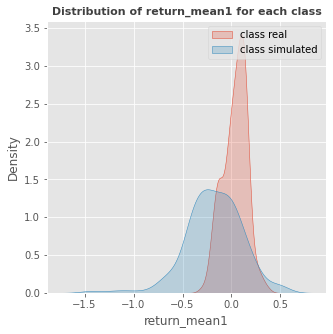

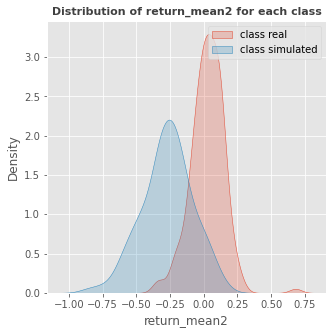

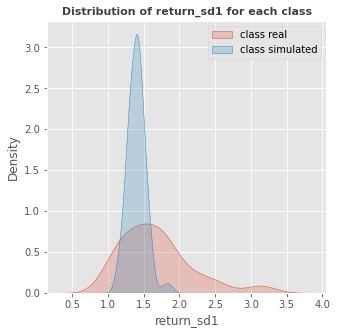

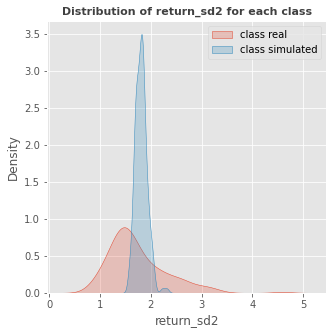

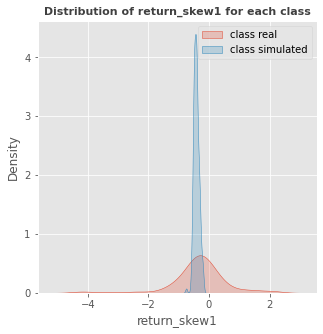

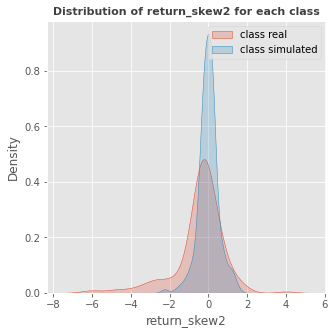

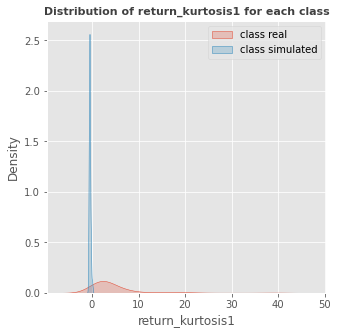

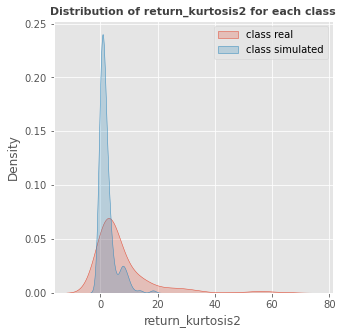

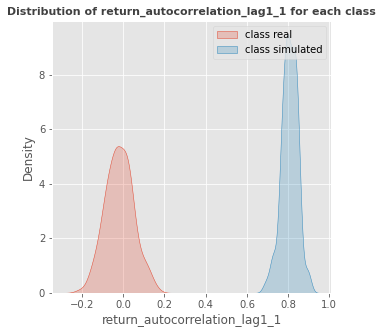

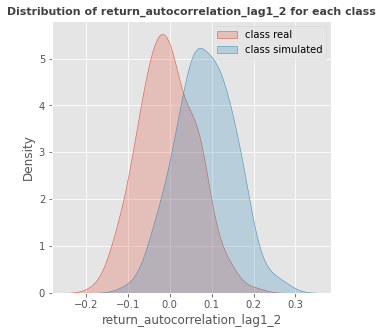

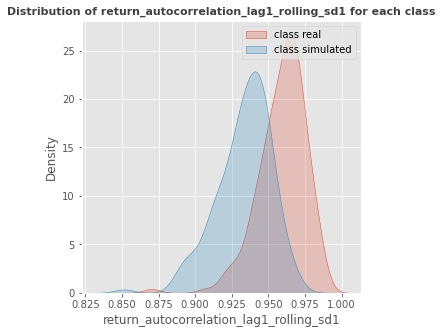

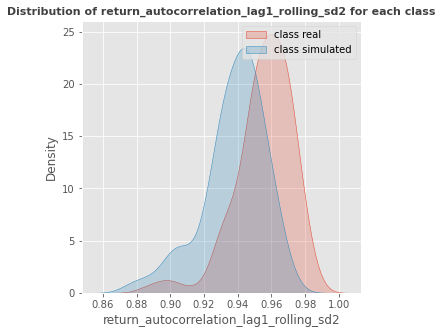

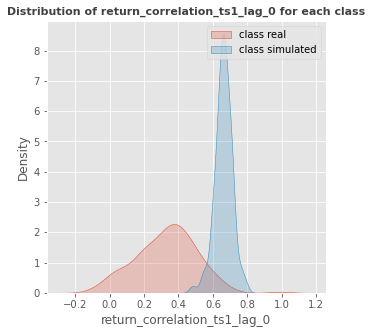

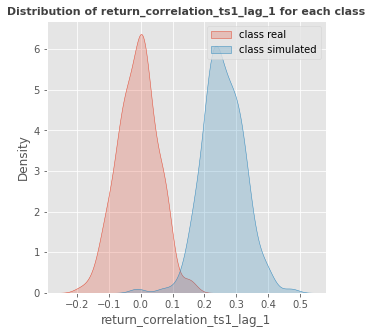

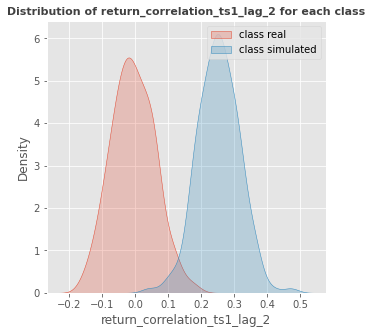

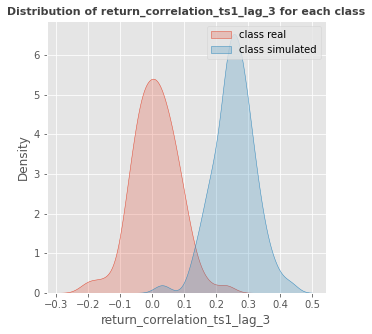

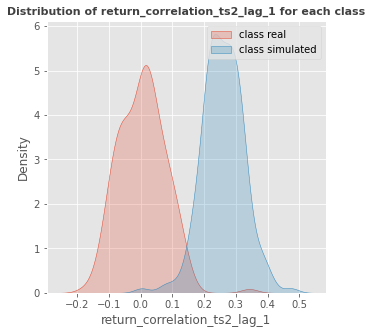

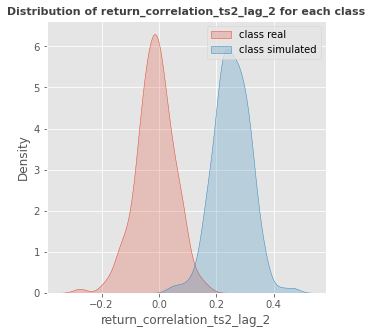

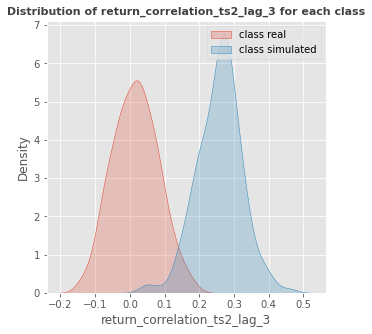

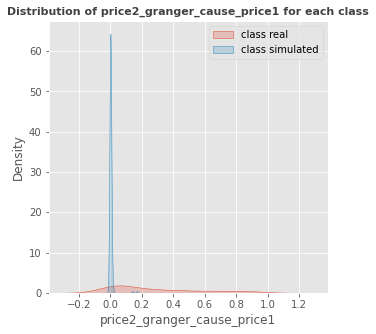

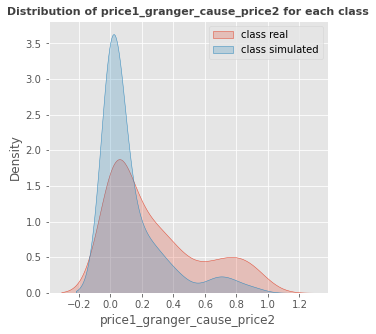

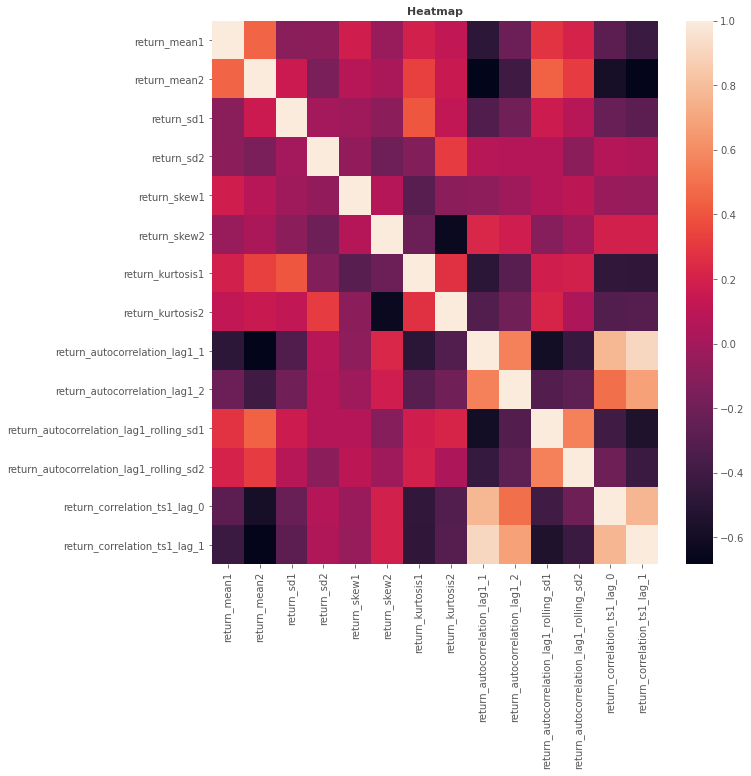

In [13]:
np.random.seed(9868)
num_iter = 5
random_seeds = np.random.randint(low=0, high=980608, size=(num_iter,))
results = []


real_statistics = create_statistics(
    label="real", 
    rolling_window=20, 
    return_csv_location=real_data_folder + "pair_return_mixed_period_classification.csv", 
    price_csv_location=real_data_folder + "pair_price_mixed_period_classification.csv")
    
    
for iter in range(num_iter):

    random_seed = int(random_seeds[iter])
    
    n_sim_jumpou_log_prices = n_jumpou_simulation(
        random_seed=random_seed, num_sim=248,
        mu11=params[0], mu12=params[1], 
        mu21=params[2], mu22=params[3], 
        sigma11=params[4], sigma12=params[5], 
        sigma21=params[6], sigma22=params[7],
        j11=params[8], j12=params[9], 
        j21=params[10], j22=params[11],
        alpha=params[12], 
        beta1=beta1, beta2=beta2, 
        delta0=params[13], 
        mu1=params[14], mu2=params[15], 
        lambda11=params[16], lambda12=lambda12, 
        lambda21=lambda21, lambda22=1/params[16],
        xinit_vec=xinit_vec, T0=T0, T=T, length=length)

    n_sim_jumpou_pair_prices = log_price_to_price(n_log_price=n_sim_jumpou_log_prices)
    n_sim_jumpou_pair_returns = price_to_return(n_price=n_sim_jumpou_pair_prices)

    n_sim_jumpou_pair_prices.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")
    n_sim_jumpou_pair_returns.to_csv("/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv")
    
    
    simulated_statistics = create_statistics(
        label="simulated", 
        rolling_window=20, 
        return_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_returns.csv", 
        price_csv_location="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/n_sim_jumpou_pair_prices.csv")


    dataset = pd.concat([real_statistics, simulated_statistics])
    X = dataset.iloc[:, 0:21]
    y = dataset.iloc[:, 21]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_seed)
    automl = AutoML(eval_metric='accuracy')
    automl.fit(X_train, y_train)
    predictions = automl.predict(X_test)
    accuracy_result = accuracy_score(y_test, predictions)
    results.append(accuracy_result)
    EDA.extensive_eda(X_train, y_train, save_path="/Users/changmao/Desktop/OneDrive - Imperial College London/InferStat - MSc Summer Project/GitHub/Summer-Research-Project/Calibration/Cluster jobs/trendingou_jump12/ou_jump12_calibration_update_classification_EDA/AutoML_EDA")
    print(f"Accuracy of predictions:  {accuracy_result:.3f}")

accuracy_average = np.mean(results)
accuracy_std = np.std(results)


In [14]:
print(results)
print(accuracy_average)
print(accuracy_std)

[0.9865771812080537, 0.9865771812080537, 1.0, 1.0, 1.0]
0.9946308724832214
0.006575811390021944
